# Electrical impedance tomography material reconstruction time series analysis


This notebook reconstructs the voltage measurement data of a piezoresistive material that has had known pressures applied to the material in a known sequence. 

**Part A** - Absolute Reconstruction
1. Compare absolute reconstruction techniques

    a. inv_solve_abs_GN_constrain 

    b. inv_solve_abs_GN_prior

    c. inv_solve_abs_annealingMetropolis_params	

    d. inv_solve_abs_annealingSimplex_params

2. Determine quality of absolute reconstruction

    a. Check stability for first 5 static frames


**Part B** - Visualise time series
1. Using default parameters for EIT reconstruction log a time series reconstruction.
2. Run an spatial analysis for:
    
    a. CoM of detection accuracy

    b. Blob shape accuracy

        i. Blob overlap
        
        ii. Blob to polygon goodness of fit

    c. Find Reconstruction regression coefficients

3. Run a temporal analysis for:
    
    a. Total domain relaxation

    b. Blob relaxation
    
    b. Successive pushes detection resolution

**Part C:** - Stress Sensor Analysis
1. Fit a quasi-linear piezoresistive model to the material

    a. Determine error from actual stress

2. Fit a non-linear piezoresistive model to the material

    a. Using SLS viscoelastic model
    
    b. Using implicit Euler method


**Part D:** - Justify and Optimise
1. Optimise:

    a. Elements
    
    b. Hyperparameter

    c. Reconstruction optimisation algorithm

</br>

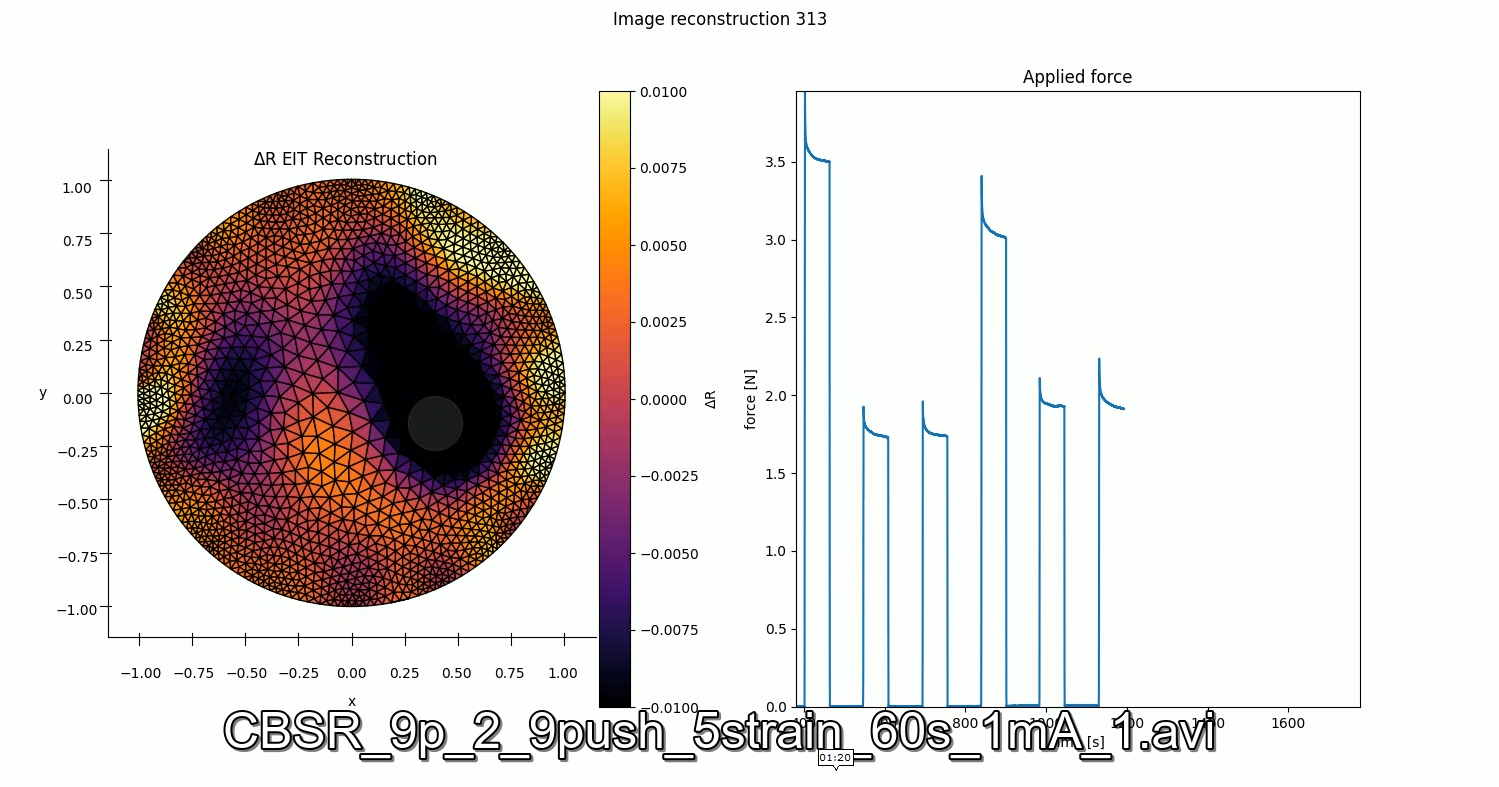
Figure: Screen capture of a reconstruction video

</br>

*Notes:*

*Non python reqs: EIDORS, netlist for a resistor network, Matlab install, square_recon() Matlab function*

*Python reqs: Download all imported modules using pip install + homemade ert_mesh_sim.py module*

In [3]:
# load all modules and Matlab engine! Vrrooom!
import sys
sys.path.append('../black_sensor/pcb-firmware/pcb_mux') # <<import homebrew modules from here
import csv
import cv2
import glob
import matlab.engine
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D, art3d
import os
import numpy as np
import pandas as pd
import pickle as pkl
from PIL import Image
# import pymesh # may need a docker container for this OR attempt to build this properly...?
from scipy import optimize
import time

num_elecs = 16 # ;)

print("Matlab engine loading...")
ml_eng = matlab.engine.start_matlab()
print("Loaded Matlab!")

# input EIDORS function directory path
pth2 = ml_eng.genpath('..\EIDORS\eidors-v3.10-ng\eidors\ert_black_sensor')
ml_eng.addpath(pth2, nargout=0)
# load eidors startup.m?
print("EIDORS startup.m loading...")
ml_eng.eidors_startup('..\EIDORS\eidors-v3.10-ng\eidors\startup.m')
print("Loaded EIDORS!")

Matlab engine loading...
Loaded Matlab!
EIDORS startup.m loading...
Loaded EIDORS!


In [29]:
# load specific recon plotting functions

# Function to reformat image data
def ml2py_fem(recon_fem_obj):
    '''
    Takes a Matlab FEM struct with sections 'data', 'nodes', and 'elems' and reformats them such that they are all usable for FEM 
    plotting in python with plot_fem() etc.
    '''
    recon_data_ = np.array(recon_fem_obj['data'])
    recon_nodes_ = np.array(recon_fem_obj['nodes'])
    recon_elems_ = np.array(recon_fem_obj['elems']) - 1
    
    recon_data = recon_data_
    recon_nodes = np.zeros((len(recon_nodes_), 3))
    recon_nodes[:,0:2] = recon_nodes_
    recon_elems = recon_elems_.astype(int)

    # check if data has been extrapolated by 2x (because EIDORS does this for square mesh reconstructions...)
    if 2*len(recon_data_) == len(recon_elems_):
        recon_data = np.zeros(len(recon_elems_))
        for i in range(int(len(recon_data)/2)):
            recon_data[-(i)*2-1] = recon_data_[i]
            recon_data[-(i)*2-2] = recon_data[-(i)*2-1]
    return recon_data, recon_nodes, recon_elems

def plot_FEM(elem_data, nodes, elems, xy_lim=1.1, dia_DUT_mm=100, title='',hold_on=False, cb_lims=None, elem_unit="$\Delta \\rho$"):
    '''
    Takes meshed 2D FEM data as an unstructured mesh and plots it

    when cb_lims (i.e. [cb_min, cb_max]) are not set plot scale is normalised
    '''    
    nodes = nodes*dia_DUT_mm/2
    xy_lim = 1.1*dia_DUT_mm/2
    if not hold_on:
        fig = plt.figure(figsize=(8,8))
    else:
        fig = plt.figure(1,figsize=(8,8))
    ax1 = fig.add_subplot(projection="3d")
    
    if cb_lims==None:
        cb_lims = [elem_data.min(), elem_data.max()]

    norm = plt.Normalize(cb_lims[0], cb_lims[1])
    colors = plt.cm.inferno(norm(elem_data))
    norm_cb = mpl.colors.Normalize(vmin=cb_lims[0],vmax=cb_lims[1])

    # rotate the plot
    nodes_rot = np.zeros(np.shape(nodes))
    for i in range(len(nodes)):
        rotMat = lambda theta: np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
        rot_angle = (2*np.pi) / (num_elecs) + (np.pi) / (2*num_elecs) - (np.pi) / (4*num_elecs)
        nodes_rot[i][0:2] = np.dot(nodes[i][0:2],rotMat(rot_angle))

    pc = art3d.Poly3DCollection(nodes_rot[elems],facecolors=colors,cmap='inferno',norm=norm_cb,edgecolor="black")
    
    ax1.add_collection(pc)

    ax1.view_init(elev=90, azim=270)
    ax1.set_xlim3d(-xy_lim,xy_lim)
    ax1.set_ylim3d(-xy_lim,xy_lim)

    # Hide the Z axis
    ax1.zaxis.line.set_lw(0.)
    ax1.set_zticks([])

    # Change xyz plane colours to white
    ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Remove gridlines
    ax1.xaxis._axinfo["grid"].update({"linewidth":0})
    ax1.yaxis._axinfo["grid"].update({"linewidth":0})
    ax1.dist=6

    # Add colour bar
    cbar = plt.colorbar(pc,ax=ax1)
    cbar.set_label(elem_unit)

    # Label axes
    plt.title(title)
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    if not hold_on:
        plt.show()

    return ax1
    
def plot_FEM_f(elem_data, nodes, elems, x_data, y_data, z_data, f_data, t_data, t_index, strain, dia_DUT_mm, 
               thk_DUT_mm, dia_f_aplc_mm=13, title='', eit_title="$\Delta$R EIT Reconstructed Image", hold_on=False, cb_lims=None):
    '''
    Takes meshed 2D FEM data as an unstructured mesh and plots it beside a correlated force plot

    when cb_lims (i.e. [cb_min, cb_max]) are not set plot scale is normalised
    '''
    x_data = x_data*dia_DUT_mm/2
    y_data = y_data*dia_DUT_mm/2
    nodes = nodes*dia_DUT_mm/2
    xy_lim = 1.1*dia_DUT_mm/2

    if not hold_on:
        fig = plt.figure(figsize=(16,8))
    else:
        fig = plt.figure(1,figsize=(16,8))
    ax1 = fig.add_subplot(121,projection="3d")
    
    if cb_lims==None:
        cb_lims[0]=elem_data.min()
        cb_lims[1]=elem_data.max()

    norm = plt.Normalize(cb_lims[0], cb_lims[1])
    colors = plt.cm.inferno(norm(elem_data))
    norm_cb = mpl.colors.Normalize(vmin=cb_lims[0],vmax=cb_lims[1])

    pc = art3d.Poly3DCollection(nodes[elems],facecolors=colors,cmap='inferno',norm=norm_cb,edgecolor="black")
    
    ax1.add_collection(pc)

    ax1.view_init(elev=90, azim=270)
    ax1.set_xlim3d(-xy_lim,xy_lim)
    ax1.set_ylim3d(-xy_lim,xy_lim)

    # Hide the Z axis
    ax1.zaxis.line.set_lw(0.)
    ax1.set_zticks([])

    # Change xyz plane colours to white
    ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Remove gridlines
    ax1.xaxis._axinfo["grid"].update({"linewidth":0})
    ax1.yaxis._axinfo["grid"].update({"linewidth":0})
    ax1.dist=6

    # Plot circular force applicator area
    # c_range_z =  strain/100 * thk_DUT_mm
    # colour_z = str((z_data[t_index]-min(z_data))/c_range_z if (z_data[t_index]-min(z_data))/c_range_z < 1.0 else 1.0) # TODO: uses z_mesh to give applicator colours
    c_range_z = np.percentile(z_data, 40) - min(z_data)
    colour_z = str(1-(z_data[t_index]-min(z_data))/c_range_z if (z_data[t_index]-min(z_data))/c_range_z < 1.0 else 1.0)
    rotMat = lambda theta: np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    rot_angle = (-2*np.pi) / num_elecs # rotate the push circle by 360/num_elecs, i.e. 22.5deg
    xy_loc = np.dot([x_data[t_index],y_data[t_index]],rotMat(rot_angle))
    # Overlay a circle using 3D primitives
    circle_center = (2*xy_loc[0]/dia_DUT_mm,2*xy_loc[1]/dia_DUT_mm, 0)  # Z-coordinate is 0 to overlay on the plane
    circle_radius = dia_f_aplc_mm/2
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, circle_radius, 20)
    v_matrix, u_matrix = np.meshgrid(v, u)
    x = circle_center[0] + v_matrix * np.cos(u_matrix)
    y = circle_center[1] + v_matrix * np.sin(u_matrix)
    z = np.tile(circle_center[2], x.shape)
    ax1.plot_surface(x, y, z, color=colour_z, alpha=0.6)

    # Add colour bar
    cbar = plt.colorbar(pc,ax=ax1)
    cbar.set_label('$\Delta$R [$\Omega$]',fontsize=14)

    # Label axes
    ax1.set_title(eit_title,fontsize=16)
    ax1.set_xlabel("x [mm]")
    ax1.set_ylabel("y [mm]")
    mpl.rc('xtick') 
    mpl.rc('ytick') 

    # # uncomment for chonky plotting fonts
    # font = {'family' : 'normal',
    #         'weight' : 'normal',
    #         'size'   : 16}

    # mpl.rc('font', **font)

    # plot force vs time
    ax2 = fig.add_subplot(122)
    ax2.plot(t_data[0:t_index],f_data[0:t_index])
    ax2.set_xlim(xmin=min(t_data),xmax=max(t_data))
    ax2.set_ylim(ymin=min(f_data),ymax=max(f_data))
    ax2.set_title("Applied force")
    ax2.set_xlabel("time [s]")
    ax2.set_ylabel("force [N]")

    fig.suptitle(title)

    if not hold_on:
        plt.show()

    return [fig, ax1, ax2]

def plot_FEM_f_r(elem_data, nodes, elems, x_data, y_data, z_data, f_data, rtot_data, t_data, t_index, strain, dia_DUT_mm, thk_DUT_mm, dia_f_aplc_mm=13, xy_lim=1.1, title='',hold_on=False, cb_lims=None):
    '''
    Takes meshed 2D FEM data as an unstructured mesh and plots it beside a correlated force and total resistance plot

    when cb_lims (i.e. [cb_min, cb_max]) are not set plot scale is normalised
    '''
    if not hold_on:
        fig = plt.figure(figsize=(16,10))
    else:
        fig = plt.figure(1,figsize=(16,8))
    ax1 = fig.add_subplot(121,projection="3d")
    
    if cb_lims==None:
        cb_lims[0]=elem_data.min()
        cb_lims[1]=elem_data.max()

    norm = plt.Normalize(cb_lims[0], cb_lims[1])
    colors = plt.cm.inferno(norm(elem_data))
    norm_cb = mpl.colors.Normalize(vmin=cb_lims[0],vmax=cb_lims[1])

    pc = art3d.Poly3DCollection(nodes[elems],facecolors=colors,cmap='inferno',norm=norm_cb,edgecolor="black")
    
    ax1.add_collection(pc)

    ax1.view_init(elev=90, azim=270)
    ax1.set_xlim3d(-xy_lim,xy_lim)
    ax1.set_ylim3d(-xy_lim,xy_lim)

    # Hide the Z axis
    ax1.zaxis.line.set_lw(0.)
    ax1.set_zticks([])

    # Change xyz plane colours to white
    ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

    # Remove gridlines
    ax1.xaxis._axinfo["grid"].update({"linewidth":0})
    ax1.yaxis._axinfo["grid"].update({"linewidth":0})
    ax1.dist=xy_lim*5

    # Plot circular force applicator area
    # c_range_z =  strain/100 * thk_DUT_mm
    # colour_z = str((z_data[t_index]-min(z_data))/c_range_z if (z_data[t_index]-min(z_data))/c_range_z < 1.0 else 1.0) # TODO: uses relative z_mesh to give applicator colours
    c_range_z = np.percentile(z_data, 40) - min(z_data)
    colour_z = str((z_data[t_index]-min(z_data))/c_range_z if (z_data[t_index]-min(z_data))/c_range_z < 1.0 else 1.0)
    rel_marker_size = (300 / dia_DUT_mm) * dia_f_aplc_mm # 300 = pixel size scale factor
    print(colour_z)
    rotMat = lambda theta: np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
    rot_angle = (-2*np.pi) / num_elecs # rotate the push circle by 360/num_elecs, 22.5deg
    xy_loc = np.dot([x_data[t_index],y_data[t_index]],rotMat(rot_angle))
    # Overlay a circle using 3D primitives
    circle_center = (2*xy_loc[0]/dia_DUT_mm,2*xy_loc[1]/dia_DUT_mm, 0)  # Z-coordinate is 0 to overlay on the plane
    circle_radius = dia_f_aplc_mm / dia_DUT_mm
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, circle_radius, 20)
    v_matrix, u_matrix = np.meshgrid(v, u)
    x = circle_center[0] + v_matrix * np.cos(u_matrix)
    y = circle_center[1] + v_matrix * np.sin(u_matrix)
    z = np.tile(circle_center[2], x.shape)
    ax1.plot_surface(x, y, z, color=colour_z, alpha=0.3)
    
    # Add colour bar
    cbar = plt.colorbar(pc,ax=ax1)
    cbar.set_label('$\Delta$R [$\Omega$]')

    # Label axes
    ax1.set_title("$\Delta$R EIT Reconstruction")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    # plot force vs time
    ax2 = fig.add_subplot(222)
    ax2.plot(t_data[0:t_index],f_data[0:t_index])
    ax2.set_xlim(xmin=min(t_data),xmax=max(t_data))
    ax2.set_ylim(ymin=min(f_data),ymax=max(f_data))
    ax2.set_title("Applied force")
    ax2.set_xlabel("time [s]")
    ax2.set_ylabel("force [N]")

    # plot sumR vs time
    scaled_t_index = t_index // num_elecs**2
    len_t_interp = len(t_data)//num_elecs**2
    t_data_interp = np.array(t_data[0::len_t_interp])
    err_t_data_interp = np.abs(t_data_interp - t_data[t_index])
    t_interp_index = np.argmin(err_t_data_interp)
    ax3 = fig.add_subplot(224)
    if len(rtot_data) < t_interp_index:
        t_interp_index = len(rtot_data)
    ax3.plot(t_data_interp[0:t_interp_index],rtot_data[0:t_interp_index])
    ax3.set_xlim(xmin=min(t_data),xmax=max(t_data))
    ax3.set_ylim(ymin=min(rtot_data),ymax=max(rtot_data))
    ax3.set_title("Total resistance change")
    ax3.set_ylabel("$\Sigma(\Delta$R elems)")

    fig.suptitle(title)

    if not hold_on:
        plt.show()

    return [fig, ax1, ax2, ax3]


# Save image reconstruction data to save time re-solving through Matlab

def save_recon(elem_data, nodes, elems, filename, recon_timestamps_s=[], rtot=[]):
    '''
    Save reconstruction data as compressed .pkl file
    '''
    # TODO add reconstruction params??
    with open(filename+".pkl","wb") as fp:
        pkl.dump(elem_data,fp)
        pkl.dump(nodes,fp)
        pkl.dump(elems,fp)
        pkl.dump(recon_timestamps_s,fp)
        pkl.dump(rtot,fp)

    return 0

def load_recon(elem_data, nodes, elems, filename, recon_timestamp_s=[], rtot=[]):
    '''
    Load reconstruction data as compressed .pkl file
    
    note: if loading 'rtot' must also load 'recon_timestamp_s'
    '''
    with open(filename+".pkl","rb") as fp:
        elem_data = pkl.load(fp)
        nodes = pkl.load(fp)
        elems = pkl.load(fp)
        if len(recon_timestamp_s) > 0:
            recon_timestamp_s = pkl.load(fp)
        if len(rtot) > 0:
            rtot = pkl.load(fp)
    
    return elem_data,nodes,elems,recon_timestamp_s,rtot


# Part A - Absolute Reconstruction
An absolute reconstruction will be performed to obtain a rough the material homogeneity. This absolute-ness will be validated by ensuring the first 5 frames are similar and also ensuring that the interelectrode resistance matches the internal DUT resistivity.

## A - 1 - Compare absolute reconstruction techniques
In this section we run the 4 main EIDORS absolute reconstruction solvers: inv_solve_abs_GN_constrain, inv_solve_abs_GN_prior, inv_solve_abs_annealingMetropolis_params, inv_solve_abs_annealingSimplex_params. Comparing first by visual inspection, then using quantitative metrics... TBD


### A - 1 - a - Gauss-Newton Constrain Abs Recon


In [5]:
%matplotlib qt

def adv_eit_recon(eit_data_file, raw_data_dir,hp,prior,inv_solve,recon_type,ref_frame=0,offset_on=0):
    '''
    Program which 
    1. generates time series EIT reconstructions using the advanced input params
    2. saves all FEM data in a .pkl file

    Just put in the 'ert_data_inhom' twice if doing an absolute reconstruction
    '''
  
    if offset_on:
        # apply old xy offsets
        home_offset_mm = [57.8,14.5] 
        ref_loc_mm = [65,25]

    # init output arrays
    elem_data_arr = []
    nodes_arr = []
    elems_arr = []
    t_eit_arr = []
    rtot_arr = []
    mesh_params = "d2d2c" # As chosen by the shoddy mesh convergence 

    # image path
    img_path = f"{raw_data_dir}\images\{eit_data_file}"

    eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
    eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
    eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
    if offset_on:
        eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
        eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]

    with open(f"{raw_data_dir}\{eit_data_file}.pkl","rb") as fp:
        eit_df = pkl.load(fp)
    strain = eit_df.strain[0]

    frames = len(eit_data_arr)//(num_elecs**2)

    # Generate reconstruction mesh
    mesh_obj = ml_eng.gen_mesh(mesh_params)

    # run reconstruction
    for i in range(frames):
        if not os.path.isfile(f"{raw_data_dir}\{eit_data_file}_recon.pkl"): # check if solver has already generated a solution
            hom = np.array(eit_data_arr['voltage [V]'][ref_frame*num_elecs**2:(ref_frame+1)*num_elecs**2])
            anom = np.array(eit_data_arr['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2])

            print("Running EIDORS inverse solver...")
            recon_fem_obj_r = ml_eng.adv_circle_recon(matlab.double(hom), matlab.double(anom),matlab.double(hp),matlab.double(prior),inv_solve,recon_type)
            print("Solved!")
            elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
            elem_data_arr.append(elem_data)
            nodes_arr.append(nodes)
            elems_arr.append(elems)
            rtot_arr.append(np.sum(elem_data))
            t_eit_arr.append(np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))
        else:
            elem_data_arr, nodes_arr, elems_arr, t_eit_arr, rtot_arr  = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{eit_data_file}_recon", t_eit_arr, rtot_arr)
            if len(rtot_arr) == 0:
                rtot_arr = np.sum(elem_data_arr,1)
                print(rtot_arr)

        # plot and save figure
        cb_min = -10e-3 # set colour bar min/max
        cb_max = 10e-3

        if not os.path.isfile(f"{img_path}\{i}.png"): # checks if frames for video have already been created
            if 'rGOSR' in eit_data_file:
                plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=60, thk_DUT_mm=3, 
                        title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
            elif 'CBSR' in eit_data_file:
                plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
                        title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
                
            if not os.path.isdir(img_path):
                os.mkdir(img_path)
            plt.savefig(f"{img_path}\{i}.png")
            plt.close()
        print(f"frame {i}/{frames}")

    save_recon(elem_data_arr,nodes_arr,elems_arr,f"{raw_data_dir}\{eit_data_file}_recon",t_eit_arr,rtot_arr)


In [25]:
# Choose an EIT data file
eit_data_file = "CBSR_8p_4_9push_10strain_60s_500uA_1_Copy"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p"

# adv recon params
hp = 0.03
prior = 'prior_laplace'
inv_solve = 'inv_solve_gn'
recon_type = 'absolute'
mesh_params = "d2d2c" # As chosen by the shoddy mesh convergence 

# init output arrays
elem_data_arr = []
nodes_arr = []
elems_arr = []
t_eit_arr = []
rtot_arr = []

# image path
img_path = f"{raw_data_dir}\images\{eit_data_file}"

eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]

frames = len(eit_data_arr)//(num_elecs**2)

# Generate reconstruction mesh
mesh_obj = ml_eng.gen_mesh(mesh_params)

# Choose a frame to reconstruct
frame_idx = 15
anom = np.array(eit_data_arr['voltage [V]'][frame_idx*num_elecs**2:(frame_idx+1)*num_elecs**2])
hom = anom

ml_eng.adv_circle_recon(matlab.double(hom), matlab.double(anom), hp)#, prior, inv_solve, recon_type)

{'data': matlab.double([[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0

# Part B - Visualising the time series reconstruction
Create an time series animation of the EIT reconstruction frames using default EIT reconstruction parameters to show the system is functional (i.e. you can see a correlation between real push area and the reconstructed change in resistance regions).

### B - 0 - Ensure that a valid solution is found for the first few reconstruction frames
This involves changing the first reference frame if the a good solution is not found. The metrics that could be used to determine the that a good reconstruction has been performed are:
    
    a. Difference between the reference frame and the current frame. i.e. a priori info on the time series

    b. Residual from the EIT algorithm optimisation

    c. Error between the EIT data and the forward simulated data - This may be a poor metric, the error could be zero but could have converged on an incorrect solution space..

    d. Determine noise figure, NF
    

In [8]:
%matplotlib qt

def check_ref_eit_recon(eit_data_file, raw_data_dir,offset_on=0):
    if offset_on:
        # apply old xy offsets
        home_offset_mm = [57.8,14.5] 
        ref_loc_mm = [65,25]

    # init params
    elem_data_arr = []
    nodes_arr = []
    elems_arr = []
    t_eit_arr = []
    rtot_arr = []
    mesh_params = "d2d2c" # As chosen by the shoddy mesh convergence test

    # image path
    img_path = f"{raw_data_dir}\images\{eit_data_file}"

    eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
    eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
    eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
    if offset_on:
        eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
        eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]

    with open(f"{raw_data_dir}\{eit_data_file}.pkl","rb") as fp:
        eit_df = pkl.load(fp)
    strain = eit_df.strain[0]

    frames = len(eit_data_arr)//(num_elecs**2)
    ref_frames = 6

    # Generate reconstruction mesh
    mesh_obj = ml_eng.gen_mesh(mesh_params)

    # run reconstruction
    for ref in range(ref_frames):
        for i in range(ref_frames):
            if not os.path.isfile(f"{raw_data_dir}\{eit_data_file}_recon.pkl"): # check if solver has already generated a solution
                hom = np.array(eit_data_arr['voltage [V]'][ref*num_elecs**2:(ref+1)*num_elecs**2])
                anom = np.array(eit_data_arr['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2])
                print("Running EIDORS inverse solver...")
                recon_fem_obj_r = ml_eng.circle_recon(matlab.double(hom), matlab.double(anom))
                print(f"Solved! Error = {recon_fem_obj_r['error']:.6f}")
                elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
                elem_data_arr.append(elem_data)
                nodes_arr.append(nodes)
                elems_arr.append(elems)
                rtot_arr.append(np.sum(elem_data))
                t_eit_arr.append(np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))
            else:
                elem_data_arr, nodes_arr, elems_arr, t_eit_arr, rtot_arr  = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{eit_data_file}_ref_recon", t_eit_arr, rtot_arr)
                if len(rtot_arr) == 0:
                    rtot_arr = np.sum(elem_data_arr[i],1)
                    # print(rtot_arr)

            # plot and save figure
            cb_min = -10e-3 # set colour bar min/max
            cb_max = 10e-3

            if not os.path.isfile(f"{img_path}_ref\P{ref}_{i}.png"): # checks if frames for video have already been created
                if 'rGOSR' in eit_data_file:
                    plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                            eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=60, thk_DUT_mm=3, 
                            title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
                elif 'CBSR' in eit_data_file:
                    plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                            eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
                            title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
                    
                if not os.path.isdir(f"{img_path}_ref"):
                    os.mkdir(f"{img_path}_ref")
                plt.savefig(f"{img_path}_ref\P{ref}_{i}.png")
                plt.close()
            print(f"frame {i}/{frames}")

    save_recon(elem_data_arr,nodes_arr,elems_arr,f"{raw_data_dir}\{eit_data_file}_ref_recon",t_eit_arr,rtot_arr)

    max_elem_R = cb_max # difficult to obtain a noise floor value when all you have is noise

    ref_frames = 6
    errorMat = np.zeros((ref_frames,ref_frames))
    for ref in range(ref_frames):
        for i in range(1,ref_frames):
            errorMat[ref][i] = max(abs(elem_data_arr[ref*i+i-1] - elem_data_arr[ref*i+i]))
            if errorMat[ref][i] > max_elem_R:
                print(f"ERROR! Frame ref{ref}_{i} has diverged")

    # Use each of the 5 first frames as a reference frame and determine which has the lowest average noise maximum
    ref_maxs = np.max(errorMat,1)
    print(f"Max for each ref:{ref_maxs}")
    ref_min = np.where(ref_maxs == np.min(ref_maxs))
    print(f"ref with min error = #{ref_min}")
    ref_frame = ref_min[0][0]

    return ref_frame


In [6]:
# Run recon for first 6 reference frames to find best frame for the rest of the recons
# NOTE: The material must be at a steady state for these 6 frames!
eit_data_file = "CBSR_8p_4_9push_10strain_60s_500uA_2"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p" 
print(check_ref_eit_recon(eit_data_file, raw_data_dir))

NameError: name 'check_ref_eit_recon' is not defined

In [7]:
%matplotlib qt

def find_nf_eit_recon(eit_data_file, raw_data_dir,offset_on=0):
    if offset_on:
        # apply old xy offsets
        home_offset_mm = [57.8,14.5] 
        ref_loc_mm = [65,25]

    # init params
    elem_data_arr = []
    nodes_arr = []
    elems_arr = []
    t_eit_arr = []
    rtot_arr = []
    v_arr = []
    mesh_params = "d2d2c" # As chosen by the shoddy mesh convergence test

    # image path
    img_path = f"{raw_data_dir}\images\{eit_data_file}"

    eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
    eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
    eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
    if offset_on:
        eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
        eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]

    with open(f"{raw_data_dir}\{eit_data_file}.pkl","rb") as fp:
        eit_df = pkl.load(fp)
    strain = eit_df.strain[0]

    frames = len(eit_data_arr)//(num_elecs**2)
    ref_frames = 6

    # Generate reconstruction mesh
    mesh_obj = ml_eng.gen_mesh(mesh_params)

    # run reconstruction
    ref = 0
    for i in range(ref_frames):
        hom = np.array(eit_data_arr['voltage [V]'][0*num_elecs**2:(0+1)*num_elecs**2])
        anom = np.array(eit_data_arr['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2])
        v_arr.append(np.array(eit_data_arr['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2]))
        print("Running EIDORS inverse solver...")
        recon_fem_obj_r = ml_eng.circle_recon(matlab.double(hom), matlab.double(anom))
        print(f"Solved! Error = {recon_fem_obj_r['error']:.6f}")
        elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
        elem_data_arr.append(elem_data)
        nodes_arr.append(nodes)
        elems_arr.append(elems)
        rtot_arr.append(np.sum(elem_data))
        t_eit_arr.append(np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))

        # plot and save figure
        cb_min = -10e-3 # set colour bar min/max
        cb_max = 10e-3

        if not os.path.isfile(f"{img_path}_ref\P{ref}_{i}.png"): # checks if frames for video have already been created
            if 'rGOSR' in eit_data_file:
                plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=60, thk_DUT_mm=3, 
                        title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
            elif 'CBSR' in eit_data_file:
                plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
                        title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
                
            if not os.path.isdir(f"{img_path}_ref"):
                os.mkdir(f"{img_path}_ref")
            plt.savefig(f"{img_path}_ref\P{ref}_{i}.png")
            plt.close()
        print(f"frame {i}/{frames}")

    save_recon(elem_data_arr,nodes_arr,elems_arr,f"{raw_data_dir}\{eit_data_file}_ref_recon",t_eit_arr,rtot_arr)

    elem_data_arr = np.array(elem_data_arr)
    elem_data_arr = np.reshape(elem_data_arr,np.shape(elem_data_arr)[0:2])
    t_eit_arr = np.array(t_eit_arr)
    rtot_arr = np.array(rtot_arr)
    v_arr = np.array(v_arr)

    # find v stats
    v_u = np.empty(0)
    v_std = np.empty(0)
    v_snr = np.empty(0)
    # find r stats
    r_u = np.empty(0)
    r_std = np.empty(0)
    r_snr = np.empty(0)

    for i in range(np.shape(v_arr)[1]):
        v_u = np.append(v_u,np.mean(np.transpose(v_arr)[i]))
        v_std = np.append(v_std,np.std(np.transpose(v_arr)[i]))
        v_snr = np.append(v_snr, np.sqrt(v_u[-1]**2/v_std[-1]**2))

        r_u = np.append(r_u,np.mean(np.transpose(elem_data_arr)[i]))
        r_std = np.append(r_std,np.std(np.transpose(elem_data_arr)[i]))
        r_snr = np.append(r_snr, np.sqrt(r_u[-1]**2/r_std[-1]**2))
    
    r_snr_u = np.mean(r_snr)
    v_snr_u = np.mean(v_snr)

    nf = r_snr_u / v_snr_u
    print(f"NF: {nf}, Res SNR:{r_snr_u}, V SNR:{v_snr_u}")

    return nf, r_snr_u, v_snr_u



In [134]:
# Run recon for first 6 reference frames to determine the noise figure
# NOTE: The material must be at a steady state for these 6 frames!
import csv
# output arrays
nf_arr = []
v_snr_arr = []
r_snr_arr = []
# input files
eit_data_file1 = "CBSR_9p_2_9push_"
eit_data_file2 = "strain_60s_1mA"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_9p" 

with open(f"{raw_data_dir}\{eit_data_file1}XX{eit_data_file2}_nf_stats.csv", 'a', newline='') as csvfile:
    csv_data = csv.writer(csvfile, delimiter=',')
    csv_data.writerow(['strain','exp_num','nf','r_snr', 'v_snr'])
    for i in np.linspace(5,30,6): # range of strains
        i = int(i)
        eit_data_file_ = eit_data_file1 + str(i) + eit_data_file2
        for v in np.linspace(1,3,3): # repeated experiments
            v = int(v)
            print(f"{eit_data_file_}_{v}")
            nf, r_snr, v_snr = find_nf_eit_recon(f"{eit_data_file_}_{v}", raw_data_dir)
            nf_arr.append(nf)
            v_snr_arr.append(v_snr)
            r_snr_arr.append(r_snr)
            csv_data.writerow([i, v, nf, r_snr, v_snr])

CBSR_9p_2_9push_30strain_60s_1mA_1
Running EIDORS inverse solver...
Solved! Error = nan
frame 0/773
Running EIDORS inverse solver...
Solved! Error = 0.875838
frame 1/773
Running EIDORS inverse solver...
Solved! Error = 0.884145
frame 2/773
Running EIDORS inverse solver...
Solved! Error = 0.918586
frame 3/773
Running EIDORS inverse solver...
Solved! Error = 0.872516
frame 4/773
Running EIDORS inverse solver...
Solved! Error = 0.895330
frame 5/773
Res SNR:1.016091877314076, V SNR:866.5561451226456
CBSR_9p_2_9push_30strain_60s_1mA_2
Running EIDORS inverse solver...
Solved! Error = nan


C:\Users\rel80\AppData\Local\Temp\ipykernel_17992\2647693375.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/771
Running EIDORS inverse solver...
Solved! Error = 0.900851
frame 1/771
Running EIDORS inverse solver...
Solved! Error = 0.867009
frame 2/771
Running EIDORS inverse solver...
Solved! Error = 0.856878
frame 3/771
Running EIDORS inverse solver...
Solved! Error = 0.906775
frame 4/771
Running EIDORS inverse solver...
Solved! Error = 0.919373
frame 5/771
Res SNR:0.7899430006795953, V SNR:902.6615651553986
CBSR_9p_2_9push_30strain_60s_1mA_3
Running EIDORS inverse solver...
Solved! Error = nan


C:\Users\rel80\AppData\Local\Temp\ipykernel_17992\2647693375.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/770
Running EIDORS inverse solver...
Solved! Error = 0.917675
frame 1/770
Running EIDORS inverse solver...
Solved! Error = 0.892338
frame 2/770
Running EIDORS inverse solver...
Solved! Error = 0.902152
frame 3/770
Running EIDORS inverse solver...
Solved! Error = 0.911831
frame 4/770
Running EIDORS inverse solver...
Solved! Error = 0.910991
frame 5/770
Res SNR:0.6465265908116411, V SNR:952.2239150629078


### B - 1 - Using default parameters for EIT reconstruction log a time series reconstruction.



In [9]:
%matplotlib qt

def default_eit_recon(eit_data_file, raw_data_dir,ref_frame=0,offset_on=0):
    '''
    Program which 
    1. generates EIT reconstructions using NOSER with Laplace prior for time series EIT data 
    2. saves all FEM data in a .pkl file
    '''
  
    if offset_on:
        # apply old xy offsets
        home_offset_mm = [57.8,14.5] 
        ref_loc_mm = [65,25]

    # init params
    elem_data_arr = []
    nodes_arr = []
    elems_arr = []
    t_eit_arr = []
    rtot_arr = []
    mesh_params = "d2d2c" # As chosen by the shoddy mesh convergence 

    # image path
    img_path = f"{raw_data_dir}\images\{eit_data_file}"

    eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
    eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
    eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
    if offset_on:
        eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
        eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]

    with open(f"{raw_data_dir}\{eit_data_file}.pkl","rb") as fp:
        eit_df = pkl.load(fp)
    strain = eit_df.strain[0]

    frames = len(eit_data_arr)//(num_elecs**2)

    # Generate reconstruction mesh
    mesh_obj = ml_eng.gen_mesh(mesh_params)

    # run reconstruction
    for i in range(frames):
        if not os.path.isfile(f"{raw_data_dir}\{eit_data_file}_recon.pkl"): # check if solver has already generated a solution
            hom = np.array(eit_data_arr['voltage [V]'][ref_frame*num_elecs**2:(ref_frame+1)*num_elecs**2])
            anom = np.array(eit_data_arr['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2])

            print("Running EIDORS inverse solver...")
            recon_fem_obj_r = ml_eng.circle_recon(matlab.double(hom), matlab.double(anom))
            print("Solved!")
            elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
            elem_data_arr.append(elem_data)
            nodes_arr.append(nodes)
            elems_arr.append(elems)
            rtot_arr.append(np.sum(elem_data))
            t_eit_arr.append(np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))
        else:
            elem_data_arr, nodes_arr, elems_arr, t_eit_arr, rtot_arr  = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{eit_data_file}_recon", t_eit_arr, rtot_arr)
            if len(rtot_arr) == 0:
                rtot_arr = np.sum(elem_data_arr,1)
                # print(rtot_arr)

        # plot and save figure
        cb_min = -10e-3 # set colour bar min/max
        cb_max = 10e-3

        if not os.path.isfile(f"{img_path}\{i}.png"): # checks if frames for video have already been created
            if 'rGOSR' in eit_data_file:
                plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=60, thk_DUT_mm=3, 
                        title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
            elif 'CBSR' in eit_data_file:
                plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
                        title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
                
            if not os.path.isdir(img_path):
                os.mkdir(img_path)
            plt.savefig(f"{img_path}\{i}.png")
            plt.close()
        print(f"frame {i}/{frames}")

    save_recon(elem_data_arr,nodes_arr,elems_arr,f"{raw_data_dir}\{eit_data_file}_recon",t_eit_arr,rtot_arr)


#### B - 1 - a - Run Default Reconstruction

In [509]:
# Run recon for one test case
eit_data_file = "CBSR_8p_9push_5strain_60s_4_Copy"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p"
# ref_frame = check_ref_eit_recon(eit_data_file, raw_data_dir)
default_eit_recon(eit_data_file, raw_data_dir, ref_frame=0)
elem_data_arr, nodes_arr, elems_arr, t_eit_arr, rtot_arr  = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{eit_data_file}_recon", t_eit_arr, rtot_arr)


frame 0/510
frame 1/510
frame 2/510
frame 3/510
frame 4/510
frame 5/510
frame 6/510
frame 7/510
frame 8/510
frame 9/510
frame 10/510
frame 11/510
frame 12/510
frame 13/510
frame 14/510
frame 15/510
frame 16/510
frame 17/510
frame 18/510
frame 19/510
frame 20/510
frame 21/510
frame 22/510
frame 23/510
frame 24/510
frame 25/510
frame 26/510
frame 27/510
frame 28/510
frame 29/510
frame 30/510
frame 31/510
frame 32/510
frame 33/510
frame 34/510
frame 35/510
frame 36/510
frame 37/510
frame 38/510
frame 39/510
frame 40/510
frame 41/510
frame 42/510
frame 43/510
frame 44/510
frame 45/510
frame 46/510
frame 47/510
frame 48/510
frame 49/510
frame 50/510
frame 51/510
frame 52/510
frame 53/510
frame 54/510
frame 55/510
frame 56/510
frame 57/510
frame 58/510
frame 59/510
frame 60/510
frame 61/510
frame 62/510
frame 63/510
frame 64/510
frame 65/510
frame 66/510
frame 67/510
frame 68/510
frame 69/510
frame 70/510
frame 71/510
frame 72/510
frame 73/510
frame 74/510
frame 75/510
frame 76/510
frame 77/

In [511]:
i=70
plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                            eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
                            title=f"Image reconstruction {i}/{frames}", cb_lims=[cb_min,cb_max])
                    

C:\Users\rel80\AppData\Local\Temp\ipykernel_17992\2647693375.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


[<Figure size 1608x824 with 3 Axes>,
 <Axes3D: title={'center': '$\\Delta$R EIT Reconstruction'}, xlabel='x', ylabel='y'>,
 <Axes: title={'center': 'Applied force'}, xlabel='time [s]', ylabel='force [N]'>]

In [ ]:
# Run set of recons
eit_data_file1 = "CBSR_9p_2_9push_"
eit_data_file2 = "strain_60s_1mA"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_9p" 
for i in np.linspace(5,30,6):
    i = int(i)
    eit_data_file_ = eit_data_file1 + str(i) + eit_data_file2
    for v in np.linspace(1,3,3):
        v = int(v)
        print(f"{eit_data_file_}_{v}")
        default_eit_recon(f"{eit_data_file_}_{v}", raw_data_dir)

CBSR_9p_2_9push_5strain_60s_1mA_1
Running EIDORS inverse solver...
Solved!


C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/537
Running EIDORS inverse solver...
Solved!
frame 1/537
Running EIDORS inverse solver...
Solved!
frame 2/537
Running EIDORS inverse solver...
Solved!
frame 3/537
Running EIDORS inverse solver...
Solved!
frame 4/537
Running EIDORS inverse solver...
Solved!
frame 5/537
Running EIDORS inverse solver...
Solved!
frame 6/537
Running EIDORS inverse solver...
Solved!
frame 7/537
Running EIDORS inverse solver...
Solved!
frame 8/537
Running EIDORS inverse solver...
Solved!
frame 9/537
Running EIDORS inverse solver...
Solved!
frame 10/537
Running EIDORS inverse solver...
Solved!
frame 11/537
Running EIDORS inverse solver...
Solved!
frame 12/537
Running EIDORS inverse solver...
Solved!
frame 13/537
Running EIDORS inverse solver...
Solved!
frame 14/537
Running EIDORS inverse solver...
Solved!
frame 15/537
Running EIDORS inverse solver...
Solved!
frame 16/537
Running EIDORS inverse solver...
Solved!
frame 17/537
Running EIDORS inverse solver...
Solved!
frame 18/537
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/536
Running EIDORS inverse solver...
Solved!
frame 1/536
Running EIDORS inverse solver...
Solved!
frame 2/536
Running EIDORS inverse solver...
Solved!
frame 3/536
Running EIDORS inverse solver...
Solved!
frame 4/536
Running EIDORS inverse solver...
Solved!
frame 5/536
Running EIDORS inverse solver...
Solved!
frame 6/536
Running EIDORS inverse solver...
Solved!
frame 7/536
Running EIDORS inverse solver...
Solved!
frame 8/536
Running EIDORS inverse solver...
Solved!
frame 9/536
Running EIDORS inverse solver...
Solved!
frame 10/536
Running EIDORS inverse solver...
Solved!
frame 11/536
Running EIDORS inverse solver...
Solved!
frame 12/536
Running EIDORS inverse solver...
Solved!
frame 13/536
Running EIDORS inverse solver...
Solved!
frame 14/536
Running EIDORS inverse solver...
Solved!
frame 15/536
Running EIDORS inverse solver...
Solved!
frame 16/536
Running EIDORS inverse solver...
Solved!
frame 17/536
Running EIDORS inverse solver...
Solved!
frame 18/536
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/539
Running EIDORS inverse solver...
Solved!
frame 1/539
Running EIDORS inverse solver...
Solved!
frame 2/539
Running EIDORS inverse solver...
Solved!
frame 3/539
Running EIDORS inverse solver...
Solved!
frame 4/539
Running EIDORS inverse solver...
Solved!
frame 5/539
Running EIDORS inverse solver...
Solved!
frame 6/539
Running EIDORS inverse solver...
Solved!
frame 7/539
Running EIDORS inverse solver...
Solved!
frame 8/539
Running EIDORS inverse solver...
Solved!
frame 9/539
Running EIDORS inverse solver...
Solved!
frame 10/539
Running EIDORS inverse solver...
Solved!
frame 11/539
Running EIDORS inverse solver...
Solved!
frame 12/539
Running EIDORS inverse solver...
Solved!
frame 13/539
Running EIDORS inverse solver...
Solved!
frame 14/539
Running EIDORS inverse solver...
Solved!
frame 15/539
Running EIDORS inverse solver...
Solved!
frame 16/539
Running EIDORS inverse solver...
Solved!
frame 17/539
Running EIDORS inverse solver...
Solved!
frame 18/539
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/555
Running EIDORS inverse solver...
Solved!
frame 1/555
Running EIDORS inverse solver...
Solved!
frame 2/555
Running EIDORS inverse solver...
Solved!
frame 3/555
Running EIDORS inverse solver...
Solved!
frame 4/555
Running EIDORS inverse solver...
Solved!
frame 5/555
Running EIDORS inverse solver...
Solved!
frame 6/555
Running EIDORS inverse solver...
Solved!
frame 7/555
Running EIDORS inverse solver...
Solved!
frame 8/555
Running EIDORS inverse solver...
Solved!
frame 9/555
Running EIDORS inverse solver...
Solved!
frame 10/555
Running EIDORS inverse solver...
Solved!
frame 11/555
Running EIDORS inverse solver...
Solved!
frame 12/555
Running EIDORS inverse solver...
Solved!
frame 13/555
Running EIDORS inverse solver...
Solved!
frame 14/555
Running EIDORS inverse solver...
Solved!
frame 15/555
Running EIDORS inverse solver...
Solved!
frame 16/555
Running EIDORS inverse solver...
Solved!
frame 17/555
Running EIDORS inverse solver...
Solved!
frame 18/555
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/544
Running EIDORS inverse solver...
Solved!
frame 1/544
Running EIDORS inverse solver...
Solved!
frame 2/544
Running EIDORS inverse solver...
Solved!
frame 3/544
Running EIDORS inverse solver...
Solved!
frame 4/544
Running EIDORS inverse solver...
Solved!
frame 5/544
Running EIDORS inverse solver...
Solved!
frame 6/544
Running EIDORS inverse solver...
Solved!
frame 7/544
Running EIDORS inverse solver...
Solved!
frame 8/544
Running EIDORS inverse solver...
Solved!
frame 9/544
Running EIDORS inverse solver...
Solved!
frame 10/544
Running EIDORS inverse solver...
Solved!
frame 11/544
Running EIDORS inverse solver...
Solved!
frame 12/544
Running EIDORS inverse solver...
Solved!
frame 13/544
Running EIDORS inverse solver...
Solved!
frame 14/544
Running EIDORS inverse solver...
Solved!
frame 15/544
Running EIDORS inverse solver...
Solved!
frame 16/544
Running EIDORS inverse solver...
Solved!
frame 17/544
Running EIDORS inverse solver...
Solved!
frame 18/544
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/542
Running EIDORS inverse solver...
Solved!
frame 1/542
Running EIDORS inverse solver...
Solved!
frame 2/542
Running EIDORS inverse solver...
Solved!
frame 3/542
Running EIDORS inverse solver...
Solved!
frame 4/542
Running EIDORS inverse solver...
Solved!
frame 5/542
Running EIDORS inverse solver...
Solved!
frame 6/542
Running EIDORS inverse solver...
Solved!
frame 7/542
Running EIDORS inverse solver...
Solved!
frame 8/542
Running EIDORS inverse solver...
Solved!
frame 9/542
Running EIDORS inverse solver...
Solved!
frame 10/542
Running EIDORS inverse solver...
Solved!
frame 11/542
Running EIDORS inverse solver...
Solved!
frame 12/542
Running EIDORS inverse solver...
Solved!
frame 13/542
Running EIDORS inverse solver...
Solved!
frame 14/542
Running EIDORS inverse solver...
Solved!
frame 15/542
Running EIDORS inverse solver...
Solved!
frame 16/542
Running EIDORS inverse solver...
Solved!
frame 17/542
Running EIDORS inverse solver...
Solved!
frame 18/542
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/538
Running EIDORS inverse solver...
Solved!
frame 1/538
Running EIDORS inverse solver...
Solved!
frame 2/538
Running EIDORS inverse solver...
Solved!
frame 3/538
Running EIDORS inverse solver...
Solved!
frame 4/538
Running EIDORS inverse solver...
Solved!
frame 5/538
Running EIDORS inverse solver...
Solved!
frame 6/538
Running EIDORS inverse solver...
Solved!
frame 7/538
Running EIDORS inverse solver...
Solved!
frame 8/538
Running EIDORS inverse solver...
Solved!
frame 9/538
Running EIDORS inverse solver...
Solved!
frame 10/538
Running EIDORS inverse solver...
Solved!
frame 11/538
Running EIDORS inverse solver...
Solved!
frame 12/538
Running EIDORS inverse solver...
Solved!
frame 13/538
Running EIDORS inverse solver...
Solved!
frame 14/538
Running EIDORS inverse solver...
Solved!
frame 15/538
Running EIDORS inverse solver...
Solved!
frame 16/538
Running EIDORS inverse solver...
Solved!
frame 17/538
Running EIDORS inverse solver...
Solved!
frame 18/538
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/544
Running EIDORS inverse solver...
Solved!
frame 1/544
Running EIDORS inverse solver...
Solved!
frame 2/544
Running EIDORS inverse solver...
Solved!
frame 3/544
Running EIDORS inverse solver...
Solved!
frame 4/544
Running EIDORS inverse solver...
Solved!
frame 5/544
Running EIDORS inverse solver...
Solved!
frame 6/544
Running EIDORS inverse solver...
Solved!
frame 7/544
Running EIDORS inverse solver...
Solved!
frame 8/544
Running EIDORS inverse solver...
Solved!
frame 9/544
Running EIDORS inverse solver...
Solved!
frame 10/544
Running EIDORS inverse solver...
Solved!
frame 11/544
Running EIDORS inverse solver...
Solved!
frame 12/544
Running EIDORS inverse solver...
Solved!
frame 13/544
Running EIDORS inverse solver...
Solved!
frame 14/544
Running EIDORS inverse solver...
Solved!
frame 15/544
Running EIDORS inverse solver...
Solved!
frame 16/544
Running EIDORS inverse solver...
Solved!
frame 17/544
Running EIDORS inverse solver...
Solved!
frame 18/544
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/543
Running EIDORS inverse solver...
Solved!
frame 1/543
Running EIDORS inverse solver...
Solved!
frame 2/543
Running EIDORS inverse solver...
Solved!
frame 3/543
Running EIDORS inverse solver...
Solved!
frame 4/543
Running EIDORS inverse solver...
Solved!
frame 5/543
Running EIDORS inverse solver...
Solved!
frame 6/543
Running EIDORS inverse solver...
Solved!
frame 7/543
Running EIDORS inverse solver...
Solved!
frame 8/543
Running EIDORS inverse solver...
Solved!
frame 9/543
Running EIDORS inverse solver...
Solved!
frame 10/543
Running EIDORS inverse solver...
Solved!
frame 11/543
Running EIDORS inverse solver...
Solved!
frame 12/543
Running EIDORS inverse solver...
Solved!
frame 13/543
Running EIDORS inverse solver...
Solved!
frame 14/543
Running EIDORS inverse solver...
Solved!
frame 15/543
Running EIDORS inverse solver...
Solved!
frame 16/543
Running EIDORS inverse solver...
Solved!
frame 17/543
Running EIDORS inverse solver...
Solved!
frame 18/543
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/547
Running EIDORS inverse solver...
Solved!
frame 1/547
Running EIDORS inverse solver...
Solved!
frame 2/547
Running EIDORS inverse solver...
Solved!
frame 3/547
Running EIDORS inverse solver...
Solved!
frame 4/547
Running EIDORS inverse solver...
Solved!
frame 5/547
Running EIDORS inverse solver...
Solved!
frame 6/547
Running EIDORS inverse solver...
Solved!
frame 7/547
Running EIDORS inverse solver...
Solved!
frame 8/547
Running EIDORS inverse solver...
Solved!
frame 9/547
Running EIDORS inverse solver...
Solved!
frame 10/547
Running EIDORS inverse solver...
Solved!
frame 11/547
Running EIDORS inverse solver...
Solved!
frame 12/547
Running EIDORS inverse solver...
Solved!
frame 13/547
Running EIDORS inverse solver...
Solved!
frame 14/547
Running EIDORS inverse solver...
Solved!
frame 15/547
Running EIDORS inverse solver...
Solved!
frame 16/547
Running EIDORS inverse solver...
Solved!
frame 17/547
Running EIDORS inverse solver...
Solved!
frame 18/547
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/545
Running EIDORS inverse solver...
Solved!
frame 1/545
Running EIDORS inverse solver...
Solved!
frame 2/545
Running EIDORS inverse solver...
Solved!
frame 3/545
Running EIDORS inverse solver...
Solved!
frame 4/545
Running EIDORS inverse solver...
Solved!
frame 5/545
Running EIDORS inverse solver...
Solved!
frame 6/545
Running EIDORS inverse solver...
Solved!
frame 7/545
Running EIDORS inverse solver...
Solved!
frame 8/545
Running EIDORS inverse solver...
Solved!
frame 9/545
Running EIDORS inverse solver...
Solved!
frame 10/545
Running EIDORS inverse solver...
Solved!
frame 11/545
Running EIDORS inverse solver...
Solved!
frame 12/545
Running EIDORS inverse solver...
Solved!
frame 13/545
Running EIDORS inverse solver...
Solved!
frame 14/545
Running EIDORS inverse solver...
Solved!
frame 15/545
Running EIDORS inverse solver...
Solved!
frame 16/545
Running EIDORS inverse solver...
Solved!
frame 17/545
Running EIDORS inverse solver...
Solved!
frame 18/545
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/543
Running EIDORS inverse solver...
Solved!
frame 1/543
Running EIDORS inverse solver...
Solved!
frame 2/543
Running EIDORS inverse solver...
Solved!
frame 3/543
Running EIDORS inverse solver...
Solved!
frame 4/543
Running EIDORS inverse solver...
Solved!
frame 5/543
Running EIDORS inverse solver...
Solved!
frame 6/543
Running EIDORS inverse solver...
Solved!
frame 7/543
Running EIDORS inverse solver...
Solved!
frame 8/543
Running EIDORS inverse solver...
Solved!
frame 9/543
Running EIDORS inverse solver...
Solved!
frame 10/543
Running EIDORS inverse solver...
Solved!
frame 11/543
Running EIDORS inverse solver...
Solved!
frame 12/543
Running EIDORS inverse solver...
Solved!
frame 13/543
Running EIDORS inverse solver...
Solved!
frame 14/543
Running EIDORS inverse solver...
Solved!
frame 15/543
Running EIDORS inverse solver...
Solved!
frame 16/543
Running EIDORS inverse solver...
Solved!
frame 17/543
Running EIDORS inverse solver...
Solved!
frame 18/543
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/660
Running EIDORS inverse solver...
Solved!
frame 1/660
Running EIDORS inverse solver...
Solved!
frame 2/660
Running EIDORS inverse solver...
Solved!
frame 3/660
Running EIDORS inverse solver...
Solved!
frame 4/660
Running EIDORS inverse solver...
Solved!
frame 5/660
Running EIDORS inverse solver...
Solved!
frame 6/660
Running EIDORS inverse solver...
Solved!
frame 7/660
Running EIDORS inverse solver...
Solved!
frame 8/660
Running EIDORS inverse solver...
Solved!
frame 9/660
Running EIDORS inverse solver...
Solved!
frame 10/660
Running EIDORS inverse solver...
Solved!
frame 11/660
Running EIDORS inverse solver...
Solved!
frame 12/660
Running EIDORS inverse solver...
Solved!
frame 13/660
Running EIDORS inverse solver...
Solved!
frame 14/660
Running EIDORS inverse solver...
Solved!
frame 15/660
Running EIDORS inverse solver...
Solved!
frame 16/660
Running EIDORS inverse solver...
Solved!
frame 17/660
Running EIDORS inverse solver...
Solved!
frame 18/660
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/756
Running EIDORS inverse solver...
Solved!
frame 1/756
Running EIDORS inverse solver...
Solved!
frame 2/756
Running EIDORS inverse solver...
Solved!
frame 3/756
Running EIDORS inverse solver...
Solved!
frame 4/756
Running EIDORS inverse solver...
Solved!
frame 5/756
Running EIDORS inverse solver...
Solved!
frame 6/756
Running EIDORS inverse solver...
Solved!
frame 7/756
Running EIDORS inverse solver...
Solved!
frame 8/756
Running EIDORS inverse solver...
Solved!
frame 9/756
Running EIDORS inverse solver...
Solved!
frame 10/756
Running EIDORS inverse solver...
Solved!
frame 11/756
Running EIDORS inverse solver...
Solved!
frame 12/756
Running EIDORS inverse solver...
Solved!
frame 13/756
Running EIDORS inverse solver...
Solved!
frame 14/756
Running EIDORS inverse solver...
Solved!
frame 15/756
Running EIDORS inverse solver...
Solved!
frame 16/756
Running EIDORS inverse solver...
Solved!
frame 17/756
Running EIDORS inverse solver...
Solved!
frame 18/756
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/753
Running EIDORS inverse solver...
Solved!
frame 1/753
Running EIDORS inverse solver...
Solved!
frame 2/753
Running EIDORS inverse solver...
Solved!
frame 3/753
Running EIDORS inverse solver...
Solved!
frame 4/753
Running EIDORS inverse solver...
Solved!
frame 5/753
Running EIDORS inverse solver...
Solved!
frame 6/753
Running EIDORS inverse solver...
Solved!
frame 7/753
Running EIDORS inverse solver...
Solved!
frame 8/753
Running EIDORS inverse solver...
Solved!
frame 9/753
Running EIDORS inverse solver...
Solved!
frame 10/753
Running EIDORS inverse solver...
Solved!
frame 11/753
Running EIDORS inverse solver...
Solved!
frame 12/753
Running EIDORS inverse solver...
Solved!
frame 13/753
Running EIDORS inverse solver...
Solved!
frame 14/753
Running EIDORS inverse solver...
Solved!
frame 15/753
Running EIDORS inverse solver...
Solved!
frame 16/753
Running EIDORS inverse solver...
Solved!
frame 17/753
Running EIDORS inverse solver...
Solved!
frame 18/753
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/773
Running EIDORS inverse solver...
Solved!
frame 1/773
Running EIDORS inverse solver...
Solved!
frame 2/773
Running EIDORS inverse solver...
Solved!
frame 3/773
Running EIDORS inverse solver...
Solved!
frame 4/773
Running EIDORS inverse solver...
Solved!
frame 5/773
Running EIDORS inverse solver...
Solved!
frame 6/773
Running EIDORS inverse solver...
Solved!
frame 7/773
Running EIDORS inverse solver...
Solved!
frame 8/773
Running EIDORS inverse solver...
Solved!
frame 9/773
Running EIDORS inverse solver...
Solved!
frame 10/773
Running EIDORS inverse solver...
Solved!
frame 11/773
Running EIDORS inverse solver...
Solved!
frame 12/773
Running EIDORS inverse solver...
Solved!
frame 13/773
Running EIDORS inverse solver...
Solved!
frame 14/773
Running EIDORS inverse solver...
Solved!
frame 15/773
Running EIDORS inverse solver...
Solved!
frame 16/773
Running EIDORS inverse solver...
Solved!
frame 17/773
Running EIDORS inverse solver...
Solved!
frame 18/773
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/771
Running EIDORS inverse solver...
Solved!
frame 1/771
Running EIDORS inverse solver...
Solved!
frame 2/771
Running EIDORS inverse solver...
Solved!
frame 3/771
Running EIDORS inverse solver...
Solved!
frame 4/771
Running EIDORS inverse solver...
Solved!
frame 5/771
Running EIDORS inverse solver...
Solved!
frame 6/771
Running EIDORS inverse solver...
Solved!
frame 7/771
Running EIDORS inverse solver...
Solved!
frame 8/771
Running EIDORS inverse solver...
Solved!
frame 9/771
Running EIDORS inverse solver...
Solved!
frame 10/771
Running EIDORS inverse solver...
Solved!
frame 11/771
Running EIDORS inverse solver...
Solved!
frame 12/771
Running EIDORS inverse solver...
Solved!
frame 13/771
Running EIDORS inverse solver...
Solved!
frame 14/771
Running EIDORS inverse solver...
Solved!
frame 15/771
Running EIDORS inverse solver...
Solved!
frame 16/771
Running EIDORS inverse solver...
Solved!
frame 17/771
Running EIDORS inverse solver...
Solved!
frame 18/771
Running EIDORS inverse so

C:\Users\rel80\AppData\Local\Temp\ipykernel_34768\303244226.py:120: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 0/770
Running EIDORS inverse solver...
Solved!
frame 1/770
Running EIDORS inverse solver...
Solved!
frame 2/770
Running EIDORS inverse solver...
Solved!
frame 3/770
Running EIDORS inverse solver...
Solved!
frame 4/770
Running EIDORS inverse solver...
Solved!
frame 5/770
Running EIDORS inverse solver...
Solved!
frame 6/770
Running EIDORS inverse solver...
Solved!
frame 7/770
Running EIDORS inverse solver...
Solved!
frame 8/770
Running EIDORS inverse solver...
Solved!
frame 9/770
Running EIDORS inverse solver...
Solved!
frame 10/770
Running EIDORS inverse solver...
Solved!
frame 11/770
Running EIDORS inverse solver...
Solved!
frame 12/770
Running EIDORS inverse solver...
Solved!
frame 13/770
Running EIDORS inverse solver...
Solved!
frame 14/770
Running EIDORS inverse solver...
Solved!
frame 15/770
Running EIDORS inverse solver...
Solved!
frame 16/770
Running EIDORS inverse solver...
Solved!
frame 17/770
Running EIDORS inverse solver...
Solved!
frame 18/770
Running EIDORS inverse so

In [ ]:
# Run set of video write for recons
eit_data_file1 = "CBSR_8p_3_9push_"
eit_data_file2 = "strain_60s_900uA"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p" 
for i in np.linspace(10,30,5):
    i = int(i)
    eit_data_file_ = eit_data_file1 + str(i) + eit_data_file2
    for v in np.linspace(1,3,3):
        v = int(v)
        eit_data_file = f"{eit_data_file_}_{v}"

        # Use opencv to save all frames as an animation in an .avi file
        elem_data_arr = []
        nodes = []
        elems = []
        t_eit_arr = []
        elem_data_arr, nodes, elems, t_eit_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon", t_eit_arr)
        if len(t_eit_arr) == 0:
            eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
            frames = len(eit_data_arr['time_pc [s]'])//num_elecs**2
            for i in range(frames):  
                t_eit_arr.append(np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))
        framerate = 1/np.mean(np.diff(t_eit_arr))   
        speed_mul = 10 # speed multiplier
        images = []
        size = (1600,800)
        img_path = f"{raw_data_dir}\images\{eit_data_file}"
        for filename in sorted(glob.glob(f'{img_path}\*.png'), key=len): # stitches all .png files into one video
            print(filename)
            img = cv2.imread(filename)
            # cv2.imshow(filename,img)
            images.append(img)
            height, width, layers = images[0].shape
            size = (width,height)
            if not size == (1600,800):
                print(size)
                print("Size error!")


        video = cv2.VideoWriter(f"{raw_data_dir}\{eit_data_file}.avi", cv2.VideoWriter_fourcc(*'DIVX'), framerate*speed_mul, size)
        # video.open(f"{raw_data_dir}\{eit_data_file}.avi", cv2.VideoWriter_fourcc(*'DIVX'), framerate*speed_mul, size)
        if not video.isOpened():
            print("OpenCV2Error: Video writer not successfully initialised :'(")
        else:
            for i in range(len(images)):
                written = video.write(images[i])
                print(f"{i}/{len(images)} {written}")
        video.release()


..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\0.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\1.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\2.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\3.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\4.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\5.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\6.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\7.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\8.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\9.png
..\PCB_MUX\data\with_force_data\CBSR_8p\images\CBSR_8p_3_9push_10strain_60s_900uA_1\10.png
..\PCB_MU

FileNotFoundError: [Errno 2] No such file or directory: '..\\PCB_MUX\\data\\with_force_data\\CBSR_8p\\CBSR_8p_3_9push_25strain_60s_900uA_3_recon.pkl'

### B - 2 - Reconstruction Accuracy

We need to form a set of metrics to show that the compressive stress input is being detected accurately.

a. Blob center of mass accuracy

b. Blob shape accuracy

    i. Blob area

    ii Blob overlap
    
    ii. Blob to polygon goodness of fit?

First we need to complete some post processing on the reconstruction to ensure the blobs can be discretised and detected.

In [13]:
# Funcs for post-processing of EIT reconstruction

def thresh_data(data_in, thresh_lo=None, thresh_hi=None):
    threshd_data = np.zeros(data_in.shape)
    if thresh_lo:
        threshd_data += (data_in < thresh_lo) * data_in
    if thresh_hi:
        threshd_data += (data_in > thresh_hi) * data_in
    return threshd_data

def delcond_2_delR(d_cond_arr, R_offset):
    ''' 
    Description: Given a time series array of change of conducitivties, d_cond_arr, 
    determine the equivalent change in re sistance array, delR.
    Approximate base conductivity given a max percentage change of resistance, max_1Dchange, seen
      in the 1D case i.e. max_1Dchange = (cond_0 - dcond_max)/cond_0
    Else given prior knowledge:
        Set base conductivity with cond_offset.
    '''
    R_arr = []
    cond_factor = 1e3 # TODO: validate this - could be due to the current source or dimensions of DUT??
    for i in range(len(d_cond_arr)):
        d_cond_arr[i] = -d_cond_arr[i]/cond_factor
    cond_offset = 1/R_offset
    # cond_offset = 0
    cond_arr = []
    r_arr = []
    cond_arr.append(cond_offset)
    R_arr.append(R_offset)
    # print(cond_offset)
    for i in range(1,len(d_cond_arr)):
        cond = d_cond_arr[i] + cond_offset
        # print(cond)
        cond_arr.append(cond)
        R_arr.append(1/cond)
    dR_arr = np.array(R_arr) - R_offset
    return dR_arr

##### Conductivity to resistance calculateion
The EIT algorithm gives us the change in conductivity, $\Delta C$ and the change in resistivty, $\Delta R$, is desired.

A linear formula has been generated for this:

$C = \Delta C  + C_0$

Then the formula for resistance:

$R = 1/C$

$\Delta R = R - R_0$

    

In [52]:
eit_data_file

'CBSR_9p_2_9push_10strain_60s_1mA_2'

In [14]:
# Test thresholding

# xy offsets
home_offset_mm = [57.8,14.5] 
ref_loc_mm = [65,25]
# rot offset eit_data xyz relative to real xyz
rotMat = lambda theta: np.array([[np.cos(theta), -np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])
rot_angle = (-2*np.pi) / num_elecs # rotate the push circle by 360/num_elecs, 22.5deg

# eit_data_file = "CBSR_8p_9push_20strain_60s_4_Copy" # new mesh
# eit_data_file = "CBSR_8p_9push_20strain_60s_4" # old mesh
# raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p"
eit_data_file = "CBSR_8p_1_9push_30strain_60s_2"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p" 

elem_data_arr = []
nodes = []
elems = []
t_eit_arr = []
elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]

if len(rtot_arr) == 0:
    rtot_arr = np.sum(elem_data_arr,1)

with open(f"{raw_data_dir}\{eit_data_file}.pkl","rb") as fp:
    eit_df = pkl.load(fp) # dataframe containing important EIT metadata
strain = eit_df.strain[0]

cb_min = -800 # set colour bar min/max
cb_max = 200

i = 20 # choose frame #

nodes = nodes_arr[i]
elems = elems_arr[i]
# nodes = nodes_arr
# elems = elems_arr

## Change from conductance to resistance
R_offset = 5.25e3 # for CBSR 9wt% 
# R_offset = 4e3 # for CBSR 8wt%? why is CBSR 9wt% > CBSR 8wt%? TODO?: check this.

# Change to delR using interelectrode resistance median for R_offset
elem_res_arr = delcond_2_delR(elem_data_arr,R_offset)
# Scale each image using the following formula - 
elem_res_arr[i] = elem_res_arr[i] - (np.max(elem_res_arr[i])-np.min(elem_res_arr[i]))/10 # TODO: validate this formula somehow

plot_FEM_f(elem_res_arr[i], nodes, elems, eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
        title=f"Image frame {i}", eit_title="$\Delta$R Image Pre-Processing", cb_lims=[cb_min,cb_max])

## Remove noise floor
# look at first 8 (steady state) frames to determine the maximum noise floor value.
thresh_n = 0
for frame in range(1,8):
    # Assume that the noise is centered around zero for the first 8 frames and shift the data accordingly
    zero_offset = np.mean(elem_res_arr[frame])
    elem_res_arr[frame] -= zero_offset
    if max(abs(elem_res_arr[frame] - elem_res_arr[frame+1])) > thresh_n:
        thresh_n = max(abs(elem_res_arr[frame] - elem_res_arr[frame+1]))
        print(thresh_n)
thresh_n = thresh_n # i.e. \pm thresh_n
print(f"old noise mask:{thresh_n}")

for frame in range(1,8):
    thresh_n = max([max(abs(elem_res_arr[i] - elem_res_arr[i+1])), max(abs(elem_res_arr[i] - elem_res_arr[i-1]))]) # calc noise threshold thresh_n of subsequent frames
    print(f"old old noise mask: {thresh_n}")

thresh_lo = -thresh_n
thresh_hi = thresh_n
elem_res_arr_th_n = thresh_data(elem_res_arr[i],thresh_lo,thresh_hi)

plot_FEM_f(elem_res_arr_th_n, nodes, elems, eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
        title=f"Image frame {i}", eit_title=f"$\Delta$R Image with noise mask", cb_lims=[cb_min,cb_max])

# ## Plot all '%' thresholds
# thresholds = [.25,.50,.75,.85]

# for th in thresholds:
#     print(th)

#     thresh_lo = th*min(elem_res_arr_th_n)
#     thresh_hi = th*max(elem_res_arr_th_n)
#     plot_FEM_f(thresh_data(elem_res_arr_th_n,thresh_lo,thresh_hi), nodes, elems, eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
#             eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
#             title=f"Image frame {i}",eit_title=f"$\Delta$R Image for {100*th:.0f}% threshold mask", cb_lims=[cb_min,cb_max])


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\1072100198.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dR_arr = np.array(R_arr) - R_offset
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\2359379379.py:136: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


[98.87885945]
old noise mask:[98.87885945]
old old noise mask: [199.55592587]
old old noise mask: [199.55592587]
old old noise mask: [199.55592587]
old old noise mask: [199.55592587]
old old noise mask: [199.55592587]
old old noise mask: [199.55592587]
old old noise mask: [199.55592587]


[<Figure size 1600x800 with 3 Axes>,
 <Axes3D: title={'center': '$\\Delta$R Image with noise mask'}, xlabel='x [mm]', ylabel='y [mm]'>,
 <Axes: title={'center': 'Applied force'}, xlabel='time [s]', ylabel='force [N]'>]

In [54]:
# thresh_n = 2*max([max(abs(elem_data_arr[i] - elem_data_arr[i+1])), max(abs(elem_data_arr[i] - elem_data_arr[i-1]))]) # calc noise threshold thresh_n of subsequent frames
# # TODO: determine more robust way of threholding noise floor becuase the desired events transient event will be filtered out
# elem_data_arr_th_n = thresh_data(elem_data_arr[i],-thresh_n,thresh_n)
# elem_data_arr_th_n = elem_data_arr[i]

# # TODO: find local minima and maxima to distinguish blobs. With a minimum peak height of 3*thresh_n. TODO: Replace '2' with 'peak_factor'

# # TODO: for blob in blobs threshold their values to 80% of their amplitudes. TODO: Determine the threshold based on the amplitudes and the noise threshold?
thresh_factor = 0.85
thresh_lo = thresh_factor*min(elem_res_arr_th_n)
thresh_hi = thresh_factor*max(elem_res_arr_th_n)
# OR manually set lo and hi thresholds
# thresh_hi = 15e-3
# thresh_lo = -thresh_hi

elem_res_arr_th = thresh_data(elem_res_arr_th_n,thresh_lo,thresh_hi)

plot_FEM_f(elem_res_arr_th, nodes, elems, eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
        eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
        title=f"Image reconstruction {i}", cb_lims=[cb_min,cb_max])

C:\Users\rel80\AppData\Local\Temp\ipykernel_13860\3437571645.py:136: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


[<Figure size 1600x800 with 3 Axes>,
 <Axes3D: title={'center': '$\\Delta$R EIT Reconstructed Image'}, xlabel='x [mm]', ylabel='y [mm]'>,
 <Axes: title={'center': 'Applied force'}, xlabel='time [s]', ylabel='force [N]'>]

#### B - 2 - a - Blob Center of Mass Accuracy

In [383]:
# CoM error code
blob_rtot = sum(elem_res_arr_th)
blob_CoM = np.zeros(3)
dia_DUT_mm = 100

for elem in range(len(elem_res_arr_th)):
    if elem_res_arr_th[elem]:
        elem_CoM = np.sum(np.transpose(nodes[elems[elem]]),1)/len(elems[elem])
        blob_CoM += elem_CoM * (elem_res_arr_th[elem]/blob_rtot)

loc_idx = i*num_elecs**2

xy_loc = np.dot([eit_data_arr["x [mm]"][loc_idx],eit_data_arr["y [mm]"][loc_idx]],rotMat(rot_angle))
f_aplc_CoM = 2*xy_loc/dia_DUT_mm # center of the force applicator
f_aplc_CoM = np.append(f_aplc_CoM,0)
blob_CoM_err_mm = np.linalg.norm((f_aplc_CoM - blob_CoM)*dia_DUT_mm/2)
print(f"Center of mass detection error = {blob_CoM_err_mm:.2f} mm")

NameError: name 'elem_res_arr_th' is not defined

#### B - 2 - b - Blob Shape Accuracy

**Blob area**

In [56]:
# Stress applicator area
dia_f_aplc_mm = 13
A_f_aplc_mm2 = np.pi * (dia_f_aplc_mm/2)**2

# blob area
A_tri = lambda p1,p2,p3: 1/2 * abs(p1[0]*(p2[1]-p3[1]) + p2[0]*(p3[1]-p1[1]) + p3[0]*(p1[1]-p2[1]))
A_blob_mm2 = 0
for elem in range(len(elem_res_arr_th)):
    if elem_res_arr_th[elem]:
        px = [nodes[elems[elem]][p]*dia_DUT_mm/2 for p in range(3)]
        A_blob_mm2 += A_tri(px[0],px[1],px[2])

print(f"Pushed area = {A_f_aplc_mm2:.2f} mm^2, sensed area pushed {A_blob_mm2:.2f} mm^2")

Pushed area = 132.73 mm^2, sensed area pushed 217.23 mm^2


**Blob area overlap**

Checks the CoM of each element and whether it overlaps the circlular stress input area. The issue with this is that there will inevitably a degree of quantisation error.

In [57]:
overlap_pts = []
A_overlap_mm2 = 0
for elem in range(len(elem_res_arr_th)):
    if elem_res_arr_th[elem]:
        elem_CoM = np.sum(np.transpose(nodes[elems[elem]]),1)/len(elems[elem])
        if np.linalg.norm(elem_CoM - f_aplc_CoM) < (dia_f_aplc_mm/dia_DUT_mm):
            px = [nodes[elems[elem]][p]*dia_DUT_mm/2 for p in range(3)]
            A_overlap_mm2 += A_tri(px[0],px[1],px[2])
            overlap_pts.append(px)

# Area exclusive and inclusive errors
area_overlap_blob_err = 0
area_overlap_f_aplc_err = A_overlap_mm2/A_f_aplc_mm2 if A_overlap_mm2/A_f_aplc_mm2 < 1 else 1 # can be > 100% due to quantisation error
if A_blob_mm2:
    area_overlap_blob_err = A_overlap_mm2/A_blob_mm2 if A_overlap_mm2/A_blob_mm2 < 1 else 1
area_overlap_err = 100*(area_overlap_f_aplc_err + area_overlap_blob_err)/2 # as a percentage

print(f"Overlapped area = {A_overlap_mm2:.2f} mm^2, force aplicator overlap % = {100*area_overlap_f_aplc_err:.1f}%, sensed blob overlap % = {100*area_overlap_blob_err:.1f}%")
print(f"Exclusive+inclusive area overlap average = {area_overlap_err:.2f} %")

Overlapped area = 127.81 mm^2, force aplicator overlap % = 96.3%, sensed blob overlap % = 58.8%
Exclusive+inclusive area overlap average = 77.56 %


**Blob to force-applicator-shape fit**

In [59]:
# Find the perimetral points of the sensed blob
def node_on_perim(elem_data, nodes, elems, node):
# Naive perimeter detector -if a node is connected to at least one elem of zero value and at least one of value this must be part of the blob perimeter.
    for e_idx, elem in enumerate(elems):
        if node in elem:
            if elem_data[e_idx] == 0:
                return 1
    return 0

peri_nodes = []
for elem in range(len(elem_res_arr_th)):
    if elem_res_arr_th[elem]:
        for node in elems[elem]:
            if node_on_perim(elem_res_arr_th, nodes, elems, node):
                if not node in peri_nodes:
                    peri_nodes.append(node)
print(f"Perimeter nodes: {peri_nodes}")

# Find the MSE between the blob and the f_aplc circle
peri_err_arr = []
for node in peri_nodes:
    node_dist = np.linalg.norm(nodes[node] - f_aplc_CoM)
    node_err = node_dist - dia_f_aplc_mm/dia_DUT_mm
    peri_err_arr.append(node_err)

peri_err_arr = np.array(peri_err_arr)
mse_peri_mm2 = np.sum(peri_err_arr**2)/len(peri_err_arr) * dia_DUT_mm
print(f"Blob fit MSE = {mse_peri_mm2:.6f} mm^2") # scale factor out?

Perimeter nodes: [910, 829, 774, 951, 950, 775, 762, 890, 911, 932, 745, 812, 952, 989]
Blob fit MSE = 0.624662 mm^2


In [427]:
ex_blob_CoM = np.array([1,1,0])
blob_CoM_err_arr = np.linalg.norm(blob_CoM_arr - ex_blob_CoM, 2, 1)
print(blob_CoM_err_arr, np.where(blob_CoM_err_arr == min(blob_CoM_err_arr))[0])

[11.77544767 49.41192187] [0]


In [1875]:
# def fem_circ_mask(elem_data_arr, nodes, elems, circ_xyz_loc_mm, circ_rad_mm):
#     '''
#     Only selects FEM data within the specified circle area and sets rest of FEM image to zero.
#         elem_data_arr: EIT image data
#         nodes: FEM node coordinates
#         elems: FEM element nodes
#         xyz_loc: Coordinates of the force applicator (only concerned with x and y coordinates)
#         circ_rad: Circle radius to mask
#     '''
#     elem_data_arr_circ_msk = elem_data_arr.copy()
#     for elem in range(len(elem_data_arr)):
#         elem_CoM = np.sum(np.transpose(nodes[elems[elem]]),1)/len(elems[elem])
#         # print(f"elem dist = {np.linalg.norm(elem_CoM - circ_xyz_loc_mm)}")
#         if np.linalg.norm(elem_CoM - circ_xyz_loc_mm) > circ_rad_mm*1.3:
#             elem_data_arr_circ_msk[elem] = 0
#     return elem_data_arr_circ_msk

In [1876]:
# ## Test fem_circ_mask()

# # Define frame of concern
# frame = 290
# # Scale coordinates to mm
# nodes_arr_mm = np.array(nodes_arr) * dia_DUT_mm/2 
# # Create time array for each EIT image
# t_eit_arr = []
# for i in range(len(elem_res_arr)):
#     t_eit_arr = (np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))
# # Define location of force applicator
# x = eit_data_arr["x [mm]"][frame*num_elecs**2]
# y = eit_data_arr["y [mm]"][frame*num_elecs**2]
# z = 0
# rotMat = lambda theta: np.array([[np.cos(theta), -np.sin(theta)],
#             [np.sin(theta), np.cos(theta)]])
# rot_angle = -(2*np.pi) / (num_elecs) + (np.pi) / (2*num_elecs) - (np.pi) / (4*num_elecs)
# [x,y] = np.dot([x,y],rotMat(rot_angle))
# circ_xyz_loc = [x,y,z]
# # Define force applicator radius
# circ_rad_mm = 13/2

# # Mask force applicator area (+10%)
# elem_res_arr_circ = fem_circ_mask(elem_res_arr[frame], nodes_arr_mm[0], elems_arr[0], circ_xyz_loc, circ_rad_mm)

# print(f"x, y, z locs: {x:.2f}, {y:.2f}, {z:.2f} [mm]")
# plot_FEM(elem_res_arr_circ, nodes_arr[0], elems_arr[0],cb_lims=[1.1*min(elem_res_arr_circ), max(elem_res_arr_circ)])
# # plt.figure()
# # plt.plot(elem_res_arr[frame])

# ## TODO: Rotate the x, y, z locations by 22.5deg

x, y, z locs: 8.98, 20.34, 0.00 [mm]
[[21.59051398 45.09822287  0.        ]
 [21.16452064 45.29970272  0.        ]
 [37.20537668 33.40299307  0.        ]
 ...
 [21.4544178  43.7794308   0.        ]
 [22.84490445 44.47595237  0.        ]
 [25.7894749  42.83576759  0.        ]]


C:\Users\rel80\AppData\Local\Temp\ipykernel_13860\449949520.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


<Axes3D: xlabel='x [mm]', ylabel='y [mm]'>

In [45]:
# All above reconstruction metrics put into one function for faster excecution.

def eit_push_performance(eit_data_arr, elem_data_arr, nodes_arr, elems_arr, dia_DUT_mm, dia_f_aplc_mm, static_thresh=0, thresh_factor=0, num_elecs=16):
    '''
    Determines the performance of the EIT push algorithm for three different metrics:
        1. Center of mass error - where 'mass' is the element change in resistance weighting factor
        2. Shape area overlap - determined by the area of the area of the detected blob vs the area of the applied force
        3. Shape fit error - determined by the fit of the perimeter of the area of the detected blob vs the area perimeter of the applied force
    '''
    blob_CoM_err_arr = []
    blob_area_err_arr = []
    blob_fit_err_arr = []

    blob_rtot_arr = []

    # determine noise floor at relaxed steady state
    thresh_n = 0
    for frame in range(1,8):
        if max(elem_data_arr[frame]) > thresh_n:
            thresh_n = max(abs(elem_data_arr[frame]))
    thresh_n = thresh_n # i.e. \pm thresh_n
    
    for frame in range(1,len(elem_data_arr)-1):
    # for frame in range(1,72):
        # Init FEM data
        elem_data = elem_data_arr[frame]
        nodes_ = nodes_arr[frame]
        elems_ = elems_arr[frame]
        
        ## OLD CODE ##
        # Threshold masked recon data
        thresh_n = max([max(abs(elem_data_arr[frame] - elem_data_arr[frame+1])), max(abs(elem_data_arr[frame] - elem_data_arr[frame-1]))]) # calc noise threshold thresh_n of subsequent frames
        # print(f"noise thresh = {thresh_n}")
        # TODO: determine more robust way of threholding noise floor because the desired events transient event will be filtered out
        elem_data_arr_th_n = thresh_data(elem_data_arr[frame],-thresh_n,thresh_n)
        # TODO: find local minima and maxima to distinguish separate blobs. With a minimum peak height of 3*thresh_n. TODO: Replace '3' with 'peak_factor'
        # TODO: for blob in blobs threshold their values to 75% of their amplitudes. TODO: Determine the threshold based on the amplitudes and the noise threshold?
        # TODO: have option fixed threshold value for all frames
        if thresh_factor:
            thresh_lo = thresh_factor*min(elem_data_arr_th_n)
            thresh_hi = thresh_factor*max(elem_data_arr_th_n)
        elif static_thresh:
            thresh_lo = -static_thresh
            thresh_hi = static_thresh
        elem_data_arr_th = thresh_data(elem_data_arr_th_n,thresh_lo,thresh_hi)
        ## OLD CODE ##
        # >>>
        # ## EXPERIMENTAL ##
        # Noise thresh mask:
        # print('noise masked')
        # elem_data_n = thresh_data(elem_data,-thresh_n,thresh_n)
        # thresh_lo = thresh_factor*min(elem_data_n)
        # thresh_hi = thresh_factor*max(elem_data_n)
        # # % thresh mask:
        # print('thresh masked')
        # elem_data_th = thresh_data(elem_data_n,thresh_lo,thresh_hi)
        # ## EXPERIMENTAL ##

        # CoM error params/outputs 
        blob_rtot = sum(elem_data_arr_th)
        blob_rtot_arr.append(blob_rtot)
        blob_CoM = np.zeros(3)
        loc_idx = frame*num_elecs**2
        xy_loc = np.dot([eit_data_arr["x [mm]"][loc_idx],eit_data_arr["y [mm]"][loc_idx]],rotMat(rot_angle))
        f_aplc_CoM = 2*xy_loc/dia_DUT_mm # center of the force applicator
        f_aplc_CoM = np.append(f_aplc_CoM,0) # add a zero to the 'z' axis
        # Area overlap params/outputs
        A_f_aplc_mm2 = np.pi*(dia_f_aplc_mm/2)**2
        A_tri = lambda p1,p2,p3: 1/2 * abs(p1[0]*(p2[1]-p3[1]) + p2[0]*(p3[1]-p1[1]) + p3[0]*(p1[1]-p2[1]))
        A_blob_mm2 = 0
        overlap_pts = []
        A_overlap_mm2 = 0
        # Fit error outputs
        peri_nodes = []
        peri_err_arr = []

        for elem in range(len(elem_data_arr_th)):
            if elem_data_arr_th[elem]:
                ## CoM sum
                elem_CoM = np.sum(np.transpose(nodes[elems_[elem]]),1)/len(elems_[elem])
                blob_CoM += elem_CoM * (elem_data_arr_th[elem]/blob_rtot)
                ## Area sum
                px = [nodes[elems[elem]][p]*dia_DUT_mm/2 for p in range(3)]
                A_blob_mm2 += A_tri(px[0],px[1],px[2])
                ## Area overlap sum
                if np.linalg.norm(elem_CoM - f_aplc_CoM) < (dia_f_aplc_mm/dia_DUT_mm):
                    px = [nodes[elems[elem]][p]*dia_DUT_mm/2 for p in range(3)]
                    A_overlap_mm2 += A_tri(px[0],px[1],px[2])
                    overlap_pts.append(px)
                ## Perimeter fit
                for node in elems[elem]:
                    if node_on_perim(elem_data_arr_th, nodes, elems, node):
                        if not node in peri_nodes:
                            peri_nodes.append(node)
        ## CoM error
        blob_CoM_err_mm = np.linalg.norm((f_aplc_CoM - blob_CoM)*dia_DUT_mm/2)
        blob_CoM_err_arr.append(blob_CoM_err_mm)
        # print("xy_loc,f_aplc_CoM, blob_CoM, blob_CoM_err_mm")
        # print(xy_loc,f_aplc_CoM, blob_CoM, blob_CoM_err_mm)
        ## Area exclusive and inclusive overlap
        area_overlap_f_aplc_err = A_overlap_mm2/A_f_aplc_mm2 if A_overlap_mm2/A_f_aplc_mm2 < 1 else 1 # can be > 100% due to quantisation error
        if A_blob_mm2:
            area_overlap_blob_err = A_overlap_mm2/A_blob_mm2 if A_overlap_mm2/A_blob_mm2 < 1 else 1
        else:
            area_overlap_blob_err = 0
        area_overlap_err = 100*(area_overlap_f_aplc_err + area_overlap_blob_err)/2 # as a percentage
        blob_area_err_arr.append(area_overlap_err)
        ## Perimeter fit error (i.e. shape deforamtion error)
        for node in peri_nodes:
            node_dist = np.linalg.norm(nodes[node] - f_aplc_CoM)
            node_err = node_dist - dia_f_aplc_mm/dia_DUT_mm # this is actually radius
            peri_err_arr.append(node_err)
        peri_err_arr = np.array(peri_err_arr)
        mse_peri_mm2 = np.sum(peri_err_arr**2)/len(peri_err_arr) * dia_DUT_mm
        mse_peri_mm2 = mse_peri_mm2
        blob_fit_err_arr.append(mse_peri_mm2)
        print(f"{frame/len(elem_data_arr)*100:.2f}%")   

    return blob_CoM_err_arr, blob_area_err_arr, blob_fit_err_arr, blob_rtot_arr



In [ ]:
def eit_push_performance_bb(eit_data_arr, elem_data_arr, nodes_arr, elems_arr, dia_DUT_mm, dia_f_aplc_mm, static_thresh=0, thresh_factor=0, num_elecs=16):
    '''
    A: First preprocesses the the data looking for the 'best blob' (BB) to complete the performance metric analysis on.
    B: Determines the performance of the EIT push algorithm for three different metrics:
        1. Center of mass error - where 'mass' is the element change in resistance weighting factor
        2. Shape area overlap - determined by the area of the area of the detected blob vs the area of the applied force
        3. Shape fit error - determined by the fit of the perimeter of the area of the detected blob vs the area perimeter of the applied force
    '''
    blob_CoM_err_arr = []
    blob_area_err_arr = []
    blob_fit_err_arr = []

    blob_rtot_arr = []

    # determine noise floor at relaxed steady state
    thresh_n = 0
    for frame in range(1,8):
        if max(elem_data_arr[frame]) > thresh_n:
            thresh_n = max(abs(elem_data_arr[frame]))
    thresh_n = thresh_n # i.e. \pm thresh_n
    
    for frame in range(1,len(elem_data_arr)-1):
    # for frame in range(1,72):
        # Init FEM data
        elem_data = elem_data_arr[frame]
        nodes_ = nodes_arr[frame]
        elems_ = elems_arr[frame]
        
        # Threshold masked recon data
        thresh_n = max([max(abs(elem_data_arr[frame] - elem_data_arr[frame+1])), max(abs(elem_data_arr[frame] - elem_data_arr[frame-1]))]) # calc noise threshold thresh_n of subsequent frames
        # print(f"noise thresh = {thresh_n}")
        # TODO: determine more robust way of threholding noise floor because the desired events transient event will be filtered out
        elem_data_arr_th_n = thresh_data(elem_data_arr[frame],-thresh_n,thresh_n)
        # TODO: find local minima and maxima to distinguish separate blobs. With a minimum peak height of 3*thresh_n. TODO: Replace '3' with 'peak_factor'
        # TODO: for blob in blobs threshold their values to 75% of their amplitudes. TODO: Determine the threshold based on the amplitudes and the noise threshold?
        # TODO: have option fixed threshold value for all frames
        if thresh_factor:
            thresh_lo = thresh_factor*min(elem_data_arr_th_n)
            thresh_hi = thresh_factor*max(elem_data_arr_th_n)
        elif static_thresh:
            thresh_lo = -static_thresh
            thresh_hi = static_thresh
        elem_data_arr_th = thresh_data(elem_data_arr_th_n,thresh_lo,thresh_hi)
        # >>>
        # ## EXPERIMENTAL ##
        # Noise thresh mask:
        # print('noise masked')
        # elem_data_n = thresh_data(elem_data,-thresh_n,thresh_n)
        # thresh_lo = thresh_factor*min(elem_data_n)
        # thresh_hi = thresh_factor*max(elem_data_n)
        # # % thresh mask:
        # print('thresh masked')
        # elem_data_th = thresh_data(elem_data_n,thresh_lo,thresh_hi)
        # ## EXPERIMENTAL ##

        # TODO: Complete blob separation and best blob algorithm using docker

        # CoM error params/outputs 
        blob_rtot = sum(elem_data_arr_th)
        blob_rtot_arr.append(blob_rtot)
        blob_CoM = np.zeros(3)
        loc_idx = frame*num_elecs**2
        xy_loc = np.dot([eit_data_arr["x [mm]"][loc_idx],eit_data_arr["y [mm]"][loc_idx]],rotMat(rot_angle))
        f_aplc_CoM = 2*xy_loc/dia_DUT_mm # center of the force applicator
        f_aplc_CoM = np.append(f_aplc_CoM,0) # add a zero to the 'z' axis
        # Area overlap params/outputs
        A_f_aplc_mm2 = np.pi*(dia_f_aplc_mm/2)**2
        A_tri = lambda p1,p2,p3: 1/2 * abs(p1[0]*(p2[1]-p3[1]) + p2[0]*(p3[1]-p1[1]) + p3[0]*(p1[1]-p2[1]))
        A_blob_mm2 = 0
        overlap_pts = []
        A_overlap_mm2 = 0
        # Fit error outputs
        peri_nodes = []
        peri_err_arr = []

        for elem in range(len(elem_data_arr_th)):
            if elem_data_arr_th[elem]:
                ## CoM sum
                elem_CoM = np.sum(np.transpose(nodes[elems_[elem]]),1)/len(elems_[elem])
                blob_CoM += elem_CoM * (elem_data_arr_th[elem]/blob_rtot)
                ## Area sum
                px = [nodes[elems[elem]][p]*dia_DUT_mm/2 for p in range(3)]
                A_blob_mm2 += A_tri(px[0],px[1],px[2])
                ## Area overlap sum
                if np.linalg.norm(elem_CoM - f_aplc_CoM) < (dia_f_aplc_mm/dia_DUT_mm):
                    px = [nodes[elems[elem]][p]*dia_DUT_mm/2 for p in range(3)]
                    A_overlap_mm2 += A_tri(px[0],px[1],px[2])
                    overlap_pts.append(px)
                ## Perimeter fit
                for node in elems[elem]:
                    if node_on_perim(elem_data_arr_th, nodes, elems, node):
                        if not node in peri_nodes:
                            peri_nodes.append(node)
        ## CoM error
        blob_CoM_err_mm = np.linalg.norm((f_aplc_CoM - blob_CoM)*dia_DUT_mm/2)
        blob_CoM_err_arr.append(blob_CoM_err_mm)
        # print("xy_loc,f_aplc_CoM, blob_CoM, blob_CoM_err_mm")
        # print(xy_loc,f_aplc_CoM, blob_CoM, blob_CoM_err_mm)
        ## Area exclusive and inclusive overlap
        area_overlap_f_aplc_err = A_overlap_mm2/A_f_aplc_mm2 if A_overlap_mm2/A_f_aplc_mm2 < 1 else 1 # can be > 100% due to quantisation error
        if A_blob_mm2:
            area_overlap_blob_err = A_overlap_mm2/A_blob_mm2 if A_overlap_mm2/A_blob_mm2 < 1 else 1
        else:
            area_overlap_blob_err = 0
        area_overlap_err = 100*(area_overlap_f_aplc_err + area_overlap_blob_err)/2 # as a percentage
        blob_area_err_arr.append(area_overlap_err)
        ## Perimeter fit error (i.e. shape deforamtion error)
        for node in peri_nodes:
            node_dist = np.linalg.norm(nodes[node] - f_aplc_CoM)
            node_err = node_dist - dia_f_aplc_mm/dia_DUT_mm # this is actually radius
            peri_err_arr.append(node_err)
        peri_err_arr = np.array(peri_err_arr)
        mse_peri_mm2 = np.sum(peri_err_arr**2)/len(peri_err_arr) * dia_DUT_mm
        mse_peri_mm2 = mse_peri_mm2
        blob_fit_err_arr.append(mse_peri_mm2)
        print(f"{frame/len(elem_data_arr)*100:.2f}%")   

    return blob_CoM_err_arr, blob_area_err_arr, blob_fit_err_arr, blob_rtot_arr



In [ ]:
## EXPERIMENTAL ##
# generate a series of frames for a mesh 
# Intended for use with pymesh and a blob separation algorithm

def creat_mesh_frames(nodes, elems, elem_conds=None, elem_resists=None):
    '''
    Descr: Creates a data structure for a series of meshes and (if desired) their corresponding
      conductance and resistance element values.
    Params:
    nodes = F x (N x D) -> D = 2(2D) or 3(3D)
    elems = F x (M x S) -> S = 3(Tri) or 4(Quad)
    elem_conds = elem_resists = F x M
    Returns: mesh_frames = F x {(N x D), (M x S), (F x M), (F x M)}
    '''
    mesh_frames = np.array(len(nodes))
    for frame in range(len(nodes)):
        elem_mesh = pymesh.form_mesh(nodes[frame], elems[frame])

        elem_mesh.add_attribute("Conductance")
        elem_mesh.add_attribute("Resistance")

        if elem_conds:
            elem_mesh.set_attribute("Conductance", elem_conds)
        if elem_resists:
            elem_mesh.set_attribute("Resistance", elem_resists)

        mesh_frames[frame] = elem_mesh

    return mesh_frames

elem_mesh_blobs = pymesh.separate_mesh(elem_mesh)

# TODO: Mmmaybe integrate this mesh object into the rest of the code? Could the performance metrics functions be made faster?

## EXPERIMENTAL ##

##### Performance with percentage threshold masks 

In [71]:
thresholds = [.25,.50,.75,.85]
# thresholds = [.50,.75,.85]

blob_CoM_err_arrs = []
blob_area_err_arrs = []
blob_fit_err_arrs  = []
blob_rtot_arrs = []

t_eit_frame_s = np.array(eit_data_arr['time_pc [s]'][0::num_elecs**2])[1:-1]

print(f'calculating performance metrics for {eit_data_file}')

## Change from conductance to resistance
R_offset = 5.25e3 # for CBSR 9wt%

# Add F_aplc mask filter to ensure only the region around the expected push region is being read
# TODO: circ_mask(elem_data_arr, nodes, elems, x_loc, y_loc, circ_rad)

# Change to delR using interelectrode resistance median for R_offset
elem_res_arr = delcond_2_delR(elem_data_arr,R_offset)

for th in thresholds:
    print(th)
    # Run analysis
    blob_CoM_err_arr, blob_area_err_arr, blob_fit_err_arr, blob_rtot_arr = eit_push_performance(eit_data_arr, elem_res_arr, nodes_arr, elems_arr, dia_DUT_mm, dia_f_aplc_mm, thresh_factor=th)
    # print(f'COM err:{blob_CoM_err_arr[70]}')
    blob_CoM_err_arrs.append(blob_CoM_err_arr)
    blob_area_err_arrs.append(blob_area_err_arr)
    blob_fit_err_arrs.append(blob_fit_err_arr)
    blob_rtot_arrs.append(blob_rtot_arr)

# Save performance data in .pkl files
def save_blob_metrics(filename, threshold_arr, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs):
    with open(f"{filename}_metrics.pkl","wb") as fp:
        pkl.dump(threshold_arr,fp)
        pkl.dump(blob_CoM_err_arrs,fp)
        pkl.dump(blob_area_err_arrs,fp)
        pkl.dump(blob_fit_err_arrs,fp)
        pkl.dump(blob_rtot_arrs,fp)
    return 0

# Load blob metrics
def load_blob_metrics(filename, threshold_arr, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs):
    with open(f"{filename}_metrics.pkl","rb") as fp:
        threshold_arr = pkl.load(fp)
        blob_CoM_err_arrs = pkl.load(fp)
        blob_area_err_arrs = pkl.load(fp)
        blob_fit_err_arrs = pkl.load(fp)
        blob_rtot_arrs = pkl.load(fp)
    return threshold_arr, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs

save_blob_metrics(eit_data_file, thresholds, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs)

calculating performance metrics for CBSR_9p_2_9push_30strain_60s_1mA_2
0.25
0.13%
0.26%
0.39%
0.52%
0.65%


C:\Users\rel80\AppData\Local\Temp\ipykernel_13860\1072100198.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dR_arr = np.array(R_arr) - R_offset
C:\Users\rel80\AppData\Local\Temp\ipykernel_13860\2169871517.py:115: RuntimeWarning: invalid value encountered in double_scalars
  mse_peri_mm2 = np.sum(peri_err_arr**2)/len(peri_err_arr) * dia_DUT_mm


0.78%
0.91%
1.04%
1.17%
1.30%
1.43%
1.56%
1.69%
1.82%
1.95%
2.08%
2.20%
2.33%
2.46%
2.59%
2.72%
2.85%
2.98%
3.11%
3.24%
3.37%
3.50%
3.63%
3.76%
3.89%
4.02%
4.15%
4.28%
4.41%
4.54%
4.67%
4.80%
4.93%
5.06%
5.19%
5.32%
5.45%
5.58%
5.71%
5.84%
5.97%
6.10%
6.23%
6.36%
6.49%
6.61%
6.74%
6.87%
7.00%
7.13%
7.26%
7.39%
7.52%
7.65%
7.78%
7.91%
8.04%
8.17%
8.30%
8.43%
8.56%
8.69%
8.82%
8.95%
9.08%
9.21%
9.34%
9.47%
9.60%
9.73%
9.86%
9.99%
10.12%
10.25%
10.38%
10.51%
10.64%
10.77%
10.89%
11.02%
11.15%
11.28%
11.41%
11.54%
11.67%
11.80%
11.93%
12.06%
12.19%
12.32%
12.45%
12.58%
12.71%
12.84%
12.97%
13.10%
13.23%
13.36%
13.49%
13.62%
13.75%
13.88%
14.01%
14.14%
14.27%
14.40%
14.53%
14.66%
14.79%
14.92%
15.05%
15.18%
15.30%
15.43%
15.56%
15.69%
15.82%
15.95%
16.08%
16.21%
16.34%
16.47%
16.60%
16.73%
16.86%
16.99%
17.12%
17.25%
17.38%
17.51%
17.64%
17.77%
17.90%
18.03%
18.16%
18.29%
18.42%
18.55%
18.68%
18.81%
18.94%
19.07%
19.20%
19.33%
19.46%
19.58%
19.71%
19.84%
19.97%
20.10%
20.23%
20.36%
20.49%
2

0

In [1759]:
filename = "CBSR_8p_1_9push_25strain_60s_2"
metrics_data_dir = "performance_metrics_data\\final\8p"
raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_8p"
eit_data_file = filename


# extract data
threshold_arr, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs = load_blob_metrics(f"{metrics_data_dir}\{eit_data_file}", thresholds, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs)
 
elem_data_arr = []
nodes = []
elems = []
t_eit_arr = []
elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]
t_eit_frame_s = np.array(eit_data_arr['time_pc [s]'][0::num_elecs**2])[1:-1]

# set noise floor threshold for force data
f_thresh = 0.1 # i.e. anything under 0.1 N is loadcell noise
f_mask = eit_data_arr['f [N]']>f_thresh # indices of any force over 0.1 N
f_mask_scaled = f_mask[np.linspace(0,len(f_mask)-1,(len(eit_data_arr['f [N]'])//256) - 2).astype(int)]
# plt.figure()
# plt.plot(eit_data_arr['f [N]'][f_mask],'.')
# eit_data_arr['f [N]'][f_mask]

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(313)
ax2 = fig.add_subplot(311)
ax3 = fig.add_subplot(312)

print("Thresh, CoM Err, Area Overlap, Fit Err")
for i in range(len(blob_CoM_err_arrs)):
# for i in range(len(blob_CoM_err_arrs)-1,len(blob_CoM_err_arrs)):
    # Plot performance results
    # Manually input plot parameters
    xlim = [380,t_eit_frame_s[-1]]
    ax2.plot(t_eit_frame_s[np.array(f_mask_scaled)], np.array(blob_CoM_err_arrs[i])[np.array(f_mask_scaled)],'.')
    ax21 = ax2.twinx()
    ax21.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'],color='orange',alpha=0.6)
    ax2.set_title('Center of Mass Error')
    ax2.set_ylabel('$E_{CoM}$ [$mm$]')
    ax21.set_ylabel('F [N]')
    ax2.set_ylim(0,100)
    ax2.set_xlabel('Time [s]')
    ax2.set_xlim(xlim)

    ax3.plot(t_eit_frame_s[np.array(f_mask_scaled)], np.array(blob_area_err_arrs[i])[np.array(f_mask_scaled)],'.')
    ax31 = ax3.twinx()
    ax31.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'],color='orange',alpha=0.6)
    ax31.set_ylabel('F [N]')
    ax3.set_title('Average Exclusive and Inclusive Area Overlap')
    ax3.set_ylabel(' $A_{OL}$ [%]')
    ax3.set_ylim(0, 100)
    ax3.set_xlabel('Time [s]')
    ax3.set_xlim(xlim)

    ax1.plot(t_eit_frame_s[np.array(f_mask_scaled)], np.array(blob_fit_err_arrs[i])[np.array(f_mask_scaled)],'.')
    ax11 = ax1.twinx()
    ax11.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'],color='orange',alpha=0.6)
    ax11.set_ylabel('F [N]')
    ax1.set_title('Blob Force Area Fit Error')
    ax1.set_ylabel('SD [$mm^2$]')
    ax1.set_ylim(0, np.nanmax(np.array(blob_fit_err_arrs[i])[np.array(f_mask_scaled)])/4)
    ax1.set_xlabel('Time [s]')
    ax1.set_xlim(xlim)

    # plt.figure()
    # plt.plot(blob_rtot_arr)
    # plt.title('Rtotal for the detected blobs')
    print(threshold_arr[i], np.mean(np.array(blob_CoM_err_arrs[i])[f_mask_scaled]), np.mean(np.array(blob_area_err_arrs[i])[f_mask_scaled]), 
          np.mean(np.array(blob_fit_err_arrs[i])[f_mask_scaled][np.invert(np.isnan(np.array(blob_fit_err_arrs[i])[f_mask_scaled]))]))
    
fig.suptitle(f'EIT reconstruction performance - \n {eit_data_file}', size=16)
# fig.suptitle(f'Time Series Spatial Performance Metrics - \n CBSR 8 wt% strain 20%', size=16)
fig.tight_layout(pad=1.5)
fig.legend((100*np.array(threshold_arr)).astype(int),title='Mask %')

Thresh, CoM Err, Area Overlap, Fit Err
0.25 31.728811308321653 50.92618701846315 50.43493850232386
0.5 53.34721232175958 54.25839058071334 41.4373621825676
0.75 753.5613283560904 59.91202392404168 30.93607755007931
0.85 65.16335625855355 57.34612288840358 29.959918689470033


In [1782]:
# plot the blob totals for each threshold % mask
plt.figure()
for i in range(len(blob_rtot_arrs)):
    plt.plot(t_eit_frame_s, blob_rtot_arrs[i], label=thresholds[i], marker='.', linestyle='-')
    plt.plot(t_eit_frame_s[np.array(f_mask_scaled)], np.array(blob_rtot_arrs[i])[np.array(f_mask_scaled)], label=thresholds[i], marker='.', linestyle='-')
plt.legend()
plt.ylabel('Blob totals for threshold % [$\Omega$?]')
plt.xlabel('Time [s]')
plt.title(f'Blob totals for thresholds {filename}')

Text(0.5, 1.0, 'Blob totals for thresholds CBSR_8p_1_9push_25strain_60s_2')

In [ ]:
def rising_edge(data, thresh):
    sign = data >= thresh
    pos = np.where(np.convolve(sign, [1, -1]) == 1)
    return pos

def falling_edge(data, thresh):
    sign = data >= thresh
    pos = np.where(np.convolve(sign, [1, -1]) == -1)
    return pos

In [322]:
## Find means and standard deviations for each load for each performance metric

# note! run two above cells first to get force mask arrays
eit_data_file = "CBSR_8p_1.1_9push_30strain_60s_2"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p" 

print(f"calculating loading metrcs for {eit_data_file} ...")

# Grab stats from the reconstruction 'blob' metrics 
threshold_arr, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs = load_blob_metrics(eit_data_file, thresholds, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs)

n_threshs = len(blob_CoM_err_arrs)
n_loads = 9 # 9 PUSHES

# Metrics storage[n_threshs x n_loads]
mean_blob_CoM_err_arr = np.zeros((n_threshs, n_loads))
std_blob_CoM_err_arr = np.zeros((n_threshs, n_loads))
mean_blob_area_err_arr = np.zeros((n_threshs, n_loads))
std_blob_area_err_arr = np.zeros((n_threshs, n_loads))
mean_blob_fit_err_arr = np.zeros((n_threshs, n_loads))
std_blob_fit_err_arr = np.zeros((n_threshs, n_loads))
n_masked_blob_CoM_err_arr = np.zeros((n_threshs, n_loads))
n_masked_blob_area_err_arr = np.zeros((n_threshs, n_loads))
n_masked_blob_fit_err_arr = np.zeros((n_threshs, n_loads))

# iterate through thresh % masks
for th in range(n_threshs):
    # mask no load data
    f_thresh = 0.1 # i.e. anything under 0.1 N is loadcell noise
    f_mask = eit_data_arr['f [N]']>f_thresh # indices of any force over 0.1 N
    f_mask_scaled = f_mask[np.linspace(0,len(f_mask)-1,(len(eit_data_arr['f [N]'])//256) - 2).astype(int)]
    
    masked_t_eit_frame_s = t_eit_frame_s[np.array(f_mask_scaled)]
    masked_blob_CoM_err_arr = np.array(blob_CoM_err_arrs[th])[np.array(f_mask_scaled)]
    masked_blob_area_err_arr = np.array(blob_area_err_arrs[th])[np.array(f_mask_scaled)]
    masked_blob_fit_err_arr = np.array(blob_fit_err_arrs[th])[np.array(f_mask_scaled)]
    
    # split data into stress-load regions
    load_t_edges = np.append(np.append([0], rising_edge(np.diff(masked_t_eit_frame_s),30)), len(masked_blob_fit_err_arr))
    for i in range(1,len(load_t_edges)):
        ejp = load_t_edges[i-1]
        ej = load_t_edges[i]
        # Find stats
        mean_blob_CoM_err = np.nanmean(masked_blob_CoM_err_arr[ejp:ej])
        std_blob_CoM_err = np.nanstd(masked_blob_CoM_err_arr[ejp:ej])
        mean_blob_area_err = np.nanmean(masked_blob_area_err_arr[ejp:ej])
        std_blob_area_err = np.nanstd(masked_blob_area_err_arr[ejp:ej])
        mean_blob_fit_err = np.nanmean(masked_blob_fit_err_arr[ejp:ej])
        std_blob_fit_err = np.nanstd(masked_blob_fit_err_arr[ejp:ej])
        # determine number of samples for each
        n_masked_blob_CoM_err_arr = len(masked_blob_CoM_err_arr[~np.isnan(masked_blob_CoM_err_arr)])
        n_masked_blob_area_err_arr = len(masked_blob_area_err_arr[~np.isnan(masked_blob_area_err_arr)])
        n_masked_blob_fit_err_arr = len(masked_blob_fit_err_arr[~np.isnan(masked_blob_fit_err_arr)])
        # save metrics
        mean_blob_CoM_err_arr[th,i-1] = mean_blob_CoM_err
        std_blob_CoM_err_arr[th,i-1] = std_blob_CoM_err
        mean_blob_area_err_arr[th,i-1] = mean_blob_area_err
        std_blob_area_err_arr[th,i-1] = std_blob_area_err
        mean_blob_fit_err_arr[th,i-1] = mean_blob_fit_err
        std_blob_fit_err_arr[th,i-1] = std_blob_fit_err
    

# Save split performance data in .pkl files
def save_split_blob_metrics(filename, threshold_arr, mean_blob_CoM_err_arr, std_blob_CoM_err_arr, mean_blob_area_err_arr, 
                            std_blob_area_err_arr, mean_blob_fit_err_arr, std_blob_fit_err_arr, n_masked_blob_CoM_err_arr, 
                            n_masked_blob_area_err_arr, n_masked_blob_fit_err_arr):
    with open(f"{filename}_split_metrics.pkl","wb") as fp:
        pkl.dump(threshold_arr,fp)
        pkl.dump(mean_blob_CoM_err_arr,fp)
        pkl.dump(std_blob_CoM_err_arr,fp)
        pkl.dump(mean_blob_area_err_arr,fp)
        pkl.dump(std_blob_area_err_arr,fp)
        pkl.dump(mean_blob_fit_err_arr,fp)
        pkl.dump(std_blob_fit_err_arr,fp)
        pkl.dump(n_masked_blob_CoM_err_arr,fp)
        pkl.dump(n_masked_blob_area_err_arr,fp)
        pkl.dump(n_masked_blob_fit_err_arr,fp)
    return 1

# Load split blob metrics
def load_split_blob_metrics(filename, threshold_arr, mean_blob_CoM_err_arr, std_blob_CoM_err_arr, mean_blob_area_err_arr, 
                            std_blob_area_err_arr, mean_blob_fit_err_arr, std_blob_fit_err_arr, n_masked_blob_CoM_err_arr, 
                            n_masked_blob_area_err_arr, n_masked_blob_fit_err_arr):
    with open(f"{filename}_split_metrics.pkl","rb") as fp:
        threshold_arr = pkl.load(fp)
        mean_blob_CoM_err_arr = pkl.load(fp)
        std_blob_CoM_err_arr = pkl.load(fp)
        mean_blob_area_err_arr = pkl.load(fp)
        std_blob_area_err_arr = pkl.load(fp)
        mean_blob_fit_err_arr = pkl.load(fp)
        std_blob_fit_err_arr = pkl.load(fp)
        n_masked_blob_CoM_err_arr = pkl.load(fp)
        n_masked_blob_area_err_arr = pkl.load(fp)
        n_masked_blob_fit_err_arr = pkl.load(fp)
    return threshold_arr, mean_blob_CoM_err_arr, std_blob_CoM_err_arr, mean_blob_area_err_arr, \
            std_blob_area_err_arr, mean_blob_fit_err_arr, std_blob_fit_err_arr, n_masked_blob_CoM_err_arr, \
            n_masked_blob_area_err_arr, n_masked_blob_fit_err_arr

save_split_blob_metrics(eit_data_file, threshold_arr, mean_blob_CoM_err_arr, std_blob_CoM_err_arr, mean_blob_area_err_arr, 
                            std_blob_area_err_arr, mean_blob_fit_err_arr, std_blob_fit_err_arr, n_masked_blob_CoM_err_arr, 
                            n_masked_blob_area_err_arr, n_masked_blob_fit_err_arr)

calculating loading metrcs for CBSR_8p_1.1_9push_30strain_60s_2 ...


1

In [306]:
eit_data_file = "CBSR_8p_1.1_9push_XXstrain_60s_2"
threshold_arr_int = [25,50,75,85]
for th in range(len(mean_blob_CoM_err_arr)):
    with open(f"{eit_data_file[0:18]}XX{eit_data_file[20:]}_th{threshold_arr_int[th]}_split_metrics_stats.csv", 'a', newline='') as csvfile:
        csv_data = csv.writer(csvfile, delimiter=',')
        # create columns
        row_list_temp = ['\mu_{CoM%d}','std_{CoM%d}','\mu_{A_{OL}%d}','std_{A_{OL}%d}','\mu_{SD%d}','std_{SD%d}']
        row_list = []
        for i in range(1,10):
            for col in row_list_temp:
                row_list.append(col % i)
        csv_data.writerow(row_list)
        # write rows
        for strain in np.linspace(25,30,2).astype(int):
            filename = eit_data_file[0:18] + str(strain) + eit_data_file[20:]
            threshold_arr, mean_blob_CoM_err_arr, std_blob_CoM_err_arr, mean_blob_area_err_arr, std_blob_area_err_arr, mean_blob_fit_err_arr, std_blob_fit_err_arr, n_masked_blob_CoM_err_arr, n_masked_blob_area_err_arr, n_masked_blob_fit_err_arr = load_split_blob_metrics(filename, threshold_arr, mean_blob_CoM_err_arr, std_blob_CoM_err_arr, mean_blob_area_err_arr, std_blob_area_err_arr, mean_blob_fit_err_arr, std_blob_fit_err_arr, n_masked_blob_CoM_err_arr, n_masked_blob_area_err_arr, n_masked_blob_fit_err_arr)
            row = []
            for load in range(len(mean_blob_CoM_err_arr[th])):
                row_ = [col for col in [mean_blob_CoM_err_arr[th][load], std_blob_CoM_err_arr[th][load], mean_blob_area_err_arr[th][load], \
                    std_blob_area_err_arr[th][load], mean_blob_fit_err_arr[th][load], std_blob_fit_err_arr[th][load]]]
                row.append(row_)
            row = np.reshape(np.array(row),(np.shape(np.array(row))[0]*np.shape(np.array(row))[1]))   
            csv_data.writerow(row)

'CBSR_9p_2_9push_XX'

['\\mu_{CoM1}', 'std_{CoM1}', '\\mu_{A_{OL}1}', 'std_{A_{OL}1}', '\\mu_{SD1}', 'std_{SD1}', '\\mu_{CoM2}', 'std_{CoM2}', '\\mu_{A_{OL}2}', 'std_{A_{OL}2}', '\\mu_{SD2}', 'std_{SD2}', '\\mu_{CoM3}', 'std_{CoM3}', '\\mu_{A_{OL}3}', 'std_{A_{OL}3}', '\\mu_{SD3}', 'std_{SD3}', '\\mu_{CoM4}', 'std_{CoM4}', '\\mu_{A_{OL}4}', 'std_{A_{OL}4}', '\\mu_{SD4}', 'std_{SD4}', '\\mu_{CoM5}', 'std_{CoM5}', '\\mu_{A_{OL}5}', 'std_{A_{OL}5}', '\\mu_{SD5}', 'std_{SD5}', '\\mu_{CoM6}', 'std_{CoM6}', '\\mu_{A_{OL}6}', 'std_{A_{OL}6}', '\\mu_{SD6}', 'std_{SD6}', '\\mu_{CoM7}', 'std_{CoM7}', '\\mu_{A_{OL}7}', 'std_{A_{OL}7}', '\\mu_{SD7}', 'std_{SD7}', '\\mu_{CoM8}', 'std_{CoM8}', '\\mu_{A_{OL}8}', 'std_{A_{OL}8}', '\\mu_{SD8}', 'std_{SD8}', '\\mu_{CoM9}', 'std_{CoM9}', '\\mu_{A_{OL}9}', 'std_{A_{OL}9}', '\\mu_{SD9}', 'std_{SD9}']


In [157]:
# find means and standard deviations for each load for each metric
f_thresh = 0.1 # i.e. anything under 0.1 N is loadcell noise
f_mask = eit_data_arr['f [N]']>f_thresh # indices of any force over 0.1 N
f_mask_scaled = f_mask[np.linspace(0,len(f_mask)-1,(len(eit_data_arr['f [N]'])//256) - 2).astype(int)]


plt.figure()
plt.plot(t_eit_frame_s[np.array(f_mask_scaled)],np.array(blob_fit_err_arrs[0])[np.array(f_mask_scaled)],'x')

masked_t_eit_frame_s = t_eit_frame_s[np.array(f_mask_scaled)]
masked_blob_fit_err_arr = np.array(blob_fit_err_arrs[0])[np.array(f_mask_scaled)]

load_t_edges = np.append(np.append([0], rising_edge(np.diff(masked_t_eit_frame_s),30)), len(masked_blob_fit_err_arr))
print(f"Load #, mean, std")
for i in range(1,len(load_t_edges)):
    ejp = load_t_edges[i-1]
    ej = load_t_edges[i]
    plt.plot(masked_t_eit_frame_s[ejp:ej], masked_blob_fit_err_arr[ejp:ej],'.')
    mean_blob_fit_err = np.nanmean(masked_blob_fit_err_arr[ejp:ej])
    std_blob_fit_err = np.nanstd(masked_blob_fit_err_arr[ejp:ej])
    print(f"{i},{mean_blob_fit_err},{std_blob_fit_err}")


Load #, mean, std
1,35.200879883566046,26.62209914833184
2,117.40766921501684,30.31549746993688
3,20.144113087540486,31.901360725651216
4,35.29408022373997,30.464256634380337
5,11.889263512235896,22.771722395547766
6,39.38856661655308,40.640960685247435
7,76.42020409532712,57.8775216189065
8,4.387937756599503,8.140046736559881
9,15.153238177891229,19.913427496682864


array([  0,  28,  57,  87, 116, 146, 176, 206, 235], dtype=int64)

##### Performance with absolute threshold masks

In [19]:
######## NOT COMPLETE #########
thresholds = [9e-3, 12e-3, 15e-3]

blob_CoM_err_arrs = []
blob_area_err_arrs = []
blob_fit_err_arrs  = []
blob_rtot_arrs = []

for th in thresholds:
    print(th)
    # Run analysis
    blob_CoM_err_arr, blob_area_err_arr, blob_fit_err_arr, blob_rtot_arr = eit_push_performance(eit_data_arr, elem_data_arr, nodes_arr, elems_arr, dia_DUT_mm, dia_f_aplc_mm,static_thresh=th)
    print(f'COM err:{blob_CoM_err_arr[70]}')
    t_eit_frame_s = np.array(eit_data_arr['time_pc [s]'][0::num_elecs**2])[1:-1]
    blob_CoM_err_arrs.append(blob_CoM_err_arr)
    blob_area_err_arrs.append(blob_area_err_arr)
    blob_fit_err_arrs.append(blob_fit_err_arr)
    blob_rtot_arrs.append(blob_rtot_arr)

0.009
0.18%
0.37%
0.55%
0.73%
0.92%
1.10%
1.28%
1.47%


C:\Users\rel80\AppData\Local\Temp\ipykernel_2992\137974509.py:91: RuntimeWarning: invalid value encountered in double_scalars
  mse_peri_mm2 = np.sum(peri_err_arr**2)/len(peri_err_arr) * dia_DUT_mm


TypeError: only integer scalar arrays can be converted to a scalar index

In [446]:
######## NOT COMPLETE #########

# Save static threshold performance data in .pkl files
save_blob_metrics(filename+"_static", thresholds, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs)

0

In [20]:
######## NOT COMPLETE #########

threshold_arr, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs = load_blob_metrics(filename+'_static', thresholds, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs)

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(313)
ax2 = fig.add_subplot(311)
ax3 = fig.add_subplot(312)

print("Threshold, CoM Err, Area Overlap, Fit Err")
for i in range(len(blob_CoM_err_arrs)):
    # Plot performance results
    # Manually input plot parameters
    xlim = [380,t_eit_frame_s[-1]]
    ax2.plot(t_eit_frame_s, blob_CoM_err_arrs[i],'.')
    ax21 = ax2.twinx()
    ax21.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'])
    ax21.set_ylabel('f [N]')
    ax2.set_title('Blob CoM Error')
    ax2.set_ylabel('CoM error [$mm$]')
    ax2.set_ylim(0, 100)
    ax2.set_xlabel('Time [s]')
    ax2.set_xlim(xlim)

    ax3.plot(t_eit_frame_s, blob_area_err_arrs[i],'.')
    ax31 = ax3.twinx()
    ax31.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'])
    ax31.set_ylabel('f [N]')
    ax3.set_title('Blob Area (Exclusive+Inclusive)/2 Overlap')
    ax3.set_ylabel('Blob area overlap [%]')
    ax3.set_xlabel('Time [s]')
    ax3.set_xlim(xlim)

    ax1.plot(t_eit_frame_s, blob_fit_err_arrs[i],'.')
    ax11 = ax1.twinx()
    ax11.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'])
    ax11.set_ylabel('f [N]')
    ax1.set_title('Blob Fit Error')
    ax1.set_ylabel('Fit MSE [$mm^2$]')
    ax1.set_ylim(0, 100)
    ax1.set_xlabel('Time [s]')
    ax1.set_xlim(xlim)


    # plt.figure()
    # plt.plot(blob_rtot_arr)
    # plt.title('Rtotal for the detected blobs')
    print(threshold_arr[i], np.mean(np.array(blob_CoM_err_arrs[i])[f_mask_scaled]), np.mean(np.array(blob_area_err_arrs[i])[f_mask_scaled]), 
          np.mean(np.array(blob_fit_err_arrs[i])[f_mask_scaled][np.invert(np.isnan(np.array(blob_fit_err_arrs[i])[f_mask_scaled]))]))

fig.suptitle('EIT reconstruction performance', size=16)
fig.tight_layout(pad=1.5)
fig.legend(threshold_arr)

Threshold, CoM Err, Area Overlap, Fit Err
0.009 21.708069174514403 38.575218000370064 39.061425714117064
0.012 23.298813351124707 28.30453013010985 37.26859739523407
0.015 25.71792191278493 15.745987757866983 43.65250973214818


In [ ]:
######## NOT COMPLETE #########

# filename = "CBSR_8p_4_9push_20strain_60s_500uA_2"
# eit_data_file = filename
# raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p" 

# extract data
threshold_arr, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs = load_blob_metrics(eit_data_file, thresholds, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs)
 
elem_data_arr = []
nodes = []
elems = []
t_eit_arr = []
elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]
t_eit_frame_s = np.array(eit_data_arr['time_pc [s]'][0::num_elecs**2])[1:-1]

# set noise floor threshold for force data
f_thresh = 0.1 # i.e. anything under 0.1 N is loadcell noise
f_mask = eit_data_arr['f [N]']>f_thresh # indices of any force over 0.1 N
f_mask_scaled = f_mask[np.linspace(0,len(f_mask)-1,(len(eit_data_arr['f [N]'])//256) - 2).astype(int)]
# plt.figure()
# plt.plot(eit_data_arr['f [N]'][f_mask],'.')
# eit_data_arr['f [N]'][f_mask]

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(313)
ax2 = fig.add_subplot(311)
ax3 = fig.add_subplot(312)

print("Thresh, CoM Err, Area Overlap, Fit Err")
for i in range(len(blob_CoM_err_arrs)):
# for i in range(len(blob_CoM_err_arrs)-1,len(blob_CoM_err_arrs)):
    # Plot performance results
    # Manually input plot parameters
    xlim = [380,t_eit_frame_s[-1]]
    ax2.plot(t_eit_frame_s[np.array(f_mask_scaled)], np.array(blob_CoM_err_arrs[i])[np.array(f_mask_scaled)],'.')
    ax21 = ax2.twinx()
    ax21.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'],color='orange',alpha=0.6)
    ax2.set_title('Center of Mass Error')
    ax2.set_ylabel('$E_{CoM}$ [$mm$]')
    ax21.set_ylabel('F [N]')
    ax2.set_ylim(0,100)
    ax2.set_xlabel('Time [s]')
    ax2.set_xlim(xlim)

    ax3.plot(t_eit_frame_s[np.array(f_mask_scaled)], np.array(blob_area_err_arrs[i])[np.array(f_mask_scaled)],'.')
    ax31 = ax3.twinx()
    ax31.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'],color='orange',alpha=0.6)
    ax31.set_ylabel('F [N]')
    ax3.set_title('Average Exclusive and Inclusive Area Overlap')
    ax3.set_ylabel(' $A_{OL}$ [%]')
    ax3.set_ylim(0, 100)
    ax3.set_xlabel('Time [s]')
    ax3.set_xlim(xlim)

    ax1.plot(t_eit_frame_s[np.array(f_mask_scaled)], np.array(blob_fit_err_arrs[i])[np.array(f_mask_scaled)],'.')
    ax11 = ax1.twinx()
    ax11.plot(eit_data_arr['time_pc [s]'], eit_data_arr['f [N]'],color='orange',alpha=0.6)
    ax11.set_ylabel('F [N]')
    ax1.set_title('Blob Force Area Fit Error')
    ax1.set_ylabel('SD [$mm^2$]')
    ax1.set_ylim(0, np.nanmax(np.array(blob_fit_err_arrs[i])[np.array(f_mask_scaled)])/4)
    ax1.set_xlabel('Time [s]')
    ax1.set_xlim(xlim)

    # plt.figure()
    # plt.plot(blob_rtot_arr)
    # plt.title('Rtotal for the detected blobs')
    print(threshold_arr[i], np.mean(np.array(blob_CoM_err_arrs[i])[f_mask_scaled]), np.mean(np.array(blob_area_err_arrs[i])[f_mask_scaled]), 
          np.mean(np.array(blob_fit_err_arrs[i])[f_mask_scaled][np.invert(np.isnan(np.array(blob_fit_err_arrs[i])[f_mask_scaled]))]))
    
fig.suptitle(f'EIT reconstruction performance - \n {eit_data_file}', size=16)
# fig.suptitle(f'Time Series Spatial Performance Metrics - \n CBSR 8 wt% strain 20%', size=16)
fig.tight_layout(pad=1.5)
fig.legend((100*np.array(threshold_arr)).astype(int),title='Mask %')

#### B - 2 - c - Find Reconstruction regression coefficients

Regression coefficient = elem_val/r_tot[frame] * 1/frame_tot

In [307]:
N = 8 # MAF window length

# Create element time series data in the format: series_elems[elem,e][time,n]
series_elems = np.transpose(np.reshape(elem_data_arr,np.shape(elem_data_arr)[0:2]))
dseries_elems = np.diff(series_elems,n=1)
series_elems_mafd = []
for i in range(len(series_elems)):
    series_elems_mafd_ = np.convolve(series_elems[i], np.ones(N)/N, mode='valid')
    # series_elems_mafd_normd = series_elems_mafd_ / np.max(abs(series_elems_mafd_)) # normalise for each element
    series_elems_mafd.append(series_elems_mafd_)
dseries_elems_mafd = np.diff(series_elems_mafd,n=1)
# for i in range(len(dseries_elems_mafd)): # normalise OR average for maf'd diff'd elem time series
#     dseries_elems_mafd[i] = dseries_elems_mafd[i] / np.max(abs(dseries_elems_mafd[i])) 

# Sum elements for each frame
series_Rtot = np.sum(series_elems,0)
# series_Rtot = series_Rtot / np.max(abs(series_Rtot)) # normalise for Rtot
series_Rtot_mafd = np.convolve(series_Rtot, np.ones(N)/N, mode='valid')
dseries_Rtot = np.diff(series_Rtot,n=1)
dseries_Rtot_mafd = np.diff(series_Rtot_mafd,n=1)
# dseries_Rtot_mafd = dseries_Rtot_mafd / np.max(abs(dseries_Rtot_mafd)) # normalise for maf'd diff'd Rtot time series
dseries_Rtot_mafd = dseries_Rtot_mafd / len(dseries_Rtot_mafd) # alternately we can average the data 

In [308]:
# Plot the time series element and total domain resistances
# plt.figure()
# plt.plot(np.transpose(np.reshape(elem_data_arr,np.shape(elem_data_arr)[0:2]))[0])
# plt.plot(series_Rtot)
# plt.plot(series_Rtot_mafd)
# plt.plot(dseries_Rtot)
# plt.plot(dseries_Rtot_mafd)

# determine a regression factor for the elements vs total domain resistance in time 
i_frames = 5
for i in range(i_frames):
    plt.figure()
    # plt.plot(series_elems[0])
    # plt.plot(series_elems_mafd[0])
    print(f"Regression factor (dot prod): {np.dot(dseries_Rtot_mafd[0:499],dseries_elems_mafd[(i*len(dseries_elems_mafd))//i_frames][0:499])}")
    # plot should show a correlation between the blue and orange signal at 1/5th time intervals
    plt.plot(dseries_Rtot_mafd)
    plt.plot(dseries_elems_mafd[(i*len(dseries_elems_mafd))//i_frames])


Regression factor (dot prod): 5.1544698305115046e-05
Regression factor (dot prod): 2.920940479059236e-06
Regression factor (dot prod): 3.3103240957961976e-06
Regression factor (dot prod): 6.176262125100785e-06
Regression factor (dot prod): 2.6408587495632224e-06


In [ ]:
# Plot the correlation plot between the element and total domain resistance
plt.figure()
# plt.plot(series_elems_mafd[0][0:499]/series_Rtot[0:499])
plt.plot(1/abs(dseries_elems_mafd[0][0:499]-dseries_Rtot_mafd[0:499]))
# plt.ylim(-1000,1000)
# plt.plot(dseries_elems_mafd[0][0:8],dseries_Rtot_mafd[0:8],'.')
# plt.plot(dseries_elems_mafd[0][8:25],dseries_Rtot_mafd[8:25],'.')
# plt.plot(dseries_elems_mafd[0][25:36],dseries_Rtot_mafd[25:36],'.')
# plt.plot(dseries_elems_mafd[0][36:499],dseries_Rtot_mafd[36:499],'.')


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

In [323]:
# Determine the 'regression factor' for each element for the time series dataset.
i_frames = [0, len(dseries_Rtot_mafd) - 2*N + 1]
i_elems = np.shape(dseries_elems_mafd)[0]
elems_regres = np.zeros(i_elems)
for i in range(i_elems):
    elems_regres[i] = np.dot(dseries_Rtot_mafd[i_frames[0]:i_frames[1]],dseries_elems_mafd[i][i_frames[0]:i_frames[1]])
    print(i,elems_regres[i])

0 7.50572517419371e-05
1 5.7995915695066914e-05
2 6.354686328473836e-05
3 6.95540613915481e-05
4 -2.0278733465181763e-05
5 6.885385915499813e-05
6 6.093121991770238e-05
7 7.837653156043736e-05
8 8.157931550372333e-05
9 4.149951676435378e-05
10 -1.6666949031399622e-05
11 -2.1928237016006963e-05
12 3.766440068315213e-05
13 5.3571259175782783e-05
14 6.934160070068506e-05
15 2.278295388932023e-05
16 6.040276394958683e-05
17 5.461942749275353e-05
18 4.131534023731999e-06
19 7.298061582134583e-06
20 1.6821517469772714e-05
21 8.245713406890606e-05
22 5.490582860975564e-05
23 4.541260805439668e-05
24 1.5055477983290921e-05
25 2.399517456739692e-05
26 7.499529512839294e-05
27 9.34126845569009e-05
28 7.435805828562579e-05
29 7.935929079092827e-05
30 7.794352431124081e-05
31 8.906472021871638e-05
32 6.81362009165724e-05
33 1.7229404561807056e-05
34 8.81122190745222e-06
35 -1.405820871902116e-06
36 0.00012616711666826392
37 5.4415383775601806e-05
38 -6.494044925081121e-06
39 0.00014349203871229287

In [329]:
plot_FEM(elems_regres*len(elems_regres)*len(i_frames),nodes,elems, title="Regression factor map") 
# this map will vary based on the time pushed at each position and the piezoresistivity of the areas

[]
[]


ValueError: verts must be a list of (N, 3) array-like

In [337]:
# Plot the XY path of the force application head
plt.figure()
plt.plot(eit_data_arr['x [mm]'], eit_data_arr['y [mm]'],',')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.xlim([-35,35])
plt.ylim([-35,35])
plt.title("XY path of the force application head")

Text(0.5, 1.0, 'XY path of the force application head')

#### B - 2 - d - Reference frame compensation

The resistive relaxation seen in the material causes issues with successive touch events being read. If the state change of the material from pushed to released can be detected then the resistive relaxation can be compensated for. 

This relaxation compensation can be done on a local or global basis. 

1. Local compensation would be done by determining whether the element has spiked and create a new reference frame that occludes these elements for successive reconstructions.

2. Global compensation would look at the overall change in the DUT resistance and for changes of state a new reference frame would be created.


Naive (and simple) solutions include:

- ONLY FOR VALIDATION: Take a new reference frame every time the force is applied and released.

- For a threshold value of dR/dt a new reference frame is generated, where R is the total DUT resistance.

More elegant (and complex) solutions include:

- For a threshold value of de/dt a new reference frame is generated, where e is the element DUT resistance.

- Changing the reference frame proportionally to de/dt

#### B - 2 - e - Noise Figure Calculation

Noise from the EIT voltage measurements are amplified by regularisation used and other factors within the EIT algorithm. This noise amplification is often referred to as the noise factor or noise figure, $\mathrm{NF}$, as calculated in the Equation here:

$\mathrm{NF} = \frac{\mathrm{SNR}_o}{\mathrm{SNR}_i}$

Where $\mathrm{SNR}_i$ is the signal-to-noise ratio (SNR) of the raw voltage input data and $\mathrm{SNR}_o$ is the SNR of the EIT reconstruction output data. $\mathrm{SNR}_i$ and $\mathrm{SNR}_o$ were calculated using time series data from the material domain in an unloaded steady state. Where the mean, $\mu$, and standard deviation, $std$, of the voltage data and reconstructed resistance image data are found for $\mathrm{SNR_i}$ and $\mathrm{SNR_o}$ respectively using the generalised Equation here:

$\mathrm{SNR_x} = \frac{\mu_x}{std_x}$


In [ ]:
# # Extract reconstuction data from a range of 8% and 9% CBSR experiments

# eit_data_file = "CBSR_8p_1_9push_XXstrain_60s_2"
# raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p"
# # eit_data_file = "CBSR_9p_2_9push_XXstrain_60s_1mA_1"
# # raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_9p"

# strains = np.linspace(5,30,6).astype(int)
# ss_frames = 6 # no. of steady state frames used for NF calculations

# for strain in strains:
#     eit_data_file_st = eit_data_file[0:16] + str(strain) + eit_data_file[18:]
#     ## SNR_i
#     # extract voltage data for each strain
#     eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file_st}.csv",skiprows=1)
#     v_in_ss = np.reshape(np.array(eit_data_arr['voltage [V]'][0:ss_frames*num_elecs**2]), (ss_frames,-1))
#     v_mean = np.mean(v_in_ss,axis=0)
#     v_std = np.std(v_in_ss,axis=0)
#     SNR_i = v_mean/v_std
#     print(SNR_i)

#     ## SNR_o
#     # extract recon data for each strain
#     elem_data_arr, nodes_arr, elems_arr, t_eit_arr, rtot_arr  = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{eit_data_file_st}_recon", t_eit_arr, rtot_arr)


In [ ]:
# ## WRONG METHOD FOR DETERMINING NOISE FIGURE ##

# eit_data_file = "CBSR_8p_1_9push_XXstrain_60s_2"
# raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p"
# # eit_data_file = "CBSR_9p_2_9push_XXstrain_60s_1mA_1"
# # raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_9p"

# strains = np.linspace(5,30,6).astype(int)
# ss_frames = 8 # no. of steady state frames used for NF calculations

# strain = strains[2]

# ## SNR_i
# # extract voltage data for each strain
# eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file_st}.csv",skiprows=1)
# v_in_ss = np.reshape(np.array(eit_data_arr['voltage [V]'][0:ss_frames*num_elecs**2]), (ss_frames,-1))
# v_mean = np.mean(v_in_ss,axis=0)
# v_std = np.std(v_in_ss,axis=0)
# SNR_i = v_mean**2/v_std**2
# plt.figure()
# plt.plot(SNR_i)
# plt.axhline(np.median(SNR_i))
# print(np.median(SNR_i))

# ## SNR_o
# # extract recon data for each strain
# elem_data_arr, nodes_arr, elems_arr, t_eit_arr, rtot_arr = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{eit_data_file_st}_recon", t_eit_arr, rtot_arr)
# R_mean = np.mean(elem_data_arr[1:6],axis=0)
# R_std = np.std(elem_data_arr[1:6],axis=0)
# SNR_o = R_mean**2/R_std**2
# plt.figure()
# plt.plot(SNR_o)
# plt.axhline(np.median(SNR_o))
# print(np.median(SNR_o))

# for f in range(ss_frames):
#     plot_FEM(elem_data_arr[f], nodes_arr[f], elems_arr[f])
# ## WRONG METHOD FOR DETERMINING NOISE FIGURE ##

In [602]:
def get_elem_area(elem_data, nodes, elems, dia_DUT_mm=100):
    # Return list of the area of each element of the mesh defined by elem_data, nodes, and elems
    elems_A_mm2_arr = np.zeros(np.shape(elem_data))
    for elem in range(len(elem_data)):
        px = [nodes[elems[elem]][p]*dia_DUT_mm/2 for p in range(3)]
        elems_A_mm2 = A_tri(px[0],px[1],px[2])
        elems_A_mm2_arr[elem] = elems_A_mm2
    return elems_A_mm2_arr

# Test element area function
frame = 30
ax1 = plot_FEM(elem_data_arr[frame], nodes_arr[frame], elems_arr[frame])

elems_A_mm2_arr = get_elem_area(elem_data_arr[frame], nodes_arr[frame], elems_arr[frame])

fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(111)
ax1.plot(elems_A_mm2_arr, label='Elem area')
ax1tw = ax1.twinx()
ax1tw.plot(abs(elem_data_arr[frame]), color='orange', label='Elem vals')
ax1.legend()
ax1tw.legend(loc='upper left')

C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


In [1645]:
# ## Determine the noise figure using the first 6 or so steady frames.
# eit_data_file = "CBSR_8p_1_9push_XXstrain_60s_2"
# raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p"
# # eit_data_file = "CBSR_9p_2_9push_XXstrain_60s_1mA_1"
# # raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_9p"

# strains = np.linspace(5,30,6).astype(int)
# ss_frames = 8 # no. of steady state frames used for NF calculations

# NF_ss_strain_arr = []

# for strain in strains:
#     eit_data_file_st = eit_data_file[0:16] + str(strain) + eit_data_file[18:]

#     ## SNR_i
#     # extract voltage data for each strain
#     eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file_st}.csv",skiprows=1)
#     v_in_ss_h = np.reshape(np.array(eit_data_arr['voltage [V]'][0:ss_frames*num_elecs**2]), (ss_frames,-1))
#     v_in_ss_i = np.reshape(np.array(eit_data_arr['voltage [V]'][num_elecs**2:(ss_frames+1)*num_elecs**2]), (ss_frames,-1))
#     v_in_ss_diff = v_in_ss_h - v_in_ss_i
#     v_ss_n = v_in_ss_h - np.mean(v_in_ss_diff,axis=0)

#     v_mean = np.mean(abs(v_in_ss_diff),axis=0)
#     v_std = np.std(v_ss_n,axis=0)
#     SNR_i = np.mean(v_mean)/np.mean(v_std)
#     print(f"SNR_i = {SNR_i}")
#     # plt.figure()
#     # plt.plot(SNR_i)
#     # plt.axhline(np.mean(SNR_i))
#     # print(np.mean(SNR_i))

#     ## SNR_o
#     # extract recon data for each strain
#     elem_data_arr, nodes_arr, elems_arr, t_eit_arr, rtot_arr = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{eit_data_file_st}_recon", t_eit_arr, rtot_arr)
#     elems_A_mm2_arr = get_elem_area(elem_data_arr[0], nodes_arr[0], elems_arr[0])

#     R_mean = elems_A_mm2_arr * np.mean(np.abs(elem_data_arr[1:6]),axis=0)
#     R_n = elems_A_mm2_arr * (np.array([elem_data_arr[i] - R_mean for i in range(len(elem_data_arr[1:6]))]))
#     R_std = np.std(R_n, axis=0)
#     SNR_o = np.mean(R_mean) / np.mean(R_std)
#     print(f"SNR_o = {SNR_o}")
#     # plt.figure()
#     # plt.plot(SNR_o)
#     # plt.axhline(np.median(SNR_o))
#     # print(np.mean(SNR_o))
#     NF = (SNR_o)/(SNR_i)
#     print(f"NF = {NF}")

#     NF_ss_strain_arr.append(NF)

# plt.figure()
# plt.plot(NF_ss_strain_arr)

SNR_i = 0.971524885869051
SNR_o = 1.13091959306941
NF = 1.1640665200848426
SNR_i = 0.911481117150335
SNR_o = 1.203241490492663
NF = 1.3200948081672728
SNR_i = 0.8097287158788106
SNR_o = 1.3714867964072472
NF = 1.6937608479387474
SNR_i = 0.7600740703639206
SNR_o = 1.7765042026811737
NF = 2.3372777364061244
SNR_i = 0.7427984566008
SNR_o = 1.260099183682625
NF = 1.696421381176666
SNR_i = 0.5370110720740129
SNR_o = 1.4121715000552102
NF = 2.6296878658408356


In [623]:
## Determine the noise figure comparing all adjacent frames.
# eit_data_file = "CBSR_8p_1_9push_XXstrain_60s_2"
# raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_8p"
eit_data_file = "CBSR_9p_2_9push_XXstrain_60s_1mA_1"
raw_data_dir = f"..\PCB_MUX\data\with_force_data\CBSR_9p"

strains = np.linspace(5,30,6).astype(int)

NF_ss_strain_arrs = []
t_eit_arrs = []
adj_frames = 3

for strain in strains:
    # load measurement and recon data for each strain
    eit_data_file_st = eit_data_file[0:16] + str(strain) + eit_data_file[18:]
    eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file_st}.csv",skiprows=1)
    print(f"loading... {eit_data_file_st}")

    # extract recon data for each strain
    elem_data_arr, nodes_arr, elems_arr, t_eit_arr, rtot_arr = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{eit_data_file_st}_recon", t_eit_arr, rtot_arr)
    elems_A_mm2_arr = get_elem_area(elem_data_arr[0], nodes_arr[0], elems_arr[0])

    # init strain NF data array
    NF_ss_strain_arr = []

    for i_frame in range(len(elem_data_arr)-(adj_frames+1)):
        ## SNR_o
        R_mean = elems_A_mm2_arr * np.mean(np.abs(elem_data_arr[i_frame:i_frame+adj_frames]),axis=0)
        R_n = elems_A_mm2_arr * (np.array([elem_data_arr[i] - R_mean for i in range(len(elem_data_arr[i_frame:i_frame+adj_frames]))]))
        R_std = np.std(R_n, axis=0)
        SNR_o = np.mean(R_mean) / np.mean(R_std)
        print(f"SNR_o = {SNR_o}")
        # plt.figure()
        # plt.plot(SNR_o)
        # plt.axhline(np.median(SNR_o))
        # print(np.mean(SNR_o))

        ## SNR_i        
        v_in_ss_h = np.reshape(np.array(eit_data_arr['voltage [V]'][i_frame*num_elecs**2:(i_frame+adj_frames)*num_elecs**2]), (adj_frames,-1)) # 'homogeneous' voltage readings
        v_in_ss_i = np.reshape(np.array(eit_data_arr['voltage [V]'][(i_frame+1)*num_elecs**2:(i_frame+1+adj_frames)*num_elecs**2]), (adj_frames,-1)) # 'inhomogeneous' voltage readings
        v_in_ss_diff = v_in_ss_h - v_in_ss_i
        v_ss_n = v_in_ss_h - np.mean(v_in_ss_diff,axis=0)

        v_mean = np.mean(abs(v_in_ss_diff),axis=0)
        v_std = np.std(v_ss_n,axis=0)
        SNR_i = np.mean(v_mean)/np.mean(v_std)
        print(f"SNR_i = {SNR_i}")
        # plt.figure()
        # plt.plot(SNR_i)
        # plt.axhline(np.mean(SNR_i))
        # print(np.mean(SNR_i))

        # append NF to array
        NF = (SNR_o)/(SNR_i)
        print(f"NF = {NF}")
        NF_ss_strain_arr.append(NF)
        

        # print progress
        print(f"{i_frame}/{len(elem_data_arr)-(adj_frames+1)}\n")
    NF_ss_strain_arr = np.array(NF_ss_strain_arr)
    NF_ss_strain_arrs.append(NF_ss_strain_arr)
    t_eit_arrs.append(np.linspace(eit_data_arr['time_pc [s]'][0], np.array(eit_data_arr['time_pc [s]'])[-1], len(elem_data_arr)))

loading... CBSR_9p_2_9push_5strain_60s_1mA_1
SNR_o = 1.1086160501292275
SNR_i = 1.137249866138372
NF = 0.9748218778812671
0/533

SNR_o = 1.7518375593142892
SNR_i = 1.34777041544274
NF = 1.299804135216022
1/533

SNR_o = 1.8442100419494527
SNR_i = 1.444042508065862
NF = 1.2771161732763474
2/533

SNR_o = 2.0470161450527495
SNR_i = 1.4950958807305406
NF = 1.3691537589231584
3/533

SNR_o = 2.118060498679926
SNR_i = 2.0639757871119633
NF = 1.0262041405261064
4/533

SNR_o = 2.478471704783237
SNR_i = 1.608962699703681
NF = 1.5404158873538158
5/533

SNR_o = 5.603044786123631
SNR_i = 1.1661386366620248
NF = 4.80478444840991
6/533

SNR_o = 8.673566540698692
SNR_i = 1.2448400616172548
NF = 6.967615204663548
7/533

SNR_o = 11.33937541621008
SNR_i = 1.301059779814128
NF = 8.715491472520998
8/533

SNR_o = 11.053618448306375
SNR_i = 1.5346353437215166
NF = 7.202765460556359
9/533

SNR_o = 10.679507139690822
SNR_i = 1.317772958085654
NF = 8.104208751714772
10/533

SNR_o = 10.478393480478642
SNR_i = 1.2

In [622]:
ss_frames = 6

NF_arr_means = [np.mean(NF_array[0:ss_frames]) for NF_array in NF_ss_strain_arrs]
NF_ss_mean = np.mean(NF_arr_means)

print(f"mean NF over all strains for first {ss_frames} steady frames = {NF_ss_mean:.4}")

plt.figure()
for i, strain in enumerate(strains):
    plt.plot(NF_ss_strain_arrs[i], 'x', label=f"{strain}")
plt.axhline(NF_ss_mean,color='grey', linestyle=':')
plt.legend(title="Strain, $\epsilon$ [%]: ")
plt.title(f"NF over all strains for first {ss_frames} steady frames")
plt.xlabel("Frame #")
plt.ylabel("NF")
plt.xlim(-0.5, 5.5)
plt.ylim(0, 2.5)

c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure()
for i, strain in enumerate(strains):
    NF_st_mean = np.mean(NF_ss_strain_arrs[i])
    print(NF_st_mean)
    plt.plot(t_eit_arrs[i][adj_frames:-(adj_frames+1)], NF_ss_strain_arrs[i], label=f"{strain}", linewidth=0.9, alpha=0.5)
    plt.axhline(NF_st_mean, linestyle=':', color=c[i])
plt.legend(title="Strain, $\epsilon$ [%]: ")
plt.title(f"NF over all strains for all frames")
plt.xlabel("Time [s]")
plt.ylabel("NF")
# plt.xlim(-0.5, 5.5)
# plt.ylim(0, 2.5)

mean NF over all strains for first 6 steady frames = 0.8083
0.7998332926014269
1.0303158169208622
4.611390184746622
2.7915647662789853
7.759190330593478
7.41363075694145


Text(0, 0.5, 'NF')

#### B - 3 - Temporal Resolution Analysis

What is the frequency response of this soft sensor system? How quickly can successive touch events be detected?

To answer these questions above, the time taken to reach steady state after a strain step input is determined using EIT and compared to the pseudo-1D case.

##### B - 3 - a - Analysis of resistance relaxation seen in EIT vs resistance relaxation seen in the 1D compression data.
For both 1D data and 2D EIT data:

1. Fit curve to stress data

2. Fit curve to resistance data

Then compare 1D compression and 2D EIT data fits.

In [403]:
# Solid linear generalised visocoelastic models
def sls_func(t,a0,a1,tau1):
    return a0 + a1*np.exp(-t/tau1)

def gen2_sls_func(t,a0,a1,a2,tau1,tau2):
    return a0 + a1*np.exp(-t/tau1) + a2*np.exp(-t/tau2)

def gen3_sls_func(t,a0,a1,a2,a3,tau1,tau2,tau3):
    return a0 + a1*np.exp(-t/tau1) + a2*np.exp(-t/tau2) + a2*np.exp(-t/tau3)

def sls_func_inv(t,a0,a1,tau1):
    return a0 + a1*np.exp(-t*tau1)

def gen2_sls_func_inv(t,a0,a1,a2,tau1,tau2):
    return a0 + a1*np.exp(-t*tau1) + a2*np.exp(-t*tau2)

def gen3_sls_func_inv(t,a0,a1,a2,a3,tau1,tau2,tau3):
    return a0 + a1*np.exp(-t*tau1) + a2*np.exp(-t*tau2) + a2*np.exp(-t*tau3)


def R_sqr(obs, est):
    # Determines goodness of fit for an (est)imated fit of the (obs)ervations
    return 1 - np.sum((obs-est)**2)/np.sum((obs-np.mean(obs))**2)


def rising_edge(data, thresh):
    # finds index of rising edge of data
    sign = data >= thresh
    pos = np.where(np.convolve(sign, [1, -1]) == 1)
    return pos

def falling_edge(data, thresh):
    # finds index of falling edge of data
    sign = data >= thresh
    pos = np.where(np.convolve(sign, [1, -1]) == -1)
    return pos


def find_nearest(array, value):
    # finds index of data in array nearest to value
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

2D fit:

In [538]:
## EXPERIMENTAL ##
def onclick_append(event):
    print('%f,%f' % (event.ydata, event.xdata))
    x_click_vals.append(event.xdata)
    print(len(x_click_vals))
    if len(x_click_vals) == 18:
        print('Done')
## EXPERIMENTAL ##

In [856]:
np.shape(t_eit_frame_s)
np.shape(rtot_arr)
plt.plot(t_eit_frame_s, blob_rtot_arr[0:len(t_eit_frame_s)],'orange')

ValueError: x and y must have same first dimension, but have shapes (771,) and (754, 1)

In [1317]:
## EXPERIMENTAL ##

## USE BELOW -OR- AUTO PLOT CROPPING BELOW TWO BLOCKS: ##

# Splits up data based on USER specified points
# We can use these trigger points to reset the reference frame for EIT 
#   reconstruction to isolate resistance relaxation events

eit_data_file = "CBSR_8p_1_9push_10strain_60s_2"
raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_8p"

# Extract recon data
elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
if not len(rtot_arr):
    rtot_arr = np.sum(elem_data_arr,1)

# # Extract blob data
# threshold_arr, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs = load_blob_metrics(eit_data_file, thresholds, blob_CoM_err_arrs, blob_area_err_arrs, blob_fit_err_arrs, blob_rtot_arrs)
# blob_rtot_arr = blob_rtot_arrs[3] # choose an 85% percentage of peak (PoP) mask

# Extract other experiment data
eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]
t_eit_frame_s = np.array(eit_data_arr['time_pc [s]'][0::num_elecs**2])[1:-1]

# MA filter raw force data 
N = 15
maf_win = lambda N : np.ones(N)/N
f_N_fil = np.convolve(eit_data_arr["f [N]"],maf_win(N))
f_N_filfil = np.convolve(f_N_fil,maf_win(N))
df_N_fil = np.diff(f_N_filfil)

t_s = np.array(eit_data_arr["time_pc [s]"])
dt = np.mean(np.diff(t_s))
df_dt_arr = (df_N_fil/dt)
df_dt_arr_fil = np.convolve(df_dt_arr,maf_win(N))

x_click_vals = []

push_start_idxs = []
push_stop_idxs = []
rel_start_idxs = []
rel_stop_idxs =  []

# determine the time indices for the EIT time series
eit_push_start_idxs = []
eit_push_stop_idxs = []
eit_rel_start_idxs = []
eit_rel_stop_idxs = []

print('Click on plot to print x,y data values.')
print('First add force x trigger points')
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
ax.plot(t_s, f_N_fil[0:len(t_s)])
ax.plot(t_s, df_dt_arr_fil[0:len(t_s)])
axtw = ax.twinx()
if abs(len(blob_rtot_arr) - len(t_eit_frame_s)) > 3:
    print('Warning: len(rtot_arr) not equal to len(t_eit_frame_s). Check reconstruction matches EIT data file!')
axtw.plot(t_eit_frame_s, rtot_arr[0:len(t_eit_frame_s)],'orange')
cid = fig.canvas.mpl_connect('button_press_event', onclick_append)
plt.show()
plt.pause(120)
fig.canvas.mpl_disconnect(cid)
## EXPERIMENTAL ##

Click on plot to print x,y data values.
First add force x trigger points
-0.325326,394.594610
1
-0.378482,456.266262
2
-0.348360,531.312489
3
-0.374938,594.470205
4
-0.335957,673.974623
5
-0.374938,734.903243
6
-0.339501,814.407662
7
-0.362535,876.822346
8
-0.344816,953.354637
9
-0.362535,1015.026289
10
-0.351904,1093.044643
11
-0.367851,1155.459327
12
-0.348360,1231.991618
13
-0.367851,1293.663270
14
-0.344816,1372.424657
15
-0.366079,1434.839341
16
-0.348360,1515.829823
17
-0.367851,1576.758443
18
Done


KeyboardInterrupt: 

In [1318]:
x_click_vals

[394.5946100837522,
 456.2662619652167,
 531.312488953505,
 594.4702047357277,
 673.9746234262905,
 734.9032433573759,
 814.4076620479386,
 876.8223458797822,
 953.3546367688286,
 1015.0262886502932,
 1093.0446434400976,
 1155.4593272719414,
 1231.9916181609879,
 1293.6632700424523,
 1372.424656782636,
 1434.8393406144796,
 1515.8298232058005,
 1576.758443136886]

In [1319]:
# Split edges into rising and falling edges
push_start_idxs_ = []
push_stop_idxs_ = []

for i in range(len(x_click_vals[0::2])):
    push_start_idxs_.append(find_nearest(t_s, x_click_vals[0::2][i]))
    push_stop_idxs_.append(find_nearest(t_s, x_click_vals[1::2][i]))

In [1320]:
## Display manually selected relaxations 
# push and release start/stop indices
push_delay_s = 3.4          ### IMPORTANT: TUNE THESE FOR EACH EXPERIMENT ### --- But this may skew the curve fits!!
rel_delay_s = 3.4           ### IMPORTANT: TUNE THESE FOR EACH EXPERIMENT ###
stop_delay_s = 2.7         ### IMPORTANT: TUNE THESE FOR EACH EXPERIMENT ###

rel_start_idxs = np.array(push_stop_idxs_) + int(rel_delay_s/dt)
rel_stop_idxs = np.array(push_start_idxs_[1:]) - int(stop_delay_s/dt)
rel_stop_idxs = np.append(rel_stop_idxs, int(rel_stop_idxs[-1]) + int(120/dt))
push_start_idxs = np.array(push_start_idxs_) + int(push_delay_s/dt)
push_stop_idxs = np.array(push_stop_idxs_) - int(stop_delay_s/dt)

# determine the time indices for the EIT time series
eit_push_start_idxs = []
eit_push_stop_idxs = []
eit_rel_start_idxs = []
eit_rel_stop_idxs = []


for i in range(len(push_start_idxs)):
    print(f'push {i} loaded...')
    eit_push_start_idxs.append(find_nearest(t_eit_frame_s, t_s[push_start_idxs[i]]))
    eit_push_stop_idxs.append(find_nearest(t_eit_frame_s, t_s[push_stop_idxs[i]]))
    eit_rel_start_idxs.append(find_nearest(t_eit_frame_s, t_s[rel_start_idxs[i]]))
    eit_rel_stop_idxs.append(find_nearest(t_eit_frame_s, t_s[rel_stop_idxs[i]]))
# eit_push_stop_idxs.append(find_nearest(t_eit_frame_s, t_s[push_stop_idxs[i+1]]))
# eit_rel_stop_idxs.append(find_nearest(t_eit_frame_s, t_s[rel_stop_idxs[i+1]]))

t_eit_frame_s = np.array(eit_data_arr['time_pc [s]'][0::num_elecs**2])[1:-1]
rtot_arr = np.sum(elem_data_arr,1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_s, f_N_fil[0:len(t_s)])
ax.plot(t_s, df_dt_arr_fil[0:len(t_s)])
axtw = ax.twinx()
axtw.plot(t_eit_frame_s, rtot_arr[0:len(t_eit_frame_s)],'orange')

# Check whether plot cropping is valid. Alter push_delay_s and rel_delay_s is not valid.
for i in range(len(eit_push_start_idxs)): #TODO make this for all 9 loads
    fig0 = plt.figure()
    ax0 = fig0.add_subplot(111)
    ax0.plot(t_s[push_start_idxs[i]:push_stop_idxs[i]], f_N_fil[push_start_idxs[i]:push_stop_idxs[i]])
    axtw0 = ax0.twinx()
    axtw0.plot(t_eit_frame_s[eit_push_start_idxs[i]:eit_push_stop_idxs[i]], -rtot_arr[eit_push_start_idxs[i]:eit_push_stop_idxs[i]],'orange')
    axtw0.set_ylabel('$\Delta R_{total}$')
    ax0.set_ylabel('force [N]')
    ax0.set_xlabel('time [s]')
    ax0.set_title(f'Push event {i}')

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(t_s[rel_start_idxs[i]:rel_stop_idxs[i]], f_N_fil[rel_start_idxs[i]:rel_stop_idxs[i]])
    axtw1 = ax1.twinx()
    axtw1.plot(t_eit_frame_s[eit_rel_start_idxs[i]:eit_rel_stop_idxs[i]], -rtot_arr[eit_rel_start_idxs[i]:eit_rel_stop_idxs[i]],'orange')
    axtw1.set_ylabel('$\Delta R_{total}$')
    ax1.set_ylabel('Force [N]')
    ax1.set_xlabel('time [s]')
    ax1.set_title(f'Release event {i}')

push 0 loaded...
push 1 loaded...
push 2 loaded...
push 3 loaded...
push 4 loaded...
push 5 loaded...
push 6 loaded...
push 7 loaded...
push 8 loaded...


In [1104]:
## USE BELOW -OR- MANUAL USER SPECIFIED PLOT CROPPING ABOVE ##

# Splits up data using an AUTOMATIC trigger on force plot's edges
# We can use these trigger points to reset the reference frame for EIT 
#   reconstruction to isolate resistance relaxation events

eit_data_file = "CBSR_9p_2_9push_30strain_60s_1mA_3"
raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_9p"

# Extract recon data
elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
if not len(rtot_arr):
    rtot_arr = np.sum(elem_data_arr,1)

# import data
eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]
t_eit_frame_s = np.array(eit_data_arr['time_pc [s]'][0::num_elecs**2])[1:-1]


# MA filter raw force data 
N = 15
maf_win = lambda N : np.ones(N)/N
f_N_fil = np.convolve(eit_data_arr["f [N]"],maf_win(N))
f_N_filfil = np.convolve(f_N_fil,maf_win(N))
df_N_fil = np.diff(f_N_filfil)

t_s = np.array(eit_data_arr["time_pc [s]"])
dt = np.mean(np.diff(t_s))
df_dt_arr = (df_N_fil/dt)
df_dt_arr_fil = np.convolve(df_dt_arr,maf_win(N))

# create arrays of indices for each rising and falling edge events
f_thresh_N = 1.2
r_edges_idxs = rising_edge(f_N_filfil, f_thresh_N)[0] 
f_edges_idxs = falling_edge(f_N_filfil, f_thresh_N)[0]
f_edges_idxs = np.append(f_edges_idxs,f_edges_idxs[-1]+int(np.mean(np.diff(f_edges_idxs)))) # make false terminating edge
dr_edges_idxs = rising_edge(df_dt_arr_fil, f_thresh_N)[0]
dr_edges_idxs = np.append(dr_edges_idxs,dr_edges_idxs[-1]+int(np.mean(np.diff(dr_edges_idxs)))) # make false terminating edge
df_edges_idxs = falling_edge(df_dt_arr_fil, f_thresh_N)[0] 
df_edges_idxs = np.append(df_edges_idxs,df_edges_idxs[-1]+int(np.mean(np.diff(df_edges_idxs)))) # make false terminating edge

# push and release start/stop indices
push_delay_s = 2.7          ### IMPORTANT: TUNE THESE FOR EACH EXPERIMENT ###
rel_delay_s = 3.2           ### IMPORTANT: TUNE THESE FOR EACH EXPERIMENT ###
stop_delay_s = 1.0          ### IMPORTANT: TUNE THESE FOR EACH EXPERIMENT ###
# # works for CBSR 8p #4
# rel_stop_idxs = dr_edges_idxs
# works for CBR 9p #2
push_start_idxs = df_edges_idxs + int(push_delay_s/dt)
push_stop_idxs = f_edges_idxs - int(push_delay_s/dt)
rel_start_idxs = f_edges_idxs + int(rel_delay_s/dt)
# rel_stop_idxs =  df_edges_idxs[1:] - int(stop_delay_s/dt) 
rel_stop_idxs = dr_edges_idxs # alternative release stop detection method

# determine the time indices for the EIT time series
eit_push_start_idxs = []
eit_push_stop_idxs = []
eit_rel_start_idxs = []
eit_rel_stop_idxs = []

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

for i in range(len(r_edges_idxs)):
    print(f'push {i} loaded...')
    eit_push_start_idxs.append(find_nearest(t_eit_frame_s, t_s[push_start_idxs[i]]))
    eit_push_stop_idxs.append(find_nearest(t_eit_frame_s, t_s[push_stop_idxs[i]]))
    eit_rel_start_idxs.append(find_nearest(t_eit_frame_s, t_s[rel_start_idxs[i]]))
    eit_rel_stop_idxs.append(find_nearest(t_eit_frame_s, t_s[rel_stop_idxs[i]]))
# eit_push_stop_idxs.append(find_nearest(t_eit_frame_s, t_s[push_stop_idxs[i+1]]))
# eit_rel_stop_idxs.append(find_nearest(t_eit_frame_s, t_s[rel_stop_idxs[i+1]]))

t_eit_frame_s = np.array(eit_data_arr['time_pc [s]'][0::num_elecs**2])[1:-1]
rtot_arr = np.sum(elem_data_arr,1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_s, f_N_fil[0:len(t_s)])
ax.plot(t_s, df_dt_arr_fil[0:len(t_s)])
axtw = ax.twinx()
axtw.plot(t_eit_frame_s, rtot_arr[0:len(t_eit_frame_s)],'orange')

# Check whether plot cropping is valid. Alter push_delay_s and rel_delay_s is not valid.
for i in range(len(eit_push_start_idxs)):
    fig0 = plt.figure()
    ax0 = fig0.add_subplot(111)
    ax0.plot(t_s[push_start_idxs[i]:push_stop_idxs[i]], f_N_fil[push_start_idxs[i]:push_stop_idxs[i]])
    axtw0 = ax0.twinx()
    axtw0.plot(t_eit_frame_s[eit_push_start_idxs[i]:eit_push_stop_idxs[i]], -rtot_arr[eit_push_start_idxs[i]:eit_push_stop_idxs[i]],'orange')
    axtw0.set_ylabel('$\Delta R_{total}$')
    ax0.set_ylabel('force [N]')
    ax0.set_xlabel('time [s]')
    ax0.set_title(f'Push event {i}')

    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    ax1.plot(t_s[rel_start_idxs[i]:rel_stop_idxs[i]], f_N_fil[rel_start_idxs[i]:rel_stop_idxs[i]])
    axtw1 = ax1.twinx()
    axtw1.plot(t_eit_frame_s[eit_rel_start_idxs[i]:eit_rel_stop_idxs[i]], -rtot_arr[eit_rel_start_idxs[i]:eit_rel_stop_idxs[i]],'orange')
    axtw1.set_ylabel('$\Delta R_{total}$')
    ax1.set_ylabel('Force [N]')
    ax1.set_xlabel('time [s]')
    ax1.set_title(f'Release event {i}')

push 0 loaded...
push 1 loaded...
push 2 loaded...
push 3 loaded...
push 4 loaded...
push 5 loaded...
push 6 loaded...
push 7 loaded...
push 8 loaded...


In [861]:
# Plot the masked Rtot data vs unmasked Rtot data to see SNR of different masks
plt.figure()
for i in range(len(blob_rtot_arrs)):
    plt.plot(-np.array(blob_rtot_arrs[i]))
    plt.legend(threshold_arr_int)
plt.title('$R_{tot}$ % thresh mask')
plt.figure()
plt.plot(rtot_arr)
plt.title('$R_{tot}$ no mask')

C:\Users\rel80\AppData\Local\Temp\ipykernel_13860\3021368716.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Text(0.5, 1.0, '$R_{tot}$ no mask')

In [1321]:
## 2D data fitting

# Extract blob data
# TODO

# important params
dia_f_aplc_mm = 13
A_f_aplc_mm2 = np.pi * (dia_f_aplc_mm/2)**2

# input stress
stress_fil_kPa = f_N_fil/(A_f_aplc_mm2*1e-3)

# fit parameter arrays
popt2D_stress_relax_arr = []
popt2D_res_relax_arr = []
popt2D_res_relax_rel_arr = []
# goodness of fit arrays
rsqr2D_stress_arr = []
rsqr2D_res_arr = []
rsqr2D_res_rel_arr = []


for i in range(len(rel_start_idxs)):
    # stress fit
        # push
    t_slice = t_s[push_start_idxs[i]:push_stop_idxs[i]]
    t_slice_offset = np.min(t_slice)
    t_slice -= t_slice_offset
    stress_slice = stress_fil_kPa[push_start_idxs[i]:push_stop_idxs[i]]
    stress_slice_offset = np.min(stress_slice)
    stress_slice -= stress_slice_offset
        # release
    t_slice_rel = t_s[rel_start_idxs[i]:rel_stop_idxs[i]]
    t_slice_offset_rel = np.min(t_slice_rel)
    t_slice_rel -= t_slice_offset_rel
    stress_slice_rel = stress_fil_kPa[rel_start_idxs[i]:rel_stop_idxs[i]]
    stress_slice_offset_rel = np.min(stress_slice_rel)
    stress_slice_rel -= stress_slice_offset_rel
    # SLS2 model fit
    p_init = np.ones((5))
    popt2D_stress_relax, pcov_stress_relax = optimize.curve_fit(gen2_sls_func_inv, t_slice, stress_slice, p0=p_init, xtol=1e-5, maxfev=int(1e7), method='lm')
    print(f"popt2D_stress_relax {popt2D_stress_relax}")
    t_lin = np.linspace(min(t_slice),max(t_slice), 100)
    stress_relax_fitted = gen2_sls_func_inv(t_lin,*popt2D_stress_relax)

    # res fit
        # push
    eit_t_slice = t_eit_frame_s[eit_push_start_idxs[i]:eit_push_stop_idxs[i]]
    eit_t_slice_offset = np.min(eit_t_slice)
    eit_t_slice -= eit_t_slice_offset
    rtot_slice = -np.transpose(rtot_arr[eit_push_start_idxs[i]:eit_push_stop_idxs[i]])[0] # inverted Rtot!
    # print(rtot_slice)
    # rtot_slice_offset = np.min(rtot_slice)
    # print(rtot_slice_offset)
    # rtot_slice -= rtot_slice_offset
        # release
    eit_t_slice_rel = t_eit_frame_s[eit_rel_start_idxs[i]:eit_rel_stop_idxs[i]]
    eit_t_slice_rel_offset = np.min(eit_t_slice_rel)
    eit_t_slice_rel -= eit_t_slice_rel_offset
    rtot_slice_rel = -np.transpose(rtot_arr[eit_rel_start_idxs[i]:eit_rel_stop_idxs[i]])[0] # inverted Rtot!
    # SLS3 model fit
        # push
    p_init = np.ones((5))
    popt2D_res_relax, pcov_res_relax = optimize.curve_fit(gen2_sls_func_inv, eit_t_slice, rtot_slice, p0=p_init, xtol=1e-5, maxfev=int(1e7), method='lm')
    print(f"popt2D_res_relax {popt2D_res_relax}")
    eit_t_lin = np.linspace(min(eit_t_slice),max(eit_t_slice), 30)
    res_relax_fitted = gen2_sls_func_inv(eit_t_lin,*popt2D_res_relax)
        # release
    p_init = np.ones((5))
    popt2D_res_relax_rel, pcov_res_relax_rel = optimize.curve_fit(gen2_sls_func_inv, eit_t_slice_rel, rtot_slice_rel, p0=p_init, xtol=1e-5, maxfev=int(1e7), method='lm')
    print(f"popt2D_res_relax_rel {popt2D_res_relax_rel}")
    eit_t_lin_rel = np.linspace(min(eit_t_slice_rel),max(eit_t_slice_rel), 30)
    res_relax_fitted_rel = gen2_sls_func_inv(eit_t_lin_rel,*popt2D_res_relax_rel)

    # determine goodness of fit
    rsqr2D_stress = R_sqr(stress_slice, gen2_sls_func_inv(t_slice,*popt2D_stress_relax))
    rsqr2D_res = R_sqr(rtot_slice, gen2_sls_func_inv(eit_t_slice,*popt2D_res_relax))
    rsqr2D_res_rel = R_sqr(rtot_slice_rel, gen2_sls_func_inv(eit_t_slice_rel,*popt2D_res_relax_rel))
    rsqr2D_res_rel_arr.append(rsqr2D_res_rel)
    rsqr2D_res_arr.append(rsqr2D_res)
    rsqr2D_stress_arr.append(rsqr2D_stress)
    
    # save fitted parameters
    popt2D_stress_relax_arr.append(popt2D_stress_relax)
    popt2D_res_relax_arr.append(popt2D_res_relax)
    popt2D_res_relax_rel_arr.append(popt2D_res_relax_rel)

    # plot data vs fitted
        # push
    fig0 = plt.figure(figsize=(7,5))
    ax0 = fig0.add_subplot(111)
    axtw0 = ax0.twinx()
    ax0.plot(t_slice, stress_slice/1e3,'.',markersize=4)
    axtw0.plot(eit_t_slice,rtot_slice,'.g', markersize=4)
    ax0.plot(t_lin, stress_relax_fitted/1e3)
    axtw0.plot(eit_t_lin,res_relax_fitted, color='red')
    ax0.set_ylabel('$\Delta \sigma$ [kPa]')
    axtw0.set_ylabel('$\Delta R_{total}$ [?$m^{-1}$]')
    ax0.set_xlabel('time [s]')
    # axtw0.legend(['$\Delta R_{tot}$ data', f"{popt2D_res_relax[0]:.1f} + {popt2D_res_relax[1]:.1f}*e^(-t*{popt2D_res_relax[3]:.2f}) + {popt2D_res_relax[2]:.1f}*e^(-t*{popt2D_res_relax[4]:.2f})"],loc=0,fontsize=14)
    # ax0.legend(['$\sigma$ data', f"{popt2D_stress_relax[0]:.1f} + {popt2D_stress_relax[1]:.1f}*e^(-t/{popt2D_stress_relax[3]:.2f}) + {popt2D_stress_relax[2]:.1f}*e^(-t/{popt2D_stress_relax[4]:.2f})"],loc=0,fontsize=14)
    # ax0.set_title(f"2D Push event {i} - CBSR 9 wt% 5% strain")
    ax0.set_title(f"2D Push event {i} - {filename}")
    axtw0.legend(['R data', 'R fit'],loc=(0.75,0.65))
    ax0.legend(['$\sigma$ data', '$\sigma$ fit'],loc=(0.75,0.8))

        # release
    fig1 = plt.figure(figsize=(7,5))
    ax1 = fig1.add_subplot(111)
    axtw1 = ax1.twinx()
    # ax1.plot(t_slice_rel, stress_slice_rel/1e3,'.',markersize=4)
    axtw1.plot(eit_t_slice_rel, rtot_slice_rel, '.g', markersize=4)
    axtw1.plot(eit_t_lin_rel, res_relax_fitted_rel, color='red')
    axtw1.set_ylabel('$\Delta R_{total}$')
    # axtw1.legend(['$\Delta R_{tot}$ data', f"{popt2D_res_relax_rel[0]:.1f} + {popt2D_res_relax_rel[1]:.1f}*e^(-t*{popt2D_res_relax_rel[3]:.2f}) + {popt2D_res_relax_rel[2]:.1f}*e^(-t*{popt2D_res_relax_rel[4]:.2f})"],fontsize=14)
    ax1.set_ylabel('$\Delta \sigma$ [kPa]')
    ax1.set_xlabel('time [s]')
    # ax1.set_title(f"2D Release event {i} - CBSR 9 wt% 5% strain")
    ax1.set_title(f"2D Release event {i} - {filename}")
    axtw1.legend(['R data', 'R fit'],loc=(0.75,0.8))
    ax1.legend(['$\sigma$ data'])

print(rsqr2D_stress_arr)
print(rsqr2D_res_arr)
print(rsqr2D_res_rel_arr)

C:\Users\rel80\AppData\Local\Temp\ipykernel_13860\1559094763.py:16: RuntimeWarning: overflow encountered in exp
  return a0 + a1*np.exp(-t*tau1) + a2*np.exp(-t*tau2)
C:\Users\rel80\AppData\Local\Temp\ipykernel_13860\1559094763.py:16: RuntimeWarning: overflow encountered in multiply
  return a0 + a1*np.exp(-t*tau1) + a2*np.exp(-t*tau2)


popt2D_stress_relax [-0.19797573  0.31797505  0.7546641   0.23477798  0.02449996]
popt2D_res_relax [-2.12885952e+02  2.02147600e-01  2.13235323e+02  3.86362383e-01
  1.03411944e-05]
popt2D_res_relax_rel [-0.11653598  0.17570193  0.17609524  0.01521856  0.01519683]
popt2D_stress_relax [-0.0504639   0.40088083  1.07042411  0.35290495  0.04531002]
popt2D_res_relax [ 0.38931937  1.67019119 -1.55177813 10.31624077 10.3154824 ]
popt2D_res_relax_rel [-6.69891539e-02 -2.00655516e-01  6.03921628e-01  1.38505180e+01
  1.19508064e-02]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


popt2D_stress_relax [-0.06500725  0.8002832   0.17067374  0.04083894  0.46223872]
popt2D_res_relax [ 0.44239693  0.73962128 -0.47086741  1.62930063  1.35677819]
popt2D_res_relax_rel [ 7.78725333e-02 -4.70633594e+02  4.71096944e+02  4.04740440e-02
  4.04710356e-02]
popt2D_stress_relax [-0.06208033  1.24365747  0.42289902  0.0538954   0.50089355]
popt2D_res_relax [0.36037513 0.12957762 0.12915819 0.10014166 0.10014965]
popt2D_res_relax_rel [ 1.53416064e-01  1.79600394e+03 -1.79580536e+03  2.58352522e-01
  2.58447375e-01]
popt2D_stress_relax [-0.32577575  0.99122125  0.39809148  0.01898988  0.19704831]
popt2D_res_relax [-4.42666030e+00  1.82728698e-01  4.79054672e+00  8.68124980e-01
  6.89977011e-04]
popt2D_res_relax_rel [0.00631716 0.10513469 0.1051368  1.17021781 1.17021811]
popt2D_stress_relax [-0.16779968  0.43084564  1.02112147  0.21366104  0.02960379]
popt2D_res_relax [0.12116836 0.15216027 0.13930538 1.01468834 1.01470337]
popt2D_res_relax_rel [-0.1112015   0.234938    0.2091363   

In [1322]:
## Save fitted relaxation parameters

# eit_data_file = "CBSR_9p_2_9push_30strain_60s_1mA_2"

def load_fitted_relax_params(eit_data_file):
    # Load fitted relaxation parameters and their associated rsqr values
    with open(f"fitted_relax_params_{eit_data_file}"+".pkl","rb") as fp:
        popt2D_stress_relax_arr = pkl.load(fp)
        popt2D_res_relax_arr = pkl.load(fp)
        popt2D_res_relax_rel_arr = pkl.load(fp)
        rsqr2D_stress_arr = pkl.load(fp)
        rsqr2D_res_arr = pkl.load(fp)
        rsqr2D_res_rel_arr = pkl.load(fp)
    return popt2D_stress_relax_arr, popt2D_res_relax_arr, popt2D_res_relax_rel_arr, rsqr2D_stress_arr, rsqr2D_res_arr, rsqr2D_res_rel_arr

# popt2D_stress_relax_arr, popt2D_res_relax_arr, popt2D_res_relax_rel_arr, rsqr2D_stress_arr, rsqr2D_res_arr, rsqr2D_res_rel_arr = load_fitted_relax_params(eit_data_file)

# print(np.shape(popt2D_stress_relax),np.shape(popt2D_res_relax),np.shape(popt2D_res_relax_rel))
# save and load fit data .pkl >>
def save_fitted_relax_params(eit_data_file, popt2D_stress_relax_arr, popt2D_res_relax_arr, popt2D_res_relax_rel_arr, rsqr2D_stress_arr, rsqr2D_res_arr, rsqr2D_res_rel_arr):
    with open(f"fitted_relax_params_{eit_data_file}"+".pkl","wb") as fp:    
        pkl.dump(popt2D_stress_relax_arr,fp)
        pkl.dump(popt2D_res_relax_arr,fp)
        pkl.dump(popt2D_res_relax_rel_arr,fp)
        pkl.dump(rsqr2D_stress_arr,fp)
        pkl.dump(rsqr2D_res_arr,fp)
        pkl.dump(rsqr2D_res_rel_arr,fp)
    return 1

save_fitted_relax_params(eit_data_file, popt2D_stress_relax_arr, popt2D_res_relax_arr, popt2D_res_relax_rel_arr, rsqr2D_stress_arr, rsqr2D_res_arr, rsqr2D_res_rel_arr)

1

In [1551]:
def settling_time(func, params, relax_sample_time_s, settle_percent, name=""):
    ## Finds and validates the settling time of the material
    # define time array
    t_lin = np.linspace(0,relax_sample_time_s,int((relax_sample_time_s+0.1)/0.1)) # sample time = 0.1s
    ydata = func(t_lin, *params)

    # Determines settling time of the func
    ts =  t_lin[(np.abs(np.min(ydata) + (1-settle_percent)*np.ptp(ydata) - ydata)).argmin()]

    # check ts validity over 2 x tdata
    t_lin_valid = np.linspace(0,2*relax_sample_time_s,int(relax_sample_time_s/0.1))
    ydata_valid = func(t_lin_valid, *params)
    ts_valid = t_lin_valid[(np.abs(np.min(ydata_valid) + (1-settle_percent)*np.ptp(ydata_valid) - ydata_valid)).argmin()]

    # Check that the f(ts) is within generous 25 % of f(ts_valid)
    settle_tol = 0.25
    settled_diff = abs((func(ts, *params) - func(ts_valid, *params))/np.ptp(ydata_valid))
    if (settled_diff > settle_tol) or (ts < 10) or (ts > 600): # Also checks if settling time is < 10s or > 600s. Prior knowledge confirms this valid.
        print(f'Error[{name}]: No valid settling time found! ts_validate {settled_diff*100:.1f}% different from ts OR ts < 10s')
        plt.figure()
        plt.plot(t_lin_valid, func(t_lin_valid, *params))
        plt.plot(ts_valid, func(ts_valid, *params),'x', label='validate ts')
        plt.plot(ts, func(ts, *params),'x', label='real ts')
        plt.title(name)
        plt.legend()
        return np.nan

    return ts

In [1386]:
## From the fits find the settling time ts of each relaxation

# file params
eit_data_file = "CBSR_8p_1_9push_XXstrain_60s_X"
# eit_data_file = "CBSR_9p_2_9push_XXstrain_60s_1mA_X"
raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_9p"

# Create data arrays with dims: strain x locations x trial# (i.e. 6x9x3) for settling times, ts
strains = np.linspace(5,30,6).astype(int)
trials = np.linspace(1,3,3).astype(int)
ts_stress_arr_Xp = np.zeros((len(strains), len(trials), len(push_start_idxs)))
ts_res_arr_Xp = np.zeros((len(strains), len(trials), len(push_start_idxs)))
ts_res_rel_arr_Xp = np.zeros((len(strains), len(trials), len(push_start_idxs)))
# also log rsqr2D for each ts
rsqr2D_stress_arr_Xp = np.zeros((len(strains), len(trials), len(push_start_idxs)))
rsqr2D_res_arr_Xp = np.zeros((len(strains), len(trials), len(push_start_idxs)))
rsqr2D_res_rel_arr_Xp = np.zeros((len(strains), len(trials), len(push_start_idxs)))

# ts params
relax_sample_time_s = 60
settle_percent = 0.85

for i_strain, strain in enumerate(strains):
    for i_trial, trial in enumerate(trials):
        eit_data_file_st = eit_data_file[0:16] + str(strain) + eit_data_file[18:-1] + str(trial)
        print(f"loading... {eit_data_file_st}")
        popt2D_stress_relax_arr, popt2D_res_relax_arr, popt2D_res_relax_rel_arr, rsqr2D_stress_arr, rsqr2D_res_arr, rsqr2D_res_rel_arr = load_fitted_relax_params(eit_data_file_st)
        # Append ts and rsqr2D for each relaxation
        for loc in range(len(push_start_idxs)):
            print(f"loc{loc}")
            # Fit settling times
            ts_stress_arr_Xp[i_strain][i_trial][loc] = settling_time(gen2_sls_func_inv, popt2D_stress_relax_arr[loc], relax_sample_time_s, settle_percent, "stress fit-"+eit_data_file_st)
            ts_res_arr_Xp[i_strain][i_trial][loc] = settling_time(gen2_sls_func_inv, popt2D_res_relax_arr[loc], relax_sample_time_s, settle_percent, "res fit-"+eit_data_file_st)
            ts_res_rel_arr_Xp[i_strain][i_trial][loc] = settling_time(gen2_sls_func_inv, popt2D_res_relax_rel_arr[loc], relax_sample_time_s, settle_percent, "res_rel fit-"+eit_data_file_st)
            # Fit rsqr2D vals
            rsqr2D_stress_arr_Xp[i_strain][i_trial][loc] = rsqr2D_stress_arr[loc]
            rsqr2D_res_arr_Xp[i_strain][i_trial][loc] = rsqr2D_res_arr[loc]
            rsqr2D_res_rel_arr_Xp[i_strain][i_trial][loc] = rsqr2D_res_rel_arr[loc]
# TODO: redo fits for CBSR_9p_2_9push_25strain_60s_1mA_2, ..more..

loading... CBSR_8p_1_9push_5strain_60s_1
loc0
Error[res_rel fit-CBSR_8p_1_9push_5strain_60s_1]: No valid settling time found! ts_validate 0.0% different from ts.
loc1
Error[stress fit-CBSR_8p_1_9push_5strain_60s_1]: No valid settling time found! ts_validate 25.4% different from ts.
Error[res fit-CBSR_8p_1_9push_5strain_60s_1]: No valid settling time found! ts_validate 0.0% different from ts.
Error[res_rel fit-CBSR_8p_1_9push_5strain_60s_1]: No valid settling time found! ts_validate 0.8% different from ts.
loc2
Error[res fit-CBSR_8p_1_9push_5strain_60s_1]: No valid settling time found! ts_validate 12.7% different from ts.
loc3
Error[res fit-CBSR_8p_1_9push_5strain_60s_1]: No valid settling time found! ts_validate 16.3% different from ts.
Error[res_rel fit-CBSR_8p_1_9push_5strain_60s_1]: No valid settling time found! ts_validate 47.7% different from ts.
loc4
Error[res fit-CBSR_8p_1_9push_5strain_60s_1]: No valid settling time found! ts_validate 0.0% different from ts.
Error[res_rel fit-C

C:\Users\rel80\AppData\Local\Temp\ipykernel_13860\1214265057.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Error[res_rel fit-CBSR_8p_1_9push_5strain_60s_2]: No valid settling time found! ts_validate 330.2% different from ts.
loc6
Error[res fit-CBSR_8p_1_9push_5strain_60s_2]: No valid settling time found! ts_validate 15.7% different from ts.
Error[res_rel fit-CBSR_8p_1_9push_5strain_60s_2]: No valid settling time found! ts_validate 15.9% different from ts.
loc7
Error[res fit-CBSR_8p_1_9push_5strain_60s_2]: No valid settling time found! ts_validate 7.4% different from ts.
Error[res_rel fit-CBSR_8p_1_9push_5strain_60s_2]: No valid settling time found! ts_validate 12.8% different from ts.
loc8
Error[res fit-CBSR_8p_1_9push_5strain_60s_2]: No valid settling time found! ts_validate 12.4% different from ts.
Error[res_rel fit-CBSR_8p_1_9push_5strain_60s_2]: No valid settling time found! ts_validate 10.2% different from ts.
loading... CBSR_8p_1_9push_5strain_60s_3
loc0
Error[res fit-CBSR_8p_1_9push_5strain_60s_3]: No valid settling time found! ts_validate 7.6% different from ts.
Error[res_rel fit-CB

In [1464]:
def save_fitted_settling_times(filename, ts_stress_arr_Xp, ts_res_arr_Xp, ts_res_rel_arr_Xp, rsqr_stress_arr_Xp, rsqr_res_arr_Xp, rsqr_res_rel_arr_Xp):
    with open(filename+'_ts_vals.pkl', 'wb') as fp:
        pkl.dump(ts_stress_arr_Xp,fp)
        pkl.dump(ts_res_arr_Xp,fp)
        pkl.dump(ts_res_rel_arr_Xp,fp)
        pkl.dump(rsqr_stress_arr_Xp,fp)
        pkl.dump(rsqr_res_arr_Xp,fp)
        pkl.dump(rsqr_res_rel_arr_Xp,fp)
    return 1

# save_fitted_settling_times(eit_data_file,ts_stress_arr_Xp, ts_res_arr_Xp, ts_res_rel_arr_Xp, rsqr_stress_arr_Xp, rsqr_res_arr_Xp, rsqr_res_rel_arr_Xp)

def load_fitted_settling_times(filename):
    with open(filename+'_ts_vals.pkl', 'rb') as fp:
        ts_stress_arr_Xp = pkl.load(fp)
        ts_res_arr_Xp = pkl.load(fp)
        ts_res_rel_arr_Xp = pkl.load(fp)
        rsqr_stress_arr_Xp = pkl.load(fp)
        rsqr_res_arr_Xp = pkl.load(fp)
        rsqr_res_rel_arr_Xp = pkl.load(fp)
    return ts_stress_arr_Xp, ts_res_arr_Xp, ts_res_rel_arr_Xp, rsqr_stress_arr_Xp, rsqr_res_arr_Xp, rsqr_res_rel_arr_Xp

# eit_data_file = "CBSR_8p_1_9push_XXstrain_60s_X"
eit_data_file = "CBSR_9p_2_9push_XXstrain_60s_1mA_X"
ts_stress_arr_Xp, ts_res_arr_Xp, ts_res_rel_arr_Xp, rsqr2D_stress_arr_Xp, rsqr2D_res_arr_Xp, rsqr2D_res_rel_arr_Xp = load_fitted_settling_times(eit_data_file)

In [1466]:
## Determine the effects of strain and CB% and location on the settling time and plot them
# format : ts_arr_Xp[strain][trial][loc]

# settling time vs strain:
strains = np.linspace(5,30,6).astype(int)
ts_stress_strains_means = []
ts_stress_strains_stds = []
ts_res_strains_means = []
ts_res_strains_stds = []
ts_res_rel_strains_means  = []
ts_res_rel_strains_stds = []

for i in range(len(strains)):
    print(i)
    ts_stress_strains_means.append(np.nanmean(ts_stress_arr_Xp[i][:][:]))
    ts_stress_strains_stds.append(np.nanstd(ts_stress_arr_Xp[i][:][:]))
    ts_res_strains_means.append(np.nanmean(ts_res_arr_Xp[i][:][:]))
    ts_res_strains_stds.append(np.nanstd(ts_res_arr_Xp[i][:][:]))
    ts_res_rel_strains_means.append(np.nanmean(ts_res_rel_arr_Xp[i][:][:]))
    ts_res_rel_strains_stds.append(np.nanstd(ts_res_rel_arr_Xp[i][:][:]))

error_params = dict( capsize=5,    # Cap size for the error bars
                     elinewidth=2,
                     markersize=3,
                     markeredgewidth=3,
                     alpha=0.2) # Set transparency

plt.figure()
plt.errorbar(strains, ts_res_strains_means, ts_res_strains_stds, marker='x', linestyle='', **error_params, color='blue')
plt.errorbar(strains, ts_stress_strains_means, ts_stress_strains_stds, marker='x', linestyle='', **error_params, color='green')
plt.errorbar(strains, ts_res_rel_strains_means, ts_res_rel_strains_stds, marker='x', linestyle='', **error_params, color='red')
plt.plot(strains, ts_res_strains_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='blue', label='$R_{unload}$')
plt.plot(strains, ts_stress_strains_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='green', label='$R_{load}$')
plt.plot(strains, ts_res_rel_strains_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='red', label='$\sigma_{load}$')
# plt.title(f"Strain vs Settling time - \n {eit_data_file}",fontsize=14)
plt.title(f"Strain vs Settling time - CBSR 9 wt%", fontsize=14)
plt.xlabel("Strain [%]", fontsize=12)
plt.ylabel("$t_s$ [s]", fontsize=12)
plt.legend(fontsize=12)
# plt.figure()
# plt.errorbar(strains, ts_res_strains_means, ts_res_strains_stds, marker='x', linestyle='')
# plt.title(f"Strain vs $t_s$<res> - \n {eit_data_file}")
# plt.xlabel("Strain [%]")
# plt.ylabel("$t_s$ [s]")
# plt.figure()
# plt.errorbar(strains, ts_res_rel_strains_means, ts_res_rel_strains_stds, marker='x', linestyle='')
# plt.title(f"Strain vs $t_s$<res_rel> - \n {eit_data_file}")
# plt.xlabel("Strain [%]")
# plt.ylabel("$t_s$ [s]")


# settling time vs location (implied different CB%?):
locs = np.linspace(1,9,9).astype(int)
ts_stress_locs_means = []
ts_stress_locs_stds = []
ts_res_locs_means = []
ts_res_locs_stds = []
ts_res_rel_locs_means  = []
ts_res_rel_locs_stds = []

for i in range(len(locs)):
    ts_stress_locs_means.append(np.nanmean(np.transpose(ts_stress_arr_Xp[:,:,i])))
    ts_stress_locs_stds.append(np.nanstd(np.transpose(ts_stress_arr_Xp[:,:,i])))
    ts_res_locs_means.append(np.nanmean(np.transpose(ts_res_arr_Xp[:,:,i])))
    ts_res_locs_stds.append(np.nanstd(np.transpose(ts_res_arr_Xp[:,:,i])))
    ts_res_rel_locs_means.append(np.nanmean(np.transpose(ts_res_rel_arr_Xp[:,:,i])))
    ts_res_rel_locs_stds.append(np.nanstd(np.transpose(ts_res_rel_arr_Xp[:,:,i])))

plt.figure()
plt.errorbar(locs, ts_res_locs_means, ts_res_locs_stds, marker='x', linestyle='', **error_params, color='blue')
plt.errorbar(locs, ts_stress_locs_means, ts_stress_locs_stds, marker='x', linestyle='', **error_params, color='green')
plt.errorbar(locs, ts_res_rel_locs_means, ts_res_rel_locs_stds, marker='x', linestyle='', **error_params, color='red')
plt.plot(locs, ts_res_locs_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='blue', label='$R_{unload}$')
plt.plot(locs, ts_stress_locs_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='green', label='$R_{load}$')
plt.plot(locs, ts_res_rel_locs_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='red', label='$\sigma_{load}$')
# plt.title(f"Strain vs Settling time - \n {eit_data_file}",fontsize=14)
plt.title(f"Location vs Settling time - CBSR 9 wt%", fontsize=14)
plt.xlabel("Location #", fontsize=12)
plt.ylabel("$t_s$ [s]", fontsize=12)
plt.legend(fontsize=12)
# plt.figure()
# plt.errorbar(locs, ts_res_locs_means, ts_res_locs_stds, marker='x', linestyle='')
# plt.title(f"Strain vs $t_s$<res> - \n {eit_data_file}")
# plt.xlabel("Location")
# plt.ylabel("$t_s$ [s]")
# plt.figure()
# plt.errorbar(locs, ts_res_rel_locs_means, ts_res_rel_locs_stds, marker='x', linestyle='')
# plt.title(f"Strain vs $t_s$<res_rel> - \n {eit_data_file}")
# plt.xlabel("Location")
# plt.ylabel("$t_s$ [s]")

0
1
2
3
4
5


In [ ]:
# TODO: settling time vs CB%:

In [937]:
# plot fitted params 
plt.figure()
plt.plot(popt2D_stress_relax_arr,'.')
plt.title("Stress relax fit parameters")
plt.legend(["a0","a1","a2","tau1","tau2"])

plt.figure()
plt.plot(popt2D_res_relax_arr,'.')
plt.title("Res push relax fit parameters")
plt.legend(["a0","a1","a2","tau1","tau2"])

plt.figure()
plt.plot(popt2D_res_relax_rel_arr,'.')
plt.title("Res release relax fit parameters")
plt.legend(["a0","a1","a2","tau1","tau2"])

In [928]:
# plot goodness of fits
plt.figure()
plt.plot(rsqr2D_res_rel_arr,'.')
plt.title("Res release relax fit GoF")

plt.figure()
plt.plot(rsqr2D_res_arr,'.')
plt.title("Res relax fit GoF")

plt.figure()
plt.plot(rsqr2D_stress_arr,'.')
plt.title("Stress relax fit GoF")

Text(0.5, 1.0, 'Stress relax fit GoF')

In [938]:
# plot fitted parameters for each push/release event

# Remove time constant fit parameters that have a GoF high 
plt.figure()
popt2D_stress_relax_arrnp = np.array(popt2D_stress_relax_arr)
popt2D_res_relax_arrnp = np.array(popt2D_res_relax_arr)
popt2D_res_relax_rel_arrnp = np.array(popt2D_res_relax_rel_arr)
plt.plot(popt2D_res_relax_rel_arrnp[:,3:5],'.')
for i in range(len(rsqr2D_res_rel_arr)):
    if rsqr2D_stress_arr[i] < 0.9: # tune this for each set of fit parameters (2e3 for 9wt%)
        popt2D_stress_relax_arrnp[i] = np.nan
    if rsqr2D_res_arr[i] < 0.85: # tune this for each set of fit parameters (1e-4 for 9wt%)
        popt2D_res_relax_arrnp[i] = np.nan
    if rsqr2D_res_rel_arr[i] < 0.85: # tune this for each set of fit parameters (1e-4 for 9wt%)
        popt2D_res_relax_rel_arrnp[i] = np.nan

plt.plot(popt2D_res_relax_rel_arrnp[:,3:5],'.')
plt.legend(['removed','removed','thresholded','thresholded'])
plt.title("Thresholded vs original 'ax' time const fit parameters - \n popt2D_res_relax_rel_arrnp")

Text(0.5, 1.0, "Thresholded vs original 'ax' time const fit parameters - \n popt2D_res_relax_rel_arrnp")

In [939]:
popt2D_res_relax_rel_arrnp

array([[            nan,             nan,             nan,
                    nan,             nan],
       [ 1.41620964e+01,  6.23944843e+00,  7.07821639e+00,
         5.41776219e-02,  2.97139443e-01],
       [            nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan],
       [            nan,             nan,             nan,
                    nan,             nan],
       [-1.57020336e+02,  9.12230570e+01,  9.12228478e+01,
         2.84181706e-04,  2.84456816e-04]])

In [940]:
# Sort/cluster time constants so each tau0 < tau1
for i in range(len(popt2D_stress_relax_arr)):
    tau0 = popt2D_stress_relax_arrnp[i][-2]
    tau1 = popt2D_stress_relax_arrnp[i][-1]
    if tau0 > tau1:
        popt2D_stress_relax_arrnp[i][-1] = tau0
        popt2D_stress_relax_arrnp[i][-2] = tau1

for i in range(len(popt2D_res_relax_arr)):
    tau0 = popt2D_res_relax_arrnp[i][-2]
    tau1 = popt2D_res_relax_arrnp[i][-1]
    if tau0 > tau1:
        popt2D_res_relax_arrnp[i][-1] = tau0
        popt2D_res_relax_arrnp[i][-2] = tau1

for i in range(len(popt2D_res_relax_rel_arr)):
    tau0 = popt2D_res_relax_rel_arrnp[i][-2]
    tau1 = popt2D_res_relax_rel_arrnp[i][-1]
    if tau0 > tau1:
        popt2D_res_relax_rel_arrnp[i][-1] = tau0
        popt2D_res_relax_rel_arrnp[i][-2] = tau1

In [941]:
## Grab the mean relaxation fit for each tye of fit

stress_relax_const2D_means = []
res_relax_const2D_means = []
res_relax_rel_const2D_means = []

stress_relax_const2D_stds = []
res_relax_const2D_stds = []
res_relax_rel_const2D_stds = []

# for i in range(len(np.transpose(popt2D_stress_relax_arrnp))):
#     print(i)
#     # mean
#     stress_relax_const2D_means.append(np.nanmean(popt2D_stress_relax_arrnp[:,i]))
#     res_relax_const2D_means.append(np.nanmean(popt2D_res_relax_arrnp[:,i]))
#     res_relax_rel_const2D_means.append(np.nanmean(popt2D_res_relax_rel_arrnp[:,i]))
#     # std dev
#     stress_relax_const2D_stds.append(np.nanstd(popt2D_stress_relax_arrnp[:,i]))
#     res_relax_const2D_stds.append(np.nanstd(popt2D_res_relax_arrnp[:,i]))
#     res_relax_rel_const2D_stds.append(np.nanstd(popt2D_res_relax_rel_arrnp[:,i]))

#     print(stress_relax_const2D_means,res_relax_const2D_means,res_relax_rel_const2D_means)
#     print(stress_relax_const2D_stds,res_relax_const2D_stds,res_relax_rel_const2D_stds)

for i in range(len(np.transpose(1/popt2D_stress_relax_arrnp))):
    print(i)
    if i >= 3:
        print('tau')
        # mean
        stress_relax_const2D_means.append(np.nanmean(1/popt2D_stress_relax_arrnp[:,i]))
        res_relax_const2D_means.append(np.nanmean(1/popt2D_res_relax_arrnp[:,i]))
        res_relax_rel_const2D_means.append(np.nanmean(1/popt2D_res_relax_rel_arrnp[:,i]))
        # std dev
        stress_relax_const2D_stds.append(np.nanstd(1/popt2D_stress_relax_arrnp[:,i]))
        res_relax_const2D_stds.append(np.nanstd(1/popt2D_res_relax_arrnp[:,i]))
        res_relax_rel_const2D_stds.append(np.nanstd(1/popt2D_res_relax_rel_arrnp[:,i]))
    else:
        print('ay!')
        # mean
        stress_relax_const2D_means.append(np.nanmean(popt2D_stress_relax_arrnp[:,i]))
        res_relax_const2D_means.append(np.nanmean(popt2D_res_relax_arrnp[:,i]))
        res_relax_rel_const2D_means.append(np.nanmean(popt2D_res_relax_rel_arrnp[:,i]))
        # std dev
        stress_relax_const2D_stds.append(np.nanstd(popt2D_stress_relax_arrnp[:,i]))
        res_relax_const2D_stds.append(np.nanstd(popt2D_res_relax_arrnp[:,i]))
        res_relax_rel_const2D_stds.append(np.nanstd(popt2D_res_relax_rel_arrnp[:,i]))

print('stress relax fit mean consts:')
print(stress_relax_const2D_means[1:])
print(stress_relax_const2D_stds[1:])

print('res relax fit mean consts:')
print(res_relax_const2D_means[1:])
print(res_relax_const2D_stds[1:])

print('res rel relax fit mean consts:')
print(res_relax_rel_const2D_means[1:])
print(res_relax_rel_const2D_stds[1:])
    
# compare 2D relaxation constants
#stress
plt.figure()
plt.plot(1/popt2D_stress_relax_arrnp[:,3],'.')
plt.plot(1/popt2D_stress_relax_arrnp[:,4],'.')
plt.axhline(y = stress_relax_const2D_means[3], color = 'blue', linestyle = '--')
plt.axhline(y = stress_relax_const2D_means[3] - stress_relax_const2D_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = stress_relax_const2D_means[3] + stress_relax_const2D_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = stress_relax_const2D_means[4], color = 'orange', linestyle = '--')
plt.axhline(y = stress_relax_const2D_means[4] - stress_relax_const2D_stds[4], color = 'orange', linestyle = ':')
plt.axhline(y = stress_relax_const2D_means[4] + stress_relax_const2D_stds[4], color = 'orange', linestyle = ':')
plt.xlabel('Load #')
plt.ylabel('Time constant value, $\\tau$')
plt.title("Fitted 'stress relax' time constants")
plt.legend(['$\\tau_1$', '$\\tau_2$'])

plt.figure()
plt.plot(1/popt2D_res_relax_arrnp[:,3],'.')
plt.plot(1/popt2D_res_relax_arrnp[:,4],'.')
plt.axhline(y = res_relax_const2D_means[3], color = 'blue', linestyle = '--')
plt.axhline(y = res_relax_const2D_means[3] - res_relax_const2D_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_const2D_means[3] + res_relax_const2D_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_const2D_means[4], color = 'orange', linestyle = '--')
plt.axhline(y = res_relax_const2D_means[4] - res_relax_const2D_stds[4], color = 'orange', linestyle = ':')
plt.axhline(y = res_relax_const2D_means[4] + res_relax_const2D_stds[4], color = 'orange', linestyle = ':')
plt.xlabel('Load #')
plt.ylabel('Time constant value, $\\tau$')
plt.title("Fitted 'res relax' time constants")
plt.legend(['$\\tau_1$', '$\\tau_2$'])

plt.figure()
plt.plot(1/popt2D_res_relax_rel_arrnp[:,3],'.')
plt.plot(1/popt2D_res_relax_rel_arrnp[:,4],'.')
plt.axhline(y = res_relax_rel_const2D_means[3], color = 'blue', linestyle = '--')
plt.axhline(y = res_relax_rel_const2D_means[3] - res_relax_rel_const2D_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_rel_const2D_means[3] + res_relax_rel_const2D_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_rel_const2D_means[4], color = 'orange', linestyle = '--')
plt.axhline(y = res_relax_rel_const2D_means[4] - res_relax_rel_const2D_stds[4], color = 'orange', linestyle = ':')
plt.axhline(y = res_relax_rel_const2D_means[4] + res_relax_rel_const2D_stds[4], color = 'orange', linestyle = ':')
plt.xlabel('Load #')
plt.ylabel('Time constant value, $\\tau$')
plt.title("Fitted 'res relax rel' time constants")
plt.legend(['$\\tau_1$', '$\\tau_2$'])

plt.figure(figsize=(6,7))
plt.plot(1/popt2D_stress_relax_arrnp[:,3],color='blue',marker='.',linestyle = '',label='$\\tau_1 (\sigma)$')
plt.plot(1/popt2D_stress_relax_arrnp[:,4],color='orange',marker='.',linestyle = '', label='$\\tau_2 (\sigma)$')
plt.axhline(y = stress_relax_const2D_means[3], color = 'blue', linestyle = '--')
plt.axhline(y = stress_relax_const2D_means[3] - stress_relax_const2D_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = stress_relax_const2D_means[3] + stress_relax_const2D_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = stress_relax_const2D_means[4], color = 'orange', linestyle = '--')
plt.axhline(y = stress_relax_const2D_means[4] - stress_relax_const2D_stds[4], color = 'orange', linestyle = ':')
plt.axhline(y = stress_relax_const2D_means[4] + stress_relax_const2D_stds[4], color = 'orange', linestyle = ':')
plt.plot(1/popt2D_res_relax_arrnp[:,3],color='green',marker='.',linestyle = '',label='$\\tau_1 (R_{push})$')
plt.plot(1/popt2D_res_relax_arrnp[:,4],color='red',marker='.',linestyle = '',label='$\\tau_2 (R_{push})$')
plt.axhline(y = res_relax_const2D_means[3], color = 'green', linestyle = '--')
plt.axhline(y = res_relax_const2D_means[3] - res_relax_const2D_stds[3], color = 'green', linestyle = ':')
plt.axhline(y = res_relax_const2D_means[3] + res_relax_const2D_stds[3], color = 'green', linestyle = ':')
plt.axhline(y = res_relax_const2D_means[4], color = 'red', linestyle = '--')
plt.axhline(y = res_relax_const2D_means[4] - res_relax_const2D_stds[4], color = 'red', linestyle = ':')
plt.axhline(y = res_relax_const2D_means[4] + res_relax_const2D_stds[4], color = 'red', linestyle = ':')
plt.plot(1/popt2D_res_relax_rel_arrnp[:,3],color='c',marker='.',linestyle='',label='$\\tau_1 (R_{release})$')
plt.plot(1/popt2D_res_relax_rel_arrnp[:,4],color='m',marker='.',linestyle='',label='$\\tau_2 (R_{release})$')
plt.axhline(y = res_relax_rel_const2D_means[3], color = 'c', linestyle = '--')
plt.axhline(y = res_relax_rel_const2D_means[3] - res_relax_rel_const2D_stds[3], color = 'c', linestyle = ':')
plt.axhline(y = res_relax_rel_const2D_means[3] + res_relax_rel_const2D_stds[3], color = 'c', linestyle = ':')
plt.axhline(y = res_relax_rel_const2D_means[4], color = 'm', linestyle = '--')
plt.axhline(y = res_relax_rel_const2D_means[4] - res_relax_rel_const2D_stds[4], color = 'm', linestyle = ':')
plt.axhline(y = res_relax_rel_const2D_means[4] + res_relax_rel_const2D_stds[4], color = 'm', linestyle = ':')
plt.xlabel('Load #')
plt.ylabel('Time constant values, $\\tau$')
plt.title("Fitted time constants")
plt.legend()
# plt.legend(['$\\tau_1 (\sigma)$', '$\\tau_2 (sigma)$,$\\tau_1 (Res_{push})$', 
#             '$\\tau_2 (Res_{push})$,$\\tau_1 (Res_{release})$', '$\\tau_2 (Res_{release})$'])



0
ay!
1
ay!
2
ay!
3
tau
4
tau
stress relax fit mean consts:
[237.23241163225916, 1.121820056267471, 25027.178371819202, 4.181916409848106]
[668.29866770431, 0.35430951966101576, 70685.40850032092, 1.6856525626622019]
res relax fit mean consts:
[730.3494477512183, 4780.418453268929, 82283.56711742353, 1.4222562736082476]
[721.6611664109066, 4776.606949077642, 18942.74002828973, 0.7409299615056115]
res rel relax fit mean consts:
[48.73125272268937, 49.15053207340971, 1768.6665753634825, 1759.4187627702604]
[42.49180429274562, 42.072315688069295, 1750.2087699906028, 1756.0533394876866]


In [915]:
with open(f"{raw_data_dir}\{eit_data_file}_fit_means.csv", 'a', newline='') as csvfile:
    csv_data = csv.writer(csvfile, delimiter=',')
    csv_data.writerow(['a0','a1','a2','tau0','tau1'])

    csv_data.writerow(stress_relax_const2D_means)
    csv_data.writerow(stress_relax_const2D_stds)
    
    csv_data.writerow(res_relax_const2D_means)
    csv_data.writerow(res_relax_const2D_stds)

    csv_data.writerow(res_relax_rel_const2D_means)
    csv_data.writerow(res_relax_rel_const2D_stds)

In [942]:
# ## Determine settling time for each set of 'mean' fit params:

# settling_percent = 0.95
# t_lin_means = np.linspace(5,400,5000)
# mean_stress_relax_gen2_sls = gen2_sls_func_inv(t_lin_means, *1/np.array(stress_relax_const2D_means))
# mean_res_relax_gen2_sls = gen2_sls_func_inv(t_lin_means, *1/np.array(res_relax_const2D_means))
# mean_res_relax_rel_gen2_sls = gen2_sls_func_inv(t_lin_means, *1/np.array(res_relax_rel_const2D_means))

# # The calculated 95% settling time below isn't necessarily settled! TODO: add settled checker code.
# t_act_s = t_lin_means[(np.abs(np.min(mean_stress_relax_gen2_sls) + (1-settling_percent)*np.ptp(mean_stress_relax_gen2_sls) - mean_stress_relax_gen2_sls)).argmin()]
# t_act_r = t_lin_means[(np.abs(np.min(mean_res_relax_gen2_sls) + (1-settling_percent)*np.ptp(mean_res_relax_gen2_sls) - mean_res_relax_gen2_sls)).argmin()]
# t_act_rr = t_lin_means[(np.abs(np.min(mean_res_relax_rel_gen2_sls) + (1-settling_percent)*np.ptp(mean_res_relax_rel_gen2_sls) - mean_res_relax_rel_gen2_sls)).argmin()]

# plt.figure()
# plt.plot(t_lin_means, gen2_sls_func_inv(t_lin_means, *1/np.array(stress_relax_const2D_means)))
# plt.title("stress mean relaxation")
# plt.figure()
# plt.plot(t_lin_means, gen2_sls_func_inv(t_lin_means, *1/np.array(res_relax_const2D_means)))
# plt.title("res mean relaxation")
# plt.figure()
# plt.plot(t_lin_means, gen2_sls_func_inv(t_lin_means, *1/np.array(res_relax_rel_const2D_means)))
# plt.title("res_release mean relaxation")

# print("tau means: \n stress; res; res_rel")
# print(stress_relax_const2D_means[3], stress_relax_const2D_means[4])
# print(res_relax_const2D_means[3], res_relax_const2D_means[4])
# print(res_relax_rel_const2D_means[3], res_relax_rel_const2D_means[4])

# print(f"\ntau_act = stress:{t_act_s} s, res:{t_act_r} s, res_rel:{t_act_rr} s")
# print("\nActual 95% point:")
# print(f"{100 - 100*((gen2_sls_func_inv(t_act_s, *1/np.array(stress_relax_const2D_means))-np.min(mean_stress_relax_gen2_sls)) / (np.max(mean_stress_relax_gen2_sls)-np.min(mean_stress_relax_gen2_sls))):.2f} % the way to the SS signal")
# print(f"{100 - 100*((gen2_sls_func_inv(t_act_r, *1/np.array(res_relax_const2D_means))-np.min(mean_res_relax_gen2_sls)) / (np.max(mean_res_relax_gen2_sls)-np.min(mean_res_relax_gen2_sls))):.2f} % the way to the SS signal")
# print(f"{100 - 100*((gen2_sls_func_inv(t_act_rr, *1/np.array(res_relax_rel_const2D_means))-np.min(mean_res_relax_rel_gen2_sls)) / (np.max(mean_res_relax_rel_gen2_sls)-np.min(mean_res_relax_rel_gen2_sls))):.2f} % the way to the SS signal")

tau means: 
 stress; res; res_rel
25027.178371819202 4.181916409848106
82283.56711742353 1.4222562736082476
1768.6665753634825 1759.4187627702604

tau_act = stress:17.563512702540507 s, res:361.44028805761155 s, res_rel:378.03360672134426 s

Actual 95% point:
95.02 % the way to the SS signal
95.00 % the way to the SS signal
95.01 % the way to the SS signal


1D fit:

In [1538]:
# 1D data fitting

force_arr = []
dforce_arr = []
dforce_dt_arr = []
strain_arr = []
v_arr = []
i_src_arr = []
t_arr = []
i_src_A = 1e-3
num_elecs = 16
A_stress_m2 = 400e-6
d_elec_m = 35e-3 # distance between the electrodes

data_file1 = "CBSR_8p_1_10push_"
data_file2 = "strain_60s"
# data_file1 = "CBSR_9p_1_3push_"
# data_file2 = "strain_240s"
raw_data_dir = "..\compression_test\CBSR_8p_1"

for i in np.linspace(5,30,6):
    i = int(i)
    for ver in np.linspace(1,3,3):
        ver = int(ver)
        data_file = f"{data_file1}{i}{data_file2}_{ver}"
        data_arr = pd.read_csv(f"{raw_data_dir}\{data_file}.csv", skiprows=1)
        # filter raw force and voltage data
        N = 40
        maf_win = lambda N : np.ones(N)/N
        f_N_fil = np.convolve(data_arr['f [N]'],maf_win(N))
        f_N_filfil = np.convolve(f_N_fil,maf_win(N))
        force_arr.append(f_N_filfil)
        v_fil = np.convolve(data_arr['voltage [V]'],maf_win(N))
        v_filfil = np.convolve(v_fil,maf_win(N))
        v_arr.append(v_filfil)
        i_src_arr.append(data_arr['i_src [A]'])
        t_arr.append(data_arr['time_pc [s]'])
        strain_arr.append(i)
        dforce = np.diff(force_arr[-1])
        dforce_arr.append(dforce)
        dforce_dt = dforce / np.mean(np.diff(t_arr[-1]))
        dforce_dt_fil = np.convolve(dforce_dt,maf_win(N))
        dforce_dt_arr.append(dforce_dt_fil)
dt_1D = np.mean(np.diff(t_arr[-1]))

# plot force pulse train data
for i in range(6):
    # fig0 = plt.figure(figsize=(6,9))
    fig0 = plt.figure()
    ax0 = fig0.add_subplot(111)
    axtw0 = ax0.twinx()
    for j in range(3):
        # j = 2
        tR_offset = 100
        axtw0.plot(t_arr[3*i+j],(force_arr[3*i+j][0:len(t_arr[3*i+j])]/A_stress_m2)/1e3, 'g.', markersize=1.5)
        ax0.plot(t_arr[3*i+j][tR_offset:-1],v_arr[3*i+j][tR_offset+1:len(t_arr[3*i+j])]/(1e3*i_src_A), 'r.', markersize=1.5)
        # axtw0.plot(t_arr[3*i+j],dforce_dt_arr[3*i+j][0:len(t_arr[3*i+j])],'.')
        ax0.legend(['R'],loc=(0.88,0.9))
        axtw0.legend(['F'],loc=(0.88,0.8))
        axtw0.set_ylabel('$\sigma$ [kPa]',fontsize=12)	
        ax0.set_ylabel('R [k$\Omega$]',fontsize=12)
        ax0.set_xlabel('time [s]',fontsize=12)
        # ax0.set_xticks(np.linspace(min(t_arr[3*i+j]),max(t_arr[3*i+j]),700))
        ax0.set_title(f"{data_file1}{5*(i+1)}{data_file2}")
        # ax0.set_title(f"CBSR 8 wt% {5*(i+1)}% strain pulse train",fontsize=14)

In [1540]:
### 8wt% splitting and fitting
# fit parameter arrays
popt_stress_relax_arr = []
popt_res_relax_arr = []
popt_res_relax_rel_arr = []
# goodness of fit arrays
rsqr_res_rel_arr = []
rsqr_res_arr = []
rsqr_stress_arr = []

data_offset = 0

# plot force pulse train data
# i = 0
for i in range(6): # loop over strains
# j = 0
    for j in range(3): # loop over sets of strain pulse train
        t_s = t_arr[3*i+j]
        R_ohm = v_arr[3*i+j][data_offset:len(t_arr[3*i+j])]/(1e3*i_src_A)
        f_N = force_arr[3*i+j][data_offset:len(t_arr[3*i+j])]
        dforce_dt_Nps = dforce_dt_arr[3*i+j][data_offset:len(t_arr[3*i+j])]
        # find rising and falling edge indices
        f_thresh_N = 2
        r_edges_idxs_1D = rising_edge(f_N, f_thresh_N)[0] 
        f_edges_idxs_1D = falling_edge(f_N, f_thresh_N)[0]
        f_edges_idxs_1D = np.append(f_edges_idxs_1D,f_edges_idxs_1D[-1]+int(np.mean(np.diff(f_edges_idxs_1D)))) # make false terminating edge
        dr_edges_idxs_1D = rising_edge(dforce_dt_Nps, f_thresh_N)[0]
        dr_edges_idxs_1D = np.append(dr_edges_idxs_1D,dr_edges_idxs_1D[-1]+int(np.mean(np.diff(dr_edges_idxs_1D)))) # make false terminating edge
        df_edges_idxs_1D = falling_edge(dforce_dt_Nps, f_thresh_N)[0] 
        df_edges_idxs_1D = np.append(df_edges_idxs_1D,df_edges_idxs_1D[-1]+int(np.mean(np.diff(df_edges_idxs_1D)))) # make false terminating edge
        # push and release start/stop indices
        push_delay_s = 2.4
        rel_delay_s = 1.1
        push_start_idxs_1D = df_edges_idxs_1D + int(push_delay_s/dt_1D)
        push_stop_idxs_1D = f_edges_idxs_1D - int(push_delay_s/dt_1D)
        rel_start_idxs_1D = f_edges_idxs_1D + int(rel_delay_s/dt_1D)
        rel_stop_idxs_1D = dr_edges_idxs_1D - int(rel_delay_s/dt_1D)

        # split transients and line fit

        # TODO?: could have a function fit_pulse_train_relax() that has:
        #   input params: data, start_idxs, stop_idxs, fit_func(e.g. sls_func, gen3_sls_func, etc.)
        #   output params: fitted_params, csv_data(e.g. data = strain, push #, push params, release params, goodness of fit for each fit... more?)

        # stress of compressions
        stress_kPa = f_N/(A_stress_m2*1e-3)
        t_slice = 0

        for idx in range(len(push_start_idxs_1D)-1):
            print(f"idx={idx}")
            # stress fit
                # push
            t_slice = t_s[push_start_idxs_1D[idx]:push_stop_idxs_1D[idx]]
            t_slice_offset = np.min(t_slice)
            t_slice -= t_slice_offset
            # print(t_slice)
            stress_slice = stress_kPa[push_start_idxs_1D[idx]:push_stop_idxs_1D[idx]]
            stress_slice_offset = np.min(stress_slice)
            stress_slice -= stress_slice_offset
                # release
            t_slice_rel = t_s[rel_start_idxs_1D[idx]:rel_stop_idxs_1D[idx+1]]
            t_slice_offset_rel = np.min(t_slice_rel)
            t_slice_rel -= t_slice_offset_rel
            stress_slice_rel = stress_kPa[rel_start_idxs_1D[idx]:rel_stop_idxs_1D[idx+1]]
            stress_slice_offset_rel = np.min(stress_slice_rel)
            stress_slice_rel -= stress_slice_offset_rel
            # SLS2 model fit
            p_init = np.ones((5))
            popt_stress_relax, pcov_stress_relax = optimize.curve_fit(gen2_sls_func_inv, t_slice, stress_slice, p0=p_init, xtol=2e-3, maxfev=int(1e4), method='lm', full_output=False)
            print(f"popt_stress_relax {popt_stress_relax}")
            t_lin = np.linspace(min(t_slice),max(t_slice), 100)
            stress_relax_fitted = gen2_sls_func_inv(t_lin,*popt_stress_relax)

            # res fit
                # push
            R_slice = R_ohm[push_start_idxs_1D[idx]:push_stop_idxs_1D[idx]]
            R_slice_offset = np.min(R_slice)
            R_slice -= R_slice_offset
                # release
            R_slice_rel = R_ohm[rel_start_idxs_1D[idx]:rel_stop_idxs_1D[idx+1]]
            # SLS3 model fit
                # push
            p_init = np.ones((5))
            popt_res_relax, pcov_res_relax = optimize.curve_fit(gen2_sls_func_inv, t_slice, R_slice, p0=p_init, xtol=1e-5, maxfev=int(1e7), method='lm')
            print(f"popt_res_relax {popt_res_relax}")
            res_relax_fitted = gen2_sls_func_inv(t_lin,*popt_res_relax)
                # release
            p_init = np.ones((5))
            popt_res_relax_rel, pcov_res_relax_rel = optimize.curve_fit(gen2_sls_func_inv, t_slice_rel, R_slice_rel, p0=p_init, xtol=1e-5, maxfev=int(1e7), method='lm')
            print(f"popt_res_relax_rel {popt_res_relax_rel}")
            t_lin_rel = np.linspace(min(t_slice_rel),max(t_slice_rel), 30)
            res_relax_fitted_rel = gen2_sls_func_inv(t_lin_rel,*popt_res_relax_rel)

            # determine goodness of fit using reduced chi-squared
            rsqr_stress = R_sqr(gen2_sls_func_inv(t_slice,*popt_stress_relax), stress_slice)
            rsqr_res = R_sqr(gen2_sls_func_inv(t_slice,*popt_res_relax),R_slice)
            rsqr_res_rel = R_sqr(gen2_sls_func_inv(t_slice_rel,*popt_res_relax_rel),R_slice_rel)
            
            rsqr_res_rel_arr.append(rsqr_res_rel)
            rsqr_res_arr.append(rsqr_res)
            rsqr_stress_arr.append(rsqr_stress)
            
            # save fitted parameters
            popt_stress_relax_arr.append(popt_stress_relax)
            popt_res_relax_arr.append(popt_res_relax)
            popt_res_relax_rel_arr.append(popt_res_relax_rel)

            # # plot data and fitted data
            # fig0 = plt.figure(figsize=(7,5))
            # ax0 = fig0.add_subplot(111)
            # axtw0 = ax0.twinx()
            # ax0.plot(t_slice, stress_slice/1e3,'.',markersize=2)
            # axtw0.plot(t_slice, R_slice, '.g', markersize=2)
            # ax0.plot(t_lin, stress_relax_fitted/1e3)
            # axtw0.plot(t_lin, res_relax_fitted, color='red')
            # ax0.set_ylabel('$\Delta \sigma$ [kPa]')
            # axtw0.set_ylabel('$\Delta$ R [k$\Omega$]')
            # ax0.set_xlabel('time [s]')
            # ax0.set_title(f"Push event {idx} - {data_file1}{5*(i+1)}{data_file2}")
            # title0 = f"Push event {idx} - CBSR 8 wt% {5*(i+1)}% strain #{j}"
            # ax0.set_title(title0)
            # ax0.legend(['$\sigma$ data', '$\sigma$ fit'],loc=(0.75,0.8))
            # axtw0.legend(['R data', 'R fit'],loc=(0.75,0.65))
            # # fig0.savefig(title0+'.png')

            # fig1 = plt.figure(figsize=(7,5))
            # ax1 = fig1.add_subplot(111)
            # axtw1 = ax1.twinx()
            # ax1.plot(t_slice_rel, stress_slice_rel/1e3,'.',markersize=2)
            # axtw1.plot(t_slice_rel, R_slice_rel, '.g', markersize=2)
            # axtw1.plot(t_lin_rel, res_relax_fitted_rel, color='red')
            # axtw1.set_ylabel('$\Delta$ R [k$\Omega$]')
            # ax1.set_ylabel('$\Delta \sigma$ [kPa]')
            # ax1.set_xlabel('time [s]')
            # # ax1.set_title(f"Release event {idx} - {data_file1}{5*(i+1)}{data_file2}")
            # title1 = f"Release event {idx} - CBSR 8 wt% {5*(i+1)}% strain #{j}"
            # ax1.set_title(title1)
            # axtw1.legend(['R data', 'R fit'],loc=(0.75,0.8))
            # # fig1.savefig(title1+'.png')
            # # plt.close('all')

idx=0


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


popt_stress_relax [-7.81422137e+04  1.34150689e+05  2.91378210e+05  2.86049259e-01
  2.46011047e-02]
popt_res_relax [-9.93867857e-04  1.63178569e+00 -1.61178786e+00  4.23992978e-02
  4.23992939e-02]
popt_res_relax_rel [-2.73408395e+01  2.84745297e+01  3.81591200e-02  2.32435875e-06
  1.19856603e-01]
idx=1
popt_stress_relax [-7.71903434e+04  1.11048912e+05  2.93166645e+05  2.60953316e-01
  2.52187750e-02]
popt_res_relax [-5.41787880e-04 -2.77096095e+00  2.78804316e+00  5.15604290e-02
  5.15604260e-02]
popt_res_relax_rel [ 1.123529   -0.61629857  0.65701484  0.0628339   0.06283385]
idx=2
popt_stress_relax [-5.16344807e+03  1.97566622e+05  7.41360005e+04  6.75290711e-02
  3.72480265e-01]
popt_res_relax [ 7.77787721e-04 -2.20804712e+00  2.22310727e+00  4.81907468e-02
  4.81907564e-02]
popt_res_relax_rel [1.11915314 0.03479539 0.01307314 0.04591087 0.62705128]
idx=3
popt_stress_relax [-1.29769253e+03  2.19476224e+05  4.78216302e+04  7.22403339e-02
  6.74957654e-01]
popt_res_relax [-0.000231

In [273]:
### 9wt% splitting and fitting
# fit parameter arrays
popt_stress_relax_arr = []
popt_res_relax_arr = []
popt_res_relax_rel_arr = []
# goodness of fit arrays
rsqr_res_rel_arr = []
rsqr_res_arr = []
rsqr_stress_arr = []

data_offset = 0

# plot force pulse train data
# i = 0
for i in range(6): # loop over strains
# j = 0
    for j in range(3): # loop over sets of strain pulse train
        t_s = t_arr[3*i+j]
        R_ohm = v_arr[3*i+j][data_offset:len(t_arr[3*i+j])]/(1e3*i_src_A)
        f_N = force_arr[3*i+j][data_offset:len(t_arr[3*i+j])]
        dforce_dt_Nps = dforce_dt_arr[3*i+j][data_offset:len(t_arr[3*i+j])]
        # find rising and falling edge indices
        f_thresh_N = 2
        r_edges_idxs_1D = rising_edge(f_N, f_thresh_N)[0] 
        f_edges_idxs_1D = falling_edge(f_N, f_thresh_N)[0]
        f_edges_idxs_1D = np.append(f_edges_idxs_1D,f_edges_idxs_1D[-1]+int(np.mean(np.diff(f_edges_idxs_1D)))) # make false terminating edge
        dr_edges_idxs_1D = rising_edge(dforce_dt_Nps, f_thresh_N)[0]
        dr_edges_idxs_1D = np.append(dr_edges_idxs_1D,dr_edges_idxs_1D[-1]+int(np.mean(np.diff(dr_edges_idxs_1D)))) # make false terminating edge
        df_edges_idxs_1D = falling_edge(dforce_dt_Nps, f_thresh_N)[0] 
        df_edges_idxs_1D = np.append(df_edges_idxs_1D,df_edges_idxs_1D[-1]+int(np.mean(np.diff(df_edges_idxs_1D)))) # make false terminating edge
        # push and release start/stop indices
        push_delay_s = 3.0
        rel_delay_s = 2.5
        push_start_idxs_1D = df_edges_idxs_1D + int(push_delay_s/dt_1D)
        push_stop_idxs_1D = f_edges_idxs_1D - int(push_delay_s/dt_1D)
        rel_start_idxs_1D = f_edges_idxs_1D + int(rel_delay_s/dt_1D)
        rel_stop_idxs_1D = dr_edges_idxs_1D - int(rel_delay_s/dt_1D)

        # split transients and fit curves

        # TODO: could have a function fit_pulse_train_relax() that has:
        #   input params: data, start_idxs, stop_idxs, fit_func(e.g. sls_func, gen3_sls_func, etc.)
        #   output params: fitted_params, csv_data(e.g. data = strain, push #, push params, release params, goodness of fit for each fit... more?)

        # stress of compressions
        stress_kPa = f_N/(A_stress_m2*1e-3)
        t_slice = 0

        for idx in range(len(push_start_idxs_1D)-1):
            print(f"idx={idx}")
            # stress fit
                # push
            t_slice = t_s[push_start_idxs_1D[idx]:push_stop_idxs_1D[idx]]
            t_slice_offset = np.min(t_slice)
            t_slice -= t_slice_offset
            # print(t_slice)
            stress_slice = stress_kPa[push_start_idxs_1D[idx]:push_stop_idxs_1D[idx]]
            stress_slice_offset = np.min(stress_slice)
            stress_slice -= stress_slice_offset
                # release
            t_slice_rel = t_s[rel_start_idxs_1D[idx]:rel_stop_idxs_1D[idx+1]]
            t_slice_offset_rel = np.min(t_slice_rel)
            t_slice_rel -= t_slice_offset_rel
            stress_slice_rel = stress_kPa[rel_start_idxs_1D[idx]:rel_stop_idxs_1D[idx+1]]
            stress_slice_offset_rel = np.min(stress_slice_rel)
            stress_slice_rel -= stress_slice_offset_rel

            # plt.figure()
            # plt.plot(t_slice,stress_slice)
            # plt.show()

            # SLS2 model fit
            p_init = np.ones((5))
            popt_stress_relax, pcov_stress_relax = optimize.curve_fit(gen2_sls_func_inv, t_slice, stress_slice, p0=p_init, xtol=1e-3, maxfev=int(1e7), method='lm')
            print(f"popt_stress_relax {popt_stress_relax}")
            t_lin = np.linspace(min(t_slice),max(t_slice), 100)
            stress_relax_fitted = gen2_sls_func_inv(t_lin,*popt_stress_relax)

            # res fit
                # push
            R_slice = R_ohm[push_start_idxs_1D[idx]:push_stop_idxs_1D[idx]]
            R_slice_offset = np.min(R_slice)
            R_slice -= R_slice_offset
                # release
            R_slice_rel = R_ohm[rel_start_idxs_1D[idx]:rel_stop_idxs_1D[idx+1]]
            # SLS3 model fit
                # push
            p_init = np.ones((5))
            popt_res_relax, pcov_res_relax = optimize.curve_fit(gen2_sls_func_inv, t_slice, R_slice, p0=p_init, xtol=1e-5, maxfev=int(1e7), method='lm')
            print(f"popt_res_relax {popt_res_relax}")
            res_relax_fitted = gen2_sls_func_inv(t_lin,*popt_res_relax)
                # release
            p_init = np.ones((5))
            popt_res_relax_rel, pcov_res_relax_rel = optimize.curve_fit(gen2_sls_func_inv, t_slice_rel, R_slice_rel, p0=p_init, xtol=1e-5, maxfev=int(1e7), method='lm')
            print(f"popt_res_relax_rel {popt_res_relax_rel}")
            t_lin_rel = np.linspace(min(t_slice_rel),max(t_slice_rel), 30)
            res_relax_fitted_rel = gen2_sls_func_inv(t_lin_rel,*popt_res_relax_rel)

            # determine goodness of fit using reduced chi-squared
            rsqr_stress = R_sqr(gen2_sls_func_inv(t_slice,*popt_stress_relax), stress_slice)
            rsqr_res = R_sqr(gen2_sls_func_inv(t_slice,*popt_res_relax),R_slice)
            rsqr_res_rel = R_sqr(gen2_sls_func_inv(t_slice_rel,*popt_res_relax_rel),R_slice_rel)
            
            rsqr_res_rel_arr.append(rsqr_res_rel)
            rsqr_res_arr.append(rsqr_res)
            rsqr_stress_arr.append(rsqr_stress)
            
            # save fitted parameters
            popt_stress_relax_arr.append(popt_stress_relax)
            popt_res_relax_arr.append(popt_res_relax)
            popt_res_relax_rel_arr.append(popt_res_relax_rel)

            # # plot data and fitted data
            # fig0 = plt.figure(figsize=(7,5))
            # ax0 = fig0.add_subplot(111)
            # axtw0 = ax0.twinx()
            # ax0.plot(t_slice, stress_slice/1e3,'.',markersize=2)
            # axtw0.plot(t_slice, R_slice, '.g', markersize=2)
            # ax0.plot(t_lin, stress_relax_fitted/1e3)
            # axtw0.plot(t_lin, res_relax_fitted, color='red')
            # ax0.set_ylabel('$\Delta \sigma$ [kPa]')
            # axtw0.set_ylabel('$\Delta$ R [k$\Omega$]')
            # ax0.set_xlabel('time [s]')
            # ax0.set_title(f"Push event {idx} - {data_file1}{5*(i+1)}{data_file2}")
            # title0 = f"Push event {idx} - CBSR 8 wt% {5*(i+1)}% strain #{j}"
            # ax0.set_title(title0)
            # ax0.legend(['$\sigma$ data', '$\sigma$ fit'],loc=(0.75,0.8))
            # axtw0.legend(['R data', 'R fit'],loc=(0.75,0.65))
            # fig0.savefig(title0+'.png')

            fig1 = plt.figure(figsize=(7,5))
            ax1 = fig1.add_subplot(111)
            axtw1 = ax1.twinx()
            ax1.plot(t_slice_rel, stress_slice_rel/1e3,'.',markersize=2)
            axtw1.plot(t_slice_rel, R_slice_rel, '.g', markersize=2)
            axtw1.plot(t_lin_rel, res_relax_fitted_rel, color='red')
            axtw1.set_ylabel('$\Delta$ R [k$\Omega$]')
            ax1.set_ylabel('$\Delta \sigma$ [kPa]')
            ax1.set_xlabel('time [s]')
            title1 = f"Release event {idx} - {data_file1}{5*(i+1)}{data_file2}"
            # title1 = f"Release event {idx} - CBSR 8 wt% {5*(i+1)}% strain #{j}"
            ax1.set_title(title1)
            axtw1.legend(['R data', 'R fit'],loc=(0.75,0.8))
            fig1.savefig(title1+'.png')
            plt.close('all')

idx=0
popt_stress_relax [ 3.26999376e+05 -1.13803092e+05 -1.13792954e+05 -1.59443029e-03
 -1.52537089e-03]
popt_res_relax [-0.00948942  0.02237095  0.04301766  0.06944557  0.00654879]
popt_res_relax_rel [ 1.04507991  0.28315111 -0.20885722  0.01599982  0.01600042]
idx=1
popt_stress_relax [ 2.46492480e+05 -8.72512032e+04 -8.72502832e+04 -1.46795606e-03
 -1.40918111e-03]
popt_res_relax [ 1.13565654e-03  3.60367036e+00 -3.56288175e+00  1.53641550e-02
  1.53641510e-02]
popt_res_relax_rel [1.01548743 0.043737   0.0558485  0.0937616  0.00827049]
idx=2
popt_stress_relax [-2.53402559e+04  1.47472540e+05  1.47478473e+05  1.11293929e-02
  1.07520802e-02]
popt_res_relax [ 3.60596728e-04  4.64136108e+00 -4.60392405e+00  1.43804795e-02
  1.43804804e-02]
popt_res_relax_rel [0.99910241 0.04193713 0.05385229 0.09576228 0.00793401]
idx=0
popt_stress_relax [-4.26524113e+08  1.44114543e+05  4.26620912e+08  3.05693393e-02
  9.41377973e-07]
popt_res_relax [ 3.43399400e-04  1.75640600e+00 -1.72176796e+00  1

In [1541]:
# Save data to pkl and csv file!
# save test data filename >>

print(np.shape(popt_stress_relax_arr),np.shape(popt_res_relax_arr),np.shape(popt_res_relax_rel_arr))
with open(f"fitted_relax_params_{data_file1}XX{data_file2}v2"+".pkl","wb") as fp:
    pkl.dump(popt_stress_relax_arr,fp)
    pkl.dump(popt_res_relax_arr,fp)
    pkl.dump(popt_res_relax_rel_arr,fp)
    pkl.dump(rsqr_stress_arr,fp)
    pkl.dump(rsqr_res_arr,fp)
    pkl.dump(rsqr_res_rel_arr,fp)

# load test data filename >>
# filename = "fitted_relax_params_CBSR_8p_1_10push_XXstrain_60s"

# filename = f"fitted_relax_params_{data_file1}XX{data_file2}v2"
# with open(filename+".pkl","rb") as fp:
#     popt_stress_relax_arr = pkl.load(fp)
#     popt_res_relax_arr = pkl.load(fp)
#     popt_res_relax_rel_arr = pkl.load(fp)
#     rsqr_stress_arr = pkl.load(fp)
#     rsqr_res_arr = pkl.load(fp)
#     rsqr_res_rel_arr = pkl.load(fp)
    
# plot fitted params 
plt.figure()
plt.plot(popt_stress_relax_arr,'.')
plt.title("Stress relax fit parameters")
plt.legend(["a0","a1","a2","tau1","tau2"])

plt.figure()
plt.plot(popt_res_relax_arr,'.')
plt.title("Res push relax fit parameters")
plt.legend(["a0","a1","a2","tau1","tau2"])

plt.figure()
plt.plot(popt_res_relax_rel_arr,'.')
plt.title("Res release relax fit parameters")
plt.legend(["a0","a1","a2","tau1","tau2"])

(180, 5) (180, 5) (180, 5)


In [1542]:
# plot goodness of fit
plt.figure()
plt.plot(rsqr_stress_arr,'.')
plt.title("Stress relax fit GoF")

plt.figure()
plt.plot(rsqr_res_arr,'.')
plt.title("Res relax fit GoF")

plt.figure()
plt.plot(rsqr_res_rel_arr,'.')
plt.title("Res release relax fit GoF")

Text(0.5, 1.0, 'Res release relax fit GoF')

In [1543]:
# Remove time constnt fit parameters that have a low GoF 
## ... and outlier time constants near zero
rsqr_tol = 0.9
# outlier_tol = 1e-3
fig = plt.figure(1,figsize=(18,8))
ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)
fig2 = plt.figure(1,figsize=(18,8))
ax3 = fig2.add_subplot(131)
ax4 = fig2.add_subplot(132)
ax5 = fig2.add_subplot(133)

popt_stress_relax_arrnp = np.array(popt_stress_relax_arr)
popt_res_relax_arrnp = np.array(popt_res_relax_arr)
popt_res_relax_rel_arrnp = np.array(popt_res_relax_rel_arr)

ax0.plot(popt_stress_relax_arrnp[:,3:5],'.')
ax1.plot(popt_res_relax_arrnp[:,3:5],'.')
ax2.plot(popt_res_relax_rel_arrnp[:,3:5],'.')
ax3.plot(popt_stress_relax_arrnp[:,1:3],'.')
ax4.plot(popt_res_relax_arrnp[:,1:3],'.')
ax5.plot(popt_res_relax_rel_arrnp[:,1:3],'.')

for i in range(len(rsqr_res_rel_arr)):
    if (rsqr_stress_arr[i] < rsqr_tol):
        popt_stress_relax_arrnp[i] = np.nan
    if (rsqr_res_arr[i] < rsqr_tol):
        popt_res_relax_arrnp[i] = np.nan
    if (rsqr_res_rel_arr[i] < rsqr_tol):
        popt_res_relax_rel_arrnp[i] = np.nan
        
# for i in range(len(popt_stress_relax_arrnp)):
#     for j in range(3,5):
#         if popt_stress_relax_arrnp[:,j][i] < outlier_tol:
#             popt_stress_relax_arrnp[:,j][i] = np.nan
#         if popt_res_relax_arrnp[:,j][i] < outlier_tol:
#             popt_res_relax_arrnp[:,j][i] = np.nan
#         if popt_res_relax_rel_arrnp[:,j][i] < outlier_tol:
#             popt_res_relax_rel_arrnp[:,j][i] = np.nan

ax0.plot(popt_stress_relax_arrnp[:,3:5],'.')
ax0.legend(['removed','removed','remainder','remainder'])
ax0.set_title("Thresholded vs original time const fit parameters \n- Stress relax")
ax1.plot(popt_res_relax_arrnp[:,3:5],'.')
ax1.legend(['removed','removed','remainder','remainder'])
ax1.set_title("Thresholded vs original time const fit parameters \n- Res relax")
ax2.plot(popt_res_relax_rel_arrnp[:,3:5],'.')
ax2.legend(['removed','removed','remainder','remainder'])
ax2.set_title("Thresholded vs original time const fit parameters \n- Res relax rel")

ax3.plot(popt_stress_relax_arrnp[:,1:3],'.')
ax3.legend(['removed','removed','remainder','remainder'])
ax3.set_title("Thresholded vs original 'ax' const fit parameters \n- Stress relax")
ax4.plot(popt_res_relax_arrnp[:,1:3],'.')
ax4.legend(['removed','removed','remainder','remainder'])
ax4.set_title("Thresholded vs original 'ax' const fit parameters \n- Res relax")
ax5.plot(popt_res_relax_rel_arrnp[:,1:3],'.')
ax5.legend(['removed','removed','remainder','remainder'])
ax5.set_title("Thresholded vs original 'ax' const fit parameters \n- Res relax rel")

Text(0.5, 1.0, "Thresholded vs original 'ax' const fit parameters \n- Res relax rel")

In [1544]:
# Sort/cluster time constants so each tau1 < tau2
for i in range(len(popt_stress_relax_arr)):
    tau1 = popt_stress_relax_arrnp[i][3]
    tau2 = popt_stress_relax_arrnp[i][4]
    a1 = popt_stress_relax_arrnp[i][1]
    a2 = popt_stress_relax_arrnp[i][2]
    if tau1 > tau2:
        popt_stress_relax_arrnp[i][4] = tau1
        popt_stress_relax_arrnp[i][3] = tau2
        popt_stress_relax_arrnp[i][2] = a1
        popt_stress_relax_arrnp[i][1] = a2

for i in range(len(popt_res_relax_arr)):
    tau1 = popt_res_relax_arrnp[i][3]
    tau2 = popt_res_relax_arrnp[i][4]
    a1 = popt_res_relax_arrnp[i][1]
    a2 = popt_res_relax_arrnp[i][2]
    if tau1 > tau2:
        popt_res_relax_arrnp[i][4] = tau1
        popt_res_relax_arrnp[i][3] = tau2
        popt_res_relax_arrnp[i][2] = a1
        popt_res_relax_arrnp[i][1] = a2

for i in range(len(popt_res_relax_rel_arr)):
    tau1 = popt_res_relax_rel_arrnp[i][3]
    tau2 = popt_res_relax_rel_arrnp[i][4]
    a1 = popt_res_relax_rel_arrnp[i][1]
    a2 = popt_res_relax_rel_arrnp[i][2]
    if tau1 > tau2:
        popt_res_relax_rel_arrnp[i][4] = tau1
        popt_res_relax_rel_arrnp[i][3] = tau2
        popt_res_relax_rel_arrnp[i][2] = a1
        popt_res_relax_rel_arrnp[i][1] = a2

In [1547]:
stress_relax_const_means = []
res_relax_const_means = []
res_relax_rel_const_means = []

stress_relax_const_stds = []
res_relax_const_stds = []
res_relax_rel_const_stds = []

for i in range(len(np.transpose(1/popt_stress_relax_arrnp))):
    print(i)
    if i >= 3:
        print('tau')
        # mean
        stress_relax_const_means.append(np.nanmean(1/popt_stress_relax_arrnp[:,i]))
        res_relax_const_means.append(np.nanmean(1/popt_res_relax_arrnp[:,i]))
        res_relax_rel_const_means.append(np.nanmean(1/popt_res_relax_rel_arrnp[:,i]))
        # std dev
        stress_relax_const_stds.append(np.nanstd(1/popt_stress_relax_arrnp[:,i]))
        res_relax_const_stds.append(np.nanstd(1/popt_res_relax_arrnp[:,i]))
        res_relax_rel_const_stds.append(np.nanstd(1/popt_res_relax_rel_arrnp[:,i]))
    else:
        print('ay!')
        # mean
        stress_relax_const_means.append(np.nanmean(popt_stress_relax_arrnp[:,i]))
        res_relax_const_means.append(np.nanmean(popt_res_relax_arrnp[:,i]))
        res_relax_rel_const_means.append(np.nanmean(popt_res_relax_rel_arrnp[:,i]))
        # std dev
        stress_relax_const_stds.append(np.nanstd(popt_stress_relax_arrnp[:,i]))
        res_relax_const_stds.append(np.nanstd(popt_res_relax_arrnp[:,i]))
        res_relax_rel_const_stds.append(np.nanstd(popt_res_relax_rel_arrnp[:,i]))

print('stress relax fit mean consts:')
print(stress_relax_const_means)
print(stress_relax_const_stds)

print('res relax fit mean consts:')
print(res_relax_const_means)
print(res_relax_const_stds)

print('res rel relax fit mean consts:')
print(res_relax_rel_const_means)
print(res_relax_rel_const_stds)
    
# compare 1D relaxation constants
# stress
plt.figure()
plt.plot(1/popt_stress_relax_arrnp[:,3],'.')
plt.plot(1/popt_stress_relax_arrnp[:,4],'.')
plt.axhline(y = stress_relax_const_means[3], color = 'blue', linestyle = '--')
plt.axhline(y = stress_relax_const_means[3] - stress_relax_const_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = stress_relax_const_means[3] + stress_relax_const_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = stress_relax_const_means[4], color = 'orange', linestyle = '--')
plt.axhline(y = stress_relax_const_means[4] - stress_relax_const_stds[4], color = 'orange', linestyle = ':')
plt.axhline(y = stress_relax_const_means[4] + stress_relax_const_stds[4], color = 'orange', linestyle = ':')
plt.xlabel('Trial')
plt.ylabel('Time constant value, $\\tau$')
plt.title("Fitted 'stress relax' time constants")
plt.legend(['$\\tau_1$', '$\\tau_2$'])

# res load
plt.figure()
plt.plot(1/popt_res_relax_arrnp[:,3],'.')
plt.plot(1/popt_res_relax_arrnp[:,4],'.')
plt.axhline(y = res_relax_const_means[3], color = 'blue', linestyle = '--')
plt.axhline(y = res_relax_const_means[3] - res_relax_const_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_const_means[3] + res_relax_const_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_const_means[4], color = 'orange', linestyle = '--')
plt.axhline(y = res_relax_const_means[4] - res_relax_const_stds[4], color = 'orange', linestyle = ':')
plt.axhline(y = res_relax_const_means[4] + res_relax_const_stds[4], color = 'orange', linestyle = ':')
plt.xlabel('Trial')
plt.ylabel('Time constant value, $\\tau$')
plt.title("Fitted 'res relax' time constants")
plt.legend(['$\\tau_1$', '$\\tau_2$'])

plt.figure()
plt.plot(popt_res_relax_arrnp[:,1],'.')
plt.plot(popt_res_relax_arrnp[:,2],'.')
plt.axhline(y = res_relax_const_means[1], color = 'blue', linestyle = '--')
plt.axhline(y = res_relax_const_means[1] - res_relax_const_stds[1], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_const_means[1] + res_relax_const_stds[1], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_const_means[2], color = 'orange', linestyle = '--')
plt.axhline(y = res_relax_const_means[2] - res_relax_const_stds[2], color = 'orange', linestyle = ':')
plt.axhline(y = res_relax_const_means[2] + res_relax_const_stds[2], color = 'orange', linestyle = ':')
plt.xlabel('Trial')
plt.ylabel('Amplitude constant value, $a$')
plt.title("Fitted 'res relax' a constants")
plt.legend(['$a_1$', '$a_2$'])

# res unload 
plt.figure()
plt.plot(1/popt_res_relax_rel_arrnp[:,3],'.')
plt.plot(1/popt_res_relax_rel_arrnp[:,4],'.')
plt.axhline(y = res_relax_rel_const_means[3], color = 'blue', linestyle = '--')
plt.axhline(y = res_relax_rel_const_means[3] - res_relax_rel_const_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_rel_const_means[3] + res_relax_rel_const_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = res_relax_rel_const_means[4], color = 'orange', linestyle = '--')
plt.axhline(y = res_relax_rel_const_means[4] - res_relax_rel_const_stds[4], color = 'orange', linestyle = ':')
plt.axhline(y = res_relax_rel_const_means[4] + res_relax_rel_const_stds[4], color = 'orange', linestyle = ':')
plt.xlabel('Trial')
plt.ylabel('Time constant value, $\\tau$')
plt.title("Fitted 'res relax rel' time constants")
plt.legend(['$\\tau_1$', '$\\tau_2$'])

plt.figure(figsize=(6,7))
plt.plot(1/popt_stress_relax_arrnp[:,3],color='blue',marker='.',linestyle = '',label='$\\tau_1 (\sigma)$')
plt.plot(1/popt_stress_relax_arrnp[:,4],color='orange',marker='.',linestyle = '', label='$\\tau_2 (\sigma)$')
plt.axhline(y = stress_relax_const_means[3], color = 'blue', linestyle = '--')
plt.axhline(y = stress_relax_const_means[3] - stress_relax_const_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = stress_relax_const_means[3] + stress_relax_const_stds[3], color = 'blue', linestyle = ':')
plt.axhline(y = stress_relax_const_means[4], color = 'orange', linestyle = '--')
plt.axhline(y = stress_relax_const_means[4] - stress_relax_const_stds[4], color = 'orange', linestyle = ':')
plt.axhline(y = stress_relax_const_means[4] + stress_relax_const_stds[4], color = 'orange', linestyle = ':')
plt.plot(1/popt_res_relax_arrnp[:,3],color='green',marker='.',linestyle = '',label='$\\tau_1 (R_{push})$')
plt.plot(1/popt_res_relax_arrnp[:,4],color='red',marker='.',linestyle = '',label='$\\tau_2 (R_{push})$')
plt.axhline(y = res_relax_const_means[3], color = 'green', linestyle = '--')
plt.axhline(y = res_relax_const_means[3] - res_relax_const_stds[3], color = 'green', linestyle = ':')
plt.axhline(y = res_relax_const_means[3] + res_relax_const_stds[3], color = 'green', linestyle = ':')
plt.axhline(y = res_relax_const_means[4], color = 'red', linestyle = '--')
plt.axhline(y = res_relax_const_means[4] - res_relax_const_stds[4], color = 'red', linestyle = ':')
plt.axhline(y = res_relax_const_means[4] + res_relax_const_stds[4], color = 'red', linestyle = ':')
plt.plot(1/popt_res_relax_rel_arrnp[:,3],color='c',marker='.',linestyle='',label='$\\tau_1 (R_{release})$')
plt.plot(1/popt_res_relax_rel_arrnp[:,4],color='m',marker='.',linestyle='',label='$\\tau_2 (R_{release})$')
plt.axhline(y = res_relax_rel_const_means[3], color = 'c', linestyle = '--')
plt.axhline(y = res_relax_rel_const_means[3] - res_relax_rel_const_stds[3], color = 'c', linestyle = ':')
plt.axhline(y = res_relax_rel_const_means[3] + res_relax_rel_const_stds[3], color = 'c', linestyle = ':')
plt.axhline(y = res_relax_rel_const_means[4], color = 'm', linestyle = '--')
plt.axhline(y = res_relax_rel_const_means[4] - res_relax_rel_const_stds[4], color = 'm', linestyle = ':')
plt.axhline(y = res_relax_rel_const_means[4] + res_relax_rel_const_stds[4], color = 'm', linestyle = ':')
plt.xlabel('Trial #')
plt.ylabel('Time constant value, $\\tau$')
plt.title("Fitted time constants")
plt.legend()
# plt.legend(['$\\tau_1 (\sigma)$', '$\\tau_2 (sigma)$,$\\tau_1 (Res_{push})$', 
#             '$\\tau_2 (Res_{push})$,$\\tau_1 (Res_{release})$', '$\\tau_2 (Res_{release})$'])

0
ay!
1
ay!
2
ay!
3
tau
4
tau
stress relax fit mean consts:
[-8838120.807779906, 9089022.68706965, 166489.62528326196, 4876.898973141274, 5.023053960408024]
[43167991.89888826, 43146010.13311265, 65209.53171564819, 24240.647336075548, 3.650002553406095]
res relax fit mean consts:
[-1.8047259348802982, 1.9758520141557632, -0.15178674171504636, 10509.300827004972, 15.923430250943087]
[9.135805294375954, 10.497916722590036, 5.22714525378698, 51594.80481971502, 7.370230169469269]
res rel relax fit mean consts:
[0.9516197622720562, 0.18998810358990578, 0.04116252232111346, 2453.8110926344452, 5.588290987361871]
[2.1152243532408534, 2.209540799662624, 0.6380321160710984, 31976.442829562897, 6.050667211724563]


In [1511]:
len(popt_stress_relax_arr)
popt_stress_relax_arr_re = np.reshape(popt_stress_relax_arr, (6, 3, 3, 5))
popt_stress_relax_arr_re

array([[[[ 3.99910140e+05, -1.48264743e+05, -1.48267371e+05,
          -1.26696288e-03, -1.31029581e-03],
         [ 3.01360175e+05, -1.13002049e+05, -1.13003176e+05,
          -1.23071017e-03, -1.18736818e-03],
         [-2.37809183e+04,  1.50323793e+05,  1.50336777e+05,
           1.11033156e-02,  1.11987769e-02]],

        [[ 1.44163896e+05, -1.00299038e+04, -1.00299157e+04,
          -9.51034323e-03, -9.23833284e-03],
         [-1.38333133e+04,  1.56798708e+05,  1.52922948e+05,
           8.33078178e-02,  8.27885097e-03],
         [ 4.98418169e+02,  1.03901656e+05,  1.81536297e+05,
           2.16400100e-01,  1.14239106e-02]],

        [[-2.25930885e+09,  1.71818738e+05,  2.25945947e+09,
           1.34714832e-01,  2.70528418e-07],
         [ 8.73134932e+03,  8.33922825e+04,  1.40936359e+05,
           1.04799139e-01,  1.45015617e-02],
         [ 2.75673605e+05, -7.89602240e+04, -7.89613640e+04,
          -2.22642050e-03, -2.12931773e-03]]],


       [[[-1.21145451e+04,  4.63149868

In [1562]:
## From the fits find the settling time ts of each relaxation

# file params
# data_file = "CBSR_8p_1_10push_XXstrain_60s"
data_file = "CBSR_9p_1_3push_XXstrain_240s"

# Create data arrays with 3 dims: strain x load# x trial# (i.e. 6x3x3) for settling times, ts
strains = np.linspace(5,30,6).astype(int)
trials = np.linspace(1,3,3).astype(int)
load_num = np.linspace(1,3,3).astype(int)
ts_stress_arr_Xp = np.zeros((len(strains), len(trials), len(load_num)))
ts_res_arr_Xp = np.zeros((len(strains), len(trials), len(load_num)))
ts_res_rel_arr_Xp = np.zeros((len(strains), len(trials), len(load_num)))
# also log related rsqr2D for each ts
rsqr_stress_arr_Xp = np.zeros((len(strains), len(trials), len(load_num)))
rsqr_res_arr_Xp = np.zeros((len(strains), len(trials), len(load_num)))
rsqr_res_rel_arr_Xp = np.zeros((len(strains), len(trials), len(load_num)))

# ts params
relax_sample_time_s = 60 # used 60s for the 2D equivalent experiment
settle_percent = 0.85

popt_stress_relax_arr, popt_res_relax_arr, popt_res_relax_rel_arr, rsqr_stress_arr, rsqr_res_arr, rsqr_res_rel_arr = load_fitted_relax_params(data_file)

# reshape to 3 dim arrays
popt_stress_relax_arr_re = np.reshape(popt_stress_relax_arr, (6, 3, 3, 5))
popt_res_relax_arr_re = np.reshape(popt_res_relax_arr, (6, 3, 3, 5))
popt_res_relax_rel_arr_re = np.reshape(popt_res_relax_rel_arr, (6, 3, 3, 5))
rsqr_stress_arr_re = np.reshape(rsqr_stress_arr, (6, 3, 3))
rsqr_res_arr_re = np.reshape(rsqr_res_arr, (6, 3, 3))
rsqr_res_rel_arr_re = np.reshape(rsqr_res_rel_arr, (6, 3, 3))              

for i_strain, strain in enumerate(strains):
    for i_trial, trial in enumerate(trials):
            for i_load, load in enumerate(load_num):
                # Fit settling times
                ts_stress_arr_Xp[i_strain][i_trial][i_load] = settling_time(gen2_sls_func_inv, popt_stress_relax_arr_re[i_strain][i_trial][i_load][:], relax_sample_time_s, settle_percent, "stress fit-"+data_file)
                ts_res_arr_Xp[i_strain][i_trial][i_load] = settling_time(gen2_sls_func_inv, popt_res_relax_arr_re[i_strain][i_trial][i_load][:], relax_sample_time_s, settle_percent, "res fit-"+data_file)
                ts_res_rel_arr_Xp[i_strain][i_trial][i_load] = settling_time(gen2_sls_func_inv, popt_res_relax_rel_arr_re[i_strain][i_trial][i_load][:], relax_sample_time_s, settle_percent, "res_rel fit-"+data_file)
                # Fit Rsqr vals
                rsqr_stress_arr_Xp[i_strain][i_trial][i_load] = rsqr_stress_arr_re[i_strain][i_trial][i_load]
                rsqr_res_arr_Xp[i_strain][i_trial][i_load] = rsqr_res_arr_re[i_strain][i_trial][i_load]
                rsqr_res_rel_arr_Xp[i_strain][i_trial][i_load] = rsqr_res_rel_arr_re[i_strain][i_trial][i_load]

# for-loop order: strains, trials, loads

# for i_strain, strain in enumerate(strains):
#     for i_load, load in enumerate(trials):
#         data_file_st = data_file[0:16] + str(strain) + data_file[18:-1] + str(trial)
#         print(f"loading... {data_file_st}")
#         # Append ts and Rsqr for each relaxation
#         for trial in range(len(trials)):
#             print(f"loc{loc}")
#             # Fit settling times
#             ts_stress_arr_Xp[i_strain][i_trial][loc] = settling_time(gen2_sls_func_inv, popt_stress_relax_arr[loc], relax_sample_time_s, settle_percent, "stress fit-"+data_file_st)
#             ts_res_arr_Xp[i_strain][i_trial][loc] = settling_time(gen2_sls_func_inv, popt_res_relax_arr[loc], relax_sample_time_s, settle_percent, "res fit-"+data_file_st)
#             ts_res_rel_arr_Xp[i_strain][i_trial][loc] = settling_time(gen2_sls_func_inv, popt_res_relax_rel_arr[loc], relax_sample_time_s, settle_percent, "res_rel fit-"+data_file_st)
#             # Fit Rsqr vals
#             rsqr_stress_arr_Xp[i_strain][i_trial][loc] = rsqr_stress_arr[loc]
#             rsqr_res_arr_Xp[i_strain][i_trial][loc] = rsqr_res_arr[loc]
#             rsqr_res_rel_arr_Xp[i_strain][i_trial][loc] = rsqr_res_rel_arr[loc]

Error[stress fit-CBSR_9p_1_3push_XXstrain_240s]: No valid settling time found! ts_validate 44.2% different from ts OR ts < 10s
Error[stress fit-CBSR_9p_1_3push_XXstrain_240s]: No valid settling time found! ts_validate 44.1% different from ts OR ts < 10s
Error[stress fit-CBSR_9p_1_3push_XXstrain_240s]: No valid settling time found! ts_validate 28.8% different from ts OR ts < 10s
Error[stress fit-CBSR_9p_1_3push_XXstrain_240s]: No valid settling time found! ts_validate 54.1% different from ts OR ts < 10s
Error[stress fit-CBSR_9p_1_3push_XXstrain_240s]: No valid settling time found! ts_validate 45.3% different from ts OR ts < 10s
Error[stress fit-CBSR_9p_1_3push_XXstrain_240s]: No valid settling time found! ts_validate 45.2% different from ts OR ts < 10s
Error[stress fit-CBSR_9p_1_3push_XXstrain_240s]: No valid settling time found! ts_validate 45.5% different from ts OR ts < 10s


In [1563]:
popt_stress_relax_arr_re[i_strain][i_trial][i_load][:]
print(ts_stress_arr_Xp,'\n', rsqr_stress_arr_Xp)

[[[ nan  nan  nan]
  [ nan 33.  35.9]
  [22.4 37.1  nan]]

 [[37.4 30.5 32.8]
  [33.7 26.7 30.3]
  [34.6 33.4 27.2]]

 [[33.  26.6 33. ]
  [30.8 35.3 31.9]
  [ nan  nan 29.6]]

 [[37.1 38.  35.7]
  [37.  35.2 33.5]
  [40.9 35.  32.5]]

 [[39.  39.  35.7]
  [35.7 35.  36.5]
  [34.7 36.7 32.8]]

 [[36.7 36.9 34.4]
  [35.4 34.4 34.9]
  [37.6 35.3 34.3]]] 
 [[[-0.84591884 -1.81558219  0.96713758]
  [ 0.42571328  0.98431607  0.97556313]
  [ 0.97765682  0.97962674 -0.06601586]]

 [[ 0.99382157  0.99197234  0.99270594]
  [ 0.97526607  0.98735189  0.97727096]
  [ 0.99146402  0.98608851  0.98717098]]

 [[ 0.99671358  0.99484282  0.99603007]
  [ 0.98444386  0.97812802  0.98762916]
  [ 0.46829089  0.07000833  0.9583741 ]]

 [[ 0.99723893  0.99769568  0.99718071]
  [ 0.99441607  0.99755045  0.99500801]
  [ 0.98998895  0.98690381  0.99372672]]

 [[ 0.99605224  0.99914077  0.99411324]
  [ 0.99778906  0.99288362  0.99484029]
  [ 0.99784041  0.99854158  0.99690619]]

 [[ 0.99828359  0.99852188  0.9971

In [1564]:
save_fitted_settling_times(data_file, ts_stress_arr_Xp, ts_res_arr_Xp, ts_res_rel_arr_Xp, rsqr_stress_arr_Xp, rsqr_res_arr_Xp, rsqr_res_rel_arr_Xp)

# # data_file = "CBSR_8p_1_9push_XXstrain_60s_X"
# data_file = "CBSR_9p_2_9push_XXstrain_60s_1mA_X"
# ts_stress_arr_Xp, ts_res_arr_Xp, ts_res_rel_arr_Xp, rsqr2D_stress_arr_Xp, rsqr2D_res_arr_Xp, rsqr2D_res_rel_arr_Xp = load_fitted_settling_times(data_file)

1

In [1566]:
## Determine the effects of strain and CB% on the settling time and plot them
# format : ts_arr_Xp[strain][trial#][load#]

# settling time vs strain:
strains = np.linspace(5,30,6).astype(int)
ts_stress_strains_means = []
ts_stress_strains_stds = []
ts_res_strains_means = []
ts_res_strains_stds = []
ts_res_rel_strains_means  = []
ts_res_rel_strains_stds = []

for i in range(len(strains)):
    print(i)
    ts_stress_strains_means.append(np.nanmean(ts_stress_arr_Xp[i][:][:]))
    ts_stress_strains_stds.append(np.nanstd(ts_stress_arr_Xp[i][:][:]))
    ts_res_strains_means.append(np.nanmean(ts_res_arr_Xp[i][:][:]))
    ts_res_strains_stds.append(np.nanstd(ts_res_arr_Xp[i][:][:]))
    ts_res_rel_strains_means.append(np.nanmean(ts_res_rel_arr_Xp[i][:][:]))
    ts_res_rel_strains_stds.append(np.nanstd(ts_res_rel_arr_Xp[i][:][:]))

error_params = dict( capsize=5,    # Cap size for the error bars
                     elinewidth=2,
                     markersize=3,
                     markeredgewidth=3,
                     alpha=0.2) # Set transparency

plt.figure()
plt.errorbar(strains, ts_res_strains_means, ts_res_strains_stds, marker='x', linestyle='', **error_params, color='blue')
plt.errorbar(strains, ts_stress_strains_means, ts_stress_strains_stds, marker='x', linestyle='', **error_params, color='green')
plt.errorbar(strains, ts_res_rel_strains_means, ts_res_rel_strains_stds, marker='x', linestyle='', **error_params, color='red')
plt.plot(strains, ts_res_strains_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='blue', label='$R_{unload}$')
plt.plot(strains, ts_stress_strains_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='green', label='$R_{load}$')
plt.plot(strains, ts_res_rel_strains_means, marker='x', markersize=6, markeredgewidth=2, linestyle='', color='red', label='$\sigma_{load}$')
# plt.title(f"Strain vs Settling time - \n {data_file}",fontsize=14)
plt.title(f"Strain vs Settling time - CBSR 9 wt%", fontsize=14)
plt.xlabel("Strain [%]", fontsize=12)
plt.ylabel("$t_s$ [s]", fontsize=12)
plt.legend(fontsize=12)
# plt.figure()
# plt.errorbar(strains, ts_res_strains_means, ts_res_strains_stds, marker='x', linestyle='')
# plt.title(f"Strain vs $t_s$<res> - \n {data_file}")
# plt.xlabel("Strain [%]")
# plt.ylabel("$t_s$ [s]")
# plt.figure()
# plt.errorbar(strains, ts_res_rel_strains_means, ts_res_rel_strains_stds, marker='x', linestyle='')
# plt.title(f"Strain vs $t_s$<res_rel> - \n {data_file}")
# plt.xlabel("Strain [%]")
# plt.ylabel("$t_s$ [s]")

0
1
2
3
4
5


In [304]:
# # Given the settling time is after N time constants. The time resolution of the material is:
# N = 3
# settling_percent = 0.95
# t_lin_means = np.linspace(5,400,1000)
# mean_stress_relax_gen2_sls = gen2_sls_func_inv(t_lin_means, *1/np.array(stress_relax_const_means))
# mean_res_relax_gen2_sls = gen2_sls_func_inv(t_lin_means, *1/np.array(res_relax_const_means))
# mean_res_relax_rel_gen2_sls = gen2_sls_func_inv(t_lin_means, *1/np.array(res_relax_rel_const_means))

# t_act_s = t_lin_means[(np.abs(np.min(mean_stress_relax_gen2_sls) + (1-settling_percent)*np.ptp(mean_stress_relax_gen2_sls) - mean_stress_relax_gen2_sls)).argmin()]
# t_act_r = t_lin_means[(np.abs(np.min(mean_res_relax_gen2_sls) + (1-settling_percent)*np.ptp(mean_res_relax_gen2_sls) - mean_res_relax_gen2_sls)).argmin()]
# t_act_rr = t_lin_means[(np.abs(np.min(mean_res_relax_rel_gen2_sls) + (1-settling_percent)*np.ptp(mean_res_relax_rel_gen2_sls) - mean_res_relax_rel_gen2_sls)).argmin()]

# print("tau means:")
# print(stress_relax_const_means[3],stress_relax_const_means[4])
# print(res_relax_const_means[3],res_relax_const_means[4])
# print(res_relax_rel_const_means[3],res_relax_rel_const_means[4])

# plt.figure()
# plt.plot(t_lin_means,mean_stress_relax_gen2_sls)
# plt.title("Mean $\sigma$ relaxation for push scenarios")

# # plt.figure()
# # plt.plot(t_lin_means,mean_res_relax_gen2_sls)
# # plt.plot(t_lin_means,mean_res_relax_rel_gen2_sls)
# # plt.title("Mean R relaxation for push and release scenarios")

# # is a metric needed that's more complicated that 5*tau? since we have two different tau values with different weightings?
# # i.e. could we  have a time constant : tau12 = (a1/(a1+a2) * tau1 + a2/(a1+a2) * tau2). 5*tau12 is the settling time.
# # Does this make sense mathematically with negative values for a1/a2??
# tau_12_sr = N*(stress_relax_const_means[2]/(stress_relax_const_means[2]+stress_relax_const_means[2])*stress_relax_const_means[3]+
#          (stress_relax_const_means[1]/(stress_relax_const_means[1]+stress_relax_const_means[2])*stress_relax_const_means[4]))
# tau_12_rr = N*(res_relax_const_means[2]/(res_relax_const_means[1]+res_relax_const_means[2])/res_relax_const_means[3]+
#          (res_relax_const_means[1]/(res_relax_const_means[1]+res_relax_const_means[2])*res_relax_const_means[4]))
# tau_12_rrr = N*(res_relax_rel_const_means[2]/(res_relax_rel_const_means[1]+res_relax_rel_const_means[2])*res_relax_rel_const_means[3]+
#          (res_relax_rel_const_means[1]/(res_relax_rel_const_means[1]+res_relax_rel_const_means[2])*res_relax_rel_const_means[4]))

# print(f"tau_w = stress:{tau_12_sr}s, res:{tau_12_rr}s, res_rel:{tau_12_rrr}s")
# print("\nWeighted time consts approximation:")
# print(f"{100 - 100*((gen2_sls_func_inv(tau_12_sr, *1/np.array(stress_relax_const_means))-np.min(mean_stress_relax_gen2_sls)) / (np.max(mean_stress_relax_gen2_sls)-np.min(mean_stress_relax_gen2_sls))):.2f} % the way to the SS signal")
# print(f"{100 - 100*((gen2_sls_func_inv(tau_12_rr, *1/np.array(res_relax_const_means))-np.min(mean_res_relax_gen2_sls)) / (np.max(mean_res_relax_gen2_sls)-np.min(mean_res_relax_gen2_sls))):.2f} % the way to the SS signal")
# print(f"{100 - 100*((gen2_sls_func_inv(tau_12_rrr, *1/np.array(res_relax_rel_const_means))-np.min(mean_res_relax_rel_gen2_sls)) / (np.max(mean_res_relax_rel_gen2_sls)-np.min(mean_res_relax_rel_gen2_sls))):.2f} % the way to the SS signal")

# print(f"\ntau_dp = stress:{N*np.max(stress_relax_const_means[3:5])}s, res:{N*np.max(res_relax_const_means[3:5])}s, res_rel:{N*np.max(res_relax_rel_const_means[3:5])}s")
# print("\nDominant pole approximation:")
# print(f"{100 - 100*((gen2_sls_func_inv(N*np.max(stress_relax_const_means[3:5]), *1/np.array(stress_relax_const_means))-np.min(mean_stress_relax_gen2_sls)) / (np.max(mean_stress_relax_gen2_sls)-np.min(mean_stress_relax_gen2_sls))):.2f} % the way to the SS signal")
# print(f"{100 - 100*((gen2_sls_func_inv(N*np.max(res_relax_const_means[3:5]), *1/np.array(res_relax_const_means))-np.min(mean_res_relax_gen2_sls)) / (np.max(mean_res_relax_gen2_sls)-np.min(mean_res_relax_gen2_sls))):.2f} % the way to the SS signal")
# print(f"{100 - 100*((gen2_sls_func_inv(N*np.max(res_relax_rel_const_means[3:5]), *1/np.array(res_relax_rel_const_means))-np.min(mean_res_relax_rel_gen2_sls)) / (np.max(mean_res_relax_rel_gen2_sls)-np.min(mean_res_relax_rel_gen2_sls))):.2f} % the way to the SS signal")

# print(f"\ntau_act = stress:{t_act_s}s, res:{t_act_r}s, res_rel:{t_act_rr}s")
# print("\nActual 95% point:")
# print(f"{100 - 100*((gen2_sls_func_inv(t_act_s, *1/np.array(stress_relax_const_means))-np.min(mean_stress_relax_gen2_sls)) / (np.max(mean_stress_relax_gen2_sls)-np.min(mean_stress_relax_gen2_sls))):.2f} % the way to the SS signal")
# print(f"{100 - 100*((gen2_sls_func_inv(t_act_r, *1/np.array(res_relax_const_means))-np.min(mean_res_relax_gen2_sls)) / (np.max(mean_res_relax_gen2_sls)-np.min(mean_res_relax_gen2_sls))):.2f} % the way to the SS signal")
# print(f"{100 - 100*((gen2_sls_func_inv(t_act_rr, *1/np.array(res_relax_rel_const_means))-np.min(mean_res_relax_rel_gen2_sls)) / (np.max(mean_res_relax_rel_gen2_sls)-np.min(mean_res_relax_rel_gen2_sls))):.2f} % the way to the SS signal")

# # could use the dominant pole of the system! The dominant pole approximation can be used to simplify the problem. i.e. just use the larger tau (the smaller time constant)! This is common practice in control system theory if the dominant pole sufficiently dominates!
# # Is this still valid for a non control system model with linearly added poles (i.e. 1/(a+s) + 1/(b+s) instead of the usual 1/((a+s)(b+s)) )

tau means:
38.84302011323632 3.939083344579454
22.706869649863226 15.869906408983045
32.20181430860657 3.5445025864934085
tau means:
38.84302011323632 3.939083344579454
22.706869649863226 15.869906408983045
32.20181430860657 3.5445025864934085
tau_w = stress:61.09066335458037s, res:8.394056918006125s, res_rel:23.017899326077433s

Weighted time consts approximation:
78.56 % the way to the SS signal
14.75 % the way to the SS signal
78.39 % the way to the SS signal

tau_dp = stress:116.52906033970896s, res:68.12060894958968s, res_rel:96.60544292581972s

Dominant pole approximation:
94.86 % the way to the SS signal
94.49 % the way to the SS signal
97.84 % the way to the SS signal

tau_act = stress:117.6876876876877s, res:70.24024024024024s, res_rel:69.44944944944946s

Actual 95% point:
95.01 % the way to the SS signal
94.99 % the way to the SS signal
94.98 % the way to the SS signal


In [298]:
# plt.plot(t_lin_means,mean_res_relax_gen2_sls,'.')

In [380]:
# tau1_ = 1e-2
# tau2_ = 0.1
# sls_out1 = gen2_sls_func_inv(t_lin_means, 10,10,10,tau1_,tau1_)
# sls_out2 = gen2_sls_func_inv(t_lin_means, 10,10,10,tau2_,tau2_)
# sls_out3 = gen2_sls_func_inv(t_lin_means, 10,10,100e3,tau1_,tau2_)
# sls_out4 = gen2_sls_func_inv(t_lin_means, 10,10,100,tau1_,tau2_)
# sls_out5 = gen2_sls_func_inv(t_lin_means, 10,100,10,tau1_,tau2_)
# plt.figure()
# plt.plot(sls_out1)
# plt.plot(sls_out2)
# plt.plot(sls_out3)
# plt.plot(sls_out4)
# plt.plot(sls_out5)
# plt.legend([1,2,3,4,5])

# Part C - Stress Sensor Analysis

From change in resistance/conductance values we want to estimate the stress and strain in the material.

**We want:** stress, $\hat\sigma$ and strain, $\hat\epsilon$

**We know:** The following equations can be fitted to the resistance/conductance data.

Linear models:

$\frac{\Delta \rho}{\rho} = a_l \sigma + b_l$

$\frac{\Delta \rho}{\rho} = c_l \epsilon + d_l$


Inverted models:

$\sigma = (\frac{\Delta \rho}{\rho} - b_l) / a_l$

$\epsilon = (\frac{\Delta \rho}{\rho} - c_l) / d_l$

<!-- 
    Poly2 - 

Linear:

$\frac{\Delta \rho}{\rho} = a_p \sigma^2 + b_p \sigma + c_p$

Inv:

$\sigma = \left(-b_p \pm \sqrt{b_p^2 - 4 a_p (c_p - \Delta \rho/\rho)}\right) / (2 a_p), \mathrm{if} \space \mathrm{sign}(\R) \equiv \mathrm{sign}(\sigma)$ -->

**We have:** $\sigma(t)$ and $\epsilon(t)$, $\Delta R$ and $\Delta C$ datasets

**We need:** $R_0$ and $C_0$ to calculate $\hat\sigma(t)$ and $\hat\epsilon(t)$ from the equations above


C - 0 - To determine $R_0$ and $C_0$ we can:

1) Use a priori knowledge to estimate the $R_0$ and $C_0$
    
    a. We can estimate using data from the interelectrode resistance data (i.e. mean and standard deviation)

2) Estimate $R_0$ and $C_0$ based on our $\sigma(t)$ and $\epsilon(t)$ linear equations above.
    
    a. We can do this using the linear equations using the initial center compression of the material
    
    b. Then consequent loading event can be measured to see how much the resisdual relaxations are affecting the $\sigma(t)$ and $\epsilon(t) error.

In [10]:
# Define inverse quasi-static stress model
stress_qs_lin = lambda dC, C, a_l, b_l: (dC/C - b_l) / a_l
strain_qs_lin = lambda dC, C, c_l, d_l: (dC/C - c_l) / d_l

# define conductance estimation functions
cond_stress_qs_lin = lambda dC, stress, a_l, b_l: dC / (a_l*stress + b_l)
cond_strain_qs_lin = lambda dC, strain, c_l, d_l: dC / (c_l*strain + d_l)

In [75]:
## Complete Part C - 0 - 2 a & b - estimate the absolute conductance of the DUT

# Grab .pkl file that contains the 8wt% recons
eit_data_file_1 = "CBSR_8p_1_9push_"
eit_data_file_2 = "strain_60s_"
raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_8p"

strains = np.linspace(5,30,6).astype(int) # TODO: change to 5 - 30% strain
trials = np.linspace(1,3,3).astype(int)
for strain in strains:
    for trial in trials:
        eit_data_file = eit_data_file_1 + str(strain) + eit_data_file_2 + str(trial)
        # import EIT aux data
        eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
        eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
        eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
        # import EIT recon data
        elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")

        # Define the quasi-static equation parameters
            # 8 wt%
        a_l = 0.0046
        b_l = 0.0025
        c_l = 0.006
        d_l = 0.0037

        A_f_aplc_mm2 = np.pi*(6.5e-3)**2

        frame = 24 # TODO: iterate through frames

        stress_kPa = 1e-3*eit_data_arr['f [N]'][frame*num_elecs**2]/A_f_aplc_mm2 # total stress applied to DUT
        plt.figure()
        plt.plot(1e-3*eit_data_arr['f [N]'][:]/A_f_aplc_mm2)
        plt.title(eit_data_file)
        plt.ylabel("$\sigma$ [kPa]")
        print(f"for strain: {strain}%")
        print(f"we get stress = {stress_kPa:.3f} kPa")

        # Convert each dC element to estimates for C from stress & strain values
        C0_est_stress = cond_stress_qs_lin(elem_data_arr[frame], stress_kPa, a_l, b_l)
        C0_est_strain = cond_strain_qs_lin(elem_data_arr[frame], strain if stress_kPa > 1 else 0, c_l, d_l)
        R0_est_stress = 1/C0_est_stress
        R0_est_strain = 1/C0_est_strain
        # print(f"C0 stress stats: mean = {np.mean(C0_est_stress):.3f}, std = {np.mean(C0_est_stress):.3f}")
        # print(f"C0 strain stats: mean = {np.mean(C0_est_strain):.3f}, std = {np.std(C0_est_strain):.3f}")
        print(f"R0 stress stats: mean = {np.mean(R0_est_stress):.3f}, std = {np.std(R0_est_stress):.3f}")
        print(f"R0 strain stats: mean = {np.mean(R0_est_strain):.3f}, std = {np.std(R0_est_strain):.3f}")

        # plot_FEM(R0_est_stress, nodes_arr[0], elems_arr[0], elem_unit="$\hat\\rho_{stress} [S]$", title=eit_data_file)
        # plot_FEM(R0_est_strain, nodes_arr[0], elems_arr[0], elem_unit="$\hat\\rho_{strain} [S]$", title=eit_data_file)

        # Convert back to stress and strain with estimated C0 values
        stress_est = stress_qs_lin(elem_data_arr[frame], (C0_est_stress), a_l, b_l)
        strain_est = strain_qs_lin(elem_data_arr[frame], (C0_est_strain), c_l, d_l)

        # plot_FEM(stress_est, nodes_arr[0], elems_arr[0], elem_unit="$\hat{stress} [kPa]$", title=eit_data_file)
        # plot_FEM(strain_est, nodes_arr[0], elems_arr[0], elem_unit="$\hat{strain} [\%]$", title=eit_data_file)

for strain: 5%
we get stress = 133.296 kPa
R0 stress stats: mean = -2092.712, std = 149138.314
R0 strain stats: mean = -114.551, std = 8163.543
for strain: 5%
we get stress = 15.847 kPa
R0 stress stats: mean = -256.275, std = 18263.605
R0 strain stats: mean = -114.551, std = 8163.543


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\696281817.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


for strain: 5%
we get stress = 15.629 kPa
R0 stress stats: mean = -57.331, std = 12566.924
R0 strain stats: mean = -25.970, std = 5692.656
for strain: 10%
we get stress = 31.395 kPa
R0 stress stats: mean = 5409.456, std = 290199.786
R0 strain stats: mean = 2345.456, std = 125826.086
for strain: 10%
we get stress = 25.809 kPa
R0 stress stats: mean = 2207.607, std = 170104.176
R0 strain stats: mean = 1160.051, std = 89386.133
for strain: 10%
we get stress = 25.378 kPa
R0 stress stats: mean = 101.654, std = 4134.591
R0 strain stats: mean = 54.305, std = 2208.762
for strain: 15%
we get stress = 36.355 kPa
R0 stress stats: mean = 71.456, std = 9116.054
R0 strain stats: mean = 39.447, std = 5032.514
for strain: 15%
we get stress = 40.084 kPa
R0 stress stats: mean = -2.699, std = 992.031
R0 strain stats: mean = -1.353, std = 497.380
for strain: 15%
we get stress = 40.554 kPa
R0 stress stats: mean = -38.985, std = 7162.229
R0 strain stats: mean = -19.322, std = 3549.857
for strain: 20%
we get 

In [ ]:
# Convert each element to a stress and strain element


# Compare the estimated stress & strain element totals with the measured stress & strain totals

C - 1 - Fit linear quasi-static model to thresholded data

A recap on the processing done before this point:
1. Voltage data -> EIT conductivity image
    See section B-1-a for details
2. EIT conductivity image -> EIT resistivity image
    
3. EIT resistivity image -> Threshold percentage masked image

Processing completed in below cells:

4. Threshold percentage masked image -> fem_circ_mask image
5. fem_circ_mask image -> dR/R image
6. dR/R image -> stress image

In [456]:
## Functions req for this section

# Area of a triangle given 3 points 
A_tri = lambda p1,p2,p3: 1/2 * abs(p1[0]*(p2[1]-p3[1]) + p2[0]*(p3[1]-p1[1]) + p3[0]*(p1[1]-p2[1]))

def fem_circ_mask(elem_data_arr, nodes, elems, circ_xyz_loc_mm, circ_rad_mm, estimate_area=False):
    '''
    Only selects FEM data within the specified circle area and sets rest of FEM image to zero.
        elem_data_arr: EIT image data
        nodes: FEM node coordinates
        elems: FEM element nodes
        xyz_loc: Coordinates of the force applicator (only concerned with x and y coordinates)
        circ_rad: Circle radius to mask
    '''
    elem_data_arr_circ_msk = elem_data_arr.copy()
    num_elems = len(elem_data_arr_circ_msk)
    area_sum = 0
    for elem in range(len(elem_data_arr)):
        elem_CoM = np.sum(np.transpose(nodes[elems[elem]]),1)/len(elems[elem])
        # print(f"elem dist = {np.linalg.norm(elem_CoM - circ_xyz_loc_mm)}")
        if np.linalg.norm(elem_CoM - circ_xyz_loc_mm) > circ_rad_mm:
            elem_data_arr_circ_msk[elem] = 0
            num_elems -= 1
        elif estimate_area:
            px = [nodes[elems[elem]][p] for p in range(3)]
            area_sum += A_tri(px[0],px[1],px[2])
    area_sum = area_sum if area_sum else None
    print(f'Num elems in mask = {num_elems}/{len(elem_data_arr)}. Mask area = {area_sum:.2f}mm^2')
    return elem_data_arr_circ_msk


In [230]:
## Test fem_circ_mask()

## Estimate the absolute value of R0/C0
# Grab .pkl file that contains the 8wt% recons
eit_data_file_1 = "CBSR_8p_1_9push_"
eit_data_file_2 = "strain_60s_"
raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_8p"

# Define the quasi-static equation parameters
    # 8 wt%
a_l = 0.0046
b_l = 0.0025
c_l = 0.006
d_l = 0.0037

# define DUT diameter, force applicator radius and area
dia_DUT_mm = 100
circ_rad_mm = 13/2
A_f_aplc_mm2 = np.pi*(6.5e-3)**2
rad_mul = 1.6 # radius compensation for FEM discretisation error correction

# apply old xy offsets
home_offset_mm = [57.8,14.5] 
ref_loc_mm = [65,25]

frame = 31 # TODO: iterate through frames OR find all steady state frames

strains = np.linspace(5,30,6).astype(int)
trials = np.linspace(1,3,3).astype(int)
# strains = np.linspace(15,20,2).astype(int)
# trials = np.linspace(1,1,1).astype(int)

stress_meas = np.zeros(shape=(len(strains),len(trials)))
strain_meas = np.zeros(shape=(len(strains),len(trials)))
mean_C0_est_stress_arr = np.zeros(shape=(len(strains),len(trials)))
std_C0_est_stress_arr = np.zeros(shape=(len(strains),len(trials)))
mean_C0_est_strain_arr = np.zeros(shape=(len(strains),len(trials)))
std_C0_est_strain_arr = np.zeros(shape=(len(strains),len(trials)))

## check circular mask area first
eit_data_file = eit_data_file_1 + str(15) + eit_data_file_2 + str(1)
    # import EIT aux data
eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
    # import EIT recon data
elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
nodes_arr_mm = np.array(nodes_arr) * dia_DUT_mm/2 
# define location of force applicator
eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]
x = eit_data_arr["x [mm]"][frame*num_elecs**2]
y = eit_data_arr["y [mm]"][frame*num_elecs**2]
z = 0
rotMat = lambda theta: np.array([[np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]])
rot_angle = -(2*np.pi) / (num_elecs) + (np.pi) / (2*num_elecs) - (np.pi) / (4*num_elecs)
[x,y] = np.dot([x,y],rotMat(rot_angle))
circ_xyz_loc = [x,y,z]
# apply circular mask exactly where the stress is bein applied
elem_data_arr_circ_mask = fem_circ_mask(elem_data_arr[frame], nodes_arr_mm[0], elems_arr[0], circ_xyz_loc, rad_mul*circ_rad_mm, estimate_area=True)

## Iterate through stress/strain estimations all strains and trials
for i_strain, strain in enumerate(strains):
    for trial in trials:
        eit_data_file = eit_data_file_1 + str(strain) + eit_data_file_2 + str(trial)
        # import EIT aux data
        eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
        eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
        eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
        # import EIT recon data
        elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
        
        # Scale coordinates to mm
        nodes_arr_mm = np.array(nodes_arr) * dia_DUT_mm/2 
        # Create time array for each EIT image
        t_eit_arr = []
        for i in range(len(elem_data_arr[frame])):
            t_eit_arr = (np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))
        # define location of force applicator
        eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
        eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]
        x = eit_data_arr["x [mm]"][frame*num_elecs**2]
        y = eit_data_arr["y [mm]"][frame*num_elecs**2]
        z = 0
        rotMat = lambda theta: np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
        rot_angle = -(2*np.pi) / (num_elecs) + (np.pi) / (2*num_elecs) - (np.pi) / (4*num_elecs)
        [x,y] = np.dot([x,y],rotMat(rot_angle))
        circ_xyz_loc = [x,y,z]

        # Mask force applicator area (+10% ??)
        elem_data_arr_circ_mask = fem_circ_mask(elem_data_arr[frame], nodes_arr_mm[0], elems_arr[0], circ_xyz_loc, rad_mul*circ_rad_mm)
        # plot_FEM(elem_data_arr_circ_mask, nodes_arr[0], elems_arr[0], elem_unit="$\Delta\hat\\rho_{strain} [S]$", title=eit_data_file+"-masked")

        print(f"x, y, z locs: {x:.2f}, {y:.2f}, {z:.2f} [mm]")

        stress_kPa = 1e-3*eit_data_arr['f [N]'][frame*num_elecs**2]/A_f_aplc_mm2 # total stress applied to DUT

        print(f"for strain: {strain}%")
        print(f"we have stress = {stress_kPa:.3f} kPa")

        # Convert each dC element to estimates for C from stress & strain values
        C0_est_stress = cond_stress_qs_lin(elem_data_arr_circ_mask, stress_kPa, a_l, b_l)
        C0_est_strain = cond_strain_qs_lin(elem_data_arr_circ_mask, strain if stress_kPa > 1 else 0, c_l, d_l)
        # R0_est_stress = 1/C0_est_stress
        # R0_est_strain = 1/C0_est_strain

        # find the stats for each conductance from the stress and strain models
        sum_C0_est_stress = np.sum(C0_est_stress[abs(C0_est_stress) > 0.001])
        mean_C0_est_stress = np.mean(C0_est_stress[abs(C0_est_stress) > 0.001])
        std_C0_est_stress = np.std(C0_est_stress[abs(C0_est_stress) > 0.001])
        sum_C0_est_strain = np.sum(C0_est_strain[abs(C0_est_strain) > 0.001])
        mean_C0_est_strain = np.mean(C0_est_strain[abs(C0_est_strain) > 0.001])
        std_C0_est_strain = np.std(C0_est_strain[abs(C0_est_strain) > 0.001]) # ^^^^^magic numbers
        
        # log data
        stress_meas[i_strain][trial-1] = stress_kPa
        strain_meas[i_strain][trial-1] = strain
        mean_C0_est_stress_arr[i_strain][trial-1] = mean_C0_est_stress
        std_C0_est_stress_arr[i_strain][trial-1] = std_C0_est_stress
        mean_C0_est_strain_arr[i_strain][trial-1] = mean_C0_est_strain
        std_C0_est_strain_arr[i_strain][trial-1] = std_C0_est_strain

        # print(f"C0 stress stats: sum = {sum_C0_est_stress}, mean = {mean_C0_est_stress:.5f}, std = {std_C0_est_stress:.5f}")
        # print(f"C0 strain stats: sum = {sum_C0_est_strain}, mean = {mean_C0_est_strain:.5f}, std = {std_C0_est_strain:.5f}")
        # print(f"R0 stress stats: sum = {np.sum(R0_est_stress[np.isfinite(R0_est_stress)]):.3f}, mean = {np.mean(R0_est_stress[np.isfinite(R0_est_stress)]):.3f}, std = {np.std(R0_est_stress[np.isfinite(R0_est_stress)]):.3f}")
        # print(f"R0 strain stats: sum = {np.sum(R0_est_strain[np.isfinite(R0_est_strain)]):.3f}, mean = {np.mean(R0_est_strain[np.isfinite(R0_est_strain)]):.3f}, std = {np.std(R0_est_strain[np.isfinite(R0_est_strain)]):.3f}")

        plot_FEM(C0_est_stress, nodes_arr[0], elems_arr[0], elem_unit="$\hat\\rho_{stress} [S]$", title=eit_data_file)
        plot_FEM(C0_est_strain, nodes_arr[0], elems_arr[0], elem_unit="$\hat\\rho_{strain} [S]$", title=eit_data_file)
        # plot_FEM(R0_est_stress, nodes_arr[0], elems_arr[0], elem_unit="$\hat R_{stress} [\Omega]$", title=eit_data_file, cb_lims=[2*min(R0_est_stress),-2*min(R0_est_stress)])
        # plot_FEM(R0_est_strain, nodes_arr[0], elems_arr[0], elem_unit="$\hat R_{strain} [\Omega]$", title=eit_data_file, cb_lims=[2*min(R0_est_strain),-2*min(R0_est_strain)])

        # plt.figure()
        # plt.plot(C0_est_stress,'.',label="$\\rho$ (stress model)")
        # plt.axhline(mean_C0_est_stress, label= "$\mu(\\rho$ (stress model))")
        # plt.axhline(mean_C0_est_stress+std_C0_est_stress, linestyle=':')
        # plt.axhline(mean_C0_est_stress-std_C0_est_stress, linestyle=':')
        # plt.plot(C0_est_strain,'.',label="$\\rho$ (strain model)")
        # plt.axhline(mean_C0_est_strain, color='orange',label= "$\mu(\\rho$ (strain model))")
        # plt.axhline(mean_C0_est_strain+std_C0_est_strain, linestyle=':', color='orange')
        # plt.axhline(mean_C0_est_strain-std_C0_est_strain, linestyle=':', color='orange')
        # plt.title(f"strain={strain}, trial={trial}")
        # plt.xlabel("element #")
        # plt.ylabel("$\\rho$ [S]")
        # plt.legend()

        # Convert back to stress and strain with estimated C0 values
        stress_est = stress_qs_lin(elem_data_arr[frame], (C0_est_stress), a_l, b_l)
        strain_est = strain_qs_lin(elem_data_arr[frame], (C0_est_strain), c_l, d_l)

        # plot_FEM(stress_est, nodes_arr[0], elems_arr[0], elem_unit="$\hat{stress} [kPa]$", title=eit_data_file)
        # plot_FEM(strain_est, nodes_arr[0], elems_arr[0], elem_unit="$\hat{strain} [\%]$", title=eit_data_file)

        # # Convert back to stresss and strain with a priori info about the C0 values 
        # #   - using knowledge that the interelectrode resistance is
        # #       - 18.1 +/- 9.8 kOhm for 8 wt%
        # #       - 4.5 +/- 1.4 kOhm for 9 wt%
        C0_est_apriori_stress = -0.10017357397170235 # FROM BELOW CELL
        C0_est_apriori_strain = -0.19120706889420502 # FROM BELOW CELL
        stress_est_apriori = stress_qs_lin(elem_data_arr_circ_mask, (C0_est_apriori_stress), a_l, b_l)
        strain_est_apriori = strain_qs_lin(elem_data_arr_circ_mask, (C0_est_apriori_strain), c_l, d_l)
        print(f"stress_est_apriori = {np.mean(stress_est_apriori[abs(stress_est_apriori) > 2])} [kPa?]") # magic numbers
        print(f"strain_est_apriori = {np.mean(strain_est_apriori[abs(stress_est_apriori) > 2])} [%?]") # magic numbers
        # np.true_divide(stress_est_apriori.sum(1),(abs(stress_est_apriori) > 5).sum(1)) # ensure only masked elements are measured

        plot_FEM(stress_est_apriori, nodes_arr[0], elems_arr[0], elem_unit="$\hat{stress} [kPa]$", title=eit_data_file)
        plot_FEM(strain_est_apriori, nodes_arr[0], elems_arr[0], elem_unit="$\hat{strain} [\%]$", title=eit_data_file)

        # plot stress over time
        plt.figure()
        plt.plot(1e-3*eit_data_arr['f [N]'][:]/A_f_aplc_mm2)
        plt.title(eit_data_file)
        plt.ylabel("$\sigma$ [kPa]")

































Num elems in mask = 32/3048. Area = 312.63543270410275mm^2


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 32/3048. Area = Nonemm^2
x, y, z locs: -0.09, 1.17, 0.00 [mm]
for strain: 5%
we have stress = 132.733 kPa


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3560047417.py:2: RuntimeWarning: divide by zero encountered in divide
  stress_qs_lin = lambda dC, C, a_l, b_l: (dC/C - b_l) / a_l
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3560047417.py:3: RuntimeWarning: divide by zero encountered in divide
  strain_qs_lin = lambda dC, C, c_l, d_l: (dC/C - c_l) / d_l


stress_est_apriori = 3.621538023491388 [kPa?]
strain_est_apriori = 1.0912049838858002 [%?]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Num elems in mask = 32/3048. Area = Nonemm^2
x, y, z locs: -0.09, 1.17, 0.00 [mm]
for strain: 5%
we have stress = 15.793 kPa


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3560047417.py:2: RuntimeWarning: divide by zero encountered in divide
  stress_qs_lin = lambda dC, C, a_l, b_l: (dC/C - b_l) / a_l
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3560047417.py:3: RuntimeWarning: divide by zero encountered in divide
  strain_qs_lin = lambda dC, C, c_l, d_l: (dC/C - c_l) / d_l


stress_est_apriori = 3.621538023491388 [kPa?]
strain_est_apriori = 1.0912049838858002 [%?]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Num elems in mask = 32/3048. Area = Nonemm^2
x, y, z locs: -0.09, 1.17, 0.00 [mm]
for strain: 5%
we have stress = 15.582 kPa


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3560047417.py:2: RuntimeWarning: divide by zero encountered in divide
  stress_qs_lin = lambda dC, C, a_l, b_l: (dC/C - b_l) / a_l
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3560047417.py:3: RuntimeWarning: divide by zero encountered in divide
  strain_qs_lin = lambda dC, C, c_l, d_l: (dC/C - c_l) / d_l


stress_est_apriori = 3.8623344899775565 [kPa?]
strain_est_apriori = 1.2480444813083378 [%?]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 32/3048. Area = Nonemm^2
x, y, z locs: -0.09, 1.17, 0.00 [mm]
for strain: 10%
we have stress = 31.238 kPa


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3560047417.py:2: RuntimeWarning: divide by zero encountered in divide
  stress_qs_lin = lambda dC, C, a_l, b_l: (dC/C - b_l) / a_l
C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3560047417.py:3: RuntimeWarning: divide by zero encountered in divide
  strain_qs_lin = lambda dC, C, c_l, d_l: (dC/C - c_l) / d_l


stress_est_apriori = 4.857281809238119 [kPa?]
strain_est_apriori = 1.8960898608433834 [%?]


KeyboardInterrupt: 

In [457]:
## Strain vs mean conductivities for wt 8% material
plt.figure()
plt.plot(strains, mean_C0_est_stress_arr[:],'.')
plt.xlabel('Strain [%]')
plt.ylabel('$\mu\\rho$ [S]')

# Use mean of C0 means to calculate the mean conductance of 8wt% material in the center region
mean_mean_C0_est_stress_arr = np.mean(mean_C0_est_stress_arr)
mean_mean_C0_est_strain_arr = np.mean(mean_C0_est_strain_arr) 
print(mean_mean_C0_est_stress_arr, mean_mean_C0_est_strain_arr)
## ^^SUBSTITUTE THIS BACK INTO ABOVE STRESS/STRAIN FORMULA^^ ##

-1.0188071659586835 -0.7711546224468472


In [548]:
# Manually determine the location of the steady state of each load event for each each experiment
x_click_vals = []
print('Click on plot at each steady state force for x trigger points')
for i_strain, strain in enumerate(strains):
    for trial in trials:
        eit_data_file = eit_data_file_1 + str(strain) + eit_data_file_2 + str(trial)
        # import EIT aux data
        eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
        # plot stress over time
        fig = plt.figure(figsize=(16,10))
        ax = fig.add_subplot(111)
        ax.plot(1e-3*eit_data_arr['f [N]'][:]/A_f_aplc_mm2)
        cid = fig.canvas.mpl_connect('button_press_event', onclick_append)
        ax.set_title(eit_data_file)
        ax.set_ylabel("$\sigma$ [kPa]")
        plt.show()
        plt.pause(18)
        fig.canvas.mpl_disconnect(cid)

Click on plot at each steady state force for x trigger points
133.170880,8301.944516
1
12.768382,25563.914516
2
15.213103,42269.046774
3
22.139811,58695.760161
4
14.601922,75540.101855
5
18.880184,91549.186935
6
19.083910,107419.062581
7
22.139811,123567.357097
8
12.768382,139854.861048
9
15.743729,8363.840484
10
16.410615,25632.400726
11
14.201556,42465.619113
12
20.078485,60169.521210
13
16.243893,76857.625645
14
22.537626,94416.413790
15
17.994468,110378.948468
16
25.455250,127357.280806
17
21.620658,145061.182903
18
Done
15.663913,7985.168710
19
18.385935,25208.081613
20
15.870649,41856.897419
21
21.797076,58505.713226
22
20.866765,75298.053306
23
21.486972,92664.490484
24
13.941114,109456.830565
25
17.524536,126392.694919
26
15.078162,143328.559274
27
31.259258,8154.416855
28
25.792247,24567.962177
29
24.133715,41269.464435
30
35.559155,59122.794435
31
27.020789,75968.275161
32
30.092144,92813.755887
33
31.750675,109227.301210
34
37.524822,125352.889597
35
28.863602,143638.155000


In [557]:
Fss_indices = np.reshape(np.array(x_click_vals), (6,3,9))
x_click_vals

[8301.944516129035,
 25563.914516129036,
 42269.04677419355,
 58695.76016129033,
 75540.10185483872,
 91549.18693548389,
 107419.06258064517,
 123567.35709677421,
 139854.8610483871,
 8363.840483870961,
 25632.400725806445,
 42465.61911290321,
 60169.521209677405,
 76857.62564516127,
 94416.41379032256,
 110378.94846774191,
 127357.28080645158,
 145061.18290322577,
 7985.168709677411,
 25208.081612903217,
 41856.89741935483,
 58505.71322580643,
 75298.05330645159,
 92664.49048387093,
 109456.8305645161,
 126392.6949193548,
 143328.5592741935,
 8154.41685483871,
 24567.96217741936,
 41269.464435483875,
 59122.79443548388,
 75968.27516129031,
 92813.75588709678,
 109227.30120967742,
 125352.88959677418,
 143638.155,
 8014.816935483876,
 24900.27024193549,
 42084.58112903226,
 61659.75266129033,
 80338.3514516129,
 99315.80782258065,
 115603.54596774196,
 133086.71443548388,
 150271.02532258065,
 8189.06120967742,
 25725.370322580646,
 43411.56241935484,
 60797.988548387104,
 77884.648709

In [558]:
# Saved the stress steady state (x_click_vals) data in CBSR_8p_1_Fss_indices.csv file
print(Fss_indices)
print(Fss_indices[i_strain][trial][loc])

array([[[  8301.94451613,  25563.91451613,  42269.04677419,
          58695.76016129,  75540.10185484,  91549.18693548,
         107419.06258065, 123567.35709677, 139854.86104839],
        [  8363.84048387,  25632.40072581,  42465.6191129 ,
          60169.52120968,  76857.62564516,  94416.41379032,
         110378.94846774, 127357.28080645, 145061.18290323],
        [  7985.16870968,  25208.0816129 ,  41856.89741935,
          58505.71322581,  75298.05330645,  92664.49048387,
         109456.83056452, 126392.69491935, 143328.55927419]],

       [[  8154.41685484,  24567.96217742,  41269.46443548,
          59122.79443548,  75968.27516129,  92813.7558871 ,
         109227.30120968, 125352.88959677, 143638.155     ],
        [  8014.81693548,  24900.27024194,  42084.58112903,
          61659.75266129,  80338.35145161,  99315.80782258,
         115603.54596774, 133086.71443548, 150271.02532258],
        [  8189.06120968,  25725.37032258,  43411.56241935,
          60797.98854839,  77884.

In [536]:
## Redo the above steps but with a circ mask that is centered at the center of mass of the sensed region.

# First complete blob separation on all of the domains for the 

## Determine the mean stress value and convert back to force

## Export data
# Grab .pkl file that contains the 8wt% recons
eit_data_file_1 = "CBSR_8p_1_9push_"
eit_data_file_2 = "strain_60s_"
raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_8p"

# Define the quasi-static equation parameters
    # 8 wt%
a_l = 0.0046
b_l = 0.0025
c_l = 0.006
d_l = 0.0037

# define DUT diameter, force applicator radius and area
dia_DUT_mm = 100
circ_rad_mm = 13/2
A_f_aplc_mm2 = np.pi*(6.5e-3)**2
rad_mul = 1.3 # radius compensation for FEM discretisation error correction

# apply old xy offsets
home_offset_mm = [57.8,14.5] 
ref_loc_mm = [65,25]

frame = 31 + 70 # TODO: iterate through frames OR find all steady state frames

strains = np.linspace(5,30,6).astype(int)
trials = np.linspace(1,3,3).astype(int)
# strains = np.linspace(15,20,2).astype(int)
# trials = np.linspace(1,2,2).astype(int)

# define array vars for holding statistical data
stress_meas = np.zeros(shape=(len(strains),len(trials)))
strain_meas = np.zeros(shape=(len(strains),len(trials)))
mean_C0_est_stress_arr = np.zeros(shape=(len(strains),len(trials)))
std_C0_est_stress_arr = np.zeros(shape=(len(strains),len(trials)))
mean_C0_est_strain_arr = np.zeros(shape=(len(strains),len(trials)))
std_C0_est_strain_arr = np.zeros(shape=(len(strains),len(trials)))

stress_est_apriori_arr = np.zeros(shape=(len(strains),len(trials)))
strain_est_apriori_arr = np.zeros(shape=(len(strains),len(trials)))

## check circular mask area first
eit_data_file = eit_data_file_1 + str(15) + eit_data_file_2 + str(1)
    # import EIT aux data
eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
    # import EIT recon data
elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
nodes_arr_mm = np.array(nodes_arr) * dia_DUT_mm/2 
nodes = nodes_arr_mm[frame]
elems = elems_arr[frame]

## Threshold data using 'optimal' threshold % found in section B - 2 - a. i.e. 85%
threshold = 0.85 # percentage threshold mask
elem_data_arr_th = thresh_data(elem_data_arr[frame], threshold*min(elem_data_arr[frame]), 0)

## Determine CoM of blob
blob_tot = sum(elem_data_arr_th)
blob_CoM = np.zeros(3)
for elem in range(len(elem_data_arr_th)):
    if elem_data_arr_th[elem]:
        elem_CoM = np.sum(np.transpose(nodes[elems[elem]]),1)/len(elems[elem])
        blob_CoM += elem_CoM * (elem_data_arr_th[elem]/blob_tot)

# apply circular mask exactly where the force applicator is being applied
elem_data_arr_circ_mask = fem_circ_mask(elem_data_arr[frame], nodes_arr_mm[0], elems_arr[0], blob_CoM, rad_mul*circ_rad_mm, estimate_area=True) # prints mask area too!

## Iterate through stress/strain estimations all strains and trials
for i_strain, strain in enumerate(strains):
    for trial in trials:
        eit_data_file = eit_data_file_1 + str(strain) + eit_data_file_2 + str(trial)
        # import EIT aux data
        eit_data_arr = pd.read_csv(f"{raw_data_dir}\{eit_data_file}.csv",skiprows=1)
        eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
        eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
        # import EIT recon data
        elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
        # Scale coordinates to mm
        nodes_arr_mm = np.array(nodes_arr) * dia_DUT_mm/2 
        nodes = nodes_arr_mm[frame]
        elems = elems_arr[frame]

        ## Threshold data using optimal threshold % found in section B - 2 - a. i.e. 85%
        threshold = 0.85 # percentage threshold mask
        elem_data_arr_th = thresh_data(elem_data_arr[frame], threshold*min(elem_data_arr[frame]), 0)
        # plot_FEM(elem_data_arr_th, nodes_arr[0], elems_arr[0], elem_unit="$\Delta\\rho [S]$", title=eit_data_file+"-thresh_masked")

        ## TODO: Complete blob separation step here.
        # Options: 
        # 1 - Make own blob_sep(mesh) function?
        # 2 - Have inline function to call a docker container to complete the blob separation?

        ## Determine CoM of blob
        blob_tot = sum(elem_data_arr_th)
        blob_CoM = np.zeros(3)
        for elem in range(len(elem_data_arr_th)):
            if elem_data_arr_th[elem]:
                elem_CoM = np.sum(np.transpose(nodes[elems[elem]]),1)/len(elems[elem])
                blob_CoM += elem_CoM * (elem_data_arr_th[elem]/blob_tot)
        print(f"blob_CoM : {blob_CoM}")
        
        # Create time array for each EIT image
        t_eit_arr = []
        for i in range(len(elem_data_arr[frame])):
            t_eit_arr = (np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))

        # Mask force applicator area (*radius multiplier)
        elem_data_arr_circ_mask = fem_circ_mask(elem_data_arr[frame], nodes, elems, blob_CoM, rad_mul*circ_rad_mm, estimate_area=True)
        # plot_FEM(elem_data_arr_circ_mask, nodes_arr[0], elems_arr[0], elem_unit="$\Delta\\rho [S]$", title=eit_data_file+"-circ_masked")

        print(f"x, y, z locs: {x:.2f}, {y:.2f}, {z:.2f} [mm]")

        stress_kPa = 1e-3*eit_data_arr['f [N]'][frame*num_elecs**2]/A_f_aplc_mm2 # total stress applied to DUT

        print(f"for strain: {strain}%")
        print(f"we have stress = {stress_kPa:.3f} kPa")

        # Convert each dC element to estimates for C from stress & strain values
        C0_est_stress = cond_stress_qs_lin(elem_data_arr_circ_mask, stress_kPa, a_l, b_l)
        C0_est_strain = cond_strain_qs_lin(elem_data_arr_circ_mask, strain if stress_kPa > 1 else 0, c_l, d_l)
        # R0_est_stress = 1/C0_est_stress
        # R0_est_strain = 1/C0_est_strain

        # find the stats for each conductance from the stress and strain models
        sum_C0_est_stress = np.sum(C0_est_stress[abs(C0_est_stress) > 0.001])
        mean_C0_est_stress = np.mean(C0_est_stress[abs(C0_est_stress) > 0.001])
        std_C0_est_stress = np.std(C0_est_stress[abs(C0_est_stress) > 0.001])
        sum_C0_est_strain = np.sum(C0_est_strain[abs(C0_est_strain) > 0.001])
        mean_C0_est_strain = np.mean(C0_est_strain[abs(C0_est_strain) > 0.001])
        std_C0_est_strain = np.std(C0_est_strain[abs(C0_est_strain) > 0.001]) # ^^^^^magic numbers
        
        # log data
        stress_meas[i_strain][trial-1] = stress_kPa
        strain_meas[i_strain][trial-1] = strain
        mean_C0_est_stress_arr[i_strain][trial-1] = mean_C0_est_stress
        std_C0_est_stress_arr[i_strain][trial-1] = std_C0_est_stress
        mean_C0_est_strain_arr[i_strain][trial-1] = mean_C0_est_strain
        std_C0_est_strain_arr[i_strain][trial-1] = std_C0_est_strain

        # print(f"C0 stress stats: sum = {sum_C0_est_stress}, mean = {mean_C0_est_stress:.5f}, std = {std_C0_est_stress:.5f}")
        # print(f"C0 strain stats: sum = {sum_C0_est_strain}, mean = {mean_C0_est_strain:.5f}, std = {std_C0_est_strain:.5f}")
        # print(f"R0 stress stats: sum = {np.sum(R0_est_stress[np.isfinite(R0_est_stress)]):.3f}, mean = {np.mean(R0_est_stress[np.isfinite(R0_est_stress)]):.3f}, std = {np.std(R0_est_stress[np.isfinite(R0_est_stress)]):.3f}")
        # print(f"R0 strain stats: sum = {np.sum(R0_est_strain[np.isfinite(R0_est_strain)]):.3f}, mean = {np.mean(R0_est_strain[np.isfinite(R0_est_strain)]):.3f}, std = {np.std(R0_est_strain[np.isfinite(R0_est_strain)]):.3f}")

        # plot_FEM(C0_est_stress, nodes_arr[0], elems_arr[0], elem_unit="$\hat\\rho_{stress} [S]$", title=eit_data_file)
        # plot_FEM(C0_est_strain, nodes_arr[0], elems_arr[0], elem_unit="$\hat\\rho_{strain} [S]$", title=eit_data_file)
        # plot_FEM(R0_est_stress, nodes_arr[0], elems_arr[0], elem_unit="$\hat R_{stress} [\Omega]$", title=eit_data_file, cb_lims=[2*min(R0_est_stress),-2*min(R0_est_stress)])
        # plot_FEM(R0_est_strain, nodes_arr[0], elems_arr[0], elem_unit="$\hat R_{strain} [\Omega]$", title=eit_data_file, cb_lims=[2*min(R0_est_strain),-2*min(R0_est_strain)])

        # plt.figure()
        # plt.plot(C0_est_stress,'.',label="$\\rho$ (stress model)")
        # plt.axhline(mean_C0_est_stress, label= "$\mu(\\rho$ (stress model))")
        # plt.axhline(mean_C0_est_stress+std_C0_est_stress, linestyle=':')
        # plt.axhline(mean_C0_est_stress-std_C0_est_stress, linestyle=':')
        # plt.plot(C0_est_strain,'.',label="$\\rho$ (strain model)")
        # plt.axhline(mean_C0_est_strain, color='orange',label= "$\mu(\\rho$ (strain model))")
        # plt.axhline(mean_C0_est_strain+std_C0_est_strain, linestyle=':', color='orange')
        # plt.axhline(mean_C0_est_strain-std_C0_est_strain, linestyle=':', color='orange')
        # plt.title(f"strain={strain}, trial={trial}")
        # plt.xlabel("element #")
        # plt.ylabel("$\\rho$ [S]")
        # plt.legend()

        # # Convert back to stress and strain with estimated C0 values
        # stress_est = stress_qs_lin(elem_data_arr[frame], (C0_est_stress), a_l, b_l)
        # strain_est = strain_qs_lin(elem_data_arr[frame], (C0_est_strain), c_l, d_l)

        # plot_FEM(stress_est, nodes_arr[0], elems_arr[0], elem_unit="$\hat{stress} [kPa]$", title=eit_data_file)
        # plot_FEM(strain_est, nodes_arr[0], elems_arr[0], elem_unit="$\hat{strain} [\%]$", title=eit_data_file)

        # Convert back to stresss and strain with a priori info about the C0 values 
        #   - using knowledge that the interelectrode resistance is
        #       - 18.1 +/- 9.8 kOhm for 8 wt%
        #       - 4.5 +/- 1.4 kOhm for 9 wt%
        # C0_est_apriori_stress = -0.10017357397170235 # FROM BELOW CELL
        # C0_est_apriori_strain = -0.19120706889420502 # FROM BELOW CELL
        # C0_est_apriori_stress = -0.14 # guess and check for frame 31
        # C0_est_apriori_strain = -0.39 # guess and check for frame 31
        # stress_est_apriori = stress_qs_lin(elem_data_arr_circ_mask, (C0_est_apriori_stress), a_l, b_l)
        # strain_est_apriori = strain_qs_lin(elem_data_arr_circ_mask, (C0_est_apriori_strain), c_l, d_l)
        # stress_est_apriori_arr[i_strain][trial-1] = np.mean(stress_est_apriori[abs(stress_est_apriori) > 2])
        # strain_est_apriori_arr[i_strain][trial-1] = np.mean(strain_est_apriori[abs(stress_est_apriori) > 2])
        # print(f"stress_est_apriori = {np.mean(stress_est_apriori[abs(stress_est_apriori) > 2])} [kPa?]") # magic numbers
        # print(f"strain_est_apriori = {np.mean(strain_est_apriori[abs(stress_est_apriori) > 2])} [%?]") # magic numbers
        # np.true_divide(stress_est_apriori.sum(1),(abs(stress_est_apriori) > 5).sum(1)) # ensure only masked elements are measured

        # plot_FEM(stress_est_apriori, nodes_arr[0], elems_arr[0], elem_unit="$\hat{stress} [kPa]$", title=eit_data_file)
        # plot_FEM(strain_est_apriori, nodes_arr[0], elems_arr[0], elem_unit="$\hat{strain} [\%]$", title=eit_data_file)

        # plot stress over time
        plt.figure()
        plt.plot(1e-3*eit_data_arr['f [N]'][:]/A_f_aplc_mm2)
        plt.title(eit_data_file)
        plt.ylabel("$\sigma$ [kPa]")


Num elems in mask = 71/3048. Mask area = 222.14mm^2
blob_CoM : [-47.24515626  -1.05524852   0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 96/3048. Mask area = 155.77mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 5%
we have stress = 12.610 kPa
blob_CoM : [-47.24515626  -1.05524852   0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 96/3048. Mask area = 155.77mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 5%
we have stress = 16.342 kPa
blob_CoM : [26.14693704 36.87085085  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 113/3048. Mask area = 186.38mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 5%
we have stress = 18.350 kPa
blob_CoM : [27.85756358 19.04260485  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 75/3048. Mask area = 220.66mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 10%
we have stress = 25.673 kPa
blob_CoM : [30.69160438 14.85538412  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 77/3048. Mask area = 219.05mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 10%
we have stress = 28.362 kPa
blob_CoM : [28.36257149 13.75941256  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 68/3048. Mask area = 224.65mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 10%
we have stress = 24.774 kPa
blob_CoM : [27.26427109 17.95324618  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 71/3048. Mask area = 222.14mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 15%
we have stress = 35.617 kPa
blob_CoM : [27.05083887 17.5448333   0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 70/3048. Mask area = 222.26mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 15%
we have stress = 32.898 kPa
blob_CoM : [27.66682097 15.37053945  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 69/3048. Mask area = 227.01mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 15%
we have stress = 35.593 kPa
blob_CoM : [34.24847135  9.87001501  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 85/3048. Mask area = 225.76mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 20%
we have stress = 43.335 kPa
blob_CoM : [32.20586741 10.20110391  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 76/3048. Mask area = 222.66mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 20%
we have stress = 47.331 kPa
blob_CoM : [26.51852355 16.79776405  0.        ]
Num elems in mask = 67/3048. Mask area = 222.82mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 20%
we have stress = 43.406 kPa


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


blob_CoM : [27.43619899 13.31714352  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 62/3048. Mask area = 216.36mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 25%
we have stress = 0.019 kPa
blob_CoM : [27.22054033 11.62889865  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 64/3048. Mask area = 237.29mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 25%
we have stress = -0.018 kPa
blob_CoM : [26.59608818 12.48472799  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 59/3048. Mask area = 220.56mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 25%
we have stress = 57.931 kPa
blob_CoM : [27.06977375 11.45851241  0.        ]
Num elems in mask = 62/3048. Mask area = 231.81mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 30%
we have stress = 66.373 kPa


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


blob_CoM : [27.00248603 12.07436156  0.        ]
Num elems in mask = 63/3048. Mask area = 232.56mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 30%
we have stress = 68.755 kPa


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


blob_CoM : [27.04554835 11.89233962  0.        ]


c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rel80\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Num elems in mask = 63/3048. Mask area = 234.09mm^2
x, y, z locs: 28.16, 11.27, 0.00 [mm]
for strain: 30%
we have stress = 68.513 kPa


In [510]:
## Strain vs mean conductivities for wt 8% material
plt.figure()
plt.plot(strains, mean_C0_est_stress_arr[:],'.')
plt.xlabel('Strain [%]')
plt.ylabel('$\mu\\rho$ [S]')

# Use mean of C0 means to calculate the mean conductance of 8wt% material in the center region
mean_mean_C0_est_stress_arr = np.mean(mean_C0_est_stress_arr)
mean_mean_C0_est_strain_arr = np.mean(mean_C0_est_strain_arr)
print("C0 stress: \t C0 strain:") 
print(mean_mean_C0_est_stress_arr, mean_mean_C0_est_strain_arr)
## ^^SUBSTITUTE THIS BACK INTO ABOVE CELL STRESS/STRAIN FORMULA^^ ##

C0 stress: 	 C0 strain:
-1.8807477573379776 -1.4245885975001524


In [509]:
# plot each of the estimated stresses vs the measured stress for each strain from cell two cells above
for trial in range(3):
    plt.figure()
    plt.plot(strain_meas[:,trial], stress_est_apriori_arr[:,trial], label='$\sigma_{est}$')
    plt.plot(strain_meas[:,trial], stress_meas[:,trial], label='$\sigma_{meas}$')
    plt.xlabel("strain [%]")
    plt.ylabel("stress [$\sigma$]")
    plt.legend()
    plt.title(f"Stress estimate vs stress measurement \n (trial {trial+1})")


In [236]:
# Use blob separation function from PyMesh package through docker to do blob separation externally then save data 
#   in a pkl file for further processing


#### CODE FOR DOCKER CONTAINER ####

## cmdline docker cmd:
# os.system("docker run -v \"/c/Users/rel80/OneDrive - University of Canterbury/Postgrad/6. Projects/2. Pressure sensor array/1.0 Code://external\" pymesh/pymesh sh -c \"cd ../external && python /external/eit_analysis/DOCKER_fem_blob_separator.py\"")

## IMPORT LIBS
# import numpy as np
# import os
# import pickle as pkl
# import pymesh

# ## LOAD FUNCS
# def load_recon(elem_data, nodes, elems, filename, recon_timestamp_s=[], rtot=[]):
#     '''
#     Load reconstruction data as compressed .pkl file
    
#     note: if loading 'rtot' must also load 'recon_timestamp_s'
#     '''
#     with open(filename+".pkl","rb") as fp:
#         elem_data = pkl.load(fp)
#         nodes = pkl.load(fp)
#         elems = pkl.load(fp)
#         if len(recon_timestamp_s) > 0:
#             recon_timestamp_s = pkl.load(fp)
#         if len(rtot) > 0:
#             rtot = pkl.load(fp)
    
#     return elem_data,nodes,elems,recon_timestamp_s,rtot

# # Area of a triangle function given 3 points 
# A_tri = lambda p1,p2,p3: 1/2 * abs(p1[0]*(p2[1]-p3[1]) + p2[0]*(p3[1]-p1[1]) + p3[0]*(p1[1]-p2[1]))

# def fem_circ_mask(elem_data_arr, nodes, elems, circ_xyz_loc_mm, circ_rad_mm, estimate_area=False):
#     '''
#     Only selects FEM data within the specified circle area and sets rest of FEM image to zero.
#         elem_data_arr: EIT image data
#         nodes: FEM node coordinates
#         elems: FEM element nodes
#         xyz_loc: Coordinates of the force applicator (only concerned with x and y coordinates)
#         circ_rad: Circle radius to mask
#     '''
#     elem_data_arr_circ_msk = elem_data_arr.copy()
#     num_elems = len(elem_data_arr_circ_msk)
#     area_sum = 0
#     for elem in range(len(elem_data_arr)):
#         elem_CoM = np.sum(np.transpose(nodes[elems[elem]]),1)/len(elems[elem])
#         # print(f"elem dist = {np.linalg.norm(elem_CoM - circ_xyz_loc_mm)}")
#         if np.linalg.norm(elem_CoM - circ_xyz_loc_mm) > circ_rad_mm:
#             elem_data_arr_circ_msk[elem] = 0
#             num_elems -= 1
#         elif estimate_area:
#             print()
#             px = [nodes[elems[elem]][p] for p in range(3)]
#             area_sum += A_tri(px[0],px[1],px[2])
#     area_sum = area_sum if area_sum else None
#     print(f'Num elems in mask = {num_elems}/{len(elem_data_arr)}. Area = {area_sum}mm^2')
#     return elem_data_arr_circ_msk

# def thresh_data(data_in, thresh_lo=None, thresh_hi=None):
#     threshd_data = np.zeros(data_in.shape)
#     if thresh_lo:
#         threshd_data += (data_in < thresh_lo) * data_in
#     if thresh_hi:
#         threshd_data += (data_in > thresh_hi) * data_in
#     return threshd_data

# def save_mesh_blobs(elem_data_blob_arr, nodes_blob_arr, elems_blob_arr, filename):
#     '''
#     Save mesh data as compressed .pkl file

#     length of elem_data_blob_arr determines the amount of blobs 
#     '''
#     with open(filename+".pkl","wb") as fp:
#         pkl.dump(elem_data_blob_arr,fp)
#         pkl.dump(nodes_blob_arr,fp)
#         pkl.dump(elems_blob_arr,fp)
#     return 0

# INIT PARAMS AND RUN CODE
# Grab .pkl file that contains the 8wt% recons
# eit_data_file_1 = "CBSR_8p_1_9push_"
# eit_data_file_2 = "strain_60s_"
# raw_data_dir = "PCB_MUX/data/with_force_data/CBSR_8p"

# frame = 31
# dia_DUT_mm = 100

# eit_data_file = eit_data_file_1 + str(5) + eit_data_file_2 + str(1) # test file

# elem_data_arr, nodes_arr, elems_arr, _, rtot_arr, nodes, elems = [],[],[],[],[],[],[]

# elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}/{eit_data_file}_recon")
# nodes_arr_mm = np.array(nodes_arr) * dia_DUT_mm/2 
# nodes = nodes_arr_mm[frame]
# elems = elems_arr[frame]

# ## Threshold data using optimal threshold % found in section B - 2 - a. i.e. 85%
# threshold = 0.85 # percentage threshold mask
# elem_data_arr_th = thresh_data(elem_data_arr[frame], threshold*min(elem_data_arr[frame]), 0)

# # remove unwanted elements
# elems_redu0 = np.reshape(np.transpose(elems)[0],np.shape(abs(elem_data_arr_th) > 0))[abs(elem_data_arr_th) > 0]
# elems_redu1 = np.reshape(np.transpose(elems)[1],np.shape(abs(elem_data_arr_th) > 0))[abs(elem_data_arr_th) > 0]
# elems_redu2 = np.reshape(np.transpose(elems)[2],np.shape(abs(elem_data_arr_th) > 0))[abs(elem_data_arr_th) > 0]
# elems_redu = np.transpose(np.array([elems_redu0, elems_redu1, elems_redu2]))
# elem_data_redu = elem_data_arr_th[abs(elem_data_arr_th) > 0]

# ###### ONLY NEED THIS SECTION TO BE DONE IN DOCKER ########
# ## Pymesh processing section

# # create pymesh mesh
# pm_mesh = pymesh.form_mesh(nodes, elems_redu)
# pm_mesh.add_attribute("conductivity")
# pm_mesh.set_attribute("conductivity", elem_data_redu)

# # separate pymesh mesh
# pm_mesh_sep = pymesh.separate_mesh(pm_mesh)

# # turn back into a raw mesh format ready for manipulation and plotting in the EIT time series analysis notebook
# elem_data_blob_arr = [blob.get_attribute('conductivity') for blob in pm_mesh_sep]
# nodes_blob_arr = [blob.vertices for blob in pm_mesh_sep]
# elems_blob_arr = [blob.faces for blob in pm_mesh_sep]

# save_mesh_blobs(elem_data_blob_arr, nodes_blob_arr, elems_blob_arr, eit_data_file+'_blobs')
# ###### ONLY NEED THIS SECTION TO BE DONE IN DOCKER ########




In [561]:
## Run blob separation and blob choosing algorithm
import subprocess

# Grab .pkl file that contains:
#   the 8wt% recons
# eit_data_file_1 = "CBSR_8p_1_9push_"
# eit_data_file_2 = "strain_60s_"
# raw_data_dir = "PCB_MUX/data/with_force_data/CBSR_8p"
#   the 9wt% recons
eit_data_file_1 = "CBSR_9p_2_9push_"
eit_data_file_2 = "strain_60s_1mA_"
raw_data_dir = "PCB_MUX/data/with_force_data/CBSR_9p"

frame = 31 # TODO: iterate frames. hard code frames?

strains = np.linspace(5,30,6).astype(int)
trials = np.linspace(1,3,3).astype(int)

## Iterate through stress/strain estimations all strains and trials
for i_strain, strain in enumerate(strains):
    for trial in trials:
        eit_data_file = eit_data_file_1 + str(strain) + eit_data_file_2 + str(trial)
        # import EIT aux data
        # eit_data_arr = pd.read_csv(f"../{raw_data_dir}/{eit_data_file}.csv",skiprows=1)
        # eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
        # eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]

        # use python to run PyMesh docker container and run the blob separation algorithm:
        #   - threshold mask applied
        #   - reduce the mesh to the masked values
        #   - complete blob separation
        #   - save blobs
        #   - determine CoM of the blob that most likely represents the loaded area.
        #       1. use blob CoM nearest to the loaded area center point
        #       2. check if blob CoM is within loaded area boundary TODO
        #       3. check if blob has been formed recently TODO
        #       4. check if blob area is the largest TODO

        ## Run docker pymesh blob separation script
        docker_command = [
            "docker", "run",
            "-v", "/c/Users/rel80/OneDrive - University of Canterbury/Postgrad/6. Projects/2. Pressure sensor array/1.0 Code:/external",
            "pymesh/pymesh", "sh", "-c",
            f"cd ../external && python /external/eit_analysis/DOCKER_fem_blob_separator.py {eit_data_file} {raw_data_dir} {frame}"
        ]
        # Execute the Docker command
        subprocess.run(docker_command, shell=False)
        
        print(f"{eit_data_file} done!")

def save_best_blob(eit_data_file, raw_data_dir, frame):
        '''
        Opens an EIT reconstruction and generates another pickle file with the separated blob data for a given threshold.

        Requires: X_recon.pkl EIT reconstruction data file (e.g. X = CBSR_9p_2_9push_20strain_240s_1mA_2)
        '''
        ## Run docker pymesh blob separation script
        docker_command = [
            "docker", "run",
            "-v", "/c/Users/rel80/OneDrive - University of Canterbury/Postgrad/6. Projects/2. Pressure sensor array/1.0 Code:/external",
            "pymesh/pymesh", "sh", "-c",
            f"cd ../external && python /external/eit_analysis/DOCKER_fem_blob_separator.py {eit_data_file} {raw_data_dir} {frame}"
        ]
        # Execute the Docker command
        subprocess.run(docker_command, shell=False)


CBSR_9p_2_9push_5strain_60s_1mA_1 done!
CBSR_9p_2_9push_5strain_60s_1mA_2 done!
CBSR_9p_2_9push_5strain_60s_1mA_3 done!
CBSR_9p_2_9push_10strain_60s_1mA_1 done!
CBSR_9p_2_9push_10strain_60s_1mA_2 done!
CBSR_9p_2_9push_10strain_60s_1mA_3 done!
CBSR_9p_2_9push_15strain_60s_1mA_1 done!
CBSR_9p_2_9push_15strain_60s_1mA_2 done!
CBSR_9p_2_9push_15strain_60s_1mA_3 done!
CBSR_9p_2_9push_20strain_60s_1mA_1 done!
CBSR_9p_2_9push_20strain_60s_1mA_2 done!
CBSR_9p_2_9push_20strain_60s_1mA_3 done!
CBSR_9p_2_9push_25strain_60s_1mA_1 done!
CBSR_9p_2_9push_25strain_60s_1mA_2 done!
CBSR_9p_2_9push_25strain_60s_1mA_3 done!
CBSR_9p_2_9push_30strain_60s_1mA_1 done!
CBSR_9p_2_9push_30strain_60s_1mA_2 done!
CBSR_9p_2_9push_30strain_60s_1mA_3 done!


In [562]:
## Plot blobs for a set: strain, trial, and frame
# import processed blob EIT recon data
frame = 31
## Iterate through stress/strain estimations all strains and trials
for i_strain, strain in enumerate(strains):
    for trial in trials:
        eit_data_file = eit_data_file_1 + str(strain) + eit_data_file_2 + str(trial)
        elem_data_blob_arr, nodes_blob_arr, elems_blob_arr = [],[],[]
        elem_data_blob_arr, nodes_blob_arr, elems_blob_arr, _, _ = load_recon(elem_data_blob_arr, nodes_blob_arr, elems_blob_arr, f"separate_blobs/{eit_data_file}_blobs_frame{frame}")
        # plot blobs
        for i in range(len(elem_data_blob_arr)):
            plot_FEM(elem_data_blob_arr[i], nodes_blob_arr[i]/(dia_DUT_mm/2), elems_blob_arr[i], elem_unit="$\Delta\\rho [S]$", title=f"{eit_data_file}-blob#{i+1}")

C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


In [598]:
def get_blob_CoM(elem_data_blob_arr, nodes_blob_arr, elems_blob_arr):
    # function for calculating blob CoM given raw EIT mesh data
    blob_tot = sum(elem_data_blob_arr)
    blob_CoM = np.zeros(3)
    # sum_chk = 0
    for elem in range(len(elem_data_blob_arr)):
        # print(elem_data_blob_arr[elem])
        if elem_data_blob_arr[elem]:
            px = [nodes_blob_arr[elems_blob_arr[elem]][p] for p in range(3)]
            elem_CoM = np.mean(np.transpose(px),1)
            # print(elem_CoM)
            blob_CoM += elem_CoM #* (elem_data_blob_arr[elem]/blob_tot)
            # sum_chk += elem_data_blob_arr[elem]/blob_tot
    # print(f"Check sum = {sum_chk}")
    return blob_CoM/len(elem_data_blob_arr)

def get_blob_area(elem_data_blob_arr, nodes_blob_arr, elems_blob_arr):
    # function for calculating blob area given raw EIT mesh data
    area_sum = 0
    for elem in range(len(elem_data_blob_arr)):
        px = [nodes_blob_arr[elems_blob_arr[elem]][p] for p in range(3)]
        # print(px)
        area_sum += A_tri(px[0],px[1],px[2])
    return area_sum

def get_best_blob(blob_CoM_arr, blob_area_arr, expected_CoM=None):
    # if the expected_CoM is known: the blob with the smallest CoM error is the best
    # if expected_CoM is unknown: then the blob with the largest area, is not near the electrodes, and has formed most recently is the best
    # returns the 'best' blob's index number
    best_blob_index = 0
    if expected_CoM is not None:
        blob_CoM_err_arr = np.linalg.norm(np.array(blob_CoM_arr) - np.array(expected_CoM), 2, 1)
        best_blob_index = np.where(blob_CoM_err_arr == np.min(blob_CoM_err_arr))[0][0]
    else:
        best_blob_index = None
        # TODO: complete code weighting different blob params to get best blob's index
    return best_blob_index

# Grab .pkl file that contains:
#   the 8wt% recons
# eit_data_file_1 = "CBSR_8p_1_9push_"
# eit_data_file_2 = "strain_60s_"
# raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_8p"
#   the 9wt% recons
eit_data_file_1 = "CBSR_9p_2_9push_"
eit_data_file_2 = "strain_60s_1mA_"
raw_data_dir = "..\PCB_MUX\data\with_force_data\CBSR_9p"

# Define the quasi-static equation parameters
    # 8 wt%
a_l = 0.0046
b_l = 0.0025
c_l = 0.006
d_l = 0.0037

# define DUT diameter, force applicator radius and area
dia_DUT_mm = 100
circ_rad_mm = 0.5*13
A_f_aplc_mm2 = np.pi*(6.5e-3)**2
rad_mul = 1.3 # radius compensation for FEM discretisation error correction

# apply old xy offsets
home_offset_mm = [57.8,14.5] 
ref_loc_mm = [65,25]

# define array vars for holding statistical data
stress_meas = np.zeros(shape=(len(strains),len(trials)))
strain_meas = np.zeros(shape=(len(strains),len(trials)))
mean_C0_est_stress_arr = np.zeros(shape=(len(strains),len(trials)))
std_C0_est_stress_arr = np.zeros(shape=(len(strains),len(trials)))
mean_C0_est_strain_arr = np.zeros(shape=(len(strains),len(trials)))
std_C0_est_strain_arr = np.zeros(shape=(len(strains),len(trials)))

stress_est_apriori_arr = np.zeros(shape=(len(strains),len(trials)))
strain_est_apriori_arr = np.zeros(shape=(len(strains),len(trials)))

## Iterate through stress/strain estimations all strains and trials
for i_strain, strain in enumerate(strains):
    print(f"Strain = {strain} - ")
    for trial in trials:
        print(f"\t Trial = {trial} - ")
        eit_data_file = eit_data_file_1 + str(strain) + eit_data_file_2 + str(trial) # test file
        # import EIT aux data
        eit_data_arr = pd.read_csv(f"{raw_data_dir}/{eit_data_file}.csv",skiprows=1)
        eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
        eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
        # define location of force applicator
        eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
        eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]
        x = eit_data_arr["x [mm]"][frame*num_elecs**2]
        y = eit_data_arr["y [mm]"][frame*num_elecs**2]
        z = 0
        rotMat = lambda theta: np.array([[np.cos(theta), -np.sin(theta)],
                    [np.sin(theta), np.cos(theta)]])
        rot_angle = -(2*np.pi) / (num_elecs) + (np.pi) / (2*num_elecs) - (np.pi) / (4*num_elecs)
        [x,y] = np.dot([x,y],rotMat(rot_angle))
        f_aplc_CoM = [x,y,z]
        # import EIT recon data
        elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = [],[],[],[],[]
        elem_data_arr, nodes_arr, elems_arr, _, rtot_arr = load_recon(elem_data_arr, nodes, elems, f"{raw_data_dir}\{eit_data_file}_recon")
        nodes_arr_mm = np.array(nodes_arr)*dia_DUT_mm/2

        # Determine the CoM of the best blob
            # import processed blob EIT recon data
        elem_data_blob_arr, nodes_blob_arr, elems_blob_arr = [],[],[]
        elem_data_blob_arr, nodes_blob_arr, elems_blob_arr, _, _ = load_recon(elem_data_blob_arr, nodes_blob_arr, elems_blob_arr, f"separate_blobs\{eit_data_file}_blobs_frame{frame}")
        
        num_blobs = len(elem_data_blob_arr)
        sensed_blob_CoM = np.array([0, 0, 0])

        if num_blobs > 1:
            # if > 1 blobs exist find their area and CoM
            print(f"{num_blobs} blobs detected.")
            blob_CoM_arr = []
            blob_area_arr = []
            for i_blob in range(num_blobs):
                blob_area = get_blob_area(elem_data_blob_arr[i_blob], nodes_blob_arr[i_blob], elems_blob_arr[i_blob])
                blob_CoM = get_blob_CoM(elem_data_blob_arr[i_blob], nodes_blob_arr[i_blob], elems_blob_arr[i_blob])
                blob_CoM_arr.append(blob_CoM)
                blob_area_arr.append(blob_area)
                print(f"blob #{i_blob} num_elems = {len(elem_data_blob_arr[i_blob])}, blob_area = {blob_area:.4f} mm^2, blob_CoM = ({blob_CoM[0]:.1f}, {blob_CoM[1]:.1f}) mm")
            best_blob_index = get_best_blob(blob_CoM_arr, blob_area_arr, f_aplc_CoM)
            sensed_blob_CoM = blob_CoM_arr[best_blob_index]
            print(f"\nbest_blob_index = {best_blob_index}\n")
        else:
            print(f"Only {num_blobs} blob detected at:")
            sensed_blob_CoM = get_blob_CoM(elem_data_blob_arr[0], nodes_blob_arr[0], elems_blob_arr[0])
            print(sensed_blob_CoM)

        # Plot preferred blob only
        # plot_FEM(elem_data_blob_arr[best_blob_index], nodes_blob_arr[best_blob_index]/dia_DUT_mm, elems_blob_arr[best_blob_index])

        # Mask force applicator area (*radius multiplier)
        elem_data_arr_circ_mask = fem_circ_mask(elem_data_arr[frame], nodes_arr_mm[frame], elems_arr[frame], sensed_blob_CoM, rad_mul*circ_rad_mm, estimate_area=True)
        plot_FEM(elem_data_arr_circ_mask, nodes_arr[frame], elems_arr[frame], elem_unit="$\Delta\\rho [S]$", title=eit_data_file+"-circ_masked")

        # Convert each dC element to estimates for C from stress & strain values
        C0_est_stress = cond_stress_qs_lin(elem_data_arr_circ_mask, stress_kPa, a_l, b_l)
        C0_est_strain = cond_strain_qs_lin(elem_data_arr_circ_mask, strain if stress_kPa > 1 else 0, c_l, d_l)
        # R0_est_stress = 1/C0_est_stress
        # R0_est_strain = 1/C0_est_strain

        # find the stats for each conductance from the stress and strain models
        sum_C0_est_stress = np.sum(C0_est_stress[abs(C0_est_stress) > 0.001])
        mean_C0_est_stress = np.mean(C0_est_stress[abs(C0_est_stress) > 0.001])
        std_C0_est_stress = np.std(C0_est_stress[abs(C0_est_stress) > 0.001])
        sum_C0_est_strain = np.sum(C0_est_strain[abs(C0_est_strain) > 0.001])
        mean_C0_est_strain = np.mean(C0_est_strain[abs(C0_est_strain) > 0.001])
        std_C0_est_strain = np.std(C0_est_strain[abs(C0_est_strain) > 0.001]) # ^^^^^magic numbers TODO demystify magic...
        
        # log data
        stress_meas[i_strain][trial-1] = stress_kPa
        strain_meas[i_strain][trial-1] = strain
        mean_C0_est_stress_arr[i_strain][trial-1] = mean_C0_est_stress
        std_C0_est_stress_arr[i_strain][trial-1] = std_C0_est_stress
        mean_C0_est_strain_arr[i_strain][trial-1] = mean_C0_est_strain
        std_C0_est_strain_arr[i_strain][trial-1] = std_C0_est_strain

        # Determine the actual stress/force applied to the DUT
        stress_kPa = 1e-3*eit_data_arr['f [N]'][frame*num_elecs**2]/A_f_aplc_mm2 # total stress applied to DUT
        print(f"for strain: {strain}%, actual stress = {stress_kPa:.3f} kPa")

        # Convert back to stresss and strain with a priori info about the C0 values 
        #   - could use knowledge that the interelectrode resistance is
        #       - 18.1 +/- 9.8 kOhm for 8 wt%
        #       - 4.5 +/- 1.4 kOhm for 9 wt%
        #   - use calculated C0 values
        # C0_est_apriori_stress = -0.05309884153471862 # FROM BELOW CELL
        # C0_est_apriori_strain = -0.133017782769418 # FROM BELOW CELL
        C0_est_apriori_stress = -0.045  # guess and check for frame 31
        C0_est_apriori_strain = -0.13 # guess and check for frame 31
        stress_est_apriori = stress_qs_lin(elem_data_arr_circ_mask, C0_est_apriori_stress, a_l, b_l)
        strain_est_apriori = strain_qs_lin(elem_data_arr_circ_mask, C0_est_apriori_strain, c_l, d_l)
        print(f"stress_est_apriori = {np.mean(stress_est_apriori[abs(stress_est_apriori) > 2])} [kPa?]") # magic numbers
        print(f"strain_est_apriori = {np.mean(strain_est_apriori[abs(stress_est_apriori) > 2])} [%?]") # magic numbers
        stress_est_apriori_arr[i_strain][trial-1] = np.mean(stress_est_apriori[abs(stress_est_apriori) > 2])
        strain_est_apriori_arr[i_strain][trial-1] = np.mean(strain_est_apriori[abs(stress_est_apriori) > 2])
        # np.true_divide(stress_est_apriori.sum(1),(abs(stress_est_apriori) > 5).sum(1)) # ensure only masked elements are measured



Strain = 5 - 
	 Trial = 1 - 
Only 1 blob detected at:
[-1.79585395  3.26829329  0.        ]
Num elems in mask = 21/3190. Mask area = 210.33mm^2


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


for strain: 5%, actual stress = 26.370 kPa
stress_est_apriori = 55.74368133731291 [kPa?]
strain_est_apriori = 22.60175059630721 [%?]
	 Trial = 2 - 
Only 1 blob detected at:
[ 1.85049056 -0.17455432  0.        ]
Num elems in mask = 23/3190. Mask area = 229.76mm^2
for strain: 5%, actual stress = 31.161 kPa
stress_est_apriori = 58.54257481958571 [kPa?]
strain_est_apriori = 23.806264007597175 [%?]
	 Trial = 3 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[-0.43606302  7.27346363  0.        ]
Num elems in mask = 26/3190. Mask area = 240.14mm^2
for strain: 5%, actual stress = 30.494 kPa
stress_est_apriori = 24.779969389333072 [kPa?]
strain_est_apriori = 9.276410943018599 [%?]
Strain = 10 - 
	 Trial = 1 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[0.64682137 2.77184655 0.        ]
Num elems in mask = 24/3190. Mask area = 240.11mm^2
for strain: 10%, actual stress = 33.311 kPa
stress_est_apriori = 28.140480103020746 [kPa?]
strain_est_apriori = 10.72261825639354 [%?]
	 Trial = 2 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[0.28128294 3.34188475 0.        ]
Num elems in mask = 24/3190. Mask area = 240.11mm^2
for strain: 10%, actual stress = 30.452 kPa
stress_est_apriori = 28.333612204212113 [kPa?]
strain_est_apriori = 10.805733318652614 [%?]
	 Trial = 3 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[ 2.60103755 -0.65581723  0.        ]
Num elems in mask = 22/3190. Mask area = 219.03mm^2


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


for strain: 10%, actual stress = 33.354 kPa
stress_est_apriori = 27.54327477933396 [kPa?]
strain_est_apriori = 10.465608896719603 [%?]
Strain = 15 - 
	 Trial = 1 - 
Only 1 blob detected at:
[2.23229895 1.16512977 0.        ]
Num elems in mask = 21/3190. Mask area = 212.08mm^2
for strain: 15%, actual stress = 44.893 kPa
stress_est_apriori = 75.78252490600939 [kPa?]
strain_est_apriori = 31.225535666411524 [%?]
	 Trial = 2 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[3.45404323 0.10896817 0.        ]
Num elems in mask = 22/3190. Mask area = 217.23mm^2
for strain: 15%, actual stress = 44.699 kPa
stress_est_apriori = 35.67990234143725 [kPa?]
strain_est_apriori = 13.967234479579021 [%?]
	 Trial = 3 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[ 3.09808607 -0.91493686  0.        ]
Num elems in mask = 23/3190. Mask area = 227.30mm^2
for strain: 15%, actual stress = 47.766 kPa
stress_est_apriori = 37.46909800054246 [kPa?]
strain_est_apriori = 14.737220969048414 [%?]
Strain = 20 - 
	 Trial = 1 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[ 3.06598709 -0.03175565  0.        ]
Num elems in mask = 21/3190. Mask area = 209.62mm^2
for strain: 20%, actual stress = 58.080 kPa
stress_est_apriori = 58.0486509993678 [kPa?]
strain_est_apriori = 23.59370219723313 [%?]
	 Trial = 2 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[ 2.60103755 -0.65581723  0.        ]
Num elems in mask = 22/3190. Mask area = 219.03mm^2
for strain: 20%, actual stress = 54.473 kPa
stress_est_apriori = 115.63753827939041 [kPa?]
strain_est_apriori = 48.37727738842787 [%?]
	 Trial = 3 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[-0.0656155   2.94678336  0.        ]
Num elems in mask = 26/3190. Mask area = 259.22mm^2
for strain: 20%, actual stress = 50.703 kPa
stress_est_apriori = 58.789527224928776 [kPa?]
strain_est_apriori = 23.912540822370595 [%?]
Strain = 25 - 
	 Trial = 1 - 


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


Only 1 blob detected at:
[2.71645007 0.29148511 0.        ]
Num elems in mask = 20/3190. Mask area = 200.95mm^2


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


for strain: 25%, actual stress = 60.034 kPa
stress_est_apriori = 55.144074424400216 [kPa?]
strain_est_apriori = 22.343707704471605 [%?]
	 Trial = 2 - 
Only 1 blob detected at:
[0.81993292 1.07671407 0.        ]
Num elems in mask = 20/3190. Mask area = 204.85mm^2


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


for strain: 25%, actual stress = 65.252 kPa
stress_est_apriori = 64.69672553092872 [kPa?]
strain_est_apriori = 26.45472387713563 [%?]
	 Trial = 3 - 
Only 1 blob detected at:
[0.81993292 1.07671407 0.        ]
Num elems in mask = 20/3190. Mask area = 204.85mm^2


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


for strain: 25%, actual stress = 61.572 kPa
stress_est_apriori = 66.5790440618875 [kPa?]
strain_est_apriori = 27.26478611395158 [%?]
Strain = 30 - 
	 Trial = 1 - 
Only 1 blob detected at:
[3.50884141 0.9029897  0.        ]
Num elems in mask = 25/3190. Mask area = 242.49mm^2


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


for strain: 30%, actual stress = 73.637 kPa
stress_est_apriori = 73.85489782848803 [kPa?]
strain_est_apriori = 30.395974741158046 [%?]
	 Trial = 2 - 
Only 1 blob detected at:
[1.10165131 1.84726338 0.        ]
Num elems in mask = 19/3190. Mask area = 194.82mm^2


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


for strain: 30%, actual stress = 76.131 kPa
stress_est_apriori = 81.85725122427687 [kPa?]
strain_est_apriori = 33.8398149759362 [%?]
	 Trial = 3 - 
Only 1 blob detected at:
[3.08805752 1.63482624 0.        ]
Num elems in mask = 24/3190. Mask area = 235.29mm^2
for strain: 30%, actual stress = 71.665 kPa
stress_est_apriori = 85.94368227473758 [kPa?]
strain_est_apriori = 35.59842459640474 [%?]


C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\85622617.py:75: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=6


In [590]:
## Strain vs mean conductivities for wt 8% material
plt.figure()
plt.plot(strains, mean_C0_est_stress_arr[:],'.')
plt.xlabel('Strain [%]')
plt.ylabel('$\mu\\rho$ [S]')

# Use mean of C0 means to calculate the mean conductance of 8wt% material in the center region
mean_mean_C0_est_stress_arr = np.mean(mean_C0_est_stress_arr)
mean_mean_C0_est_strain_arr = np.mean(mean_C0_est_strain_arr) 
print(mean_mean_C0_est_stress_arr, mean_mean_C0_est_strain_arr)
## ^^SUBSTITUTE THIS BACK INTO ABOVE CELL STRESS/STRAIN FORMULA^^ ##

-0.05309884153471862 -0.133017782769418


In [599]:
# plot each of the estimated stresses vs the measured stress for each strain from cell two cells above
for trial in range(3):
    plt.figure()
    plt.plot(strain_meas[:,trial], stress_est_apriori_arr[:,trial], label='$\sigma_{est}$')
    plt.plot(strain_meas[:,trial], stress_meas[:,trial], label='$\sigma_{meas}$')
    plt.xlabel("strain [%]")
    plt.ylabel("stress [$\sigma$]")
    plt.legend()
    plt.title(f"Stress estimate vs stress measurement \n (trial {trial+1})")

C:\Users\rel80\AppData\Local\Temp\ipykernel_7440\3894823532.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


C - 2 - Error

In [275]:
elem_data_redu = elem_data_arr_th[abs(elem_data_arr_th) > 0]
np.shape(elem_data_redu)


(23,)

2. Fit a non-linear time dependent piezoresistive model to the material

    a. Using SLS viscoelastic model
    
    b. Using implicit Euler method

# Part D - Justify and Optimise

## 1. Optimise


### a. Elements - Mesh convergence test

To ensure time isn't wasted on computation of redundant mesh elements a mesh convergence analysis is completed on a set of good test data, where the material is pushed in the in three different locations. Two meshing parameters are iterated:

1. Mesh size

2. Mesh boundary refinement

The convergence value being measured is the minimum resistance of the mesh, Rmin, as the resistance of the material decreases with increasing compressive force and the test data is showing a center push of the DUT.

In [ ]:
%matplotlib qt

def str_change_index(string,index,new_char):
    string_new = list(string)
    string_new[index] = str(new_char)
    string_new = ''.join(string_new)
    return string_new

# xy offsets
home_offset_mm = [57.8,14.5] 
ref_loc_mm = [65,25]


# important paths
file = "CBSR_8p_9push_20strain_60s_4"
raw_data_dir = f"..\PCB_MUX\data\with_force_data" 
img_path = f"{raw_data_dir}\images\{file}_conv_test"

# import data
eit_data_arr = pd.read_csv(f"{raw_data_dir}\{file}.csv",skiprows=1)
eit_data_arr['voltage [V]'][1:-1] = eit_data_arr['voltage [V]'][0:-2] # shift all readings by one
eit_data_arr['voltage [V]'][0] = eit_data_arr['voltage [V]'][num_elecs**2]
eit_data_arr["x [mm]"] -= home_offset_mm[0] + ref_loc_mm[0]
eit_data_arr["y [mm]"] -= home_offset_mm[1] + ref_loc_mm[1]

with open(f"{raw_data_dir}\{file}.pkl","rb") as fp:
    eit_df = pkl.load(fp)
strain = eit_df.strain[0]

mesh_sizes = ['a','b','c','d','e','f','g','h']
mesh_refine_arr = [0,1,2,3,4]
mesh_params = "X2dXc"

frac = 50 # only sample 1/50th of data
frames = (len(eit_data_arr)//(num_elecs**2))//frac
conv_arr_sz = frames * len(mesh_sizes) * len(mesh_refine_arr)

# data arrays
elem_data_arr = np.empty((frames,),dtype=object)
nodes_arr = np.empty((frames,),dtype=object)
elems_arr = np.empty((frames,),dtype=object)
t_eit_arr = np.empty((frames,),dtype=object)
t_recon_arr = np.empty((frames,),dtype=object)

R_mean_arr = np.empty((conv_arr_sz,),dtype=object)
R_max_arr = np.empty((conv_arr_sz,),dtype=object)
R_min_arr = np.empty((conv_arr_sz,),dtype=object)

idx = 0
# iterate through different mesh sizes and refinement
for sz_i, mesh_size in enumerate(mesh_sizes):
    for ref_i, mesh_refine in enumerate(mesh_refine_arr):
        mesh_params = str_change_index(mesh_params,0,mesh_size)
        mesh_params = str_change_index(mesh_params,3,mesh_refine)
        print(f"Mesh type: {mesh_params}")
        # run reconstruction
        for i in range(frames):
            if not os.path.isfile(f"{raw_data_dir}\{file}_recon_{mesh_params}.pkl"): # check if solver has already generated a solution
                hom = np.array(eit_data_arr['voltage [V]'][0*num_elecs**2:(0+1)*num_elecs**2])
                anom = np.array(eit_data_arr['voltage [V]'][i*num_elecs**2:(i+1)*num_elecs**2])
                ts = time.time()
                print("Running EIDORS inverse solver...")
                recon_fem_obj_r = ml_eng.circle_recon(matlab.double(hom),matlab.double(anom),mesh_params)
                print("Solved!")
                tf = time.time()
                td = tf - ts
                print(f"solve time:{td}s")
                t_recon_arr[i] = td
                elem_data, nodes, elems = ml2py_fem(recon_fem_obj_r)
                elem_data_arr[i] = elem_data
                nodes_arr[i] = nodes
                elems_arr[i] = elems
                R_mean_arr[idx] = np.mean(elem_data)
                R_max_arr[idx] = max(elem_data)
                R_min_arr[idx] = min(elem_data)
                idx += 1
                print(f'Rmean:{np.mean(elem_data)}')
            else:
                elem_data_arr, nodes_arr, elems_arr, t_recon_arr = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{file}_recon_{mesh_params}",t_recon_arr)
            
            t_eit_arr[i] = (np.mean(np.array(eit_data_arr['time_pc [s]'][i*num_elecs**2:(i+1)*num_elecs**2])))

            # plot 
            cb_min = -10e-3 # set colour bar min/max
            cb_max = 10e-3
            print(f"len elem array: {len(elem_data_arr[i])}")
            if not os.path.isfile(f"{img_path}\{mesh_params}_{i}.png"): # checks if frames for video have already been created
                if 'rGOSR' in file:
                    plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                            eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=60, thk_DUT_mm=3, 
                            title=f"Image reconstruction {i}", cb_lims=[cb_min,cb_max])
                elif 'CBSR' in file:
                    plot_FEM_f(elem_data_arr[i], nodes_arr[i], elems_arr[i], eit_data_arr["x [mm]"], eit_data_arr["y [mm]"], eit_data_arr["z [mm]"], 
                            eit_data_arr["f [N]"], eit_data_arr['time_pc [s]'], i*num_elecs**2, strain, dia_DUT_mm=100, thk_DUT_mm=4,
                            title=f"Image reconstruction {i}", cb_lims=[cb_min,cb_max])
                    
                if not os.path.isdir(img_path):
                    os.mkdir(img_path)
                plt.savefig(f"{img_path}\{mesh_params}_{i}.png")
                plt.close()
            print(f"frame {i}/{frames}")

        save_recon(elem_data_arr,nodes_arr,elems_arr,f"{raw_data_dir}\{file}_recon_{mesh_params}",t_recon_arr)


Mesh type: a2d0c
len elem array: 130
frame 0/10
len elem array: 134
frame 1/10
len elem array: 128
frame 2/10
len elem array: 129
frame 3/10
len elem array: 129
frame 4/10
len elem array: 129
frame 5/10
len elem array: 124
frame 6/10
len elem array: 125
frame 7/10
len elem array: 128
frame 8/10
len elem array: 132
frame 9/10
Mesh type: a2d1c
Running EIDORS inverse solver...
Solved!
solve time:1.823965311050415s
Rmean:0.0
len elem array: 153
frame 0/10
Running EIDORS inverse solver...
Solved!
solve time:1.8049073219299316s
Rmean:-1.6972358385973248e-05
len elem array: 150
frame 1/10
Running EIDORS inverse solver...
Solved!
solve time:1.7432122230529785s
Rmean:-4.369726145837965e-05
len elem array: 146
frame 2/10
Running EIDORS inverse solver...
Solved!
solve time:1.723055124282837s
Rmean:-5.40505585161042e-05
len elem array: 147
frame 3/10
Running EIDORS inverse solver...
Solved!
solve time:1.7042441368103027s
Rmean:-1.8893045793222428e-05
len elem array: 159
frame 4/10
Running EIDORS i

C:\Users\rel80\AppData\Local\Temp\ipykernel_27968\2672912999.py:122: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist=xy_lim*5


frame 5/10
Running EIDORS inverse solver...
Solved!
solve time:10.796011209487915s
Rmean:-8.256870930458144e-06
len elem array: 6730
1.0
frame 6/10
Running EIDORS inverse solver...
Solved!
solve time:13.141681671142578s
Rmean:-0.00013296671007156216
len elem array: 6805
1.0
frame 7/10
Running EIDORS inverse solver...
Solved!
solve time:12.47924017906189s
Rmean:-0.00037550353338324855
len elem array: 6863
0.5803000999183991
frame 8/10
Running EIDORS inverse solver...
Solved!
solve time:13.141392230987549s
Rmean:-0.0003704417367717905
len elem array: 6798
0.5714285714285691
frame 9/10
Mesh type: d2d4c
Running EIDORS inverse solver...
Solved!
solve time:8.62909722328186s
Rmean:0.0
len elem array: 6894
1.0
frame 0/10
Running EIDORS inverse solver...
Solved!
solve time:12.993233919143677s
Rmean:-6.930369350416283e-05
len elem array: 6612
1.0
frame 1/10
Running EIDORS inverse solver...
Solved!
solve time:10.629087209701538s
Rmean:-2.7978418919636196e-05
len elem array: 6835
1.0
frame 2/10
Ru

Mesh type: a2d0c
Mesh type: a2d1c
Mesh type: a2d2c
Mesh type: a2d3c
Mesh type: a2d4c
Mesh type: b2d0c
Mesh type: b2d1c
Mesh type: b2d2c
Mesh type: b2d3c
Mesh type: b2d4c
Mesh type: c2d0c
Mesh type: c2d1c
Mesh type: c2d2c
Mesh type: c2d3c
Mesh type: c2d4c
Mesh type: d2d0c
Mesh type: d2d1c
Mesh type: d2d2c
Mesh type: d2d3c
Mesh type: d2d4c
Mesh type: e2d0c
Mesh type: e2d1c
Mesh type: e2d2c
Mesh type: e2d3c
Mesh type: e2d4c
Mesh type: f2d0c
Mesh type: f2d1c
Mesh type: f2d2c
Mesh type: f2d3c
Mesh type: f2d4c
Mesh type: g2d0c
Mesh type: g2d1c
Mesh type: g2d2c
Mesh type: g2d3c
Mesh type: g2d4c
Mesh type: h2d0c
Mesh type: h2d1c
Mesh type: h2d2c
Mesh type: h2d3c
Mesh type: h2d4c


array([[ 1.83345604,  1.77108216,  1.76017833,  1.8528235 ,  1.80163622],
       [ 1.73777485,  1.82809377,  1.81602812,  1.85898709,  1.84079027],
       [ 1.79611301,  1.97974968,  2.11780715,  2.48584604,  2.48065591],
       [ 1.99806476,  3.5133996 ,  3.38935685, 13.14139223, 11.27699256],
       [ 1.98205853,  4.27382183,  3.90080452, 20.52288723, 25.74054742],
       [ 2.17413259,  5.3202939 , 12.13454032, 37.60499978, 40.6408627 ],
       [ 2.33247185,  6.20349383, 13.98495626, 44.63659668, 45.50159431],
       [ 2.81050301,  8.11348581, 19.10422659, 61.59531188, 51.04511857]])

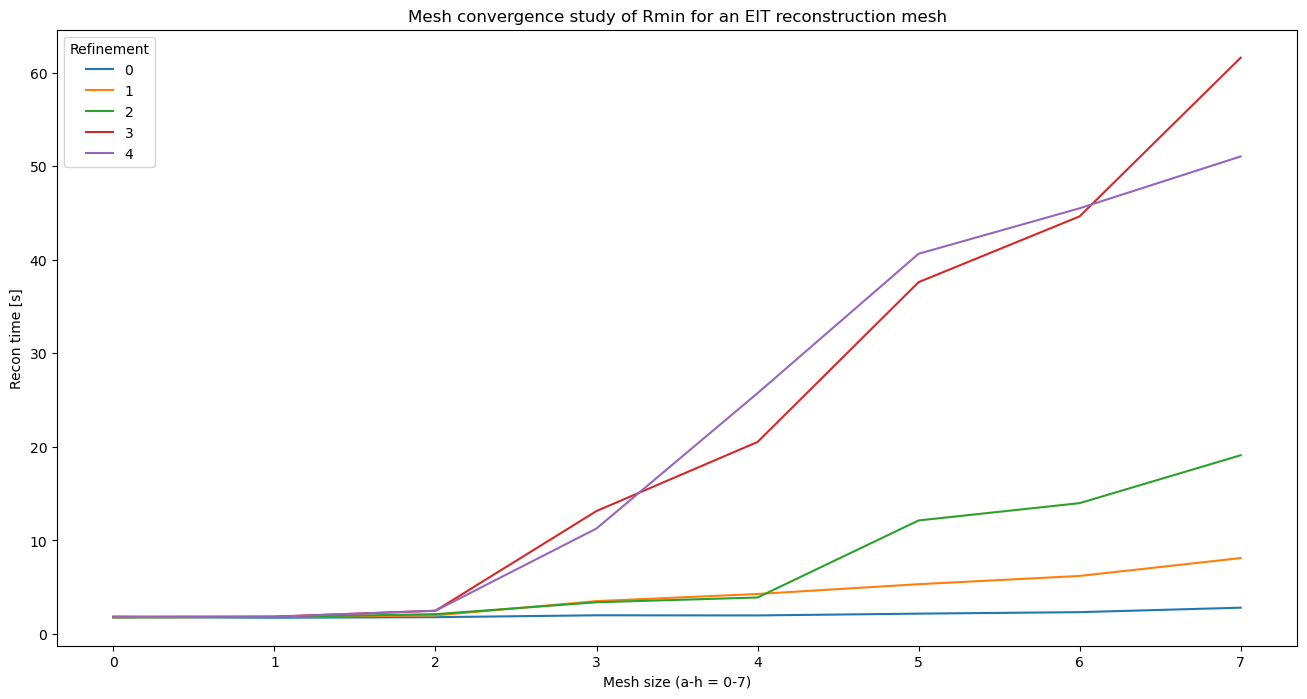

In [ ]:
%matplotlib inline

t_recon_arr_all = []
for sz_i, mesh_size in enumerate(mesh_sizes):
    for ref_i, mesh_refine in enumerate(mesh_refine_arr):
        mesh_params = str_change_index(mesh_params,0,mesh_size)
        mesh_params = str_change_index(mesh_params,3,mesh_refine)
        print(f"Mesh type: {mesh_params}")
        elem_data_arr, nodes_arr, elems_arr, t_recon_arr = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{file}_recon_{mesh_params}",t_recon_arr)
        t_recon_arr_all.append(t_recon_arr[-1])
plt.figure(figsize=(16,8))
t_recon_arr_all = np.reshape(t_recon_arr_all,(len(mesh_sizes),len(mesh_refine_arr)))
plt.plot(t_recon_arr_all)
plt.title('Mesh convergence study of Rmin for an EIT reconstruction mesh')
plt.xlabel("Mesh size (a-h = 0-7)")
plt.ylabel("Recon time [s]")
plt.legend(mesh_refine_arr,title='Refinement')
t_recon_arr_all

Mesh type: a2d0c
[-0.00483134 -0.00476167 -0.00486704 -0.00476776 -0.00477607 -0.00478373
 -0.00475137 -0.00476832]
ok
Mesh type: b2d0c
[-0.00483134 -0.00470524 -0.00486704 -0.00476776 -0.00477607 -0.00478373
 -0.00475137 -0.00476832]
ok
Mesh type: c2d0c
[-0.00483134 -0.00470524 -0.00494119 -0.00476776 -0.00477607 -0.00478373
 -0.00475137 -0.00476832]
ok
Mesh type: d2d0c
[-0.00483134 -0.00470524 -0.00494119 -0.00479774 -0.00477607 -0.00478373
 -0.00475137 -0.00476832]
ok
Mesh type: e2d0c
[-0.00483134 -0.00470524 -0.00494119 -0.00479774 -0.00475039 -0.00478373
 -0.00475137 -0.00476832]
ok
Mesh type: f2d0c
[-0.00483134 -0.00470524 -0.00494119 -0.00479774 -0.00475039 -0.00481314
 -0.00475137 -0.00476832]
ok
Mesh type: g2d0c
[-0.00483134 -0.00470524 -0.00494119 -0.00479774 -0.00475039 -0.00481314
 -0.00476021 -0.00476832]
ok
Mesh type: h2d0c
[-0.00483134 -0.00470524 -0.00494119 -0.00479774 -0.00475039 -0.00481314
 -0.00476021 -0.00477831]
ok
Mesh type: a2d1c
[-0.00467865 -0.00488729 -0.004

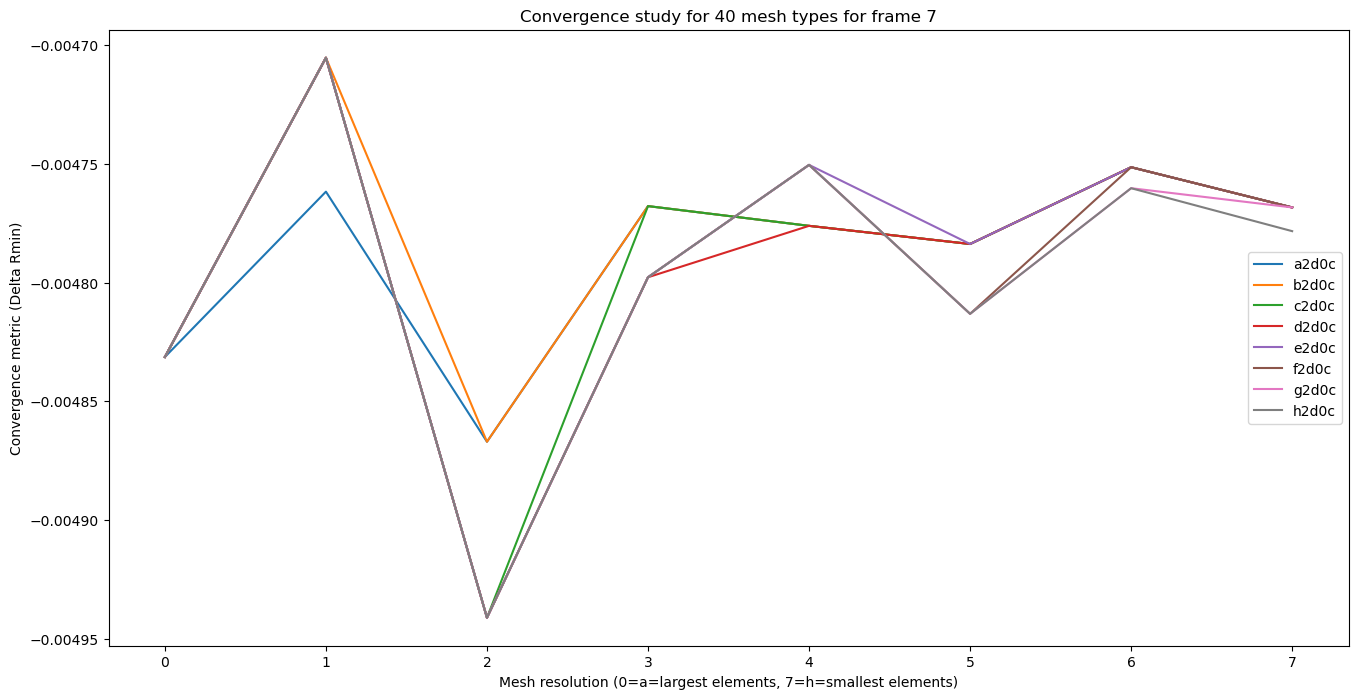

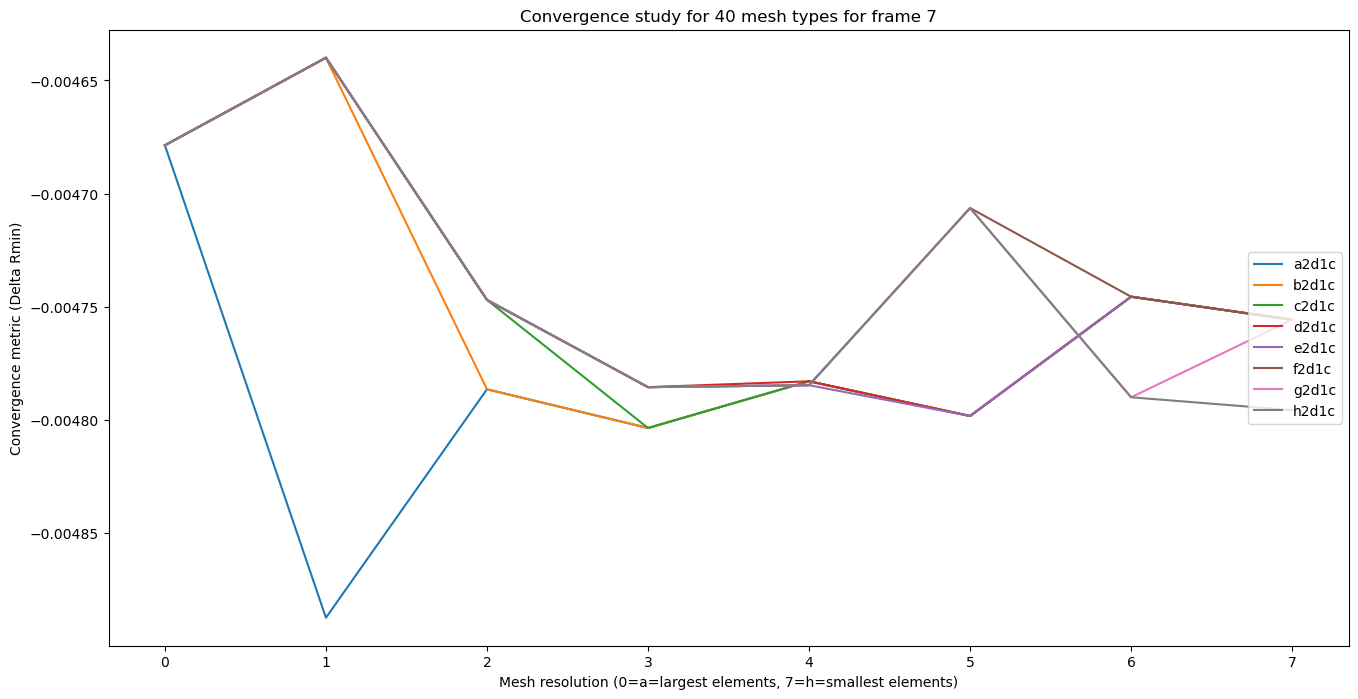

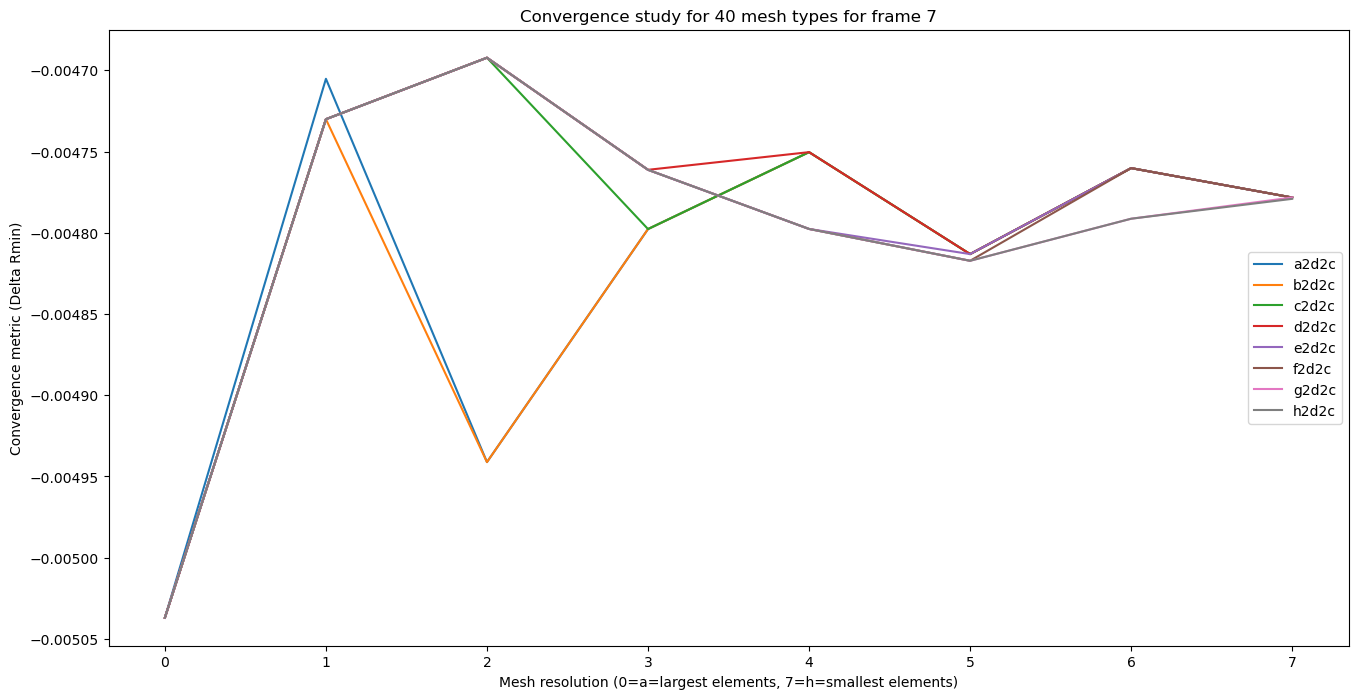

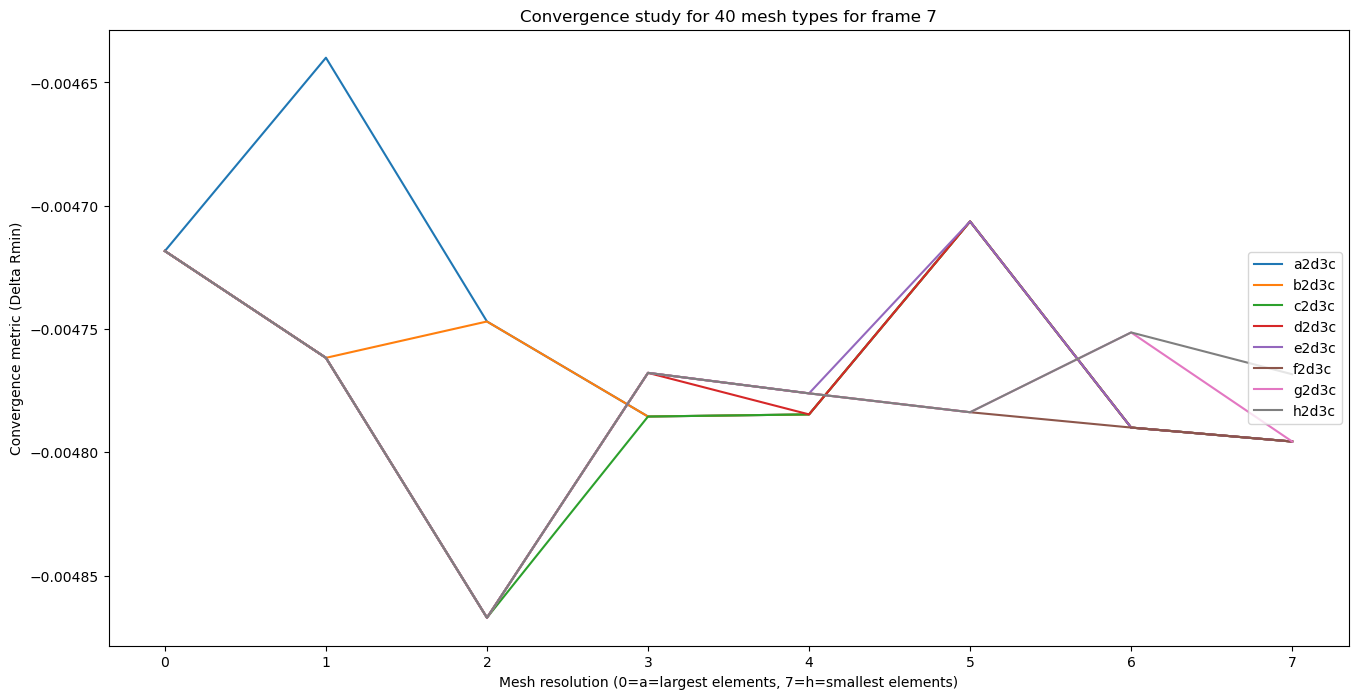

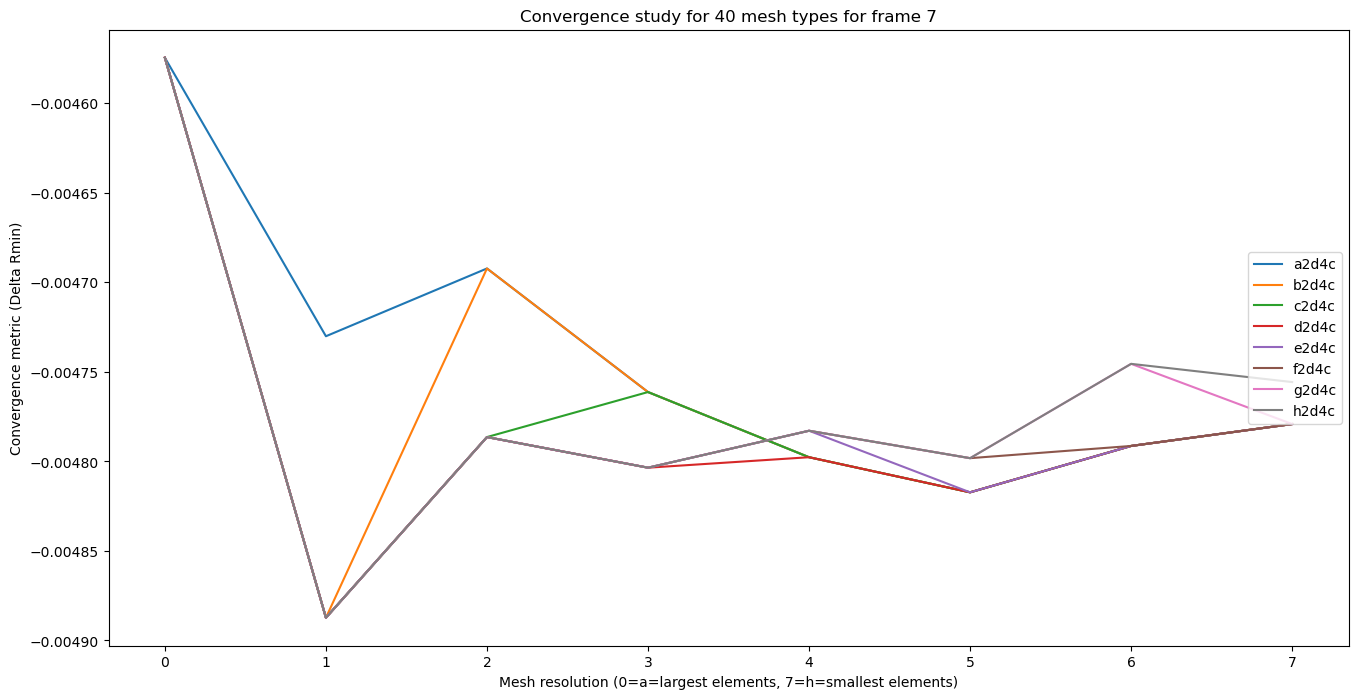

Mesh type: a2d0c
[-0.01021538 -0.01031924 -0.01033381 -0.01025047 -0.01046023 -0.01045929
 -0.01033357 -0.01037502]
ok
Mesh type: b2d0c
[-0.01021538 -0.01029581 -0.01033381 -0.01025047 -0.01046023 -0.01045929
 -0.01033357 -0.01037502]
ok
Mesh type: c2d0c
[-0.01021538 -0.01029581 -0.01027225 -0.01025047 -0.01046023 -0.01045929
 -0.01033357 -0.01037502]
ok
Mesh type: d2d0c
[-0.01021538 -0.01029581 -0.01027225 -0.0103681  -0.01046023 -0.01045929
 -0.01033357 -0.01037502]
ok
Mesh type: e2d0c
[-0.01021538 -0.01029581 -0.01027225 -0.0103681  -0.01047447 -0.01045929
 -0.01033357 -0.01037502]
ok
Mesh type: f2d0c
[-0.01021538 -0.01029581 -0.01027225 -0.0103681  -0.01047447 -0.0103626
 -0.01033357 -0.01037502]
ok
Mesh type: g2d0c
[-0.01021538 -0.01029581 -0.01027225 -0.0103681  -0.01047447 -0.0103626
 -0.01035106 -0.01037502]
ok
Mesh type: h2d0c
[-0.01021538 -0.01029581 -0.01027225 -0.0103681  -0.01047447 -0.0103626
 -0.01035106 -0.01034729]
ok
Mesh type: a2d1c
[-0.01052854 -0.01034746 -0.010308

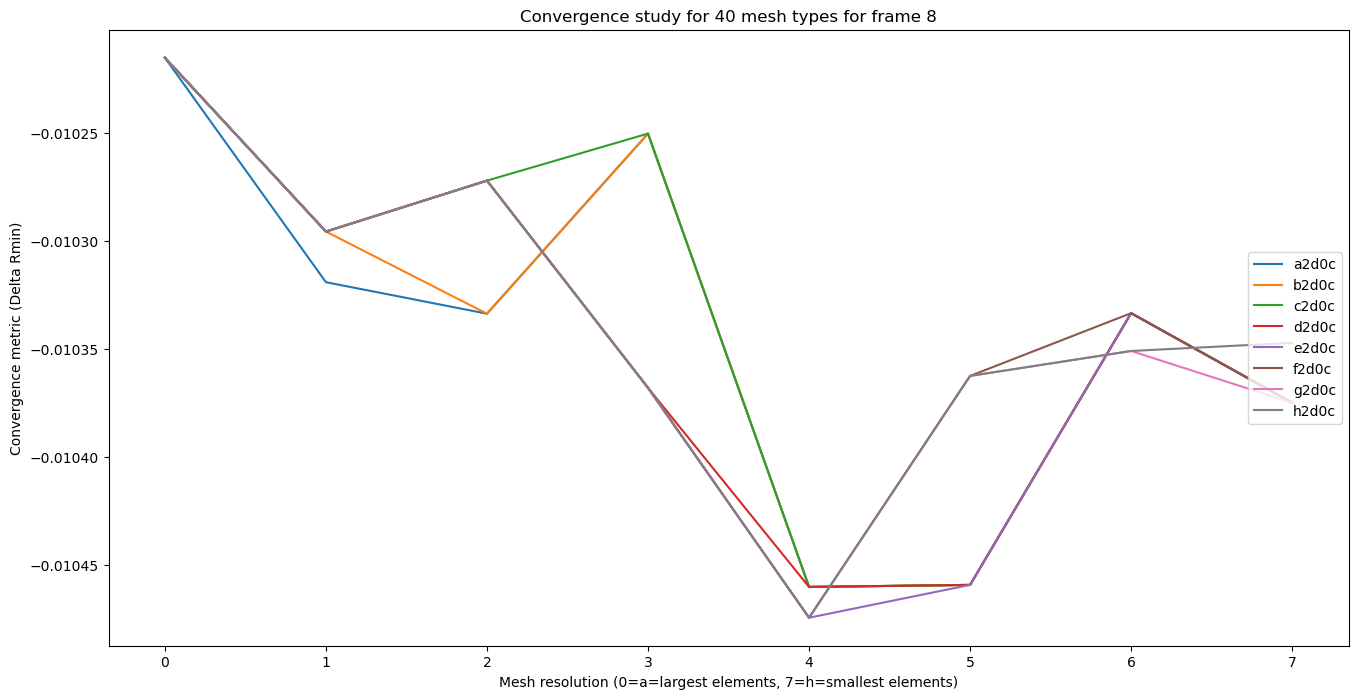

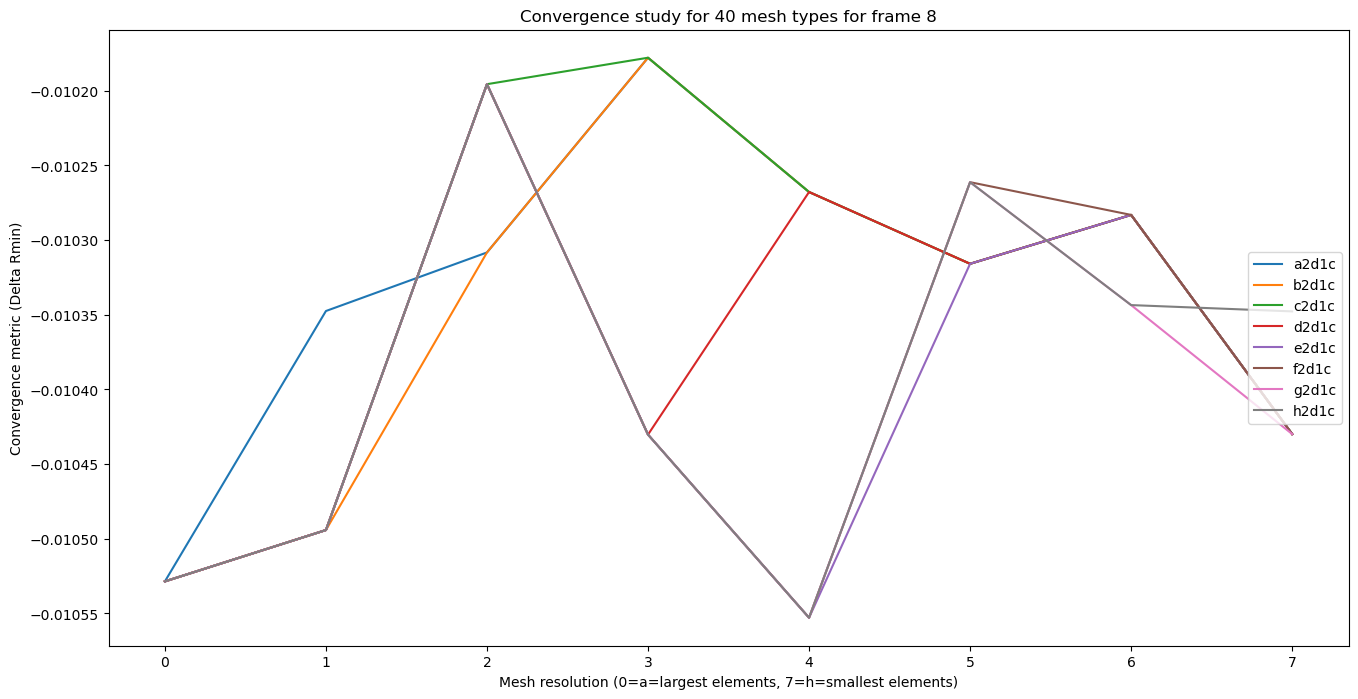

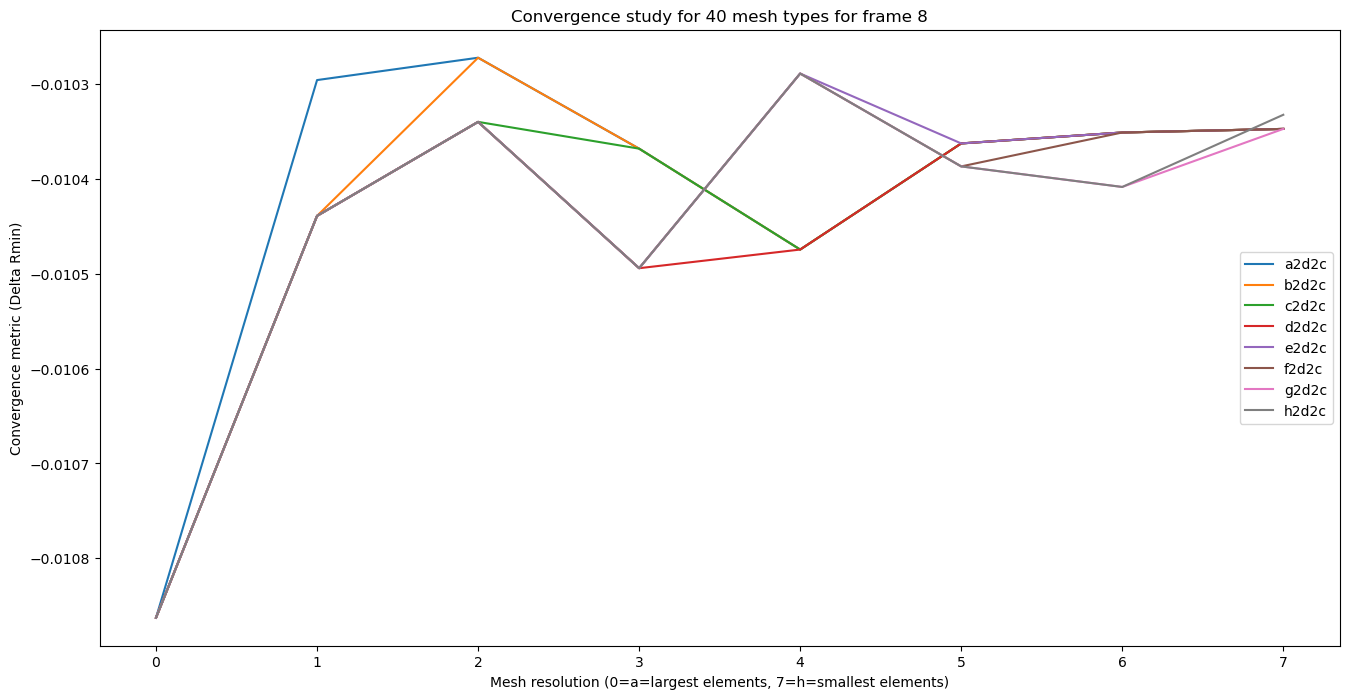

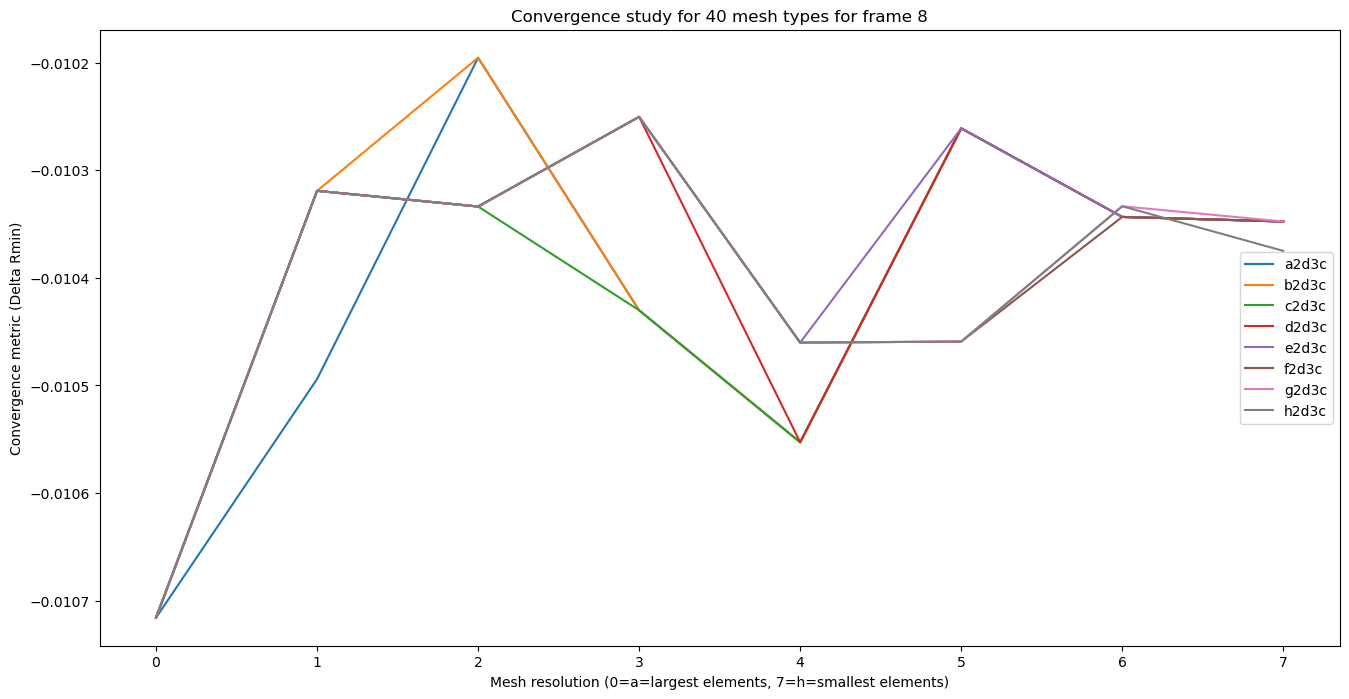

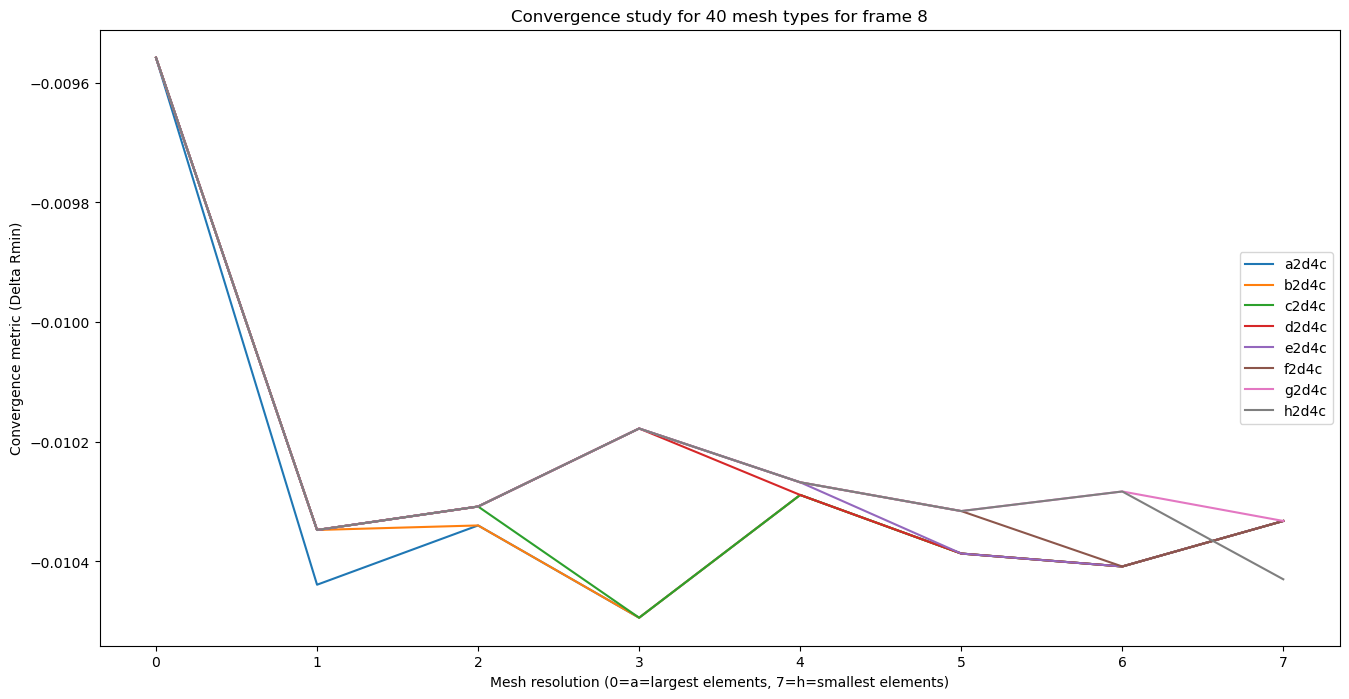

Mesh type: a2d0c
[-0.00981473 -0.01023472 -0.01006469 -0.0101279  -0.01010161 -0.01007256
 -0.01007255 -0.01017414]
ok
Mesh type: b2d0c
[-0.00981473 -0.01010191 -0.01006469 -0.0101279  -0.01010161 -0.01007256
 -0.01007255 -0.01017414]
ok
Mesh type: c2d0c
[-0.00981473 -0.01010191 -0.0101154  -0.0101279  -0.01010161 -0.01007256
 -0.01007255 -0.01017414]
ok
Mesh type: d2d0c
[-0.00981473 -0.01010191 -0.0101154  -0.01025242 -0.01010161 -0.01007256
 -0.01007255 -0.01017414]
ok
Mesh type: e2d0c
[-0.00981473 -0.01010191 -0.0101154  -0.01025242 -0.0101317  -0.01007256
 -0.01007255 -0.01017414]
ok
Mesh type: f2d0c
[-0.00981473 -0.01010191 -0.0101154  -0.01025242 -0.0101317  -0.01020424
 -0.01007255 -0.01017414]
ok
Mesh type: g2d0c
[-0.00981473 -0.01010191 -0.0101154  -0.01025242 -0.0101317  -0.01020424
 -0.01016682 -0.01017414]
ok
Mesh type: h2d0c
[-0.00981473 -0.01010191 -0.0101154  -0.01025242 -0.0101317  -0.01020424
 -0.01016682 -0.01013311]
ok
Mesh type: a2d1c
[-0.00979516 -0.01047378 -0.010

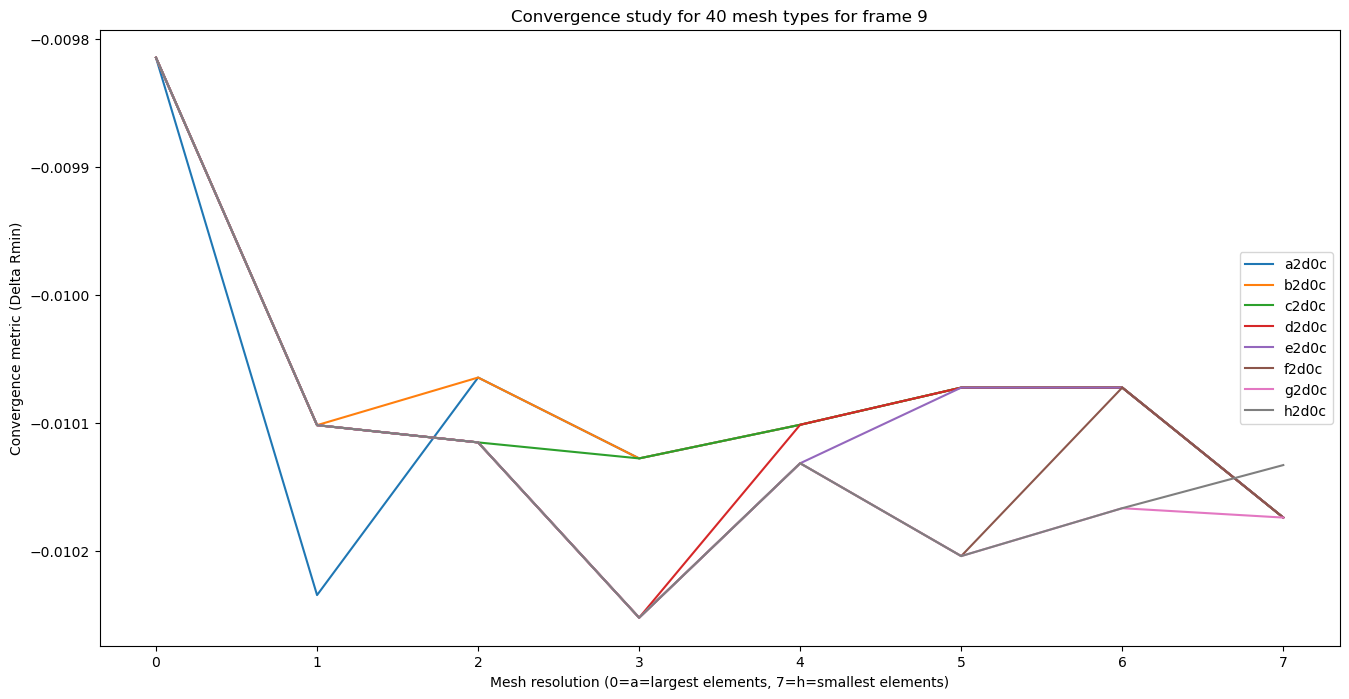

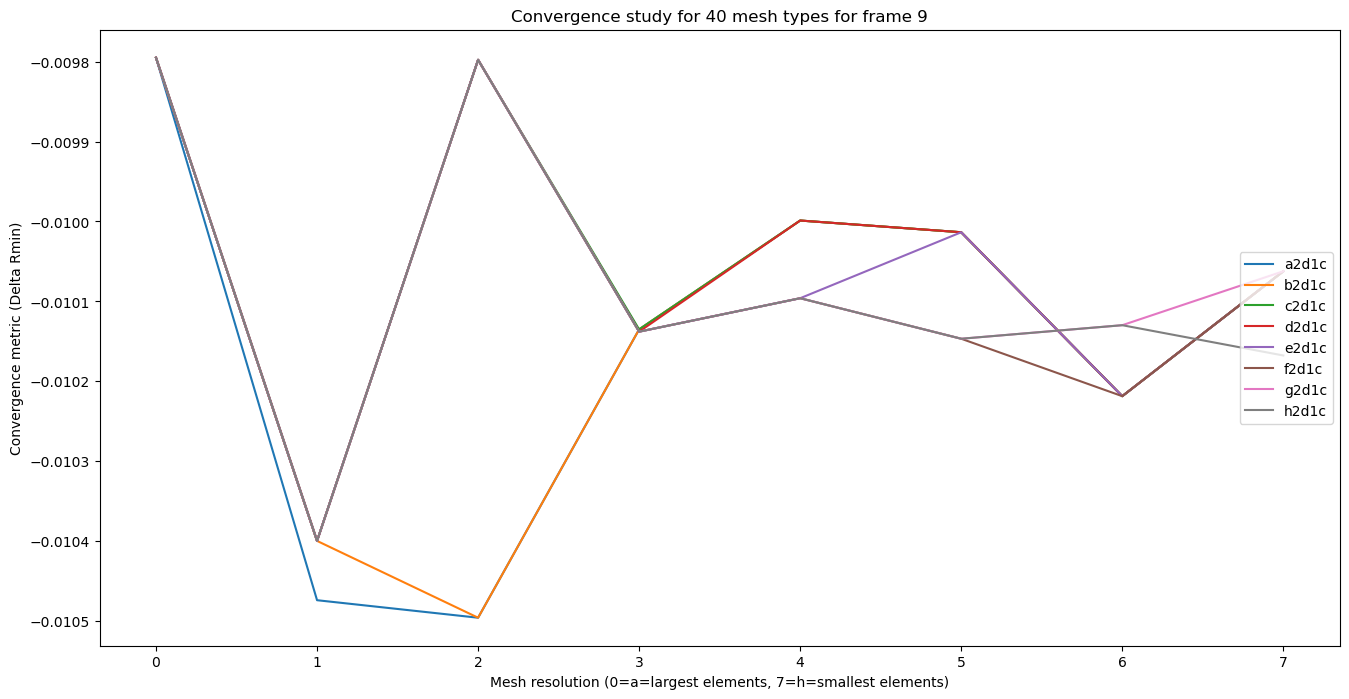

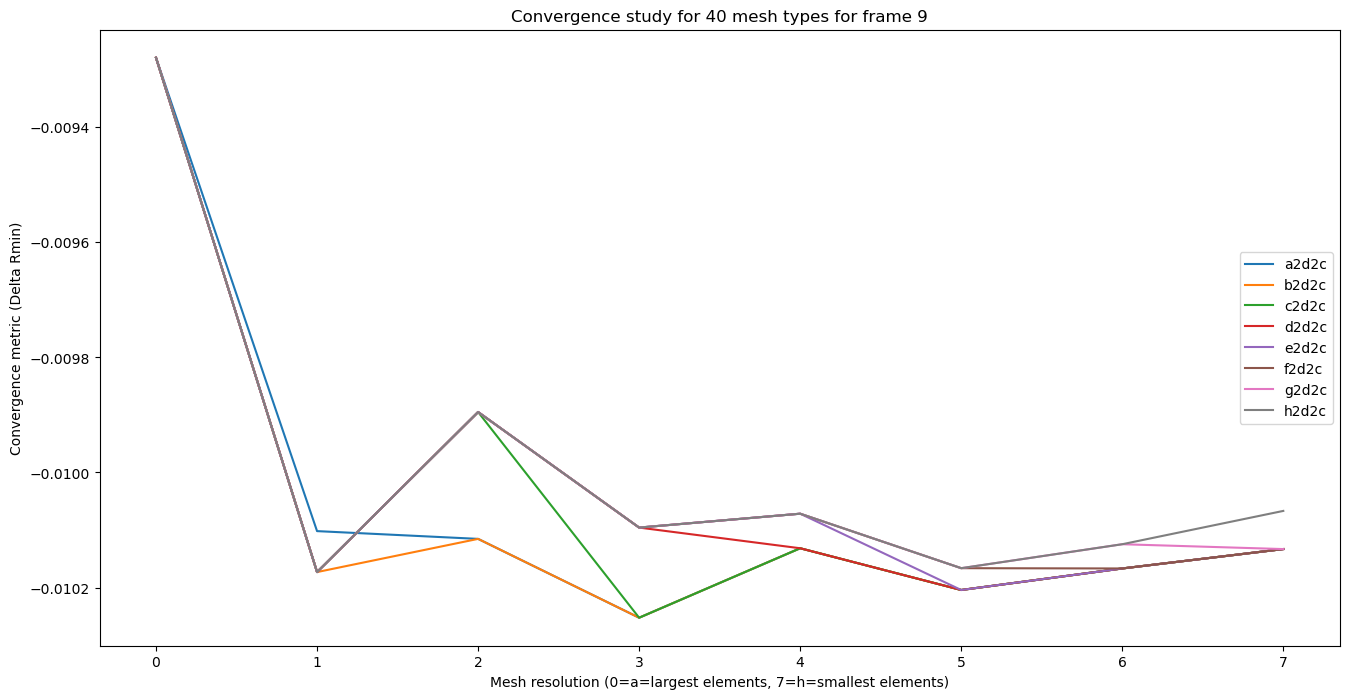

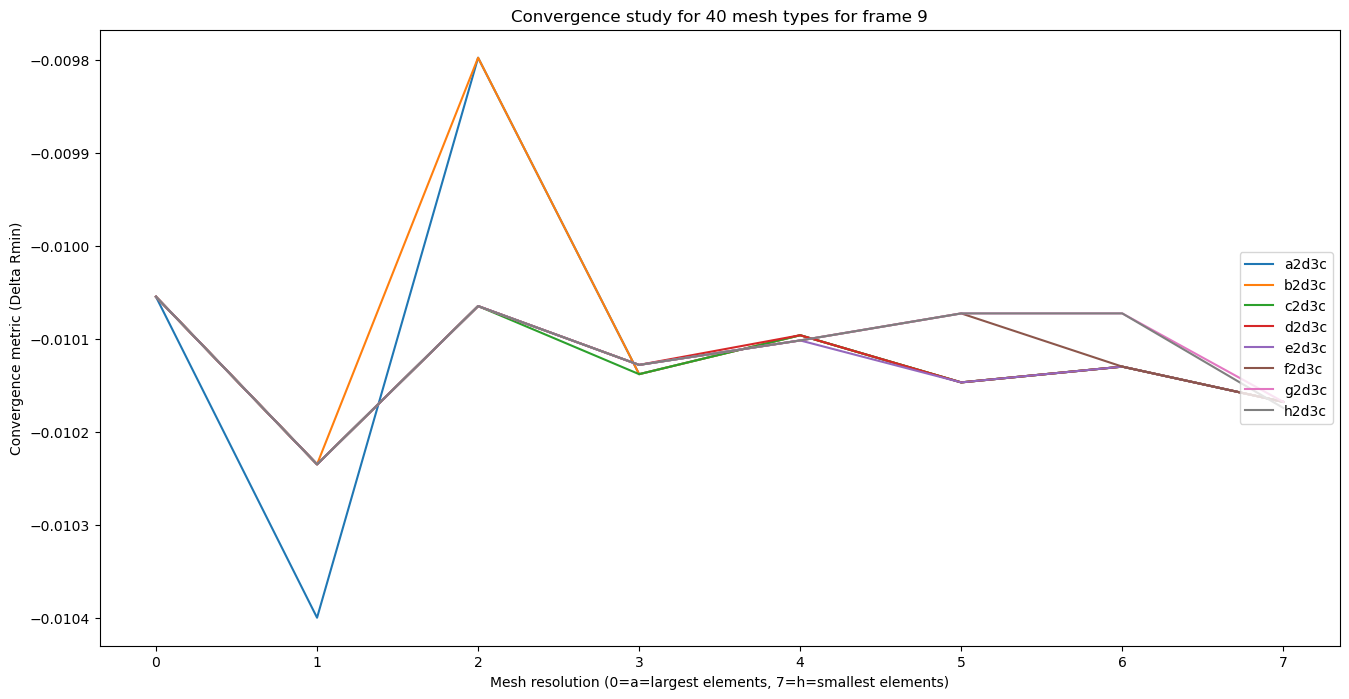

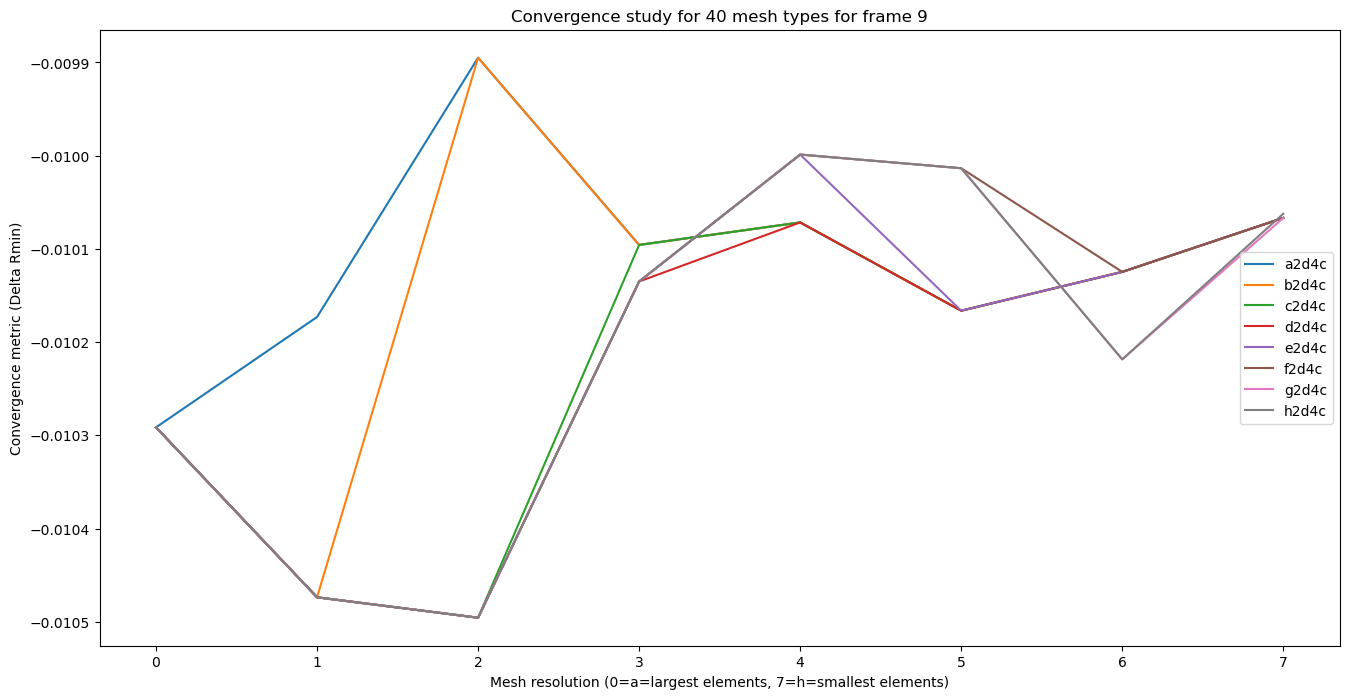

In [ ]:
%matplotlib inline
conv_frames = [7,9]
R_max_arr = []

for sz_i, mesh_size in enumerate(mesh_sizes):
    for ref_i, mesh_refine in enumerate(mesh_refine_arr):
        mesh_params = str_change_index(mesh_params,0,mesh_size)
        mesh_params = str_change_index(mesh_params,3,mesh_refine)
        # print(f"Mesh type: {mesh_params}")
        elem_data_arr, nodes_arr, elems_arr, t_recon_arr = load_recon(elem_data_arr, nodes_arr, elems_arr, f"{raw_data_dir}\{file}_recon_{mesh_params}",t_recon_arr)
        for i in range(frames):
            R_max_arr.append(min(elem_data_arr[i]))

conv_arr = R_max_arr # set convergence study metric here (e.g. min, max or mean Delta R)

conv_arr_shaped = np.reshape(conv_arr,(len(mesh_sizes),len(mesh_refine_arr),frames))
for frame in range(conv_frames[0],conv_frames[1]+1):
    for ref_i, mesh_refine in enumerate(mesh_refine_arr):
        plt.figure(figsize=(16,8))
        mesh_params_arr = []
        frames_mesh_sizes = np.empty((len(mesh_sizes),frames))
        for i in range(len(conv_arr_shaped)):
            mesh_params = str_change_index(mesh_params,0,mesh_sizes[i])
            mesh_params = str_change_index(mesh_params,3,mesh_refine)
            mesh_params_arr.append(mesh_params)
            print(f"Mesh type: {mesh_params}")
            frames_mesh_sizes[i] = conv_arr_shaped[i][ref_i]
            print(frames_mesh_sizes[:,frame])
            print('ok')
            plt.plot(frames_mesh_sizes[:,frame]) # 9th frame
        plt.xlabel('Mesh resolution (0=a=largest elements, 7=h=smallest elements)')
        plt.ylabel('Convergence metric (Delta Rmin)')
        plt.title(f'Convergence study for {len(mesh_params_arr)} mesh types for frame {frame}')
        plt.legend(mesh_params_arr,loc='right')

    plt.show()

### Convergence Study Analysis

From the above convergence study we can see that a mesh refinement of over 2 for mesh sizes over 2 take a much larger amount of time to reconstruct. Hence the refinement factor will be left at 2 and the mesh size will be 3 as this suffciciently converges on the a good solution with the above example data. 

This gives us a mesh parameter code of 'd2d2c'